<a id="Data_Analysis_R"></a>
# Data Analysis R

This notebook contains an R based analysis for the creation of a composite model for method selection. It partially draws on previous analysis in Python and R and therefore neglects some of the basic analyses of the explanatory variables.

[Data Analysis R](#Data_Analysis_R)

- [Configurations](#Configurations)
- [Data Acquisition](#Data_Acquisition)
- [Classification Model](#Classification_Model)
    - [Common Functions](#Common_Functions)
    - [Variable selection for linear error models](#Variable_Selection)
    - [Composite Model](#Composite_Model)
    - [Final Model Analysis](#Final_Model_Analysis)
    - [Paper Visualisations](#Paper_Visualisations)    
    - [Exploring high errors and model behaviour](#Error_Exploration)


<a id="Configurations"></a>
## Configurations

In [1]:
#Set language to get english errors and messages
Sys.setenv(LANG = "en")

In [2]:
#Import packages 
library(ggpubr)
library(gridExtra)
library(plyr)
library(dplyr) 
library(tidyverse)
library(caret)
library(fastDummies)
library(Metrics)
library(xtable)

Loading required package: ggplot2


Attaching package: 'plyr'


The following object is masked from 'package:ggpubr':

    mutate



Attaching package: 'dplyr'


The following objects are masked from 'package:plyr':

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


The following object is masked from 'package:gridExtra':

    combine


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


── Attaching packages ─────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.2 ──
✔ tibble  3.1.8     ✔ purrr   0.3.4
✔ tidyr   1.2.1     ✔ stringr 1.4.1
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::arrange()   masks plyr::arrange()
✖ dplyr::combine()   masks gridExtra::combine()
✖ purrr::compact

In [3]:
#Classes/filter methods for final model
classes <- c(1,2,3,7,8,9,10,11,12,19)

#Parameters for model configuration
dynamic <- FALSE
method <- "lm"
target_prefix <- "stems_in_plot_err_ps"

<a id="Data_Acquisition"></a>
## Data Acquisition

In [4]:
#Read data for plots
csv_out_path <- "./Data/detection_aggregated_lfi.csv"
lfi_trees_grouped <- read.csv(csv_out_path,sep=";",quote = "\"")

In [5]:
#Labels for filter methods
parameterset_lookup_labels<-data.frame(val=c( '1m','1.5m','2m','1m, sigma 1, size 3','1m, sigma 1, size 5','1m, sigma 1, size 7','1m, sigma 2, size 3','1m, sigma 2, size 5','1m, sigma 2, size 7','1m, sigma 3, size 3','1m, sigma 3, size 5','1m, sigma 3, size 7','1.5m, sigma 2, size 3','1.5m, sigma 2, size 5','1.5m, sigma 2, size 7','combined 1m/1.5m/1m, sig2, r3','combined 1m/2m/1m, sig2, r5','combined 1m/1.5m/1m, sig1, r3/1m, sig2, r3','combined 1m/1.5m/1m, sig1, r3/1m, sig2, r3/1m, sig3, r3','Eysn LM Filter','Kaartinen FGI LOCM'), row.names=c( 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,30,31))


In [6]:
nh_lookup_labels<-data.frame(val=c( 'b) Broadleaved','c) Mixed','d) Coniferous'), row.names=c( 1,2,3))
dg_lookup_labels<-data.frame(val=c( 'e) DC ≤ 80%','f) DC > 80%'), row.names=c( 1,2))
hdom_lookup_labels<-data.frame(val=c( 'g) hdom ≤ 22 m', 'h) hdom > 22 m'), row.names=c( 1,2))

In [7]:
#Excluding specific cases
print(count(lfi_trees_grouped)$n)

#Cases with very high stems per ha in baseline ; 3
lfi_trees_grouped <- lfi_trees_grouped[ !(lfi_trees_grouped$flaeche_id %in% c(40321,154907,156044)),]
print(count(lfi_trees_grouped)$n)

#Cases without reference value 
lfi_trees_grouped <- lfi_trees_grouped[!(is.na(lfi_trees_grouped$density_actual_all)),] 
print(count(lfi_trees_grouped)$n)

[1] 5913
[1] 5910
[1] 5910


In [8]:
#Excluding cases without reference data
lfi_trees_grouped <- lfi_trees_grouped[!(is.na(lfi_trees_grouped$nbr_trees_os) | is.na(lfi_trees_grouped$nbr_trees) | (lfi_trees_grouped$nbr_trees_os==0) | (lfi_trees_grouped$nbr_trees_os==-1)),] 
print(count(lfi_trees_grouped)$n)

##Cases with reference value 0 ; 329
#lfi_trees_grouped = lfi_trees_grouped[np.invert((lfi_trees_grouped["density_actual"]==0)&(lfi_trees_grouped["density_actual_all"]==0))].reset_index() 
#print(len(lfi_trees_grouped))

[1] 5254


In [9]:
#Replacing placeholders in stem counts per ha (they could mess up some charts and operations)
for (i in 1:19){
    lfi_trees_grouped[paste("stems_per_ha_ps",i,sep="")] <- apply(lfi_trees_grouped[paste("stems_per_ha_ps",i,sep="")], 1, function(x) ifelse(x>=99999999, 0, x))
    lfi_trees_grouped[paste("stems_in_plot_ps",i,sep="")] <- apply(lfi_trees_grouped[paste("stems_in_plot_ps",i,sep="")], 1, function(x) ifelse(x>=99999999, NA, x))
}

#Additional detections
for (i in 30:31){
    lfi_trees_grouped[paste("stems_per_ha_ps",i,sep="")] <- apply(lfi_trees_grouped[paste("stems_per_ha_ps",i,sep="")], 1, function(x) ifelse(x>=99999999, 0, x))
    lfi_trees_grouped[paste("stems_in_plot_ps",i,sep="")] <- apply(lfi_trees_grouped[paste("stems_in_plot_ps",i,sep="")], 1, function(x) ifelse(x>=99999999, NA, x))
}

In [10]:
#Deriving and re-setting several error measures
for (i in 1:19){    
    lfi_trees_grouped[paste("stems_in_plot_ae_ps",i,sep="")] <- abs(lfi_trees_grouped["nbr_trees_os"]-lfi_trees_grouped[paste("stems_in_plot_ps",i,sep="")])
    lfi_trees_grouped[paste("stems_in_plot_err_ps",i,sep="")] <- (lfi_trees_grouped["nbr_trees_os"]-lfi_trees_grouped[paste("stems_in_plot_ps",i,sep="")])
    
    lfi_trees_grouped[paste("stems_in_plot_ae_all_ps",i,sep="")] <- abs(lfi_trees_grouped["nbr_trees"]-lfi_trees_grouped[paste("stems_in_plot_ps",i,sep="")])
    lfi_trees_grouped[paste("stems_in_plot_err_all_ps",i,sep="")] <- (lfi_trees_grouped["nbr_trees"]-lfi_trees_grouped[paste("stems_in_plot_ps",i,sep="")])
    
    lfi_trees_grouped[paste("stems_per_ha_rs_ps",i,sep="")] <- (lfi_trees_grouped["density_actual"]-lfi_trees_grouped[paste("stems_per_ha_ps",i,sep="")])^2
    lfi_trees_grouped[paste("stems_per_ha_ae_ps",i,sep="")] <- abs(lfi_trees_grouped["density_actual"]-lfi_trees_grouped[paste("stems_per_ha_ps",i,sep="")])
    lfi_trees_grouped[paste("stems_per_ha_err_ps",i,sep="")] <- (lfi_trees_grouped[paste("stems_per_ha_ps",i,sep="")]-lfi_trees_grouped["density_actual"])

}

#Additional detections
for (i in 30:31){
    lfi_trees_grouped[paste("stems_in_plot_ae_ps",i,sep="")] <- abs(lfi_trees_grouped["nbr_trees_os"]-lfi_trees_grouped[paste("stems_in_plot_ps",i,sep="")])
    lfi_trees_grouped[paste("stems_in_plot_err_ps",i,sep="")] <- (lfi_trees_grouped["nbr_trees_os"]-lfi_trees_grouped[paste("stems_in_plot_ps",i,sep="")])
    
    lfi_trees_grouped[paste("stems_in_plot_ae_all_ps",i,sep="")] <- abs(lfi_trees_grouped["nbr_trees"]-lfi_trees_grouped[paste("stems_in_plot_ps",i,sep="")])
    lfi_trees_grouped[paste("stems_in_plot_err_all_ps",i,sep="")] <- (lfi_trees_grouped["nbr_trees"]-lfi_trees_grouped[paste("stems_in_plot_ps",i,sep="")])
    
    lfi_trees_grouped[paste("stems_per_ha_rs_ps",i,sep="")] <- (lfi_trees_grouped["density_actual"]-lfi_trees_grouped[paste("stems_per_ha_ps",i,sep="")])^2
    lfi_trees_grouped[paste("stems_per_ha_ae_ps",i,sep="")] <- abs(lfi_trees_grouped["density_actual"]-lfi_trees_grouped[paste("stems_per_ha_ps",i,sep="")])
    lfi_trees_grouped[paste("stems_per_ha_err_ps",i,sep="")] <- (lfi_trees_grouped[paste("stems_per_ha_ps",i,sep="")]-lfi_trees_grouped["density_actual"])

}

In [11]:
#Deriving attributes from existing data 
lfi_trees_grouped["acquisition_diff"] <- lfi_trees_grouped["VHM_Tile_Year"]-lfi_trees_grouped["year"]
lfi_trees_grouped["acquisition_diff_abs"] <- abs(lfi_trees_grouped["acquisition_diff"])

lfi_trees_grouped["veg_code_complete"] <- lfi_trees_grouped["veg_code"]*100+lfi_trees_grouped["veg_subcode"]
lfi_trees_grouped["constant"] <- 1

lfi_trees_grouped["dg_scaled"] <- lfi_trees_grouped["dg"]/100
lfi_trees_grouped["hdom_scaled"] <- lfi_trees_grouped["hdom"]/100
lfi_trees_grouped["nh_scaled"] <- lfi_trees_grouped["nh"]/100

In [12]:
#Determine method with minimal squared difference
determine_min_class_flex <- function (x, input_prefix="stems_per_ha_rs_", input_classes){
    input_columns <- lapply(input_classes,function(x) paste(input_prefix,"ps",x,sep=""))

    min_val = min(x[unlist(input_columns)])

    for (i in input_classes){
        if (x[paste(input_prefix,"ps",i,sep="")] == min_val) {
            return(i)
        }
    }
}


lfi_trees_grouped["parameterset_min"] <- apply(lfi_trees_grouped,1,function(x) determine_min_class_flex(x, input_prefix="stems_per_ha_rs_",input_classes=classes) )   
    

In [13]:
#Deriving 0/1 labels for whether a filter method has the minimal error or not
eps=0.0001
pid <- 0
determine_min_labels <- function (df, input_prefix="stems_per_ha_rs_", output_prefix="ps", input_classes=c(1,2,3,7,8,9,4,5,6,10,11,12,13,14,15,16,17,18,19)){
    input_columns <- lapply(input_classes,function(x) paste(input_prefix,"ps",x,sep=""))
    
    df$tmp_min <- apply(df[unlist(input_columns)],1,min)

    for (i in 1:length(input_classes)) {
        ps=input_classes[[i]]
        df[paste(output_prefix,ps,sep="")] <-  (abs((df[paste(input_prefix,"ps",ps,sep="")] - df$tmp_min))<eps)*1
    }             
    return(subset(df, select = -c(tmp_min) ))
}

lfi_trees_grouped <- determine_min_labels(lfi_trees_grouped, output_prefix="ps", input_classes=classes)
                            
lfi_trees_grouped$parameterset_min <- as.factor(lfi_trees_grouped$parameterset_min)  


In [14]:
#Not clear if this is necessary/wise
lfi_trees_grouped$fst <- as.factor(lfi_trees_grouped$fst)  
lfi_trees_grouped$fst_nh <- as.factor(lfi_trees_grouped$fst_nh)  
lfi_trees_grouped$fst_dg <- as.factor(lfi_trees_grouped$fst_dg)  
lfi_trees_grouped$fst_hdom <- as.factor(lfi_trees_grouped$fst_hdom)  
lfi_trees_grouped$veg_code <- as.factor(lfi_trees_grouped$veg_code)  
lfi_trees_grouped$veg_subcode <- as.factor(lfi_trees_grouped$veg_subcode)  
lfi_trees_grouped$veg_code_complete <- as.factor(lfi_trees_grouped$veg_code_complete)  
lfi_trees_grouped$waldrand <- as.factor(lfi_trees_grouped$bestandesgrenze)  
lfi_trees_grouped$bestandesgrenze <- as.factor(lfi_trees_grouped$bestandesgrenze)

Detection and reference data fields.

|__Name__| __Description__|__Variable Type}__ |
|--------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|------------------------|
| Perimeter ID                                                                                     | Identifier of the perimeter                                                                                                                                                                                  | none                   |
| slope_sin<sup>1</sup>                                                                 | Sine of the slope based on 25 m DHM                                                                                                                                                                          | explanatory            |
| aspect_cos                                                                                   | Cosine of the aspect based on 25 m DHM                                                                                                                                                                       | explanatory            |
| aspect_sin                                                                                   | Sine of the aspect based on 25 m DHM                                                                                                                                                                         | explanatory            |
| northness<sup>1</sup>                                                                  | Cosine of the aspect times the sine of the slope based on 25 m DHM                                                                                                                                           | explanatory            |
| eastness                                                                                      | Sine of the aspect times the sine of the slope based on 25 m DHM                                                                                                                                             | explanatory            |
| z<sup>1</sup>                                                                          | Height above sea level in m at plot center                                                                                                                                                                   | explanatory            |
| dg<sup>1</sup>                                                                         | Degree of cover ($(2/3*h_{dom})<h$) in percent (values from 0 to 100) for a 25 by 25 m cell centered on the plot center                                                                                      | explanatory            |
| hdom<sup>1</sup>                                                       | Dominant height in the plot in m for a 25 by 25 m cell centered on the plot center                                                                                                                           | explanatory            |
| nh<sup>1</sup>                                                                        | Dominant Leaf Type for a 25 by 25 m cell centered on the plot center                                                                                                                                         | explanatory            |
| dg_ks<sup>1</sup>                                                                    | Degree of cover no layer ($h<0.4m$) in percent (values from 0 to 100) for a 25 by 25 m cell centered on the plot center                                                                                      | explanatory            |
| dg_us<sup>1</sup>                                                                     | Degree of cover lower layer ($0.4m<=h<=(1/3*h_{dom})$) in percent (values from 0 to 100)  for a 25 by 25 m cell centered on the plot center                                                                  | explanatory            |
| dg_ms<sup>1</sup>                                                                     | Degree of cover middle layer ($(1/3*h_{dom})<h<=(2/3*h_{dom})$) in percent (values from 0 to 100)  for a 25 by 25 m cell centered on the plot center                                                         | explanatory            |
| dg_os<sup>1</sup>                                                                    | Degree of cover upper layer ($(2/3*h_{dom})<h<=h_{dom}$) in percent (values from 0 to 100)  for a 25 by 25 m cell centered on the plot center                                                                | explanatory            |
| dg_ueb<sup>1</sup>                                                                    | Degree of cover protruding ($h_{dom}<h$) in percent (values from 0 to 100) for a 25 by 25 m cell centered on the plot center                                                                                 | explanatory            |
| tri_min<sup>1</sup>, tri_max, tri_mean<sup>1</sup>, tri_median, tri_std<sup>1</sup> | Aggregated statistics for the Terrain Ruggedness Index of the CHM in a 25 by 25 m cell centered on the plot center                                                                                           | explanatory            |
| tpi_min, tpi_max, tpi_mean<sup>1</sup>, tpi_median<sup>1</sup>, tpi_std<sup>1</sup> | Aggregated statistics for the Topographic Position Index of the CHM in a 25 by 25 m cell centered on the plot center                                                                                         | explanatory            |
| nbr_trees_os                                                                                   | Reference value number of trees in the upper layer                                                                                                                                                           | reference/target       |
| density\_actual                                                                                  | Reference value for tree density in trees per ha; this only includes the trees of the upper layer                                                                                                            | reference/target       |
| stems_per_ha_ps1 ... stems_per_ha_ps15                                                     | Number of detected trees per ha for filter combinations 1 to 15 (trees per ha)                                                                                                                               | target/scoring         |
| dr_ps1 ... dr_ps15                                                                             | Detection rate on reference trees in the upper canopy layer (stems_per_ha_psX/density_actual) for the filter combinations 1 to 10                                                                        | target/scoring         |
| stems_in_plot_ps1 ... stems_in_plot_ps15                                                   | Absolute number of stems detected for the filter combinations 1 to 15                                                                                                                                        | target/scoring         |
| stems_per_ha_err_ps1 ... stems_per_ha_err_ps15                                           | Difference between stem count per ha detected and reference trees in the upper canopy layer per ha ( (stems_per_ha_rs_all_psX-density_actual)^2 ) for the filter combinations 1 to 15 | target/scoring         |
| stems_in_plot_err_ps1 ... stems_in_plot_err_ps15                                         | Difference between the number of detected trees and the number of reference trees in the upper layer of the plot (stems_in_plot_psX-nbr_trees) for the filter combinations 1 to 15                       | target/scoring         |
|
<sup>1</sup>: variable used in error model for  final analysis|

In [15]:
#Add dummy 0/1 columns for selected factors
lfi_trees_grouped <- dummy_cols(lfi_trees_grouped, select_columns = "fst")
lfi_trees_grouped <- dummy_cols(lfi_trees_grouped, select_columns = "fst_nh")
lfi_trees_grouped <- dummy_cols(lfi_trees_grouped, select_columns = "fst_dg")
lfi_trees_grouped <- dummy_cols(lfi_trees_grouped, select_columns = "fst_hdom")
        

In [16]:
#Adding log transformed error and errors normalized by the density within the plot
for (i in 1:19){ 
    stems <- lfi_trees_grouped[paste("stems_in_plot_err_ps",i,sep="")]
    stems_min <- min(stems+1,na.rm = TRUE)
    stems_max <- max(stems+1-stems_min,na.rm = TRUE)
    lfi_trees_grouped[paste("stems_in_plot_err_trans_ps",i,sep="")] <- log10(stems_max-(stems - stems_min))
    # lfi_trees_grouped[paste("stems_in_plot_err_trans_ps",i,sep="")] <- sqrt(stems_max-(stems - stems_min))
    lfi_trees_grouped[paste("stems_in_plot_err_norm_ps",i,sep="")] <- (lfi_trees_grouped[paste("stems_in_plot_ps",i,sep="")]-lfi_trees_grouped["nbr_trees_os"])/lfi_trees_grouped["nbr_trees_os"]
    # lfi_trees_grouped[paste("stems_in_plot_err_norm_ps",i,sep="")] <- (lfi_trees_grouped["nbr_trees_os"]-lfi_trees_grouped[paste("stems_in_plot_ps",i,sep="")])/sd(lfi_trees_grouped[,"nbr_trees_os"])
}

#Additional detections
for (i in 30:31){ 
    stems <- lfi_trees_grouped[paste("stems_in_plot_err_ps",i,sep="")]
    stems_min <- min(stems+1,na.rm = TRUE)
    stems_max <- max(stems+1-stems_min,na.rm = TRUE)
    lfi_trees_grouped[paste("stems_in_plot_err_trans_ps",i,sep="")] <- log10(stems_max-(stems - stems_min))
    # lfi_trees_grouped[paste("stems_in_plot_err_trans_ps",i,sep="")] <- sqrt(stems_max-(stems - stems_min))
    lfi_trees_grouped[paste("stems_in_plot_err_norm_ps",i,sep="")] <- (lfi_trees_grouped[paste("stems_in_plot_ps",i,sep="")]-lfi_trees_grouped["nbr_trees_os"])/lfi_trees_grouped["nbr_trees_os"]
    # lfi_trees_grouped[paste("stems_in_plot_err_norm_ps",i,sep="")] <- (lfi_trees_grouped["nbr_trees_os"]-lfi_trees_grouped[paste("stems_in_plot_ps",i,sep="")])/sd(lfi_trees_grouped[,"nbr_trees_os"])
}

In [17]:
print(paste(colnames(lfi_trees_grouped), collapse = "', '"))

[1] "perimeter_id', 'flaeche_id', 'source_id', 'source_label', 'slope', 'slope_class', 'slope_sin', 'aspect', 'aspect_class', 'aspect_cos', 'aspect_sin', 'northness', 'eastness', 'z', 'veg_code', 'veg_de', 'veg_subcode', 'fst', 'fst_dg', 'fst_hdom', 'fst_nh', 'dg', 'hdom', 'nh', 'hdom50', 'dg50', 'nh50', 'fst50', 'dg_ks', 'dg_us', 'dg_ms', 'dg_os', 'dg_ueb', 'dg_ks50', 'dg_us50', 'dg_ms50', 'dg_os50', 'dg_ueb50', 'tri_min', 'tri_max', 'tri_mean', 'tri_median', 'tri_std', 'tpi_min', 'tpi_max', 'tpi_mean', 'tpi_median', 'tpi_std', 'local_peaks', 'x_lv95', 'y_lv95', 'waldrand', 'bestandesgrenze', 'nbr_trees', 'nbr_trees_os', 'bas_ref', 'year', 'density_actual', 'density_actual_all', 'bas_per_ha_ref', 'KANTONSNUM', 'VHM_Year_Min', 'VHM_Year_Max', 'VHM_Tile_Year', 'plot_area', 'stems_per_ha_ps1', 'stems_per_ha_ps2', 'stems_per_ha_ps3', 'stems_per_ha_ps4', 'stems_per_ha_ps5', 'stems_per_ha_ps6', 'stems_per_ha_ps7', 'stems_per_ha_ps8', 'stems_per_ha_ps9', 'stems_per_ha_ps10', 'stems_per_ha_ps

In [18]:
#Some stats about the reference plots
summary(lfi_trees_grouped$z)
data.frame(table(lfi_trees_grouped$veg_de))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  195.3   669.7  1029.0  1078.8  1440.5  2243.6 

Var1                             Freq
1  -                                   5
2  collin                            111
3  collin mit Buche                  118
4  hochmontan im Tannen-Hauptareal   356
5  hochmontan im Tannen-Nebenareal   201
6  hochmontan im Tannen-Reliktareal  300
7  hyperinsubrisch                    29
8  obermontan                        948
9  obersubalpin                      239
10 subalpin                          580
11 submontan                         984
12 unter-/obermontan                 191
13 untermontan                      1192

<a id="Classification_Model"></a>
## Classification Model

<a id="Common_Functions"></a>
### Common Functions

In [19]:
#Setting input data
target_col = 'stems_per_ha_err_ps1'
cols_complete = c(  'slope_sin', 'aspect_sin', 'northness', 'eastness', 'z', 'veg_code', 
  'fst', 'fst_nh', 'fst_dg', 'fst_hdom',
  'dg', 'hdom', 'nh', 
  'dg_ks', 'dg_us', 'dg_ms', 'dg_os', 'dg_ueb', 
  'tri_min', 'tri_max', 'tri_mean', 'tri_median', 'tri_std', 
  'tpi_min', 'tpi_max', 'tpi_mean', 'tpi_median', 'tpi_std', 
  'waldrand', 'bestandesgrenze'
 ) 

In [20]:
#Function for partitioning data into calibration/validation
get_partitions <- function(target_col, data=lfi_trees_grouped, x_columns=cols_complete, calibration_size=0.8, random_state=42){
    set.seed(random_state)
    data_filtered <- data[!is.na(data[,target_col]),]
    in_calibration <- createDataPartition(data_filtered[,target_col], p = calibration_size)
    cols_combined = c(x_columns, target_col)
    return(list(
        in_calibration = in_calibration[[1]],
        calibration = data_filtered[in_calibration[[1]],cols_combined],
        validation = data_filtered[-in_calibration[[1]],cols_combined]
    ))
}


In [21]:
#Function for generrating a string representation of a fitted linear model
#Based on https://stats.stackexchange.com/a/433060
model_equation <- function(model, ...) {
  format_args <- list(...)
  
  model_coeff <- model$coefficients
  format_args$x <- abs(model$coefficients)
  model_coeff_sign <- sign(model_coeff)
  model_coeff_prefix <- case_when(model_coeff_sign == -1 ~ " - ",
                                  model_coeff_sign == 1 ~ " + ",
                                  model_coeff_sign == 0 ~ " + ")
  model_eqn <- paste(strsplit(as.character(model$call$formula), "~")[[2]], # 'y'
                     "=",
                     paste(if_else(model_coeff[1]<0, "- ", ""),
                           do.call(format, format_args)[1],
                           paste(model_coeff_prefix[-1],
                                 do.call(format, format_args)[-1],
                                 " * ",
                                 names(model_coeff[-1]),
                                 sep = "", collapse = ""),
                           sep = ""))
  return(model_eqn)
}

In [22]:
#Function for generating a list with string representations of the fitted models in a composite model
#Intended for examining the underlying linear models
gather_model_equations <- function(model_list, classes, target_prefix, digits = 3) {
    res <- list()
    for (i in 1:length(classes)){
        class <- classes[i]
        target_column <- paste(target_prefix,class,sep="")

        model <- model_list[[class]]
        model_formula <- model_equation(model$finalModel, digits = digits)
        model_formula <- gsub(".outcome", target_column, model_formula)
        res <- rbind(res,model_formula)
    }
    return(res)
}

In [23]:
#For lookup purposes when applying FST expert approach
fst_parameterset_mappings <- structure(c(2,2,7,16,
                                         2,16,7,16,
                                         16,16,16,16), 
                                names=c("111","112","121","122",
                                 "211","212","221","222",
                                 "311","312","321","322") ) 

<a id="Variable_Selection"></a>
### Variable selection for linear error models

In [24]:
#Variables for selection
cols_reduced = c(  
  'slope_sin', 'northness', 'eastness', 'z', 
  'dg', 'hdom', 'nh', 
  'dg_ks', 'dg_us', 'dg_ms', 'dg_os', 'dg_ueb', 
  'tri_min', 'tri_max', 'tri_mean', 'tri_median', 'tri_std', 
  'tpi_min', 'tpi_max', 'tpi_mean', 'tpi_median', 'tpi_std'
 ) 

In [25]:
#Function for performing a variable importance analysis for a specified pre-processing filter
variable_importance_analysis <- function(method='ps1') {
    #Variable Importance from a linear model with reduced columns and repeated CV
    target <- paste('stems_per_ha_err_',method,sep="")
    data <- lfi_trees_grouped[c(cols_reduced,target)]

    # ensure results are repeatable
    set.seed(42)
    # prepare training scheme
    control <- trainControl(method="repeatedcv", number=10, repeats=3)
    # calibrate/train the model
    model_lm_psx <- train(formula(paste(target,"~.",sep="")), data=data, method="lm", preProcess="scale", trControl=control)
    # estimate variable importance
    importance <- varImp(model_lm_psx, scale=FALSE)
    # summarize importance
    return(importance)    
}

In [26]:
#Perform a variable importance analysis for all pre-processing filters
importance_list <- vector(mode = "list", length = 19)
for (i in 1:19) {
    filter <- paste0("ps",i)
    imp <- variable_importance_analysis(filter)
    imp <- imp$importance
    names(imp) <- filter
    importance_list[[i]] <- imp
}

importance_matrix <- do.call("cbind",importance_list)

In [27]:
#Determine the count of variables with importance variables above the set threshold
importance_threshold <- 2.5
importance_matrix$relevance_count <- 0
importance_matrix$relevance_count  <- apply(importance_matrix, 1, function(x) sum(x>importance_threshold))
importance_matrix

ps1        ps2       ps3        ps4        ps5       ps6       
slope_sin   1.4063745 2.7543458  1.4058411 2.90588260 3.0341322 3.00453783
northness   7.3714761 6.8449459  6.9839055 6.99347176 7.0571268 7.05902083
eastness    1.2817060 0.1197211  0.2066311 0.06219663 0.3807246 0.29881146
z           8.3180668 4.4698947  3.7279665 5.39576602 3.7733213 3.63823134
dg          3.8157362 6.9989055  6.5835365 7.21404352 7.6917242 7.62198801
hdom        4.3457746 8.5125573  6.3579132 9.03202366 7.8282127 7.67609863
nh         15.9859719 8.6301350 10.2501359 8.23768674 9.0385981 9.14505064
dg_ks       9.0584876 1.3258594  1.3980846 1.61030841 0.0926666 0.04807435
dg_us       1.0768491 2.1683959  3.3577751 2.14984155 2.6092050 2.67075415
dg_ms       1.7361167 3.0040424  3.6625294 2.79699330 2.5868625 2.71609613
dg_os       5.0675353 5.4206947  4.7593157 5.80199940 6.0363654 5.92898182
dg_ueb      3.6293886 6.1051327  5.3094751 6.35630075 6.4681988 6.37627765
tri_min     3.4217383 2.2016138  2.3802706 2.04253879 3.1599044 3.06966337
tri_max     1.4882714 0.6169011  0.2984693 0.85075980 0.9297182 1.11560931
tri_mean    8.9615189 0.6447353  3.1795704 1.73775654 0.5319714 0.52543340
tri_median  1.2333636 1.2016178  0.6399113 0.61720353 1.0396003 0.95253935
tri_std     7.2074602 1.1564483  1.6136097 2.83470042 0.6066184 0.82944403
tpi_min     0.0883858 0.7246843  1.6392549 0.14986681 0.6788587 0.43742210
tpi_max     1.5943907 0.7215373  0.6957317 0.94982067 0.6634240 0.76443912
tpi_mean    1.6841863 0.5350701  2.0456831 0.25248453 1.0009777 0.95102664
tpi_median  4.5288645 0.7027575  2.6983653 0.71939894 1.8099336 1.73705997
tpi_std    13.2724378 1.7715345  3.5328553 4.23377796 0.1913980 0.40959029
           ps7       ps8        ps9        ps10       ps11        ps12        
slope_sin  2.3301105  0.2384957  0.7479818 1.92759908  0.02225891  1.049384647
northness  6.9097759  7.4842269  7.0928633 6.85660083  7.71762820  7.025318624
eastness   0.6563426  0.5198621  0.2427041 0.73087305  0.16976428  0.067759816
z          5.0351026  3.7462438  3.3154465 5.38080015  3.92971316  4.014227267
dg         4.8640344  6.4647292  6.0480524 2.13071632  6.01709897  5.571698026
hdom       8.5815525  6.0177802  5.1810534 7.75612221  6.56263161  5.811179667
nh         9.0048836 11.7474892 12.6748085 9.49917717 11.92236386 13.036458569
dg_ks      1.5755722  1.7823058  3.1448577 0.64898307  1.06713793  2.772761536
dg_us      1.6976063  3.3539498  3.9301537 1.31473019  2.81313546  3.624240655
dg_ms      3.2703942  3.5950802  4.2790467 4.02290633  3.46982844  4.222010287
dg_os      4.1374615  4.8749825  4.3684670 0.45425520  4.73184216  4.209658933
dg_ueb     4.5176760  5.1863730  4.5955521 0.76859419  4.88626858  4.243786207
tri_min    1.2806827  2.0237282  1.7973643 1.22710821  1.40595314  1.128625438
tri_max    0.8288099  0.4548364  0.1819805 0.42216776  0.51522971  0.005332177
tri_mean   0.6278039  2.9066539  4.6141376 0.17637882  2.84958533  4.228408860
tri_median 0.8477122  0.9251011  0.7149726 1.29619294  0.95841222  1.009454493
tri_std    1.2681643  2.0167459  3.6703608 0.06085361  2.14139801  3.898224456
tpi_min    0.3899170  1.6166564  2.1171098 0.92303771  1.68919814  2.356971092
tpi_max    1.1634039  1.0070207  0.6784311 1.14101460  0.88887381  0.703205313
tpi_mean   0.5238055  1.5946222  2.0049872 1.00164133  1.51410027  2.390535102
tpi_median 1.5351875  3.3158036  3.5334036 1.90238315  3.20451269  3.767229454
tpi_std    2.1901660  3.6248859  6.4091355 0.45785850  3.62588996  6.240248333
           ps13       ps14       ps15       ps16      ps17        ps18       
slope_sin   1.1538865  1.8723898  2.4312124 3.4010906  2.05513032 3.555723538
northness   7.4234790  7.1788924  7.5157571 6.5044133  6.49228077 6.603522790
eastness    0.1280504  0.2584951  0.1655642 0.7228698  0.85150466 0.777924440
z           4.4875486  4.2814038  4.3886862 5.5405866  4.26417628 5.742178878
dg          4.2530832  4.9662493  5.1295326 6.2991795  6.62587261 6.940703425
h

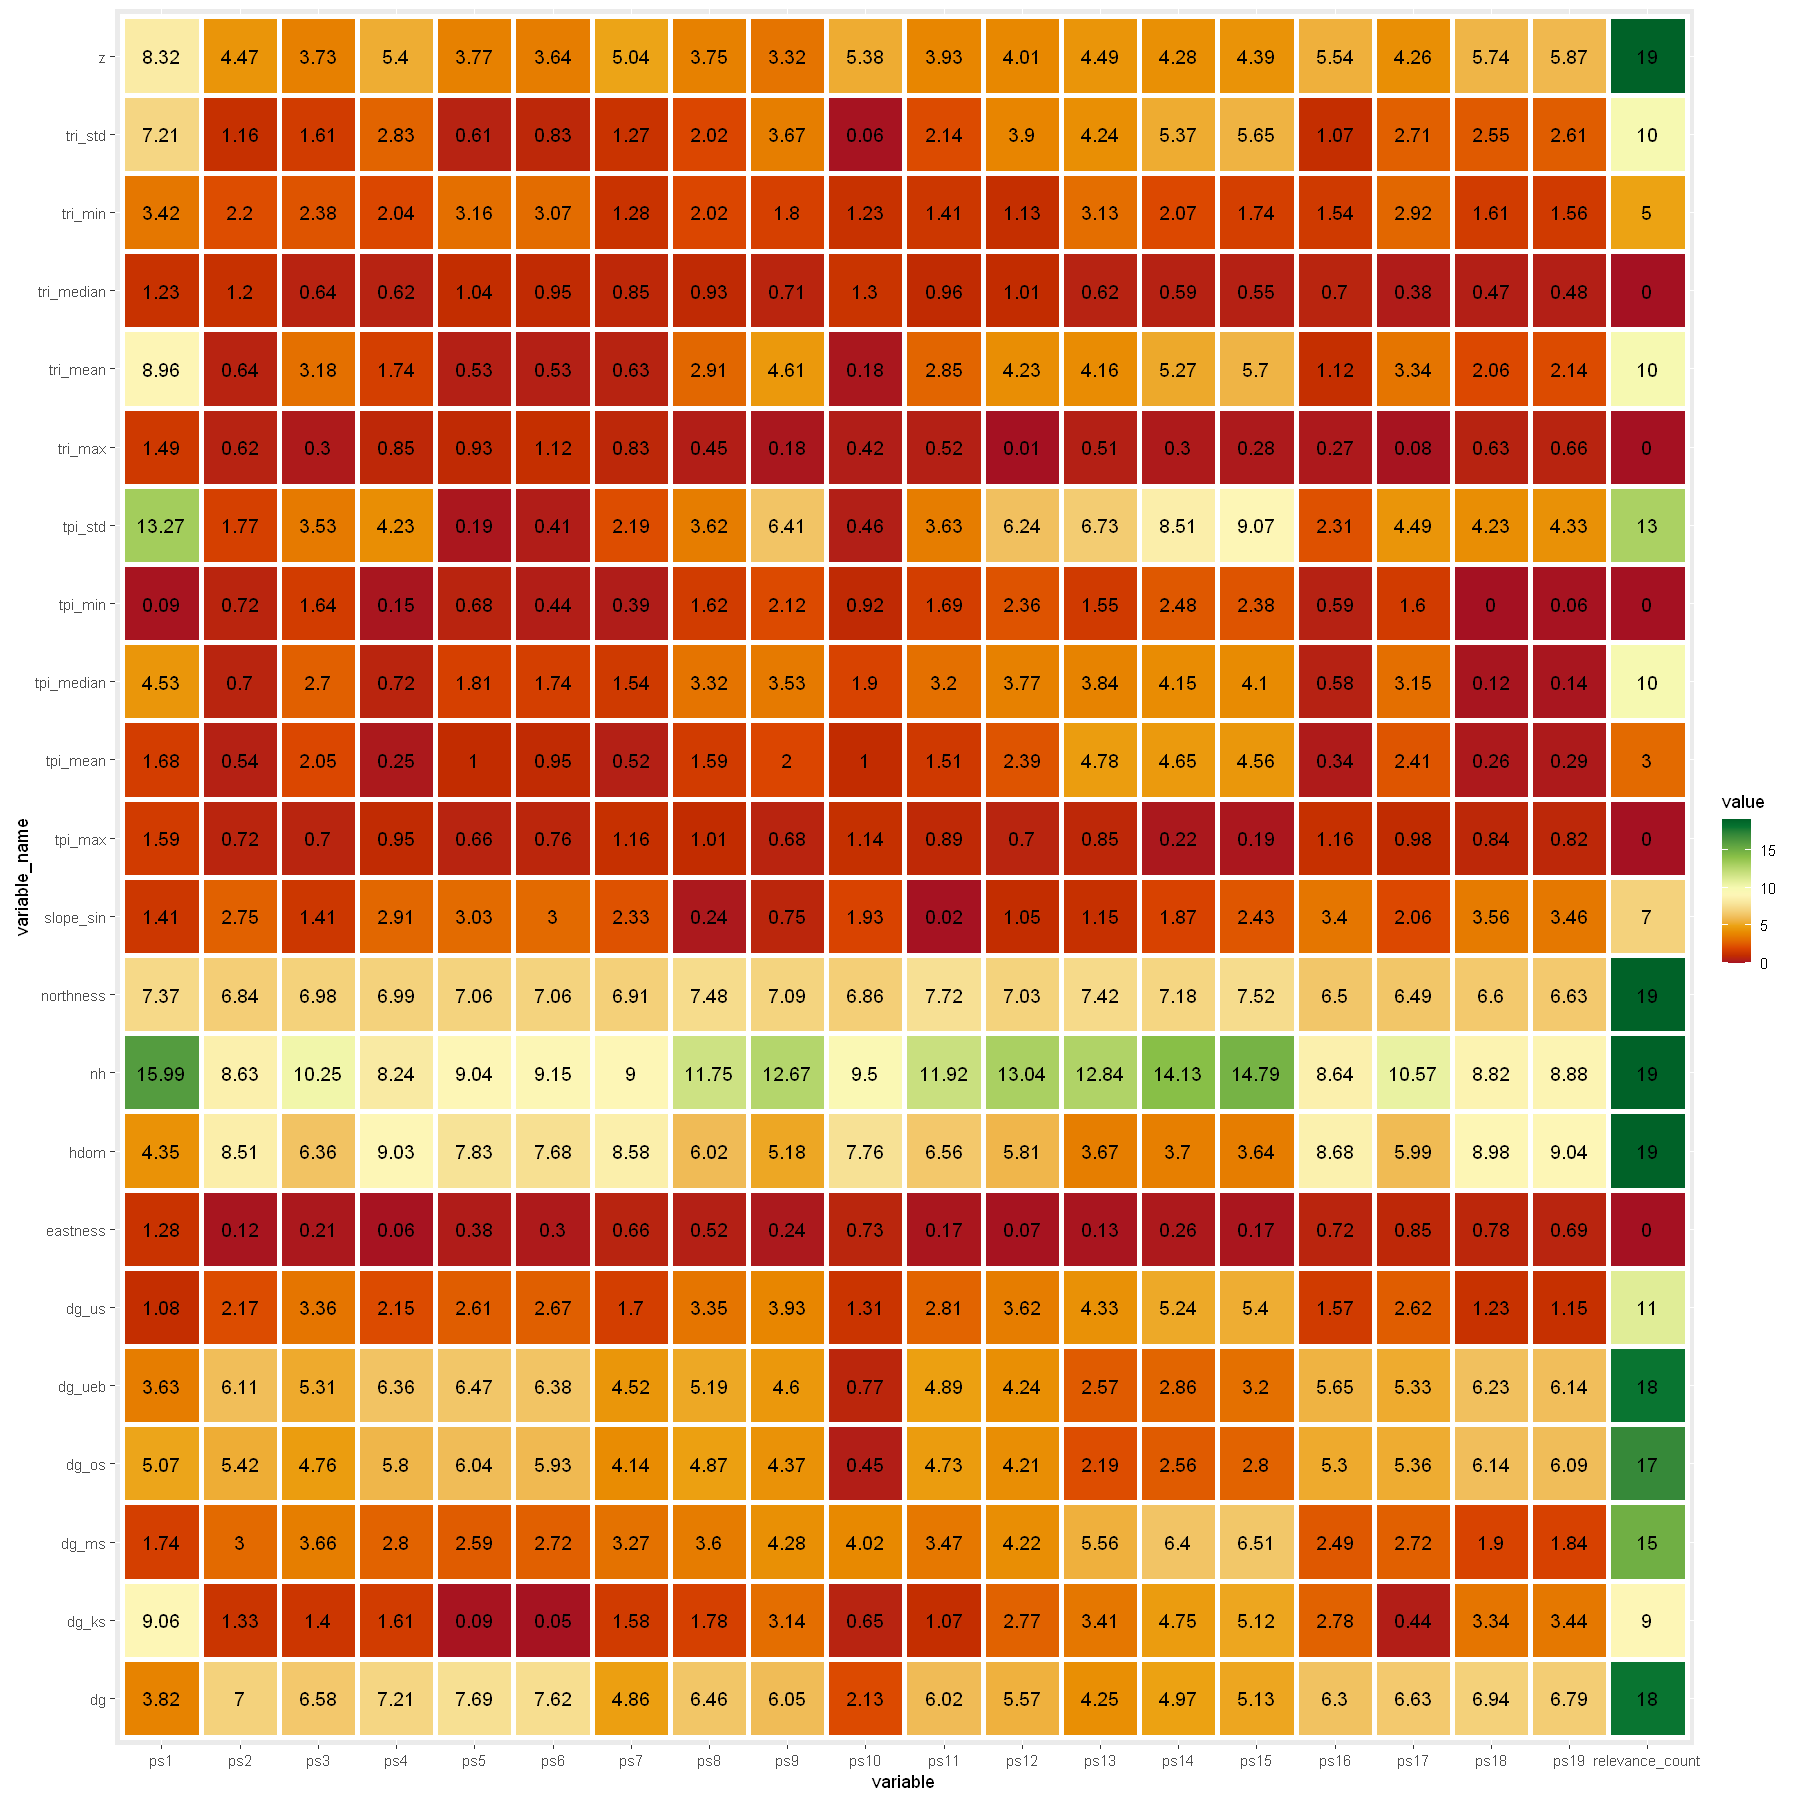

In [28]:
#Visualize the importance of the variables
options(repr.plot.width=15, repr.plot.height=15)
importance_matrix$variable_name <- rownames(importance_matrix)
importance_matrix_melt <- reshape2::melt(importance_matrix, id.vars="variable_name")
importance_matrix_melt$value <- round(importance_matrix_melt$value,2) 
ggplot(importance_matrix_melt, aes(x = variable, y = variable_name, fill = value)) +
  geom_tile(color = "white",
            lwd = 1.5,
            linetype = 1) +
  geom_text(aes(label = value), color = "black", size = 4) +
  scale_fill_gradientn(colors = hcl.colors(20, "RdYlGn")) +
  coord_fixed()

In [29]:
#Output the variables that are relevant for at least one filter 
count_threshold <- 0
rownames(importance_matrix[importance_matrix$relevance_count > count_threshold,])

[1] "slope_sin"  "northness"  "z"          "dg"         "hdom"      
 [6] "nh"         "dg_ks"      "dg_us"      "dg_ms"      "dg_os"     
[11] "dg_ueb"     "tri_min"    "tri_mean"   "tri_std"    "tpi_mean"  
[16] "tpi_median" "tpi_std"

## Generate Subsets and Calibration/Validation Partitions

In [30]:
# All plots
lfi_trees_grouped_full <- lfi_trees_grouped
partitions_all <- get_partitions("perimeter_id", data=lfi_trees_grouped_full)
lfi_trees_grouped_calibration <- lfi_trees_grouped_full[partitions_all$in_calibration,]
lfi_trees_grouped_validation <- lfi_trees_grouped_full[-partitions_all$in_calibration,]
print(c("nrow lfi_trees_grouped_full ",nrow(lfi_trees_grouped_full)))
print(c("nrow lfi_trees_grouped ",nrow(lfi_trees_grouped_calibration)))
print(c("nrow lfi_trees_grouped_validation ",nrow(lfi_trees_grouped_validation)))


# Without plots whose ALS date was acquired before 2010
lfi_trees_grouped_ss1_full <- lfi_trees_grouped_full[(lfi_trees_grouped_full$VHM_Tile_Year>=2010),]
partitions_ss1 <- get_partitions("perimeter_id", data=lfi_trees_grouped_ss1_full)
lfi_trees_grouped_ss1_calibration <- lfi_trees_grouped_ss1_full[partitions_ss1$in_calibration,]
lfi_trees_grouped_ss1_validation <- lfi_trees_grouped_ss1_full[-partitions_ss1$in_calibration,]
print(c("nrow lfi_trees_grouped_ss1_full ",nrow(lfi_trees_grouped_ss1_full)))
print(c("nrow lfi_trees_grouped_ss1 ",nrow(lfi_trees_grouped_ss1_calibration)))
print(c("nrow lfi_trees_grouped_ss1_validation ",nrow(lfi_trees_grouped_ss1_validation)))

      
# Only plots after 2010 and with a difference of less than 7 years between the ALS acquisition and the field acquisition
lfi_trees_grouped_ss2_full <- lfi_trees_grouped_full[(lfi_trees_grouped_full$VHM_Tile_Year>=2010) & (lfi_trees_grouped_full$acquisition_diff_abs<7),]
partitions_ss2 <- get_partitions("perimeter_id", data=lfi_trees_grouped_ss2_full)
lfi_trees_grouped_ss2_calibration <- lfi_trees_grouped_ss2_full[partitions_ss2$in_calibration,]
lfi_trees_grouped_ss2_validation <- lfi_trees_grouped_ss2_full[-partitions_ss2$in_calibration,]
print(c("nrow lfi_trees_grouped_ss2_full ",nrow(lfi_trees_grouped_ss2_full)))
print(c("nrow lfi_trees_grouped_ss2 ",nrow(lfi_trees_grouped_ss2_calibration)))
print(c("nrow lfi_trees_grouped_ss2_validation ",nrow(lfi_trees_grouped_ss2_validation)))


[1] "nrow lfi_trees_grouped_full " "5254"                        
[1] "nrow lfi_trees_grouped " "4206"                   
[1] "nrow lfi_trees_grouped_validation " "1048"                              
[1] "nrow lfi_trees_grouped_ss1_full " "3797"                            
[1] "nrow lfi_trees_grouped_ss1 " "3040"                       
[1] "nrow lfi_trees_grouped_ss1_validation "
[2] "757"                                   
[1] "nrow lfi_trees_grouped_ss2_full " "2676"                            
[1] "nrow lfi_trees_grouped_ss2 " "2144"                       
[1] "nrow lfi_trees_grouped_ss2_validation "
[2] "532"                                   


In [31]:
summary(lfi_trees_grouped_calibration$VHM_Tile_Year)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   2001    2005    2018    2014    2019    2020 

In [32]:
summary(lfi_trees_grouped_validation$VHM_Tile_Year)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   2001    2005    2017    2013    2019    2020 

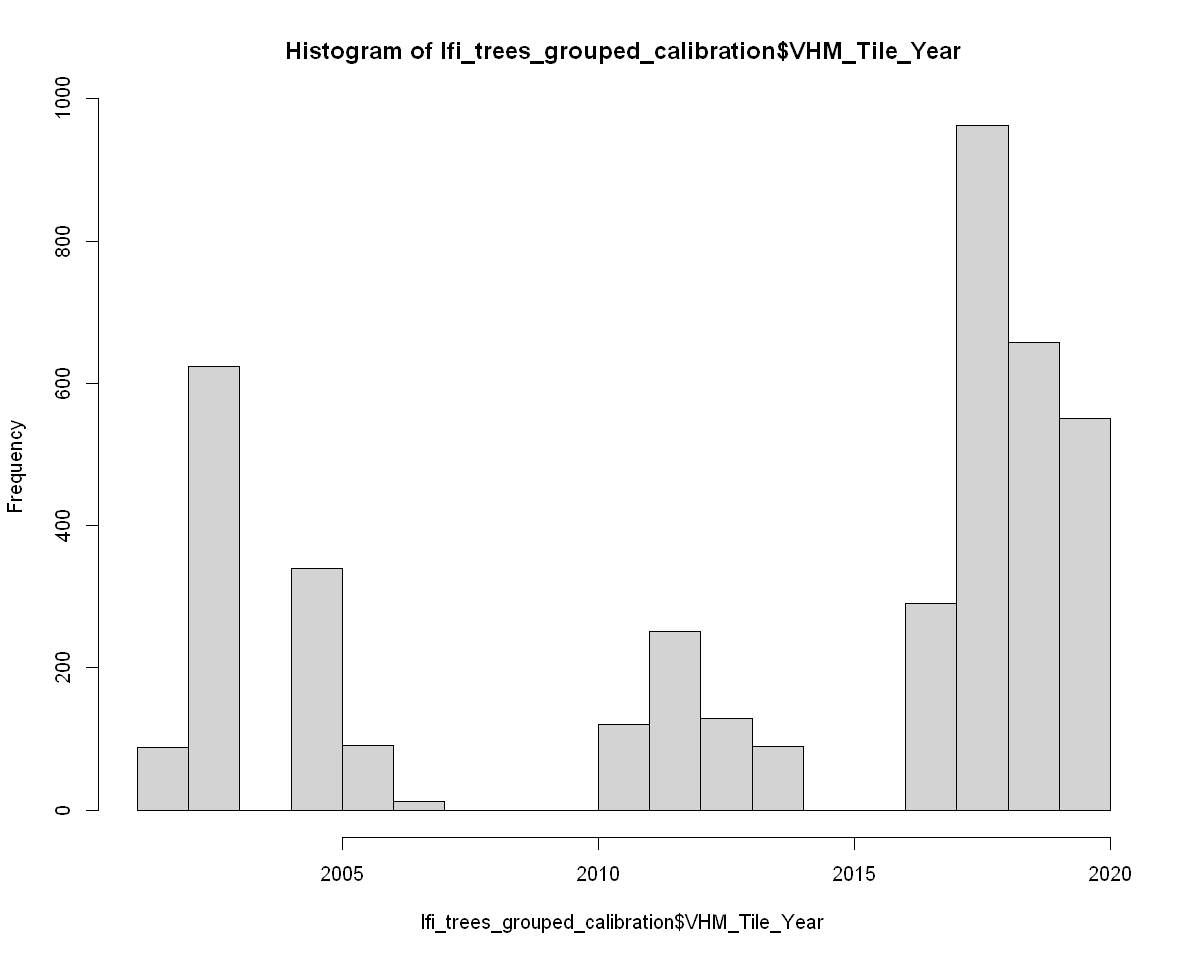

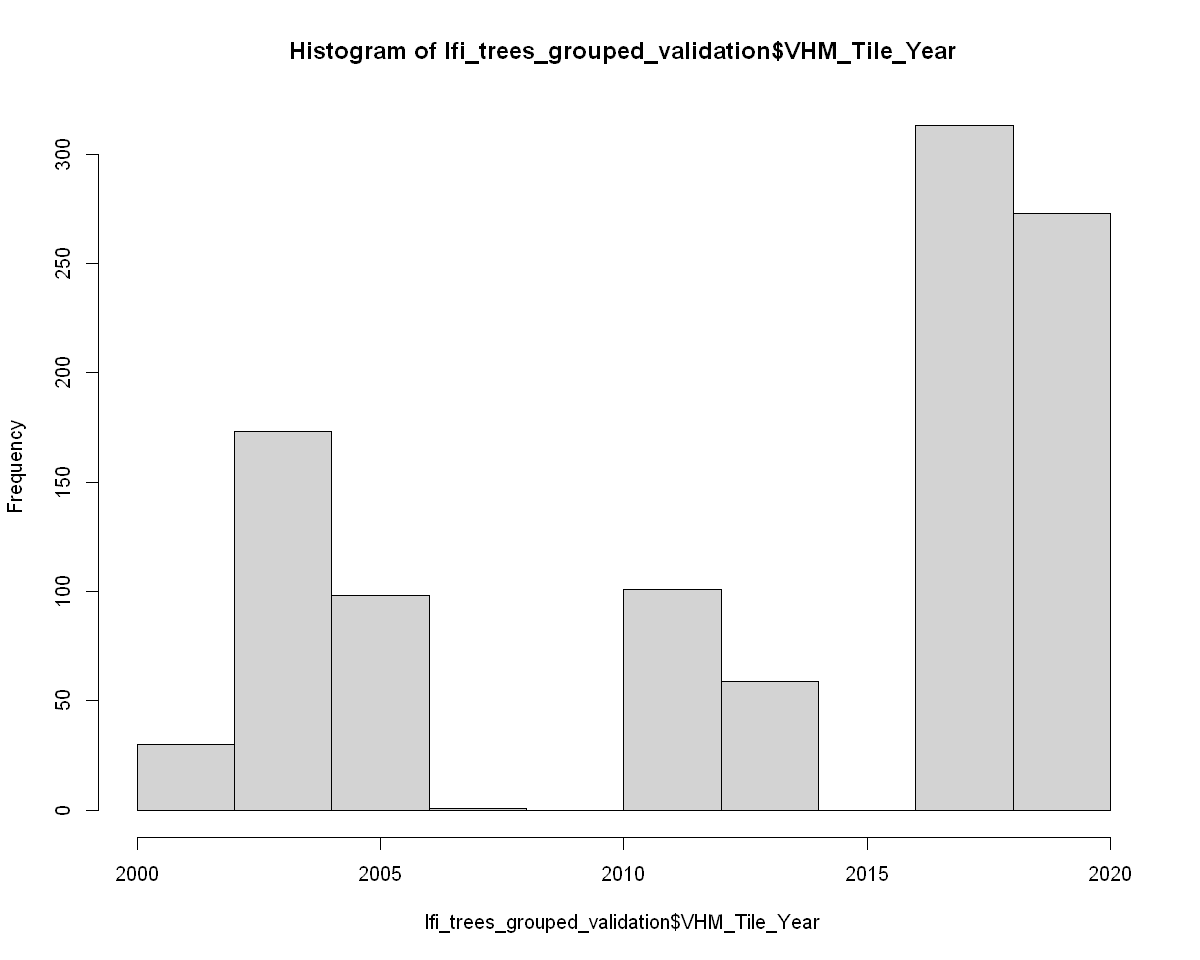

In [33]:
options(repr.plot.width=10, repr.plot.height=8)

hist(lfi_trees_grouped_calibration$VHM_Tile_Year)
hist(lfi_trees_grouped_validation$VHM_Tile_Year)

<a id="Composite_Model"></a>
## Composite Model

An attempt to integrate the composite model with caret failed. This is mostly due to the fact that handling multiply y values as input doesn't seem to be possible. Furthermore, the mox between regression and classification lite it is used here, seem also to be outside of caret's scope. Therefore two seperate methods fitting and predicting the model were created. The fitting method fintch.composite.fit() uses caret under the hood to fit a regression model for the specified classes and returns an object containing the trained models and necessary parameters for prediction. The fintch.composite.predict() method uses that fitted model object along with new input data to make the actual predictions.  

In [34]:
# Method for fitting a composite mode for the specified Date and filter methods
# x: data containing the explanatory data
# y: Data containing the error values to be used as target for the models. Must contain a column per filter method.
# targets: Vector with the numbers of the filter methods to be used in the model
# target_prefix: string prefix for the error measure to be used (e.g. "stems_in_plot_err_ps")
# cv: number of folds for training the individual error models
# method: method used to fit the error models (lm, leap, lasso, ridge, rf)
# direction: direction for leap method (forwart, backward, both)
# dynamic: whether to use stepAIC or a fixed formula for the method lm
# nvmax: max number of variables chosen by leap method
# mtry: mtry value for rf method
fintch.composite.fit <- function(x, y, targets, target_prefix, cv, method="lm", direction="forward",  dynamic=TRUE, nvmax=5, mtry=10) { 
    #Fit model per method/column in y
    models <- list()

    for(i in 1:length(targets)) {                        
        #Get taret name/method 
        target_name <-  targets[i]

        #Get corresponding column
        target_col <- paste(target_prefix, target_name, sep="")
        y_target <- y[target_col]
        
        x_calibration <- cbind(x,y_target)
        x_calibration <- x_calibration[!is.na(x_calibration[target_col]),]

        
        #Perform sequential feature selection on base learner
        control <- trainControl(method="repeatedcv", number=cv, repeats=3, allowParallel=TRUE)
        if (dynamic) {
            model_string <- paste(target_col,"~.",sep="")                                                
        } else {
             model_string <- paste(target_col,"~ slope_sin+northness+z+dg+hdom+nh+dg_ks+dg_us+dg_ms+dg_os+dg_ueb+tri_min+tri_mean+tri_std+tpi_mean+tpi_median+tpi_std",sep="")   
        }
        if (method=="lm") {
            if (dynamic) {
                modelFit <- train(formula(model_string), data = x_calibration, method = "lmStepAIC", trControl=control, direction = direction, trace = FALSE)
            } else {
                modelFit <- train(formula(model_string), data = x_calibration, method = "lm", trControl=control)
            }
        } else if (method=="leap") {
            if (direction=="forward"){
                mthd <-"leapForward"
            } else if (direction=="backward") {
                mthd<-"leapBackward"
            } else {
                mthd <- "leapSeq"
            }
            modelFit <- train(formula(model_string), data = x_calibration, method = mthd, trControl=control, tuneGrid = data.frame(nvmax = nvmax))
            # modelFit <- train(formula(model_string), data = x_calibration, method = method, trControl=control, tuneGrid = data.frame(nvmax = nvmax))
        } else if (method=="lasso") {
            modelFit<-train(formula(model_string), data = x_calibration, method = 'glmnet', tuneGrid = expand.grid(alpha = 1, lambda = 1), trControl=control) 
        } else if (method=="ridge") {
            modelFit<-train(formula(model_string), data = x_calibration, method = 'glmnet', tuneGrid = expand.grid(alpha = 0, lambda = 1), trControl=control)
        } else if (method=="rf") {
            control <- trainControl(method="none", number=1, allowParallel=TRUE)
            modelFit<-train(formula(model_string), data = x_calibration, method = 'rf', tuneGrid = expand.grid(.mtry = mtry), trControl=control)
        }     
            
        models[target_name] = list(modelFit)                        
    }

    ret <- list(models=models, target_names=targets)
    class(ret) <- "FINT_CH_CompositeModel"
    return(ret)                  
}

# Method for predicting the filter method based on a FINT_CH_CompositeModel model object
# generated by the fintch.composite.fit function.
# modelFit: FINT_CH_CompositeModel object
# newdata: data to be used for prediction
# return_raw: if TRUE, the method returns the predicted errors for all methods instead of the classes
fintch.composite.predict <- function(modelFit, newdata, return_raw=FALSE) {       
    models <- modelFit$models
    target_names <- modelFit$target_names

    predictions <- list()

    #Predict for all methods
    for(i in 1:length(target_names)) { 
        key <- target_names[i]
        clf <- models[key]
        pred <- predict(clf,newdata)
        predictions[key] <- pred
    }

    #Pick "optimal" method based on predictions

    pred_df <- as.data.frame(do.call("cbind",predictions))
    colnames(pred_df)<-target_names

    if(return_raw) {
        return(pred_df)
    }
        
    res <- apply(abs(pred_df), 1, which.min)

    ret <- colnames(pred_df)[res]
    return(ret)
}


Since caret can't be used for cross validation of the composite model, a custom function for that burpose has been created. The CV function is inspired both by caret and by sklearn. It uses a custom scoring function returning several scores for both the model itself as well as for the baseline 1m detection. Note, however, that the Earth Mover's Distance seems to be calculated slightly different so that the R values should not be directly compared with the Python values.

In [35]:
#Method for collecting raw data for more detailed scoring calculations the models in the CV functions
scoring_data_collector <- function(test_data, y, predicted_classes, input_classes=c(1,2,3,7,8,9,4,5,6,10,11,12,13,14,15,16,17,18,19))
{   
    #General values
    data_raw <- test_data[,c("flaeche_id","dg","nh","hdom","fst_dg","fst_nh","fst_hdom","density_actual","density_actual_all","nbr_trees", "nbr_trees_os")]
    label_df <- determine_min_labels(test_data, output_prefix="psx", input_classes=input_classes)
    
    #Values model
    y_pred_ind <- lapply(predicted_classes, function(x) paste("stems_per_ha_rs_ps",as.character(x),sep="")) 
    se_raw<-sapply(seq_along(y_pred_ind), function(x) test_data[x, y_pred_ind[[x]]] )
    data_raw$stems_per_ha_rs_model <- se_raw
                                   
    y_pred_ind <- lapply(predicted_classes, function(x) paste("dr_ps",as.character(x),sep=""))                  
    dr_raw <- sapply(seq_along(y_pred_ind), function(x) test_data[x, y_pred_ind[[x]]] )
    data_raw$dr_model <- dr_raw    
               
    y_pred_ind <- lapply(predicted_classes, function(x) paste("psx",as.character(x),sep="")) 
    se<-sapply(seq_along(y_pred_ind), function(x) label_df[x, y_pred_ind[[x]]] )   
    data_raw$prediction_accurate_model <- se
               
    y_pred_ind <- lapply(predicted_classes, function(x) paste("stems_in_plot_err_norm_ps",as.character(x),sep="")) 
    stems_per_ha_err_norm <- sapply(seq_along(y_pred_ind), function(x) test_data[x, y_pred_ind[[x]]] )                             
    data_raw$stems_in_plot_err_norm_model <- stems_per_ha_err_norm
                           
    y_pred_ind <- lapply(predicted_classes, function(x) paste("stems_per_ha_ps",as.character(x),sep="")) 
    stems_per_ha <- sapply(seq_along(y_pred_ind), function(x) test_data[x, y_pred_ind[[x]]] )                             
    data_raw$stems_per_ha_model <- stems_per_ha
           
    y_pred_ind <- lapply(predicted_classes, function(x) paste("stems_in_plot_ae_ps",as.character(x),sep="")) 
    stems_per_ae <- sapply(seq_along(y_pred_ind), function(x) test_data[x, y_pred_ind[[x]]] )                             
    data_raw$stems_in_plot_abs_err_model <- stems_per_ae

    y_pred_ind <- lapply(predicted_classes, function(x) paste("stems_per_ha_ae_ps",as.character(x),sep="")) 
    stems_per_ha_ae <- sapply(seq_along(y_pred_ind), function(x) test_data[x, y_pred_ind[[x]]] )                             
    data_raw$stems_per_ha_abs_err_model <- stems_per_ha_ae                               

    data_raw$stems_per_ha_abs_err_norm_model <- stems_per_ha_ae/test_data$density_actual                            

    y_pred_ind <- lapply(predicted_classes, function(x) paste("stems_per_ha_err_ps",as.character(x),sep="")) 
    stems_per_ha_err <- sapply(seq_along(y_pred_ind), function(x) test_data[x, y_pred_ind[[x]]] )                             
    data_raw$stems_per_ha_err_model <- stems_per_ha_err                               
    
    y_pred_ind <- lapply(predicted_classes, function(x) paste("stems_in_plot_err_ps",as.character(x),sep="")) 
    stems_in_plot_err <- sapply(seq_along(y_pred_ind), function(x) test_data[x, y_pred_ind[[x]]] )                             
    data_raw$stems_in_plot_err_model <- stems_in_plot_err                               
    
    y_pred_ind <- lapply(predicted_classes, function(x) paste("stems_in_plot_ps",as.character(x),sep="")) 
    stems_in_plot_model <- sapply(seq_along(y_pred_ind), function(x) test_data[x, y_pred_ind[[x]]] )                             
    data_raw$stems_in_plot_model <- stems_in_plot_model                               
                              
    return(
        list(data_raw)
    )
}
                                  
# Function for scoring a dataframe that encompasses the indicators needed for the publication
detection_scorer_raw <- function(df,group_label)
{   
    rmse <- sqrt(mean(df$stems_per_ha_rs_model))
    sd_err <- sd(df$stems_per_ha_err_model)
    rmse_norm <- sqrt(mean(df$stems_in_plot_err_norm_model^2,na.rm=TRUE))
    sd_err_norm <- sd(df$stems_in_plot_err_norm_model)
    mae_plot_model <- mean(df$stems_in_plot_abs_err_model,na.rm=TRUE)
    mae_density_model <- mean(df$stems_per_ha_abs_err_model,na.rm=TRUE)
    mae_norm_density_model <- mean(df$stems_per_ha_abs_err_norm_model,na.rm=TRUE)
    median_ae_norm_density_model <- median(df$stems_per_ha_abs_err_norm_model,na.rm=TRUE)
    mean_err_model <- mean(df$stems_per_ha_err_model,na.rm=TRUE)
    median_err_model <- median(df$stems_per_ha_err_model,na.rm=TRUE)
     
    dr_mean_model <- mean(df$dr_model)
    dr_median_model <- median(df$dr_model)

    r2_model <- R2(as.numeric(df$density_actual),as.numeric(df$stems_per_ha_model))
    bias_model <- bias(as.numeric(df$density_actual),as.numeric(df$stems_per_ha_model))
    
    acc_adjusted_model <- sum(df$prediction_accurate_model)/length(df$prediction_accurate_model)
    
    cnt <- nrow(df)

    return ( data.frame(group=group_label, rmse=rmse, rmse_norm=rmse_norm, mae_plot_model=mae_plot_model, mae_density_model=mae_density_model, 
                        mae_norm_density_model=mae_norm_density_model, median_ae_norm_density_model=median_ae_norm_density_model, 
                        mean_err_model=mean_err_model, median_err_model=median_err_model,sd_err=sd_err, sd_err_norm=sd_err_norm,  dr_mean_model=dr_mean_model, dr_median_model=dr_median_model,
                        r2_model=r2_model, bias_model=bias_model,
                        acc_adjusted_model=acc_adjusted_model,
                        
                        count = cnt))  
}

# Function for scoring a dataframe based on several different groupings an criteria
score_individual_df <- function(cv_result, scoring_df, group_label, partition_label = "all") {
    res <- NA
    
    all_model_label <- "All Models"
    mae_best_model_label <- "MAE Best Model"
    
    # All results
    all_plots_group_label <- "a) All plots"
    df_validation <- concat_scoring_data_simple(scoring_df)
    res <- detection_scorer_raw(df_validation,paste(group_label,partition_label,sep=" "))
    res$model <- all_model_label
    res$subgroup <- all_plots_group_label
        
    # MAE best
    best_mae <- which.min(cv_result$scores$mae_density_model)
    df_validation <- scoring_df[[best_mae]]
    scr_tmp <- detection_scorer_raw(df_validation,paste(group_label,partition_label,sep=" "))
    scr_tmp$model <- mae_best_model_label
    scr_tmp$subgroup <- all_plots_group_label
    res <- rbind(res,scr_tmp)
    
    #By NH
    nh_group_labels <- nh_lookup_labels$val
    for (i in 1:3) {
        group <- "fst_nh"
        # All results
        df_validation <- concat_scoring_data_group_all(scoring_df,group,i)        
        scr_tmp <- detection_scorer_raw(df_validation,paste(group_label,partition_label,sep=" "))
        scr_tmp$model <- all_model_label
        scr_tmp$subgroup <- nh_group_labels[i]        
        res <- rbind(res,scr_tmp)

        # MAE best
        best_mae <- which.min(cv_result$scores$mae_density_model)
        df_validation <- concat_scoring_data_group_all(scoring_df[best_mae],group,i) 
        scr_tmp <- detection_scorer_raw(df_validation,paste(group_label,partition_label,sep=" "))
        scr_tmp$model <- mae_best_model_label
        scr_tmp$subgroup <- nh_group_labels[i]
        res <- rbind(res,scr_tmp)
    }
    
    #By DG
    dg_group_labels <- dg_lookup_labels$val
    for (i in 1:2) {
        group <- "fst_dg"
        # All results
        df_validation <- concat_scoring_data_group_all(scoring_df,group,i)
        scr_tmp <- detection_scorer_raw(df_validation,paste(group_label,partition_label,sep=" "))
        scr_tmp$model <- all_model_label
        scr_tmp$subgroup <- dg_group_labels[i]
        res <- rbind(res,scr_tmp)
        
        # MAE best
        best_mae <- which.min(cv_result$scores$mae_density_model)
        df_validation <- concat_scoring_data_group_all(scoring_df[best_mae],group,i) 
        scr_tmp <- detection_scorer_raw(df_validation,paste(group_label,partition_label,sep=" "))
        scr_tmp$model <- mae_best_model_label
        scr_tmp$subgroup <- dg_group_labels[i]
        res <- rbind(res,scr_tmp)
    }
    
    #By HDOM
    hdom_group_labels <- hdom_lookup_labels$val
    for (i in 1:2) {
        group <- "fst_hdom"
        # All results
        df_validation <- concat_scoring_data_group_all(scoring_df,group,i)
        scr_tmp <- detection_scorer_raw(df_validation,paste(group_label,partition_label,sep=" "))
        scr_tmp$model <- all_model_label
        scr_tmp$subgroup <- hdom_group_labels[i]
        res <- rbind(res,scr_tmp)
        
        # MAE best
        best_mae <- which.min(cv_result$scores$mae_density_model)
        df_validation <- concat_scoring_data_group_all(scoring_df[best_mae],group,i) 
        scr_tmp <- detection_scorer_raw(df_validation,paste(group_label,partition_label,sep=" "))
        scr_tmp$model <- mae_best_model_label
        scr_tmp$subgroup <- hdom_group_labels[i]
        res <- rbind(res,scr_tmp)
        
    }
    
    
    res$group <- group_label
    res$partition <- partition_label
    return(res)
}

#Function for formatting specific indicators in a way suitable for the publication
score_df_pub <- function(cv_result, df, label, subgroup_label = "all", filter=FALSE, cols= NULL) {
    res <- score_individual_df(cv_result, df, label, subgroup_label)
    
    if(filter) {
        res <- res[grepl( "MAE ", res$group, fixed = TRUE) & grepl( paste(subgroup_label,";", sep=" "), res$group, fixed = TRUE) ,]
    }
    
    res$rmse <- round(res$rmse)
    res$rmse_norm <- round(res$rmse_norm,1)
    res$mae_density_model <- round(res$mae_density_model)
    res$mae_norm_density_model <- round(res$mae_norm_density_model,2)
    res$median_ae_norm_density_model <- round(res$median_ae_norm_density_model,2)    
    res$mae_plot_model <- round(res$mae_plot_model)
    res$mean_err_model <- round(res$mean_err_model,2)
    res$median_err_model <- round(res$median_err_model,2)
    res$dr_mean_model <- round(res$dr_mean_model,2)
    res$dr_median_model <- round(res$dr_median_model,2)
    res$r2_model <- round(res$r2_model,4)
    res$bias_model <- round(res$bias_model,4)
    res$acc_adjusted_model <- round(100*res$acc_adjusted_model)
    
    if (!is.null(cols)){
        res <- res[,cols]
    }
        
    return(res)
}

#Function for structuring the scoring results in a way that is easily transferred to the publication 
structure_pub_table <- function(score_dfs, source_names, filter_model = NULL, filter_group = NULL, filter_subgroup = NULL, filter_partition = NULL) {
    score_cols_model <- c("group", "subgroup", "partition", "count", "model", "mae_density_model", "median_ae_norm_density_model", "dr_mean_model", "dr_median_model")

    score_cols_modified <- c("Grouping", "Group", "Partition", "n_plots", "Model", "MAE_N", "MedAE_norm",  "dr_mean", "dr_median")
    score_cols_output <- c("Grouping", "Partition", "Group", "n_plots", "Source", "MAE_N", "MedAE_norm",  "dr_mean", "dr_median")

    res <- NA
    
    for(i in 1:length(score_dfs)){
        df <- score_dfs[[i]]
        source_name <- source_names[[i]]

        #Correct the count for lines with results from all 10 CV models 
        df[df$model=="All Models",]$count <- df[df$model=="All Models",]$count/10

        df <- df[,score_cols_model]
        names(df) <- score_cols_modified
        df$Source <- source_name
        
        res <- rbind(res,df)
    }
    
#     #Model results
#     score_df_model <- score_df[,score_cols_model]
#     names(score_df_model) <- score_cols_modified
#     score_df_model$Source <- "Model"
#     #Baseline results
#     score_df_baseline <- score_df[,score_cols_baseline]
#     names(score_df_baseline) <- score_cols_modified
#     score_df_baseline$Source <- "Baseline"

    res <- res[!is.na(res$Partition),]
    
    
    if (!is.null(filter_group)){
        res <- res[res$Grouping==filter_group,]
    }
    if (!is.null(filter_subgroup)){
        res <- res[res$Group==filter_subgroup,]
    }
    if (!is.null(filter_model)){
        res <- res[res$Model==filter_model,]
    }
    if (!is.null(filter_partition)){
        res <- res[res$Partition==filter_partition,]
    }
    
    return(res[order(res$Grouping,res$Group),score_cols_output])
}



In [36]:
# Function to returning scores based on the detection_scorer for a data set and a single trained composite model. 
fintch_composite_score <- function(model, scoring_in, detection_column_index = NA, y_column="parameterset_min") {
         
    #Predict and score model
    if(is.na(detection_column_index)){
        prediction <- fintch.composite.predict(modelFit=model,newdata=scoring_in)
        classes = model$target_names
    } else {
        prediction <- rep(detection_column_index, nrow(scoring_in))
        classes = c(1,detection_column_index)
    }
    
    y <- scoring_in[,y_column]

    scoring_data <- scoring_data_collector(scoring_in, y, prediction, input_classes=classes)
#     scores <- detection_scorer(scoring_in, y, prediction,input_classes=classes)   
    scores <- detection_scorer_raw(scoring_data[[1]],"all")

    return(list(scores=scores, scoring_data=scoring_data))
}



# Function to returning scores based on the detection_scorer for a data set and multiple trained composite model. 
fintch_composite_score_multi <- function(models, scoring_in, detection_column_index = NA, y_column="parameterset_min") {
    
    n_fold <- nrow(models)
    
    #Create empty df with structure for scoring function
    scores <- rep(NA, n_fold)
    scores <- NA
    scoring_data <- rep(NA, n_fold)
                     
    #Fit and score model for wach fold
    for (i in 1:n_fold) {
        model_comp_dyn <- models[i,]
                        
        #Predict and score model
        tmp_scores <- fintch_composite_score(model_comp_dyn, scoring_in, detection_column_index=detection_column_index, y_column=y_column)  
        
#         scores[i,] <- tmp_scores$scores
        scores <- rbind(scores,tmp_scores$scores)
        scoring_data[i] <- tmp_scores$scoring_data

    }
    return(list(scores=scores, scoring_data=scoring_data))
}



In [37]:
#Helper functions for handling scoring results during analysis
concat_scoring_data <- function(df,col) { return(do.call(rbind,lapply(df, function(l) l[col]))) }
concat_scoring_data_group <- function(df,col,group,group_value) { return(do.call(rbind,lapply(df, function(l) l[l[,group]==group_value,][col]))) } 
concat_scoring_data_group_all <- function(df,group,group_value) { return(do.call(rbind,lapply(df, function(l) l[l[,group]==group_value,]))) } 
concat_scoring_data_by_fold <- function(df_calibration,df_validation,col,SEL) {
    n_fold <- length(df_calibration)
    res <- rep(NA,n_fold)
    for(i in 1:n_fold) {
        res[i] <- list(rbind(df_calibration[[i]][SEL(df_calibration[[i]]),][col],df_validation[[i]][SEL(df_validation[[i]]),][col]))
    }
    
    return(res)
}
                                                                                              
concat_scoring_data_simple <- function(df) {return(do.call(rbind,lapply(df, function(l) l)))}
                                                                                              
select_by_group <- function(df,group,group_value) {return(df[,group]==group_value)} 

                                                                               

In [38]:
# Function to perform cross validation with the composite model returning scores based on the detection_scorer. 
# Most of the parameters are passed through for the fitting method

# x_columns: vector of strings specifying the explanatory variables of the model
# classes: vector with the numbers of the filter methods to be used as targets/y-columns in the model
# data: dataset to be used
# n_fold: number of folds for the cv
# y_column: name of the column with the minimal class used for the accuracy measure when scoring (less relevant here as the adjusted accuracy is of actual interest)
# fold_column: name of the column used as input to generate the folds
# random_state: seed value set before generating the folds
# target_prefix: string prefix for the error measure to be used (e.g. "stems_in_plot_err_ps")
# cv: number of folds for training the individual error models
# selection: how the best class is selected during prediction (min, max, abs_min, abs_max)
# method: method used to fit the error models (lm, leap, lasso, ridge)
# direction: direction for leap method (forwart, backward, both)
# weights: weights used when choosing best method during prediction
# dynamic: whether to use stepAIC or a fixed formula for the method lm
# nvmax: max number of variables chosen by leap method
# transform: Whether to log10 transform the target variable (not recommended)

fintch_composite_cv <- function(x_columns, classes=c(1,2,7,8,10,16,19), data=lfi_trees_grouped_calibration, target_prefix="stems_per_ha_err_ps", dynamic=TRUE, method="lm", direction="forward", nvmax=5, mtry=5, n_fold=10, y_column="parameterset_min", fold_column="perimeter_id",  random_state=42) {
    #Create empty df with structure for scoring function
    train_scores <- rep(NA, n_fold)
    test_scores <- rep(NA, n_fold)
    train_scoring_data <- rep(NA, n_fold)
    test_scoring_data <- rep(NA, n_fold)
    train_samples <- rep(NA, n_fold)
    test_samples <- rep(NA, n_fold)

    #Create folds
    set.seed(random_state) 
    folds <- createFolds(data[,fold_column], k = n_fold, list = FALSE)

    #Determine inputs
    targets <- sapply(classes,function(x)  paste(target_prefix,as.character(x),sep=""))
    labels <- sapply(classes,function(x)  paste("ps",as.character(x),sep=""))

    train_cv <- 10
                     
    models <- list()
                     
    #Fit and score model for each fold
    for (i in 1:n_fold) {
        #get indexes for fold i
        training_samples <- !(folds == i)
        
        train_samples[i] <- list(training_samples)
        test_samples[i] <- list(!training_samples)

        #split training and test date based on indexes
        train_data <- data[training_samples,]
        test_data <- data[!training_samples,]

        x_calibration<-train_data[x_columns]
        y_calibration<-train_data[targets]
        
        #Train model
        model_comp_dyn <- fintch.composite.fit(x_calibration, y_calibration, classes, target_prefix, train_cv, method=method, dynamic=dynamic, direction=direction, nvmax=nvmax,  mtry=mtry)
        models <- rbind(models, c(model_comp_dyn))
              
    }
                     
    test_scores <- fintch_composite_score_multi(model=models, scoring_in = test_data) 
    train_scores <- fintch_composite_score_multi(model=models, scoring_in = train_data) 


    return(list(scores=test_scores$scores,scores_calibration=train_scores$scores, models=models, scoring_data=test_scores$scoring_data, scoring_data_calibration=train_scores$scoring_data, train_samples=train_samples, test_samples=test_samples ))
}

<a id="Final_Model_Analysis"></a>
## Final Model Analysis

In [39]:
# Colums shown in output
score_cols <- c("group", "partition", "subgroup", "model", "count", "mae_density_model", "mae_norm_density_model", "median_ae_norm_density_model", "dr_mean_model", "dr_median_model", "r2_model", "bias_model"
                # ,"mae_density_baseline",  "mae_norm_density_baseline", "median_ae_norm_density_baseline",  "dr_mean_baseline", "dr_median_baseline", "r2_baseline", "bias_baseline"
               )

In [40]:
#Counts per NH class
# All plots
data <- lfi_trees_grouped_validation
tapply(data$fst_nh, data$fst_nh, summary)

$`1`
  1   2   3 
371   0   0 

$`2`
  1   2   3 
  0 199   0 

$`3`
  1   2   3 
  0   0 478

In [41]:
#Counts per NH class
# Without plots whose ALS date was acquired before 2010
data <- lfi_trees_grouped_ss1_validation
tapply(data$fst_nh, data$fst_nh, summary)

$`1`
  1   2   3 
315   0   0 

$`2`
  1   2   3 
  0 152   0 

$`3`
  1   2   3 
  0   0 290

In [42]:
#Counts per NH class
# Only plots after 2010 and with a difference of less than 7 years between the ALS acquisition and the field acquisition
data <- lfi_trees_grouped_ss2_validation
tapply(data$fst_nh, data$fst_nh, summary)

$`1`
  1   2   3 
220   0   0 

$`2`
  1   2   3 
  0 108   0 

$`3`
  1   2   3 
  0   0 204

In [43]:
#Calibrating the models per sub-set

# All plots
data <- lfi_trees_grouped_calibration
print(nrow(data))
scores_all <- fintch_composite_cv(cols_complete, classes=classes, data=data, target_prefix=target_prefix, dynamic=dynamic, method=method, n_fold=10, y_column="parameterset_min", fold_column="perimeter_id") 

# Without plots whose ALS date was acquired before 2010
data <- lfi_trees_grouped_ss1_calibration 
print(nrow(data))
scores_ss1 <- fintch_composite_cv(cols_complete, classes=classes, data=data, target_prefix=target_prefix, dynamic=dynamic, method=method, n_fold=10, y_column="parameterset_min", fold_column="perimeter_id") 

# Only plots after 2010 and with a difference of less than 7 years between the ALS acquisition and the field acquisition
data <- lfi_trees_grouped_ss2_calibration
print(nrow(data))
scores_ss2 <- fintch_composite_cv(cols_complete, classes=classes, data=data, target_prefix=target_prefix, dynamic=dynamic, method=method, n_fold=10, y_column="parameterset_min", fold_column="perimeter_id") 


[1] 4206
[1] 3040
[1] 2144


In [44]:
colnames(scores_ss2$scores)

[1] "group"                        "rmse"                        
 [3] "rmse_norm"                    "mae_plot_model"              
 [5] "mae_density_model"            "mae_norm_density_model"      
 [7] "median_ae_norm_density_model" "mean_err_model"              
 [9] "median_err_model"             "sd_err"                      
[11] "sd_err_norm"                  "dr_mean_model"               
[13] "dr_median_model"              "r2_model"                    
[15] "bias_model"                   "acc_adjusted_model"          
[17] "count"

In [45]:
# Determine the best model from the 10-fold cross-validation for the second subset based on the MAE
min_mae_index <- which.min(scores_ss2$scores$mae_density_model)
min_model <- scores_ss2$models[min_mae_index,]
save(min_model, file = "fint_ch_min_model.rda")


In [46]:
#Output linear regression formulas (e.g. as basis for implementing the model in code)
gather_model_equations(min_model$models,classes,target_prefix, digits=3)

[,1]                                                                                                                                                                                                                                                                                                                                                                               
model_formula stems_in_plot_err_ps1 = - 5.93737 - 1.00065 * slope_sin - 1.73332 * northness + 0.00355 * z - 0.13847 * dg + 0.11283 * hdom + 0.04834 * nh + 0.07441 * dg_ks - 0.15581 * dg_us - 0.20537 * dg_ms + 0.05453 * dg_os - 0.02566 * dg_ueb + 0.69362 * tri_min + 1.05646 * tri_mean + 0.81363 * tri_std - 1.81533 * tpi_mean + 3.33812 * tpi_median - 6.24302 * tpi_std                 
model_formula stems_in_plot_err_ps2 = 8.854842 + 0.941994 * slope_sin - 0.986677 * northness + 0.000855 * z - 0.162626 * dg + 0.114188 * hdom + 0.013416 * nh - 0.077395 * dg_ks - 0.154766 * dg_us - 0.167519 * dg_ms + 0.080285 * dg_os + 0.080123 * dg_ueb - 0.027241 * tri_min + 0.122956 * tri_mean + 0.156306 * tri_std - 0.299904 * tpi_mean - 0.647258 * tpi_median - 1.467872 * tpi_std 
model_formula stems_in_plot_err_ps3 = 9.673274 + 0.620192 * slope_sin - 1.022862 * northness + 0.000532 * z - 0.140224 * dg + 0.083866 * hdom + 0.017607 * nh - 0.082540 * dg_ks - 0.131672 * dg_us - 0.142567 * dg_ms + 0.085869 * dg_os + 0.108550 * dg_ueb + 0.007336 * tri_min - 0.212636 * tri_mean - 0.098341 * tri_std + 0.678207 * tpi_mean - 1.608528 * tpi_median + 0.289127 * tpi_std 
model_formula stems_in_plot_err_ps7 = 5.44858 + 1.01198 * slope_sin - 1.11330 * northness + 0.00101 * z - 0.13274 * dg + 0.10768 * hdom + 0.01503 * nh - 0.04812 * dg_ks - 0.11818 * dg_us - 0.13869 * dg_ms + 0.07817 * dg_os + 0.08734 * dg_ueb + 0.09928 * tri_min + 0.16131 * tri_mean + 0.24754 * tri_std - 0.55687 * tpi_mean - 0.93551 * tpi_median - 1.86365 * tpi_std                   
model_formula stems_in_plot_err_ps8 = 6.975083 + 0.283329 * slope_sin - 1.135929 * northness + 0.000546 * z - 0.144123 * dg + 0.077011 * hdom + 0.021854 * nh - 0.056519 * dg_ks - 0.095535 * dg_us - 0.107067 * dg_ms + 0.128028 * dg_os + 0.143386 * dg_ueb + 0.088839 * tri_min - 0.242841 * tri_mean - 0.128644 * tri_std + 0.378896 * tpi_mean - 2.083775 * tpi_median + 0.418483 * tpi_std 
model_formula stems_in_plot_err_ps9 = 3.664256 - 0.066216 * slope_sin - 1.048137 * northness + 0.000389 * z - 0.135424 * dg + 0.062350 * hdom + 0.024166 * nh - 0.019668 * dg_ks - 0.048056 * dg_us - 0.061465 * dg_ms + 0.171746 * dg_os + 0.195131 * dg_ueb + 0.131016 * tri_min - 0.412339 * tri_mean - 0.303384 * tri_std + 0.638890 * tpi_mean - 2.136567 * tpi_median + 1.490347 * tpi_std 
model_formula stems_in_plot_err_ps10 = 7.07810 + 0.90430 * slope_sin - 0.90059 * northness + 0.00116 * z - 0.04121 * dg + 0.09623 * hdom + 0.01709 * nh - 0.06669 * dg_ks - 0.10994 * dg_us - 0.14829 * dg_ms - 0.02810 * dg_os - 0.01296 * dg_ueb + 0.08811 * tri_min + 0.06612 * tri_mean + 0.22182 * tri_std - 0.49877 * tpi_mean - 1.03520 * tpi_median - 1.52463 * tpi_std                  
model_formula stems_in_plot_err_ps11 = 6.441768 + 0.274672 * slope_sin - 1.192526 * northness + 0.000586 * z - 0.140537 * dg + 0.077540 * hdom + 0.023872 * nh - 0.048476 * dg_ks - 0.086814 * dg_us - 0.103354 * dg_ms + 0.128720 * dg_os + 0.143338 * dg_ueb + 0.105840 * tri_min - 0.210288 * tri_mean - 0.101580 * tri_std + 0.213251 * tpi_mean - 1.993550 * tpi_median + 0.193647 * tpi_std
model_formula stems_in_plot_err_ps12 = 1.781122 - 0.016418 * slope_sin - 1.130587 * northness + 0.000539 * z - 0.126320 * dg + 0.069667 * hdom + 0.025915 * nh - 0.002189 * dg_ks - 0.028032 * dg_us - 0.042734 * dg_ms + 0.181866 * dg_os + 0.198868 * dg_ueb + 0.109994 * tri_min - 0.370158 * tri_mean - 0.268399 * tri_std + 1.024765 * tpi_mean - 2.020171 * tpi_median + 1.206217 * tpi_std
model_formula stems_in_plot_err_ps19 = 0.10441 + 1.00412 * slope_sin - 1.15901 * northness + 0.00145 * z - 0.15592 * dg + 0.14080 * hdom + 0.01410 * nh - 

In [47]:
#Generate basic scores for data subsets
scores_all_calibration <- fintch_composite_score_multi(model=scores_all$models, scoring_in = lfi_trees_grouped_calibration) 
scores_all_validation <- fintch_composite_score_multi(model=scores_all$models, scoring_in = lfi_trees_grouped_validation) 
scores_all_all <- fintch_composite_score_multi(model=scores_all$models, scoring_in = lfi_trees_grouped_full) 

scores_ss1_calibration <- fintch_composite_score_multi(model=scores_ss1$models, scoring_in = lfi_trees_grouped_ss1_calibration) 
scores_ss1_validation <- fintch_composite_score_multi(model=scores_ss1$models, scoring_in = lfi_trees_grouped_ss1_validation) 
scores_ss1_all <- fintch_composite_score_multi(model=scores_ss1$models, scoring_in = lfi_trees_grouped_ss1_full) 

scores_ss2_calibration <- fintch_composite_score_multi(model=scores_ss2$models, scoring_in = lfi_trees_grouped_ss2_calibration) 
scores_ss2_validation <- fintch_composite_score_multi(model=scores_ss2$models, scoring_in = lfi_trees_grouped_ss2_validation) 
scores_ss2_all <- fintch_composite_score_multi(model=scores_ss2$models, scoring_in = lfi_trees_grouped_ss2_full) 


In [48]:
#Generate basic scores for data subsets
scores_all_calibration_baseline <- fintch_composite_score_multi(model=scores_all$models, scoring_in = lfi_trees_grouped_calibration, detection_column_index = 1) 
scores_all_validation_baseline <- fintch_composite_score_multi(model=scores_all$models, scoring_in = lfi_trees_grouped_validation, detection_column_index = 1) 
scores_all_all_baseline <- fintch_composite_score_multi(model=scores_all$models, scoring_in = lfi_trees_grouped_full, detection_column_index = 1) 

scores_ss1_calibration_baseline <- fintch_composite_score_multi(model=scores_ss1$models, scoring_in = lfi_trees_grouped_ss1_calibration, detection_column_index = 1) 
scores_ss1_validation_baseline <- fintch_composite_score_multi(model=scores_ss1$models, scoring_in = lfi_trees_grouped_ss1_validation, detection_column_index = 1) 
scores_ss1_all_baseline <- fintch_composite_score_multi(model=scores_ss1$models, scoring_in = lfi_trees_grouped_ss1_full, detection_column_index = 1) 

scores_ss2_calibration_baseline <- fintch_composite_score_multi(model=scores_ss2$models, scoring_in = lfi_trees_grouped_ss2_calibration, detection_column_index = 1) 
scores_ss2_validation_baseline <- fintch_composite_score_multi(model=scores_ss2$models, scoring_in = lfi_trees_grouped_ss2_validation, detection_column_index = 1) 
scores_ss2_all_baseline <- fintch_composite_score_multi(model=scores_ss2$models, scoring_in = lfi_trees_grouped_ss2_full, detection_column_index = 1) 


In [49]:
#Generate basic scores for data subsets
scores_all_calibration_eysn <- fintch_composite_score_multi(model=scores_all$models, scoring_in = lfi_trees_grouped_calibration, detection_column_index = 30) 
scores_all_validation_eysn <- fintch_composite_score_multi(model=scores_all$models, scoring_in = lfi_trees_grouped_validation, detection_column_index = 30) 
scores_all_all_eysn <- fintch_composite_score_multi(model=scores_all$models, scoring_in = lfi_trees_grouped_full, detection_column_index = 30) 

scores_ss1_calibration_eysn <- fintch_composite_score_multi(model=scores_ss1$models, scoring_in = lfi_trees_grouped_ss1_calibration, detection_column_index = 30) 
scores_ss1_validation_eysn <- fintch_composite_score_multi(model=scores_ss1$models, scoring_in = lfi_trees_grouped_ss1_validation, detection_column_index = 30) 
scores_ss1_all_eysn <- fintch_composite_score_multi(model=scores_ss1$models, scoring_in = lfi_trees_grouped_ss1_full, detection_column_index = 30) 

scores_ss2_calibration_eysn <- fintch_composite_score_multi(model=scores_ss2$models, scoring_in = lfi_trees_grouped_ss2_calibration, detection_column_index = 30) 
scores_ss2_validation_eysn <- fintch_composite_score_multi(model=scores_ss2$models, scoring_in = lfi_trees_grouped_ss2_validation, detection_column_index = 30) 
scores_ss2_all_eysn <- fintch_composite_score_multi(model=scores_ss2$models, scoring_in = lfi_trees_grouped_ss2_full, detection_column_index = 30) 


In [50]:
#Generate basic scores for data subsets
scores_all_calibration_kaartinen <- fintch_composite_score_multi(model=scores_all$models, scoring_in = lfi_trees_grouped_calibration, detection_column_index = 31) 
scores_all_validation_kaartinen <- fintch_composite_score_multi(model=scores_all$models, scoring_in = lfi_trees_grouped_validation, detection_column_index = 31) 
scores_all_all_kaartinen <- fintch_composite_score_multi(model=scores_all$models, scoring_in = lfi_trees_grouped_full, detection_column_index = 31) 

scores_ss1_calibration_kaartinen <- fintch_composite_score_multi(model=scores_ss1$models, scoring_in = lfi_trees_grouped_ss1_calibration, detection_column_index = 31) 
scores_ss1_validation_kaartinen <- fintch_composite_score_multi(model=scores_ss1$models, scoring_in = lfi_trees_grouped_ss1_validation, detection_column_index = 31) 
scores_ss1_all_kaartinen <- fintch_composite_score_multi(model=scores_ss1$models, scoring_in = lfi_trees_grouped_ss1_full, detection_column_index = 31) 

scores_ss2_calibration_kaartinen <- fintch_composite_score_multi(model=scores_ss2$models, scoring_in = lfi_trees_grouped_ss2_calibration, detection_column_index = 31) 
scores_ss2_validation_kaartinen <- fintch_composite_score_multi(model=scores_ss2$models, scoring_in = lfi_trees_grouped_ss2_validation, detection_column_index = 31) 
scores_ss2_all_kaartinen <- fintch_composite_score_multi(model=scores_ss2$models, scoring_in = lfi_trees_grouped_ss2_full, detection_column_index = 31) 


In [51]:
options(repr.matrix.max.rows=600, repr.matrix.max.cols=200)


In [52]:
# Listing the basic scoring for calibration partition with values formatted as used in the paper
pub_scores_calibration_all <- score_df_pub(scores_all,scores_all_calibration$scoring_data,"1) All Plots", "Calibration", cols=score_cols)
pub_scores_calibration_ss1 <- score_df_pub(scores_ss1,scores_ss1_calibration$scoring_data,"2) Subset A", "Calibration", cols=score_cols)
pub_scores_calibration_ss2 <- score_df_pub(scores_ss2,scores_ss2_calibration$scoring_data,"3) Subset B", "Calibration", cols=score_cols)
# pub_scores_calibration_all
# pub_scores_calibration_ss1
# pub_scores_calibration_ss2

In [53]:
# Listing the basic scoring for calibration partition with values formatted as used in the paper
pub_scores_calibration_all_baseline <- score_df_pub(scores_all,scores_all_calibration_baseline$scoring_data,"1) All Plots", "Calibration", cols=score_cols)
pub_scores_calibration_ss1_baseline <- score_df_pub(scores_ss1,scores_ss1_calibration_baseline$scoring_data,"2) Subset A", "Calibration", cols=score_cols)
pub_scores_calibration_ss2_baseline <- score_df_pub(scores_ss2,scores_ss2_calibration_baseline$scoring_data,"3) Subset B", "Calibration", cols=score_cols)
# pub_scores_calibration_all_baseline
# pub_scores_calibration_ss1_baseline
# pub_scores_calibration_ss2_baseline

In [54]:
# Listing the basic scoring for calibration partition with values formatted as used in the paper
pub_scores_calibration_all_eysn <- score_df_pub(scores_all,scores_all_calibration_eysn$scoring_data,"1) All Plots", "Calibration", cols=score_cols)
pub_scores_calibration_ss1_eysn <- score_df_pub(scores_ss1,scores_ss1_calibration_eysn$scoring_data,"2) Subset A", "Calibration", cols=score_cols)
pub_scores_calibration_ss2_eysn <- score_df_pub(scores_ss2,scores_ss2_calibration_eysn$scoring_data,"3) Subset B", "Calibration", cols=score_cols)
# pub_scores_calibration_all_eysn
# pub_scores_calibration_ss1_eysn
# pub_scores_calibration_ss2_eysn

In [55]:
# Listing the basic scoring for calibration partition with values formatted as used in the paper
pub_scores_calibration_all_kaartinen <- score_df_pub(scores_all,scores_all_calibration_kaartinen$scoring_data,"1) All Plots", "Calibration", cols=score_cols)
pub_scores_calibration_ss1_kaartinen <- score_df_pub(scores_ss1,scores_ss1_calibration_kaartinen$scoring_data,"2) Subset A", "Calibration", cols=score_cols)
pub_scores_calibration_ss2_kaartinen <- score_df_pub(scores_ss2,scores_ss2_calibration_kaartinen$scoring_data,"3) Subset B", "Calibration", cols=score_cols)
# pub_scores_calibration_all_kaartinen
# pub_scores_calibration_ss1_kaartinen
# pub_scores_calibration_ss2_kaartinen

In [56]:
# Listing the basic scoring for validation partition with values formatted as used in the paper
pub_scores_validation_all <- score_df_pub(scores_all,scores_all_validation$scoring_data,"1) All Plots", "Validation", cols=score_cols)
pub_scores_validation_ss1 <- score_df_pub(scores_ss1,scores_ss1_validation$scoring_data,"2) Subset A", "Validation", cols=score_cols)
pub_scores_validation_ss2 <- score_df_pub(scores_ss2,scores_ss2_validation$scoring_data,"3) Subset B", "Validation", cols=score_cols)
# pub_scores_validation_all
# pub_scores_validation_ss1
# pub_scores_validation_ss2

In [57]:
# Listing the basic scoring for validation partition with values formatted as used in the paper
pub_scores_validation_all_baseline <- score_df_pub(scores_all,scores_all_validation_baseline$scoring_data,"1) All Plots", "Validation", cols=score_cols)
pub_scores_validation_ss1_baseline <- score_df_pub(scores_ss1,scores_ss1_validation_baseline$scoring_data,"2) Subset A", "Validation", cols=score_cols)
pub_scores_validation_ss2_baseline <- score_df_pub(scores_ss2,scores_ss2_validation_baseline$scoring_data,"3) Subset B", "Validation", cols=score_cols)
# pub_scores_validation_all_baseline
# pub_scores_validation_ss1_baseline
# pub_scores_validation_ss2_baseline

In [58]:
# Listing the basic scoring for validation partition with values formatted as used in the paper
pub_scores_validation_all_eysn <- score_df_pub(scores_all,scores_all_validation_eysn$scoring_data,"1) All Plots", "Validation", cols=score_cols)
pub_scores_validation_ss1_eysn <- score_df_pub(scores_ss1,scores_ss1_validation_eysn$scoring_data,"2) Subset A", "Validation", cols=score_cols)
pub_scores_validation_ss2_eysn <- score_df_pub(scores_ss2,scores_ss2_validation_eysn$scoring_data,"3) Subset B", "Validation", cols=score_cols)
# pub_scores_validation_all_eysn
# pub_scores_validation_ss1_eysn
# pub_scores_validation_ss2_eysn

In [59]:
# Listing the basic scoring for validation partition with values formatted as used in the paper
pub_scores_validation_all_kaartinen <- score_df_pub(scores_all,scores_all_validation_kaartinen$scoring_data,"1) All Plots", "Validation", cols=score_cols)
pub_scores_validation_ss1_kaartinen <- score_df_pub(scores_ss1,scores_ss1_validation_kaartinen$scoring_data,"2) Subset A", "Validation", cols=score_cols)
pub_scores_validation_ss2_kaartinen <- score_df_pub(scores_ss2,scores_ss2_validation_kaartinen$scoring_data,"3) Subset B", "Validation", cols=score_cols)
# pub_scores_validation_all_kaartinen
# pub_scores_validation_ss1_kaartinen
# pub_scores_validation_ss2_kaartinen

The following Tables contain the results structured for the publication. Main difference is, that the tables include the results for both the calibration and validation data.

In [60]:
#Table structured for publiation for all models from the 10-fold CV
pub_scores_model <- do.call("rbind", list(pub_scores_calibration_all,pub_scores_calibration_ss1,pub_scores_calibration_ss2,pub_scores_validation_all,pub_scores_validation_ss1,pub_scores_validation_ss2))
pub_scores_baseline <- do.call("rbind", list(pub_scores_calibration_all_baseline,pub_scores_calibration_ss1_baseline,pub_scores_calibration_ss2_baseline,pub_scores_validation_all_baseline,pub_scores_validation_ss1_baseline,pub_scores_validation_ss2_baseline))
pub_scores_eysn <- do.call("rbind", list(pub_scores_calibration_all_eysn,pub_scores_calibration_ss1_eysn,pub_scores_calibration_ss2_eysn,pub_scores_validation_all_eysn,pub_scores_validation_ss1_eysn,pub_scores_validation_ss2_eysn))
pub_scores_kaartinen <- do.call("rbind", list(pub_scores_calibration_all_kaartinen,pub_scores_calibration_ss1_kaartinen,pub_scores_calibration_ss2_kaartinen,pub_scores_validation_all_kaartinen,pub_scores_validation_ss1_kaartinen,pub_scores_validation_ss2_kaartinen))

pub_scores_model <- do.call("rbind", list(pub_scores_validation_all,pub_scores_validation_ss1,pub_scores_validation_ss2))
pub_scores_baseline <- do.call("rbind", list(pub_scores_validation_all_baseline,pub_scores_validation_ss1_baseline,pub_scores_validation_ss2_baseline))
pub_scores_eysn <- do.call("rbind", list(pub_scores_validation_all_eysn,pub_scores_validation_ss1_eysn,pub_scores_validation_ss2_eysn))
pub_scores_kaartinen <- do.call("rbind", list(pub_scores_validation_all_kaartinen,pub_scores_validation_ss1_kaartinen,pub_scores_validation_ss2_kaartinen))

pub_tbl <- structure_pub_table(list(pub_scores_model,pub_scores_eysn,pub_scores_baseline),list("Model","Baseline","Eysn"),filter_model="All Models",filter_subgroup="a) All plots")
pub_tbl

# Output LaTex code for (partial) copying to paper
print(xtable(pub_tbl, type = "latex"),include.rownames=FALSE)

Grouping     Partition  Group        n_plots Source   MAE_N MedAE_norm
2   1) All Plots Validation a) All plots 1048    Model     64   0.33      
50  1) All Plots Validation a) All plots 1048    Baseline  69   0.33      
98  1) All Plots Validation a) All plots 1048    Eysn     167   1.00      
18  2) Subset A  Validation a) All plots  757    Model     67   0.33      
66  2) Subset A  Validation a) All plots  757    Baseline  75   0.36      
114 2) Subset A  Validation a) All plots  757    Eysn     172   0.92      
34  3) Subset B  Validation a) All plots  532    Model     62   0.33      
82  3) Subset B  Validation a) All plots  532    Baseline  73   0.40      
130 3) Subset B  Validation a) All plots  532    Eysn     174   1.00      
    dr_mean dr_median
2   1.32    1.00     
50  1.35    0.90     
98  3.05    2.00     
18  1.30    1.00     
66  1.40    0.90     
114 3.10    1.92     
34  1.28    1.00     
82  1.51    1.00     
130 3.21    2.00

% latex table generated in R 4.2.1 by xtable 1.8-4 package
% Wed Aug  9 14:24:22 2023
\begin{table}[ht]
\centering
\begin{tabular}{lllrlrrrr}
  \hline
Grouping & Partition & Group & n\_plots & Source & MAE\_N & MedAE\_norm & dr\_mean & dr\_median \\ 
  \hline
1) All Plots & Validation & a) All plots & 1048.00 & Model & 64.00 & 0.33 & 1.32 & 1.00 \\ 
  1) All Plots & Validation & a) All plots & 1048.00 & Baseline & 69.00 & 0.33 & 1.35 & 0.90 \\ 
  1) All Plots & Validation & a) All plots & 1048.00 & Eysn & 167.00 & 1.00 & 3.05 & 2.00 \\ 
  2) Subset A & Validation & a) All plots & 757.00 & Model & 67.00 & 0.33 & 1.30 & 1.00 \\ 
  2) Subset A & Validation & a) All plots & 757.00 & Baseline & 75.00 & 0.36 & 1.40 & 0.90 \\ 
  2) Subset A & Validation & a) All plots & 757.00 & Eysn & 172.00 & 0.92 & 3.10 & 1.92 \\ 
  3) Subset B & Validation & a) All plots & 532.00 & Model & 62.00 & 0.33 & 1.28 & 1.00 \\ 
  3) Subset B & Validation & a) All plots & 532.00 & Baseline & 73.00 & 0.40 & 1.51 & 

In [61]:
#Results for additional detections with Model = Kaartinen
structure_pub_table(list(pub_scores_kaartinen),list("Kaartinen"),filter_model="All Models",filter_subgroup="a) All plots")

Grouping     Partition  Group        n_plots Source    MAE_N MedAE_norm
2  1) All Plots Validation a) All plots 1048    Kaartinen 71    0.33      
18 2) Subset A  Validation a) All plots  757    Kaartinen 76    0.33      
34 3) Subset B  Validation a) All plots  532    Kaartinen 75    0.36      
   dr_mean dr_median
2  1.62    1.07     
18 1.66    1.00     
34 1.77    1.14

In [62]:
#Table structured for publiation for only the model with the best MAE
pub_scores_model <- do.call("rbind", list(pub_scores_calibration_all,pub_scores_calibration_ss1,pub_scores_calibration_ss2,pub_scores_validation_all,pub_scores_validation_ss1,pub_scores_validation_ss2))
pub_scores_baseline <- do.call("rbind", list(pub_scores_calibration_all_baseline,pub_scores_calibration_ss1_baseline,pub_scores_calibration_ss2_baseline,pub_scores_validation_all_baseline,pub_scores_validation_ss1_baseline,pub_scores_validation_ss2_baseline))
pub_scores_eysn <- do.call("rbind", list(pub_scores_calibration_all_eysn,pub_scores_calibration_ss1_eysn,pub_scores_calibration_ss2_eysn,pub_scores_validation_all_eysn,pub_scores_validation_ss1_eysn,pub_scores_validation_ss2_eysn))
pub_scores_kaartinen <- do.call("rbind", list(pub_scores_calibration_all_kaartinen,pub_scores_calibration_ss1_kaartinen,pub_scores_calibration_ss2_kaartinen,pub_scores_validation_all_kaartinen,pub_scores_validation_ss1_kaartinen,pub_scores_validation_ss2_kaartinen))

pub_scores_model <- do.call("rbind", list(pub_scores_validation_all,pub_scores_validation_ss1,pub_scores_validation_ss2))
pub_scores_baseline <- do.call("rbind", list(pub_scores_validation_all_baseline,pub_scores_validation_ss1_baseline,pub_scores_validation_ss2_baseline))
pub_scores_eysn <- do.call("rbind", list(pub_scores_validation_all_eysn,pub_scores_validation_ss1_eysn,pub_scores_validation_ss2_eysn))
pub_scores_kaartinen <- do.call("rbind", list(pub_scores_validation_all_kaartinen,pub_scores_validation_ss1_kaartinen,pub_scores_validation_ss2_kaartinen))

pub_tbl <- structure_pub_table(list(pub_scores_model,pub_scores_eysn,pub_scores_baseline),list("Model","Baseline","Eysn"),filter_model="MAE Best Model",filter_group="3) Subset B")
pub_tbl

# Output LaTex code for (partial) copying to paper
print(xtable(pub_tbl, type = "latex"),include.rownames=FALSE)

Grouping    Partition  Group          n_plots Source   MAE_N MedAE_norm
35  3) Subset B Validation a) All plots   532     Model     62   0.33      
83  3) Subset B Validation a) All plots   532     Baseline  73   0.40      
131 3) Subset B Validation a) All plots   532     Eysn     174   1.00      
37  3) Subset B Validation b) Broadleaved 220     Model     64   0.35      
85  3) Subset B Validation b) Broadleaved 220     Baseline  76   0.39      
133 3) Subset B Validation b) Broadleaved 220     Eysn     233   1.50      
39  3) Subset B Validation c) Mixed       108     Model     64   0.33      
87  3) Subset B Validation c) Mixed       108     Baseline  81   0.40      
135 3) Subset B Validation c) Mixed       108     Eysn     175   0.92      
41  3) Subset B Validation d) Coniferous  204     Model     58   0.33      
89  3) Subset B Validation d) Coniferous  204     Baseline  67   0.40      
137 3) Subset B Validation d) Coniferous  204     Eysn     109   0.58      
43  3) Subset B Validation e) DC ≤ 80%    309     Model     51   0.37      
91  3) Subset B Validation e) DC ≤ 80%    309     Baseline  62   0.44      
139 3) Subset B Validation e) DC ≤ 80%    309     Eysn     155   1.30      
45  3) Subset B Validation f) DC > 80%    223     Model     77   0.30      
93  3) Subset B Validation f) DC > 80%    223     Baseline  89   0.31      
141 3) Subset B Validation f) DC > 80%    223     Eysn     199   0.82      
47  3) Subset B Validation g) hdom ≤ 22 m 206     Model     63   0.39      
95  3) Subset B Validation g) hdom ≤ 22 m 206     Baseline  83   0.50      
143 3) Subset B Validation g) hdom ≤ 22 m 206     Eysn     193   1.50      
49  3) Subset B Validation h) hdom > 22 m 326     Model     61   0.29      
97  3) Subset B Validation h) hdom > 22 m 326     Baseline  68   0.33      
145 3) Subset B Validation h) hdom > 22 m 326     Eysn     161   0.85      
    dr_mean dr_median
35  1.29    1.00     
83  1.51    1.00     
131 3.21    2.00     
37  1.37    1.00     
85  1.72    1.00     
133 3.98    2.50     
39  1.24    0.96     
87  1.62    0.91     
135 3.43    1.92     
41  1.24    1.00     
89  1.24    0.89     
137 2.26    1.57     
43  1.41    1.00     
91  1.67    1.20     
139 3.52    2.30     
45  1.13    0.88     
93  1.29    0.83     
141 2.77    1.82     
47  1.56    1.00     
95  2.19    1.27     
143 4.40    2.50     
49  1.13    1.00     
97  1.09    0.86     
145 2.46    1.85

% latex table generated in R 4.2.1 by xtable 1.8-4 package
% Wed Aug  9 14:24:22 2023
\begin{table}[ht]
\centering
\begin{tabular}{lllrlrrrr}
  \hline
Grouping & Partition & Group & n\_plots & Source & MAE\_N & MedAE\_norm & dr\_mean & dr\_median \\ 
  \hline
3) Subset B & Validation & a) All plots & 532.00 & Model & 62.00 & 0.33 & 1.29 & 1.00 \\ 
  3) Subset B & Validation & a) All plots & 532.00 & Baseline & 73.00 & 0.40 & 1.51 & 1.00 \\ 
  3) Subset B & Validation & a) All plots & 532.00 & Eysn & 174.00 & 1.00 & 3.21 & 2.00 \\ 
  3) Subset B & Validation & b) Broadleaved & 220.00 & Model & 64.00 & 0.35 & 1.37 & 1.00 \\ 
  3) Subset B & Validation & b) Broadleaved & 220.00 & Baseline & 76.00 & 0.39 & 1.72 & 1.00 \\ 
  3) Subset B & Validation & b) Broadleaved & 220.00 & Eysn & 233.00 & 1.50 & 3.98 & 2.50 \\ 
  3) Subset B & Validation & c) Mixed & 108.00 & Model & 64.00 & 0.33 & 1.24 & 0.96 \\ 
  3) Subset B & Validation & c) Mixed & 108.00 & Baseline & 81.00 & 0.40 & 1.62 & 0.91 \\ 

<a id="Paper_Visualisations"></a>
### Paper Visualisations

In [63]:
# Calibrate and score model 
scores_lm <- fintch_composite_cv(cols_complete, classes=classes, data=lfi_trees_grouped_calibration, target_prefix=target_prefix, method=method, dynamic=dynamic, n_fold=10, y_column="parameterset_min", fold_column="perimeter_id") 

scores_all_calibration <- fintch_composite_score_multi(model=scores_lm$models, scoring_in = lfi_trees_grouped_calibration) 
scores_all_validation <- fintch_composite_score_multi(model=scores_lm$models, scoring_in = lfi_trees_grouped_validation) 

scd_calibration <- concat_scoring_data_simple(scores_all_calibration$scoring_data)
scd_calibration$group <- "Calibration"
scd_validation <- concat_scoring_data_simple(scores_all_validation$scoring_data)
scd_validation$group <- "Validation"




scores_all_calibration_baseline <- fintch_composite_score_multi(model=scores_lm$models, scoring_in = lfi_trees_grouped_calibration, detection_column_index = 1) 
scores_all_validation_baseline <- fintch_composite_score_multi(model=scores_lm$models, scoring_in = lfi_trees_grouped_validation, detection_column_index = 1) 

scd_calibration_baseline <- concat_scoring_data_simple(scores_all_calibration_baseline$scoring_data)
scd_calibration_baseline$group <- "Calibration"
scd_validation_baseline <- concat_scoring_data_simple(scores_all_validation_baseline$scoring_data)
scd_validation_baseline$group <- "Validation"


In [64]:
scores_all_calibration_eysn <- fintch_composite_score_multi(model=scores_lm$models, scoring_in = lfi_trees_grouped_calibration, detection_column_index = 30) 
scores_all_validation_eysn <- fintch_composite_score_multi(model=scores_lm$models, scoring_in = lfi_trees_grouped_validation, detection_column_index = 30) 

scd_calibration_eysn <- concat_scoring_data_simple(scores_all_calibration_eysn$scoring_data)
scd_calibration_eysn$group <- "Calibration"
scd_validation_eysn <- concat_scoring_data_simple(scores_all_validation_eysn$scoring_data)
scd_validation_eysn$group <- "Validation"

scores_all_calibration_kaartinen <- fintch_composite_score_multi(model=scores_lm$models, scoring_in = lfi_trees_grouped_calibration, detection_column_index = 31) 
scores_all_validation_kaartinen <- fintch_composite_score_multi(model=scores_lm$models, scoring_in = lfi_trees_grouped_validation, detection_column_index = 31) 

scd_calibration_kaartinen <- concat_scoring_data_simple(scores_all_calibration_kaartinen$scoring_data)
scd_calibration_kaartinen$group <- "Calibration"
scd_validation_kaartinen <- concat_scoring_data_simple(scores_all_validation_kaartinen$scoring_data)
scd_validation_kaartinen$group <- "Validation"


In [65]:
#Derive data frames for plots
df_validation <- do.call("rbind", 
list(
data.frame(Variable = "Actual", Value = scd_validation$density_actual),
data.frame(Variable = "Detected\nmodel", Value = scd_validation$stems_per_ha_model),
data.frame(Variable = "Detected\nEysn", Value = scd_validation_eysn$stems_per_ha_model),
data.frame(Variable = "Detected\n1m baseline", Value = scd_validation_baseline$stems_per_ha_model),
data.frame(Variable = "Detection error\nmodel", Value = scd_validation$stems_per_ha_err_model),
data.frame(Variable = "Detection error\nEysn", Value = scd_validation_eysn$stems_per_ha_err_model),
data.frame(Variable = "Detection error\n1m baseline", Value = scd_validation_baseline$stems_per_ha_err_model)
))

graph_levels <- c("Actual", "Detected\nmodel", "Detected\nEysn", "Detected\n1m baseline", "Detection error\nmodel", "Detection error\nEysn", "Detection error\n1m baseline")
df_validation$Variable <- factor(df_validation$Variable, levels = graph_levels)

df_calibration <- do.call("rbind", 
list(
data.frame(Variable = "Actual", Value = scd_calibration$density_actual),
data.frame(Variable = "Detected\nmodel", Value = scd_calibration$stems_per_ha_model),
data.frame(Variable = "Detected\nEysn", Value = scd_calibration_eysn$stems_per_ha_model),
data.frame(Variable = "Detected\n1m baseline", Value = scd_calibration_baseline$stems_per_ha_model),
data.frame(Variable = "Detection error\nmodel", Value = scd_calibration$stems_per_ha_err_model),
data.frame(Variable = "Detection error\nEysn", Value = scd_calibration_eysn$stems_per_ha_err_model),
data.frame(Variable = "Detection error\n1m baseline", Value = scd_calibration_baseline$stems_per_ha_err_model)

))

df_calibration$Variable <- factor(df_calibration$Variable, levels = graph_levels)

print("Actual")
summary(scd_validation$density_actual)
print("Detected\nmodel")
summary(scd_validation$stems_per_ha_model)
print("Detected\n1m baseline")
summary(scd_validation_baseline$stems_per_ha_model)
print("Detected\nEysn")
summary(scd_validation_eysn$stems_per_ha_model)
print("Detected\nKaartinen")
summary(scd_validation_kaartinen$stems_per_ha_model)
print("Detection error\nmodel")
summary(scd_validation$stems_per_ha_err_model)
print("Detection error\n1m baseline")
summary(scd_validation_baseline$stems_per_ha_err)
print("Detection error\nEysn")
summary(scd_validation_eysn$stems_per_ha_err_model)
print("Detection error\nKaartinen")
summary(scd_validation_kaartinen$stems_per_ha_err_model)

print("Calibration")
print(paste("R2 model:",R2(scd_calibration$density_actual,scd_calibration$stems_per_ha_model),", Mean bias model:",bias(scd_calibration$density_actual,scd_calibration$stems_per_ha_model),", Median bias model:", median(scd_calibration$density_actual)-median(scd_calibration$stems_per_ha_model)))
print(paste("R2 baseline:",R2(scd_calibration$density_actual,scd_calibration_baseline$stems_per_ha_model),", Mean bias baseline:",bias(scd_calibration$density_actual,scd_calibration_baseline$stems_per_ha_model),", Median bias baseline:", median(scd_calibration$density_actual)-median(scd_calibration_baseline$stems_per_ha_model)))
print(paste("R2 Eysn:",R2(scd_calibration_eysn$density_actual,scd_calibration_eysn$stems_per_ha_model),", Mean bias Eysn:",bias(scd_calibration_eysn$density_actual,scd_calibration_eysn$stems_per_ha_model),", Median bias Eysn:", median(scd_calibration_eysn$density_actual)-median(scd_calibration_eysn$stems_per_ha_model)))
print(paste("R2 Kaartinen:",R2(scd_calibration_kaartinen$density_actual,scd_calibration_kaartinen$stems_per_ha_model),", Mean bias Kaartinen:",bias(scd_calibration_kaartinen$density_actual,scd_calibration_kaartinen$stems_per_ha_model),", Median bias Kaartinen:", median(scd_calibration_kaartinen$density_actual)-median(scd_calibration_kaartinen$stems_per_ha_model)))
print("Validation")
print(paste("R2 model:",R2(scd_validation$density_actual,scd_validation$stems_per_ha_model),", Mean bias model:",bias(scd_validation$density_actual,scd_validation$stems_per_ha_model),", Median bias model:", median(scd_validation$density_actual)-median(scd_validation$stems_per_ha_model)))
print(paste("R2 baseline:",R2(scd_validation$density_actual,scd_validation_baseline$stems_per_ha_model),", Mean bias baseline:",bias(scd_validation$density_actual,scd_validation_baseline$stems_per_ha_model),", Median bias baseline:", median(scd_validation$density_actual)-median(scd_validation_baseline$stems_per_ha_model)))
print(paste("R2 Eysn:",R2(scd_validation_eysn$density_actual,scd_validation_eysn$stems_per_ha_model),", Mean bias Eysn:",bias(scd_validation_eysn$density_actual,scd_validation_eysn$stems_per_ha_model),", Median bias Eysn:", median(scd_validation_eysn$density_actual)-median(scd_validation_eysn$stems_per_ha_model)))
print(paste("R2 Kaartinen:",R2(scd_validation_kaartinen$density_actual,scd_validation_kaartinen$stems_per_ha_model),", Mean bias Kaartinen:",bias(scd_validation_kaartinen$density_actual,scd_validation_kaartinen$stems_per_ha_model),", Median bias Kaartinen:", median(scd_validation_kaartinen$density_actual)-median(scd_validation_kaartinen$stems_per_ha_model)))

print(paste("Median Actual Calibration",median(scd_calibration$density_actual)))
print(paste("Median Actual Validation",median(scd_validation$density_actual)))
print(paste("Median Model Calibration",median(scd_calibration$stems_per_ha_model)))
print(paste("Median Model Validation",median(scd_validation$stems_per_ha_model)))

print(paste("Median Actual Calibration",median(scd_calibration_eysn$density_actual)))
print(paste("Median Actual Validation",median(scd_validation_eysn$density_actual)))
print(paste("Median Eysn Calibration",median(scd_calibration_eysn$stems_per_ha_model)))
print(paste("Median Eysn Validation",median(scd_validation_eysn$stems_per_ha_model)))

print(paste("Mean Actual Calibration",mean(scd_calibration$density_actual)))
print(paste("Mean Actual Validation",mean(scd_validation$density_actual)))
print(paste("Mean Model Calibration",mean(scd_calibration$stems_per_ha_model)))
print(paste("Mean Model Validation",mean(scd_validation$stems_per_ha_model)))

print(paste("Mean Actual Calibration",mean(scd_calibration_eysn$density_actual)))
print(paste("Mean Actual Validation",mean(scd_validation_eysn$density_actual)))
print(paste("Mean Eysn Calibration",mean(scd_calibration_eysn$stems_per_ha_model)))
print(paste("Mean Eysn Validation",mean(scd_validation_eysn$stems_per_ha_model)))

print("Overall summary of plot values")
summary(df_validation)


[1] "Actual"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  19.99   79.94  159.89  165.71  219.85  619.57 

[1] "Detected\nmodel"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00   99.93  139.90  156.28  199.86  499.66 

[1] "Detected\n1m baseline"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  39.97  219.85  299.79  320.79  399.73  839.42 

[1] "Detected\nEysn"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  19.99   99.93  139.90  147.32  179.88  419.71 

[1] "Detected\nKaartinen"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    0.0   119.9   179.9   177.1   219.8   539.6 

[1] "Detection error\nmodel"


    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-399.725  -59.959    0.000   -9.423   39.972  419.711 

[1] "Detection error\n1m baseline"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-199.86   59.96  139.90  155.08  239.84  799.45 

[1] "Detection error\nEysn"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-399.73  -59.96  -19.99  -18.38   39.97  399.73 

[1] "Detection error\nKaartinen"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-339.77  -39.97   19.99   11.35   59.96  459.68 

[1] "Calibration"
[1] "R2 model: 0.293898979537187 , Mean bias model: 13.5551093998196 , Median bias model: 19.986254692435"
[1] "R2 baseline: 0.109470903299376 , Mean bias baseline: -150.733234688241 , Median bias baseline: -159.890037539483"
[1] "R2 Eysn: 0.183240049096934 , Mean bias Eysn: 22.9561570183441 , Median bias Eysn: 19.986254692435"
[1] "R2 Kaartinen: 0.1964843794772 , Mean bias Kaartinen: -7.46989833012566 , Median bias Kaartinen: -19.986254692436"
[1] "Validation"
[1] "R2 model: 0.354688679110795 , Mean bias model: 9.42290882016442 , Median bias model: 19.986254692435"
[1] "R2 baseline: 0.125184630259138 , Mean bias baseline: -155.084182403516 , Median bias baseline: -139.903782847048"
[1] "R2 Eysn: 0.250031775759092 , Mean bias Eysn: 18.3843029804463 , Median bias Eysn: 19.986254692435"
[1] "R2 Kaartinen: 0.248804899948764 , Mean bias Kaartinen: -11.3471579599228 , Median bias Kaartinen: -19.986254692436"
[1] "Median Actual Calibration 159.890037539483"
[1] "Median Actu

                         Variable         Value        
 Actual                      :10480   Min.   :-399.73  
 Detected\nmodel             :10480   1st Qu.:  39.97  
 Detected\nEysn              :10480   Median : 119.92  
 Detected\n1m baseline       :10480   Mean   : 131.05  
 Detection error\nmodel      :10480   3rd Qu.: 219.85  
 Detection error\nEysn       :10480   Max.   : 839.42  
 Detection error\n1m baseline:10480                    

Warning message:
"Removed 150 rows containing non-finite values (stat_ydensity)."
Warning message:
"Removed 150 rows containing non-finite values (stat_boxplot)."
Warning message:
"Removed 150 rows containing non-finite values (stat_summary)."
Warning message:
"Removed 108 rows containing missing values (geom_violin)."
Warning message:
"Removed 7 rows containing missing values (geom_segment)."
Warning message:
"Removed 150 rows containing non-finite values (stat_ydensity)."
Warning message:
"Removed 150 rows containing non-finite values (stat_boxplot)."
Warning message:
"Removed 150 rows containing non-finite values (stat_summary)."
Warning message:
"Removed 108 rows containing missing values (geom_violin)."
Warning message:
"Removed 7 rows containing missing values (geom_segment)."
Warning message:
"Removed 7 rows containing missing values (geom_segment)."


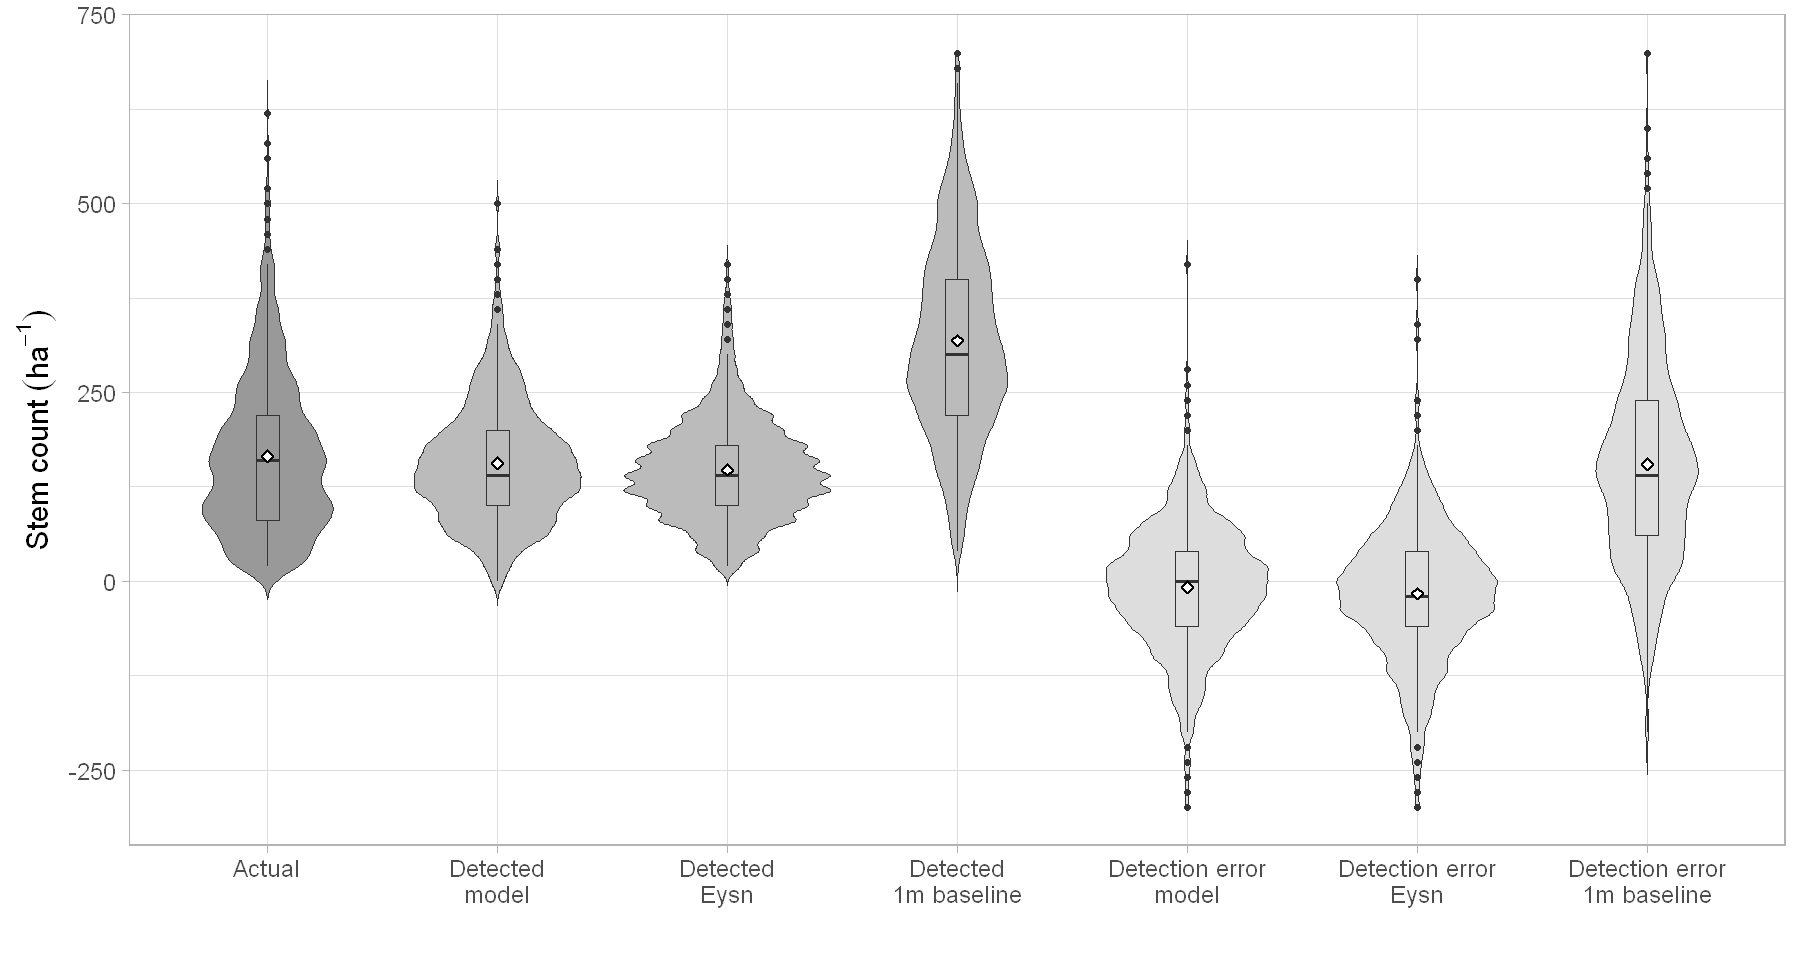

Warning message:
"Removed 7 rows containing missing values (geom_segment)."
Warning message:
"Removed 380 rows containing non-finite values (stat_ydensity)."
Warning message:
"Removed 380 rows containing non-finite values (stat_boxplot)."
Warning message:
"Removed 380 rows containing non-finite values (stat_summary)."
Warning message:
"Removed 91 rows containing missing values (geom_violin)."
Warning message:
"Removed 7 rows containing missing values (geom_segment)."


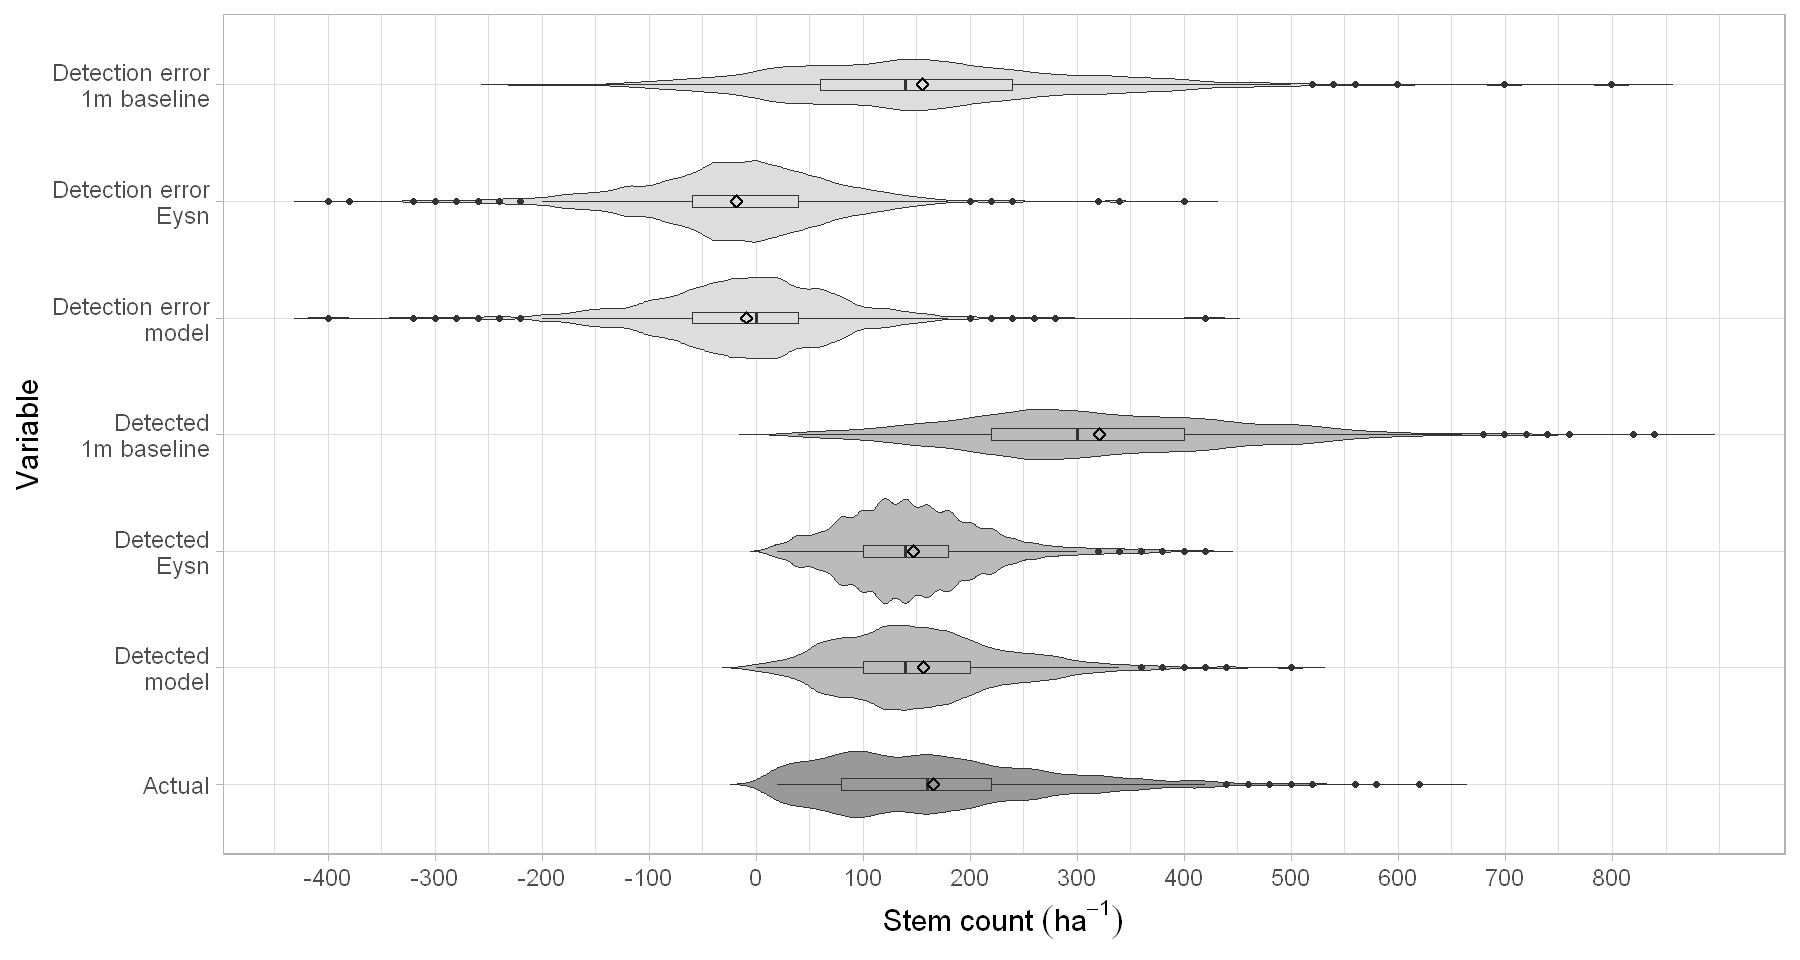

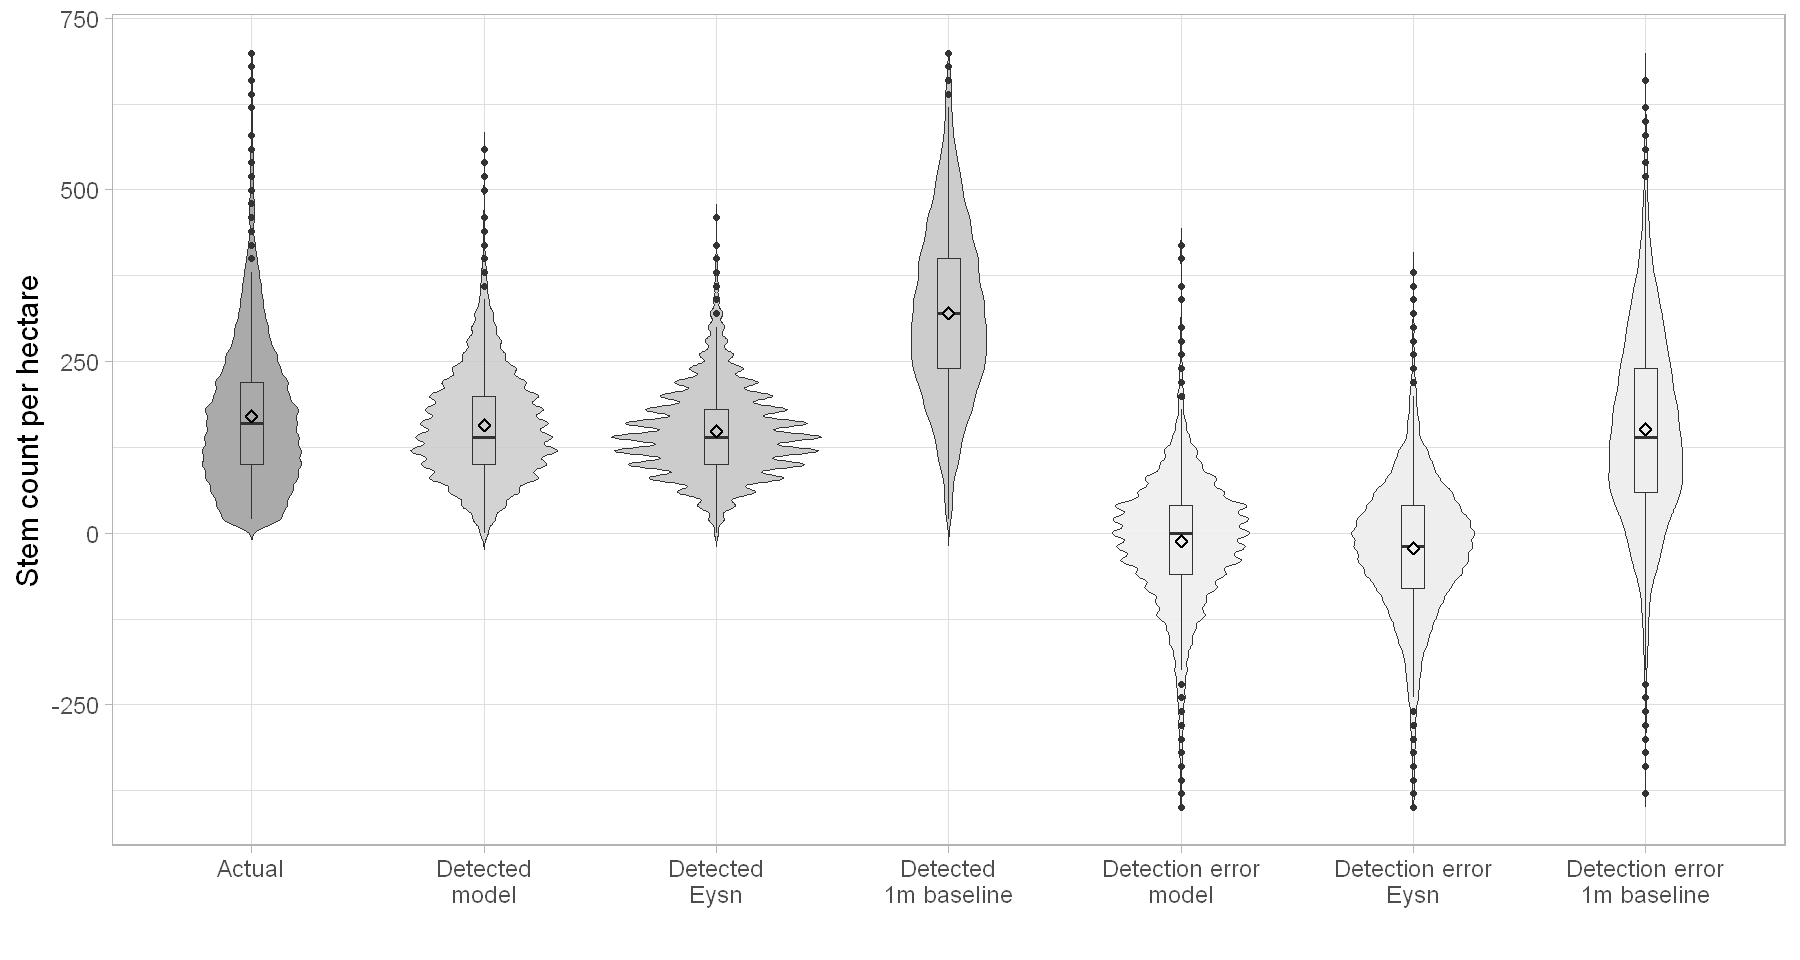

In [66]:
#Violin plots
options(repr.plot.width=15, repr.plot.height=8)

font_base_size <- 18

vp1<-ggplot(df_validation, aes(x=Variable, y=Value, fill=Variable)) +
  geom_violin(trim=FALSE)+
  geom_boxplot(width=0.1)+
  ylim(-300,700) +
  theme_light(base_size = font_base_size) +
  ylab(bquote(Stem~count~(ha^-1))) +
  xlab("") +
  theme(legend.position="none")+
  labs(fill="Detection Method",col="Detection Method") + 
  stat_summary(fun=mean, geom="pointrange", shape=23, size=0.5, fill="white") +
  scale_fill_manual(values=c("#999999", "#BBBBBB", "#BBBBBB", "#BBBBBB", "#DDDDDD", "#DDDDDD", "#DDDDDD"))  

vp1 

ggsave(filename = "3_violin_validation_vertical.jpg", width = 15, height = 8, device='jpeg', dpi=300)

vp2<-ggplot(df_validation, aes(x=Variable, y=Value, fill=Variable)) +
  geom_violin(trim=FALSE)+
  geom_boxplot(width=0.1)+
  # ylim(-200,600) +
  theme_light(base_size = font_base_size) +
  ylab(bquote(Stem~count~(ha^-1))) +
  theme(legend.position="none")+
  labs(fill="Detection Method",col="Detection Method") + 
  stat_summary(fun=mean, geom="pointrange", shape=23, size=0.5) +
  scale_fill_manual(values=c("#999999", "#BBBBBB", "#BBBBBB", "#BBBBBB", "#DDDDDD", "#DDDDDD", "#DDDDDD"))+
  coord_flip()+
  scale_y_continuous(breaks = seq(-400, 800, by = 100))

vp2

ggsave(filename = "3_violin_validation_horizontal.jpg", width = 12, height = 8, device='jpeg', dpi=300)


vptr1<-ggplot(df_calibration, aes(x=Variable, y=Value, fill=Variable)) +
  geom_violin(trim=FALSE)+
  geom_boxplot(width=0.1)+
  ylim(-400,700) +
  theme_light(base_size = font_base_size) +
  ylab("Stem count per hectare") +
  xlab("") +
  theme(legend.position="none")+
  labs(fill="Detection Method",col="Detection Method") + 
  stat_summary(fun=mean, geom="pointrange", shape=23, size=0.5) +
  scale_fill_manual(values=c("#AAAAAA", "#CCCCCCDD", "#CCCCCC", "#CCCCCC", "#EEEEEEDD", "#EEEEEE", "#EEEEEE", "#EEEEEE"))  

vptr1


Warning message:
"Removed 130 rows containing non-finite values (stat_density2d)."
Warning message:
"Removed 130 rows containing non-finite values (stat_density2d)."
Warning message:
"Removed 396 rows containing missing values (geom_raster)."
Warning message:
"Removed 130 rows containing missing values (geom_point)."
Warning message:
"Removed 19 rows containing non-finite values (stat_density2d)."
Warning message:
"Removed 19 rows containing non-finite values (stat_density2d)."
Warning message:
"Removed 396 rows containing missing values (geom_raster)."
Warning message:
"Removed 19 rows containing missing values (geom_point)."


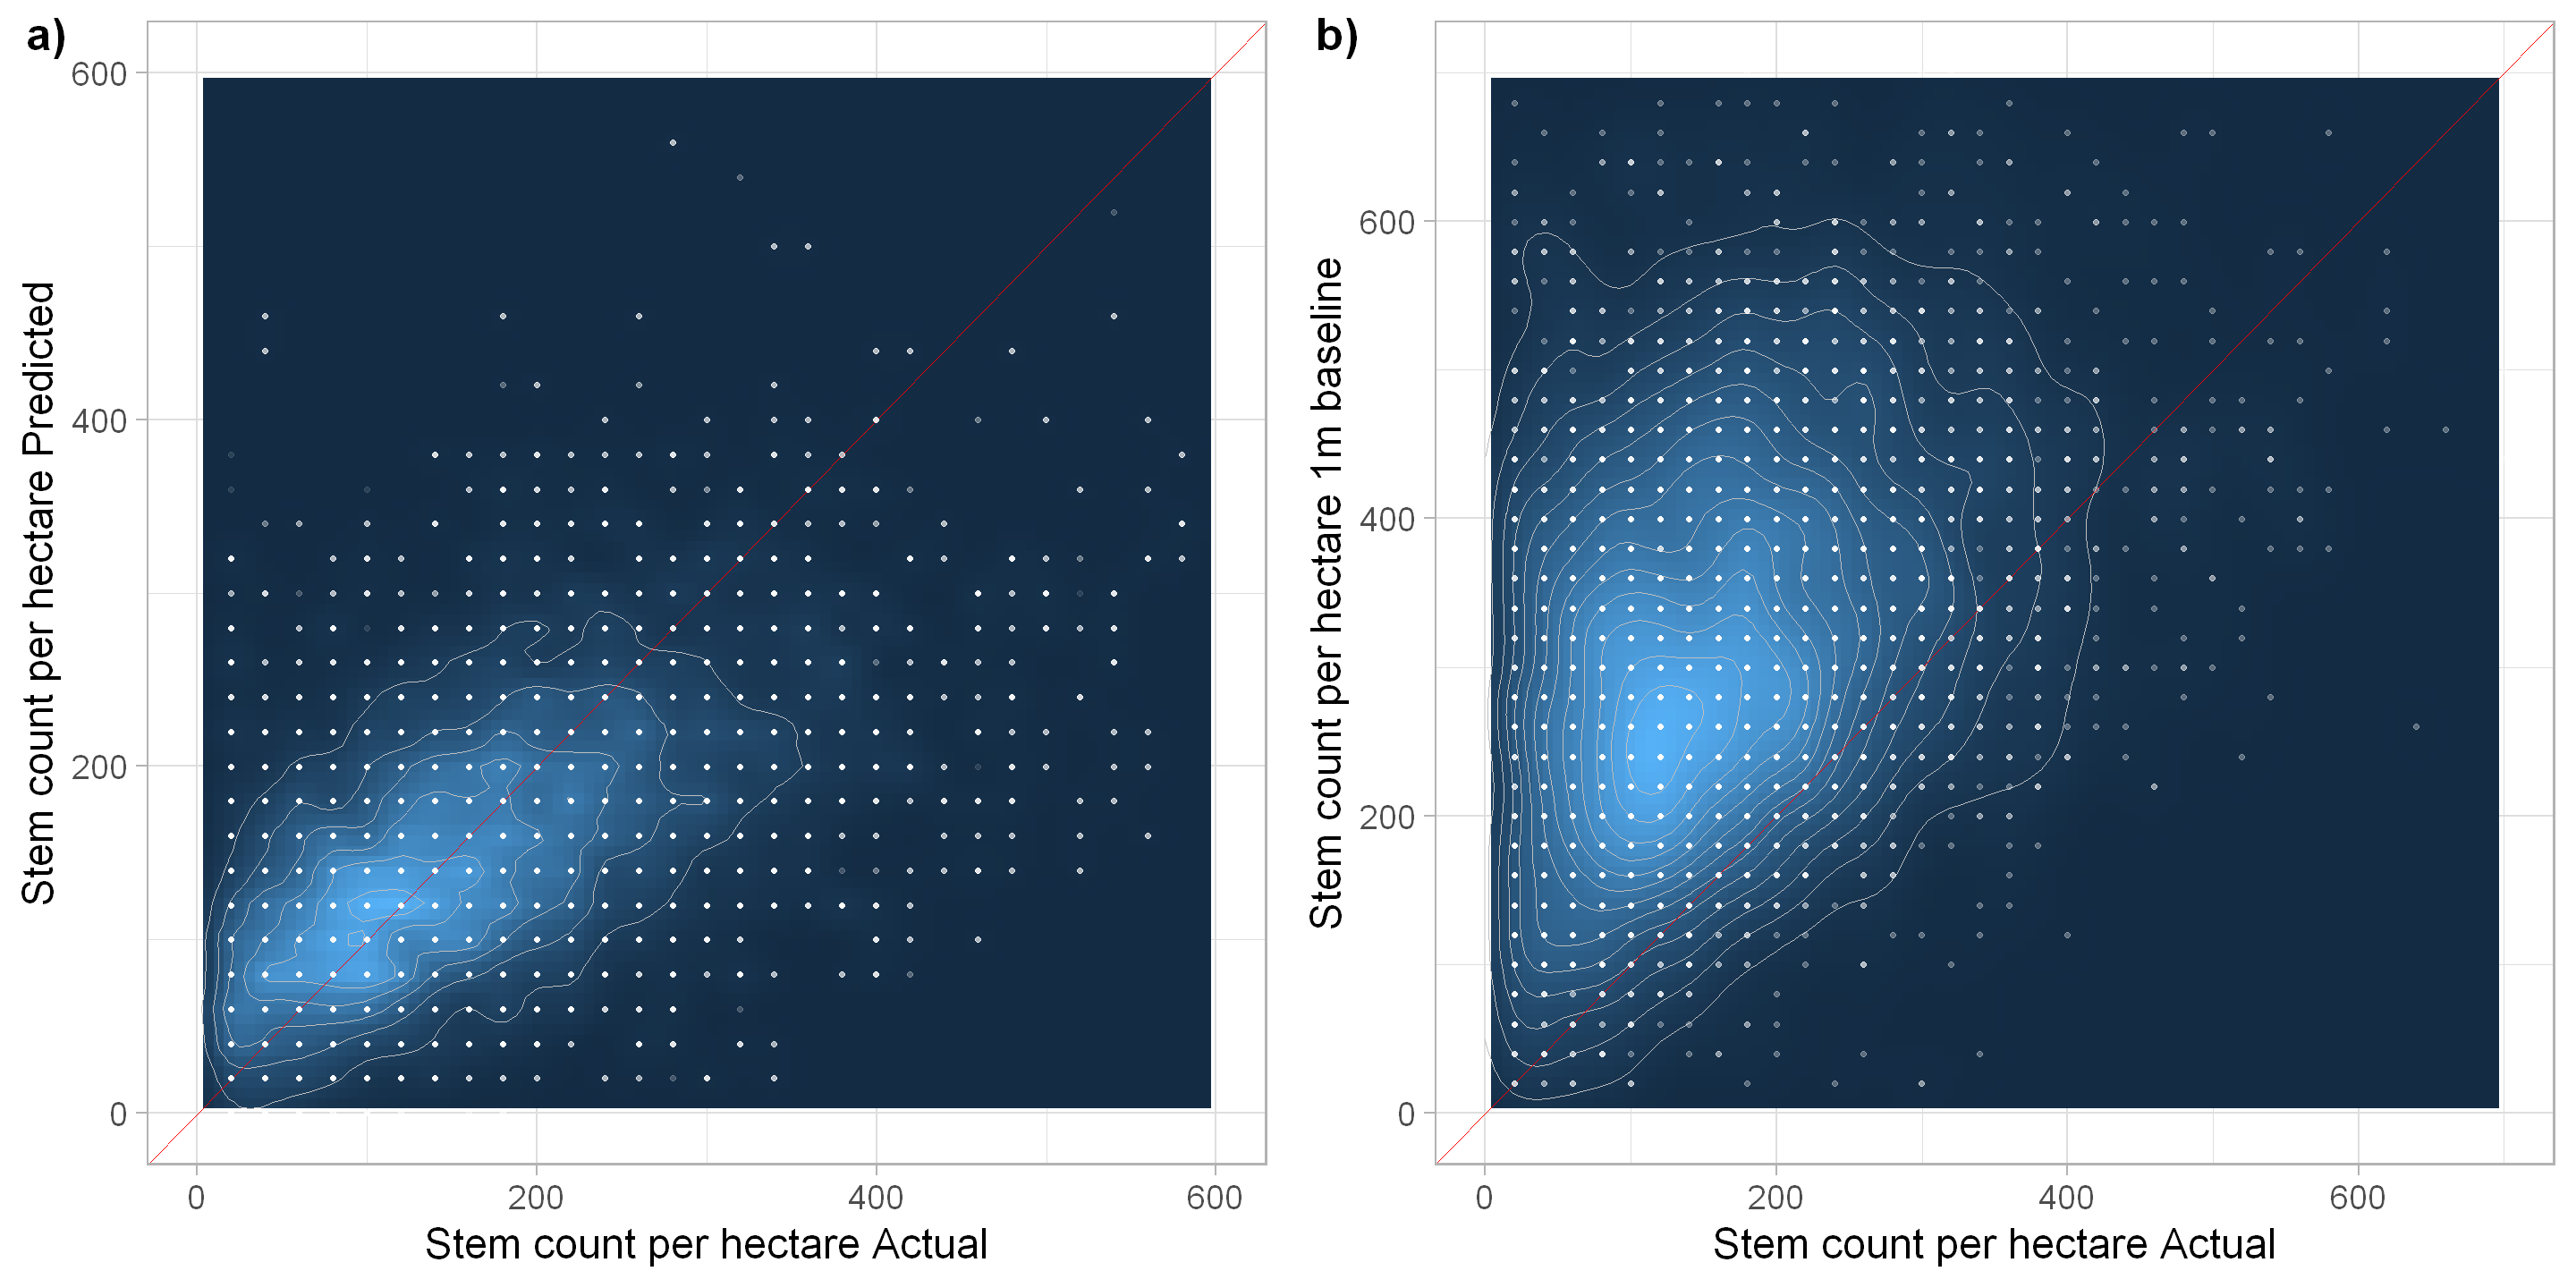

In [67]:
#Scatter plots calibration
df <- data.frame(Actual=scd_calibration$density_actual, Prediction=scd_calibration$stems_per_ha_model, Error=scd_calibration$stems_per_ha_err_model)

options(repr.plot.width=12, repr.plot.height=12)

font_base_size <- 28

sc1_tr <- ggplot(df, aes(x=Actual, y=Prediction)) +
  # geom_bin2d(binwidth=20)+
  # geom_hex() +
  stat_density_2d(aes(fill = ..density..), geom = "raster", contour = FALSE)+
  geom_density_2d(color="gray")+
  geom_abline(intercept = 0, slope = 1, color="red") +
  geom_point(alpha=0.1, color="white") +
  xlim(0,600) +
  ylim(0,600) +
  # theme(text = element_text(size = 18)) +
  theme_light(base_size = font_base_size) +
  theme(legend.position="none")+
  xlab("Stem count per hectare Actual") +
  ylab("Stem count per hectare Predicted") 


df <- data.frame(Actual=lfi_trees_grouped_calibration$density_actual, Baseline=lfi_trees_grouped_calibration$stems_per_ha_ps1, Error=lfi_trees_grouped_calibration$stems_per_ha_err_ps1)

sc2_tr <- ggplot(df, aes(x=Actual, y=Baseline)) +
  # geom_bin2d(binwidth=20)+
  # geom_hex() +
  stat_density_2d(aes(fill = ..density..), geom = "raster", contour = FALSE)+
  geom_density_2d(color="gray")+
  geom_abline(intercept = 0, slope = 1, color="red") +
  geom_point(alpha=0.3, color="white") +
  xlim(0,700) +
  ylim(0,700) +
  theme_light(base_size = font_base_size) +
  theme(legend.position="none")+
  xlab("Stem count per hectare Actual") +
  ylab("Stem count per hectare 1m baseline") 

options(repr.plot.width=24, repr.plot.height=12)

ggarrange(sc1_tr, sc2_tr, 
          labels = c("a) ", "b) "),
          ncol = 2, nrow = 1, font.label = list(size = 30))
ggsave(filename = "4_scatter_actual_predicted_baseline_calibration.jpg", width = 24, height = 12, device='jpeg', dpi=300)


Warning message:
"Removed 10 rows containing non-finite values (stat_density2d)."
Warning message:
"Removed 10 rows containing non-finite values (stat_density2d)."
Warning message:
"Removed 396 rows containing missing values (geom_raster)."
Warning message:
"Removed 10 rows containing missing values (geom_point)."
Warning message:
"Removed 6 rows containing non-finite values (stat_density2d)."
Warning message:
"Removed 6 rows containing non-finite values (stat_density2d)."
Warning message:
"Removed 396 rows containing missing values (geom_raster)."
Warning message:
"Removed 6 rows containing missing values (geom_point)."


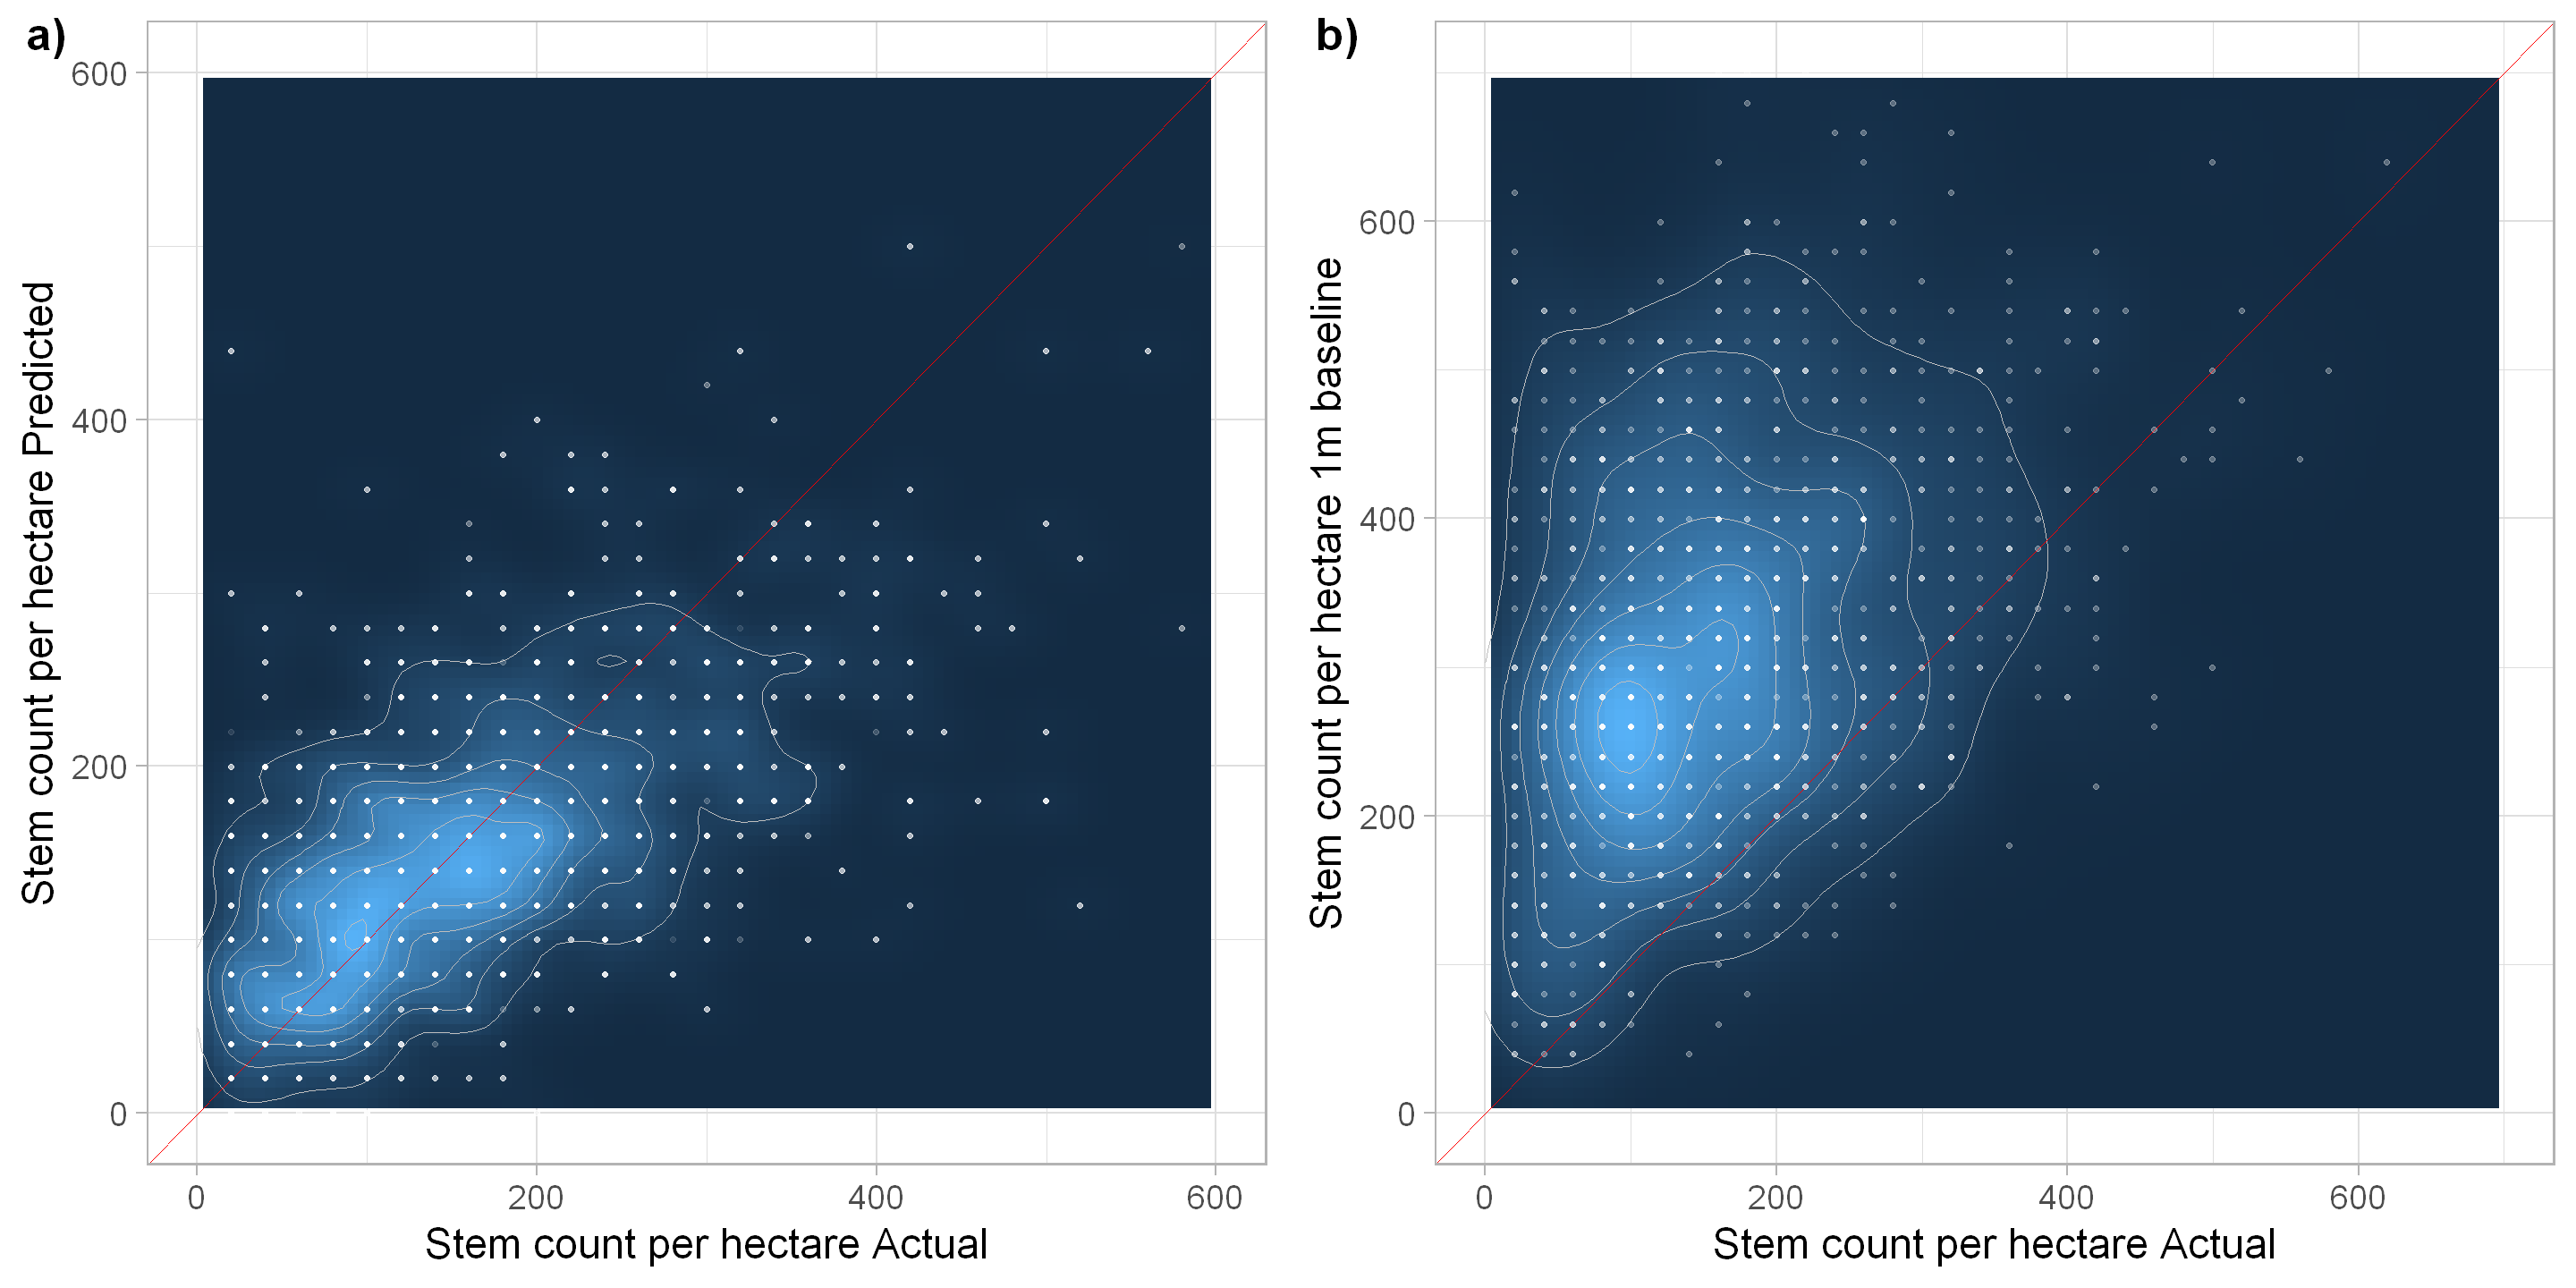

In [68]:
#Scatter plots validation
df <- data.frame(Actual=scd_validation$density_actual, Prediction=scd_validation$stems_per_ha_model, Error=scd_validation$stems_per_ha_err_model)

options(repr.plot.width=12, repr.plot.height=12)

font_base_size <- 28

sc1_ts <- ggplot(df, aes(x=Actual, y=Prediction)) +
  # geom_bin2d(binwidth=20)+
  # geom_hex() +
  stat_density_2d(aes(fill = ..density..), geom = "raster", contour = FALSE)+
  geom_density_2d(color="gray")+
  geom_abline(intercept = 0, slope = 1, color="red") +
  geom_point(alpha=0.1, color="white") +
  xlim(0,600) +
  ylim(0,600) +
  # theme(text = element_text(size = 18)) +
  theme_light(base_size = font_base_size) +
  theme(legend.position="none")+
  xlab("Stem count per hectare Actual") +
  ylab("Stem count per hectare Predicted") 


df <- data.frame(Actual=lfi_trees_grouped_validation$density_actual, Baseline=lfi_trees_grouped_validation$stems_per_ha_ps1, Error=lfi_trees_grouped_validation$stems_per_ha_err_ps1)

sc2_ts <- ggplot(df, aes(x=Actual, y=Baseline)) +
  # geom_bin2d(binwidth=20)+
  # geom_hex() +
  stat_density_2d(aes(fill = ..density..), geom = "raster", contour = FALSE)+
  geom_density_2d(color="gray")+
  geom_abline(intercept = 0, slope = 1, color="red") +
  geom_point(alpha=0.3, color="white") +
  xlim(0,700) +
  ylim(0,700) +
  theme_light(base_size = font_base_size) +
  theme(legend.position="none")+
  xlab("Stem count per hectare Actual") +
  ylab("Stem count per hectare 1m baseline") 

options(repr.plot.width=24, repr.plot.height=12)

ggarrange(sc1_ts, sc2_ts, 
          labels = c("a) ", "b) "),
          ncol = 2, nrow = 1, font.label = list(size = 30))
ggsave(filename = "4_scatter_actual_predicted_baseline_validation.jpg", width = 24, height = 12, device='jpeg', dpi=300)


Warning message:
"Removed 10 rows containing non-finite values (stat_density2d)."
Warning message:
"Removed 10 rows containing non-finite values (stat_density2d)."
Warning message:
"Removed 396 rows containing missing values (geom_raster)."
Warning message:
"Removed 10 rows containing missing values (geom_point)."
Warning message:
"Removed 10 rows containing non-finite values (stat_density2d)."
Warning message:
"Removed 10 rows containing non-finite values (stat_density2d)."
Warning message:
"Removed 396 rows containing missing values (geom_raster)."
Warning message:
"Removed 10 rows containing missing values (geom_point)."


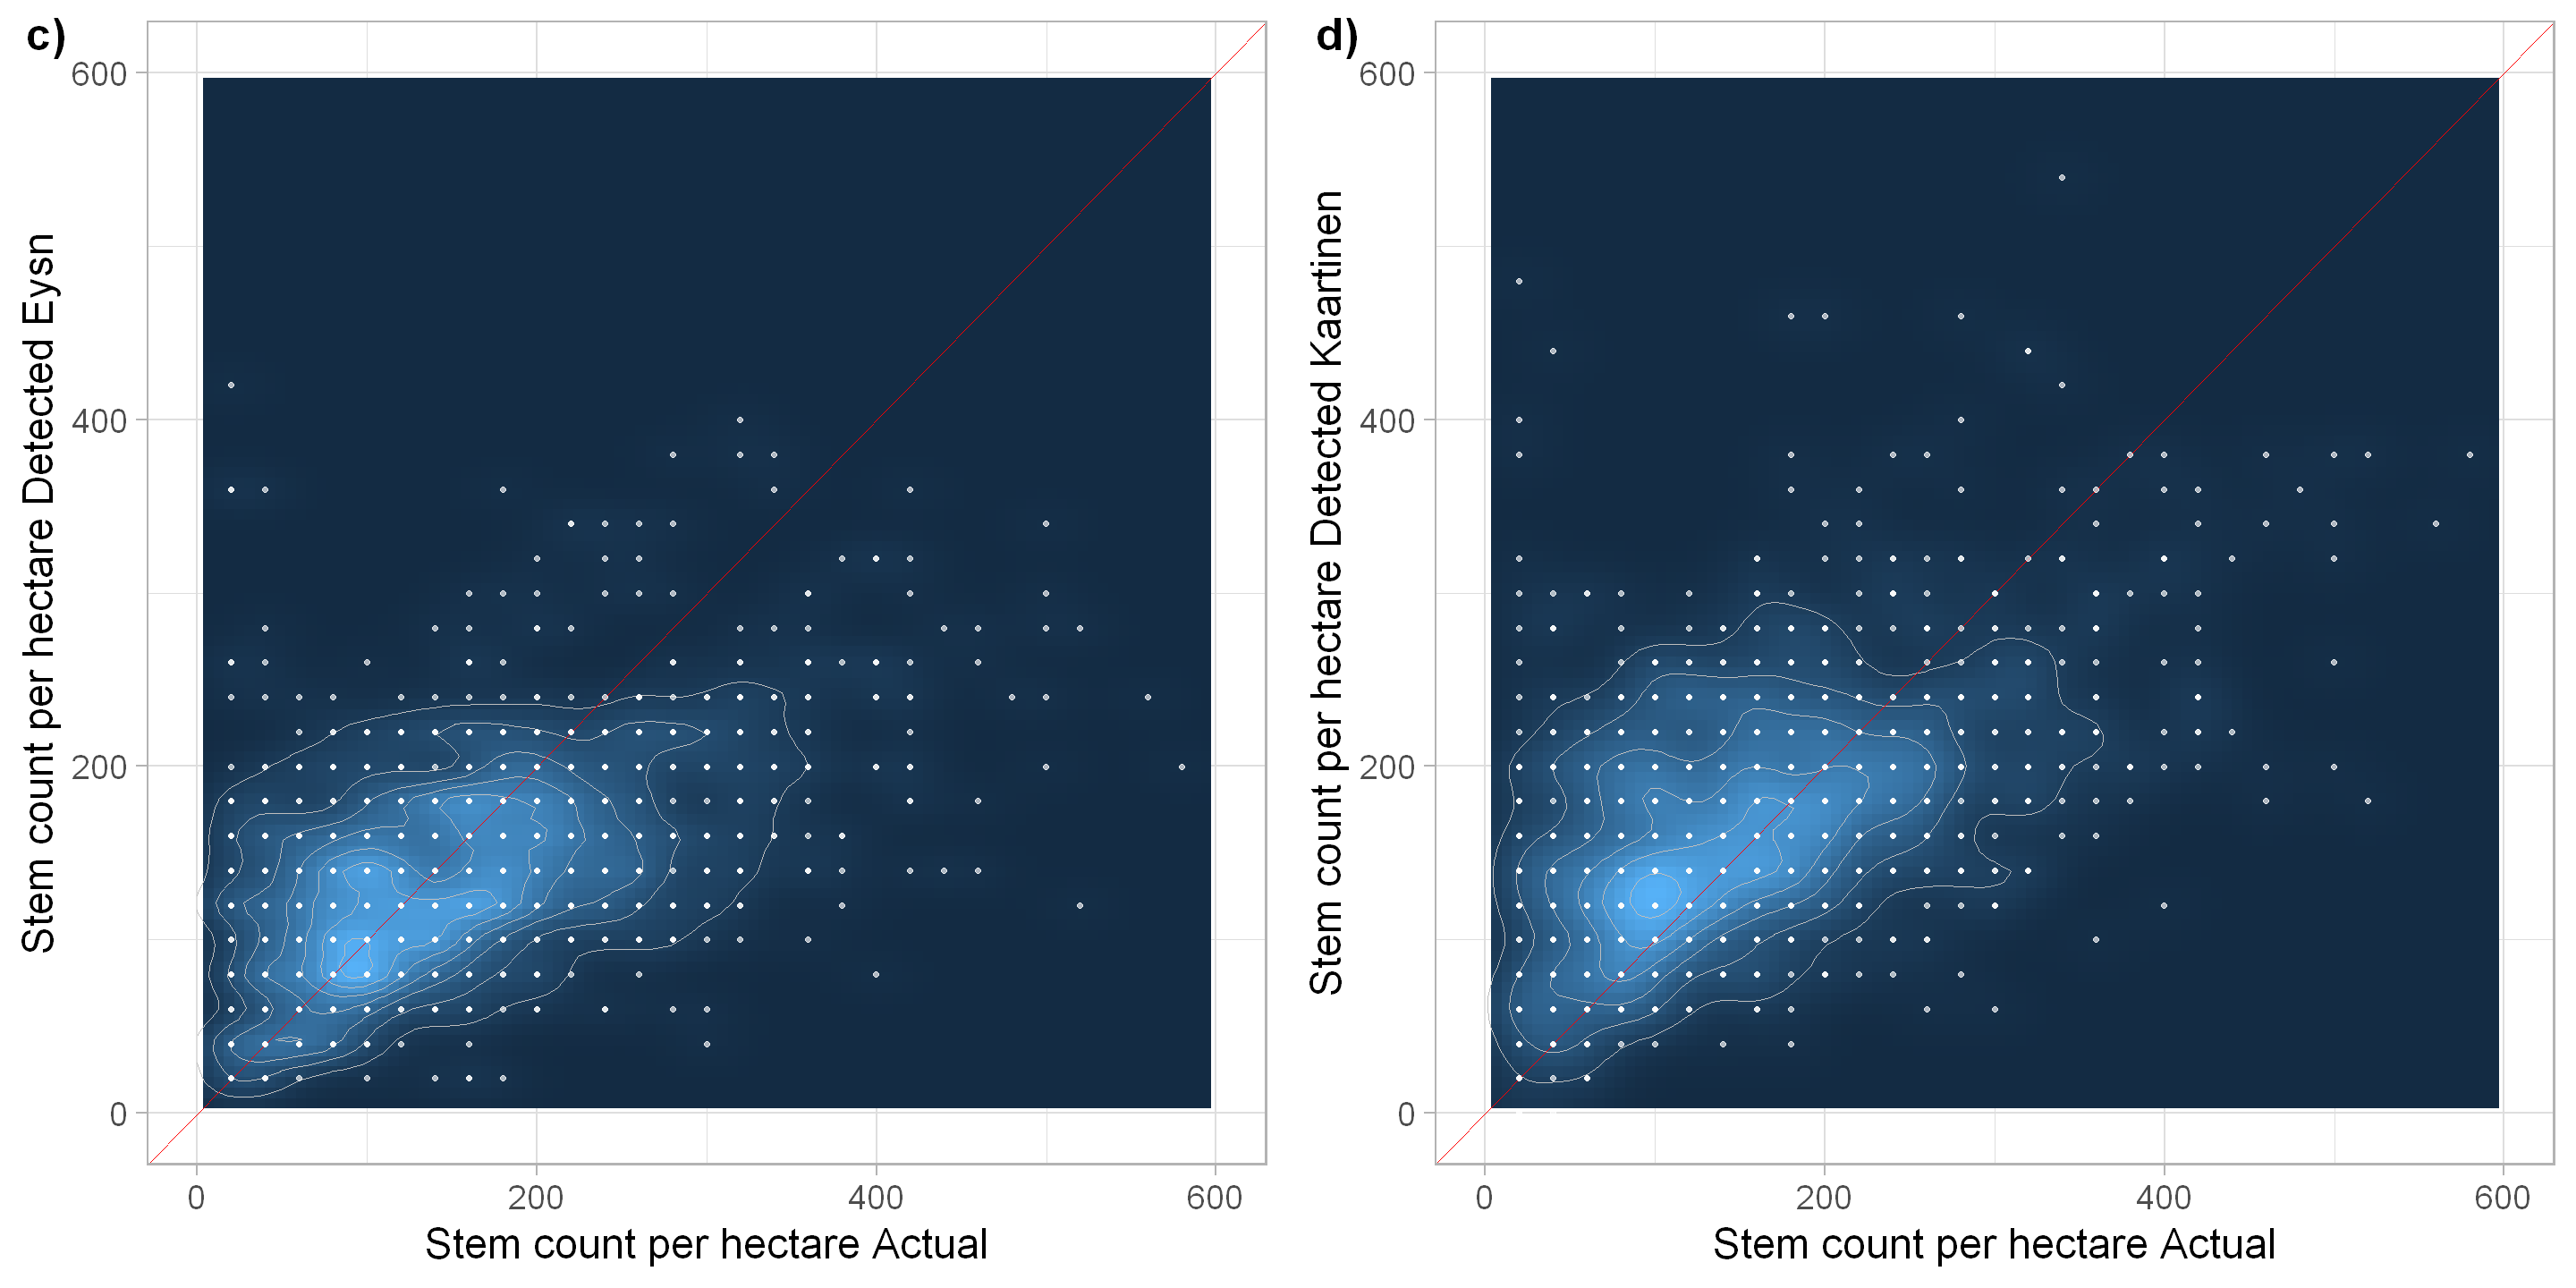

In [69]:
#Scatter plots validation
df <- data.frame(Actual=scd_validation_eysn$density_actual, Prediction=scd_validation_eysn$stems_per_ha_model, Error=scd_validation_eysn$stems_per_ha_err_model)

options(repr.plot.width=12, repr.plot.height=12)

font_base_size <- 28

sc1_ts_eysn <- ggplot(df, aes(x=Actual, y=Prediction)) +
  # geom_bin2d(binwidth=20)+
  # geom_hex() +
  stat_density_2d(aes(fill = ..density..), geom = "raster", contour = FALSE)+
  geom_density_2d(color="gray")+
  geom_abline(intercept = 0, slope = 1, color="red") +
  geom_point(alpha=0.1, color="white") +
  xlim(0,600) +
  ylim(0,600) +
  # theme(text = element_text(size = 18)) +
  theme_light(base_size = font_base_size) +
  theme(legend.position="none")+
  xlab("Stem count per hectare Actual") +
  ylab("Stem count per hectare Detected Eysn") 


df <- data.frame(Actual=scd_validation_kaartinen$density_actual, Prediction=scd_validation_kaartinen$stems_per_ha_model, Error=scd_validation_kaartinen$stems_per_ha_err_model)

options(repr.plot.width=12, repr.plot.height=12)

font_base_size <- 28

sc2_ts_kaartinen <- ggplot(df, aes(x=Actual, y=Prediction)) +
  # geom_bin2d(binwidth=20)+
  # geom_hex() +
  stat_density_2d(aes(fill = ..density..), geom = "raster", contour = FALSE)+
  geom_density_2d(color="gray")+
  geom_abline(intercept = 0, slope = 1, color="red") +
  geom_point(alpha=0.1, color="white") +
  xlim(0,600) +
  ylim(0,600) +
  # theme(text = element_text(size = 18)) +
  theme_light(base_size = font_base_size) +
  theme(legend.position="none")+
  xlab("Stem count per hectare Actual") +
  ylab("Stem count per hectare Detected Kaartinen") 


options(repr.plot.width=24, repr.plot.height=12)

ggarrange(sc1_ts_eysn, sc2_ts_kaartinen, 
          labels = c("c) ", "d) "),
          ncol = 2, nrow = 1, font.label = list(size = 30))
ggsave(filename = "4_scatter_actual_predicted_baseline_validation_eysn_kaartinen.jpg", width = 24, height = 12, device='jpeg', dpi=300)


Warning message:
"Removed 130 rows containing non-finite values (stat_density2d)."
Warning message:
"Removed 130 rows containing non-finite values (stat_density2d)."
Warning message:
"Removed 396 rows containing missing values (geom_raster)."
Warning message:
"Removed 130 rows containing missing values (geom_point)."
Warning message:
"Removed 19 rows containing non-finite values (stat_density2d)."
Warning message:
"Removed 19 rows containing non-finite values (stat_density2d)."
Warning message:
"Removed 396 rows containing missing values (geom_raster)."
Warning message:
"Removed 19 rows containing missing values (geom_point)."
Warning message:
"Removed 10 rows containing non-finite values (stat_density2d)."
Warning message:
"Removed 10 rows containing non-finite values (stat_density2d)."
Warning message:
"Removed 396 rows containing missing values (geom_raster)."
Warning message:
"Removed 10 rows containing missing values (geom_point)."
Warning message:
"Removed 6 rows containing non-f

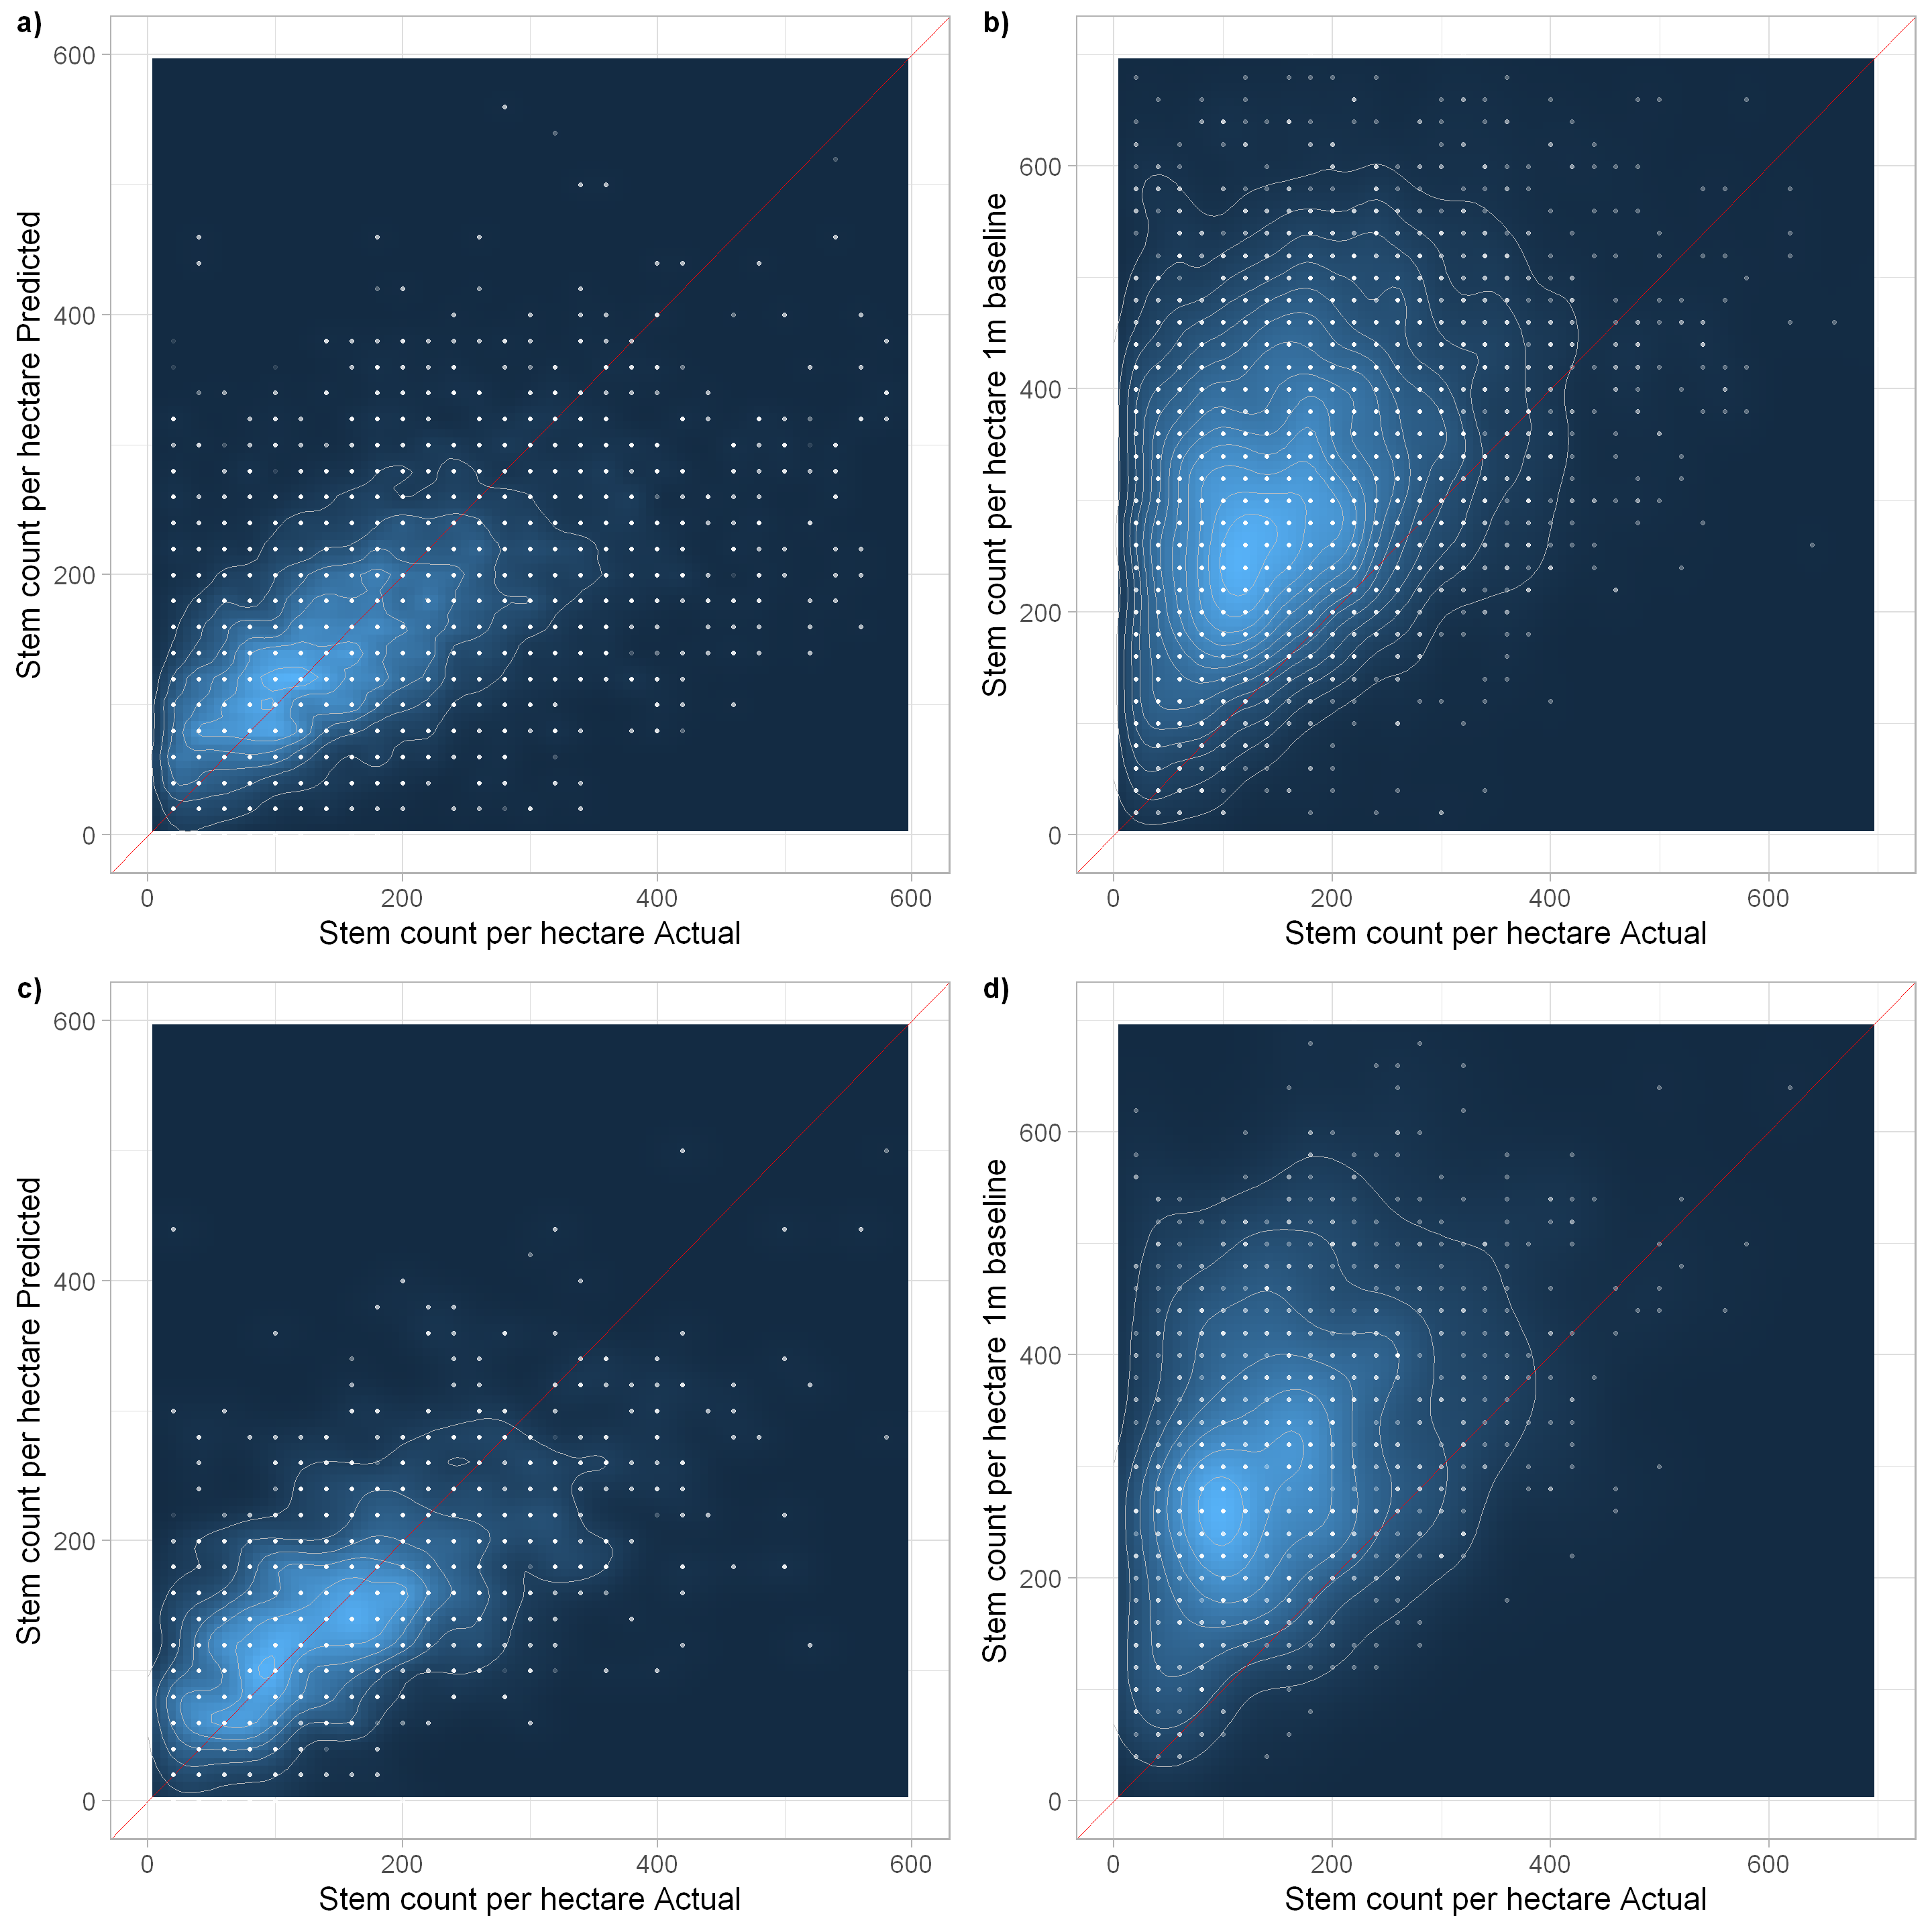

In [70]:
#Scatter plots validation and calibration
options(repr.plot.width=24, repr.plot.height=24)

ggarrange(sc1_tr,sc2_tr,sc1_ts, sc2_ts, 
          labels = c("a) ", "b) ", "c) ", "d) "),
          ncol = 2, nrow = 2, font.label = list(size = 26))


Warning message:
"Removed 130 rows containing non-finite values (stat_density2d)."
Warning message:
"Removed 130 rows containing non-finite values (stat_density2d)."
Warning message:
"Removed 396 rows containing missing values (geom_raster)."
Warning message:
"Removed 130 rows containing missing values (geom_point)."
Warning message:
"Removed 19 rows containing non-finite values (stat_density2d)."
Warning message:
"Removed 19 rows containing non-finite values (stat_density2d)."
Warning message:
"Removed 396 rows containing missing values (geom_raster)."
Warning message:
"Removed 19 rows containing missing values (geom_point)."
Warning message:
"Removed 10 rows containing non-finite values (stat_density2d)."
Warning message:
"Removed 10 rows containing non-finite values (stat_density2d)."
Warning message:
"Removed 396 rows containing missing values (geom_raster)."
Warning message:
"Removed 10 rows containing missing values (geom_point)."
Warning message:
"Removed 10 rows containing non-

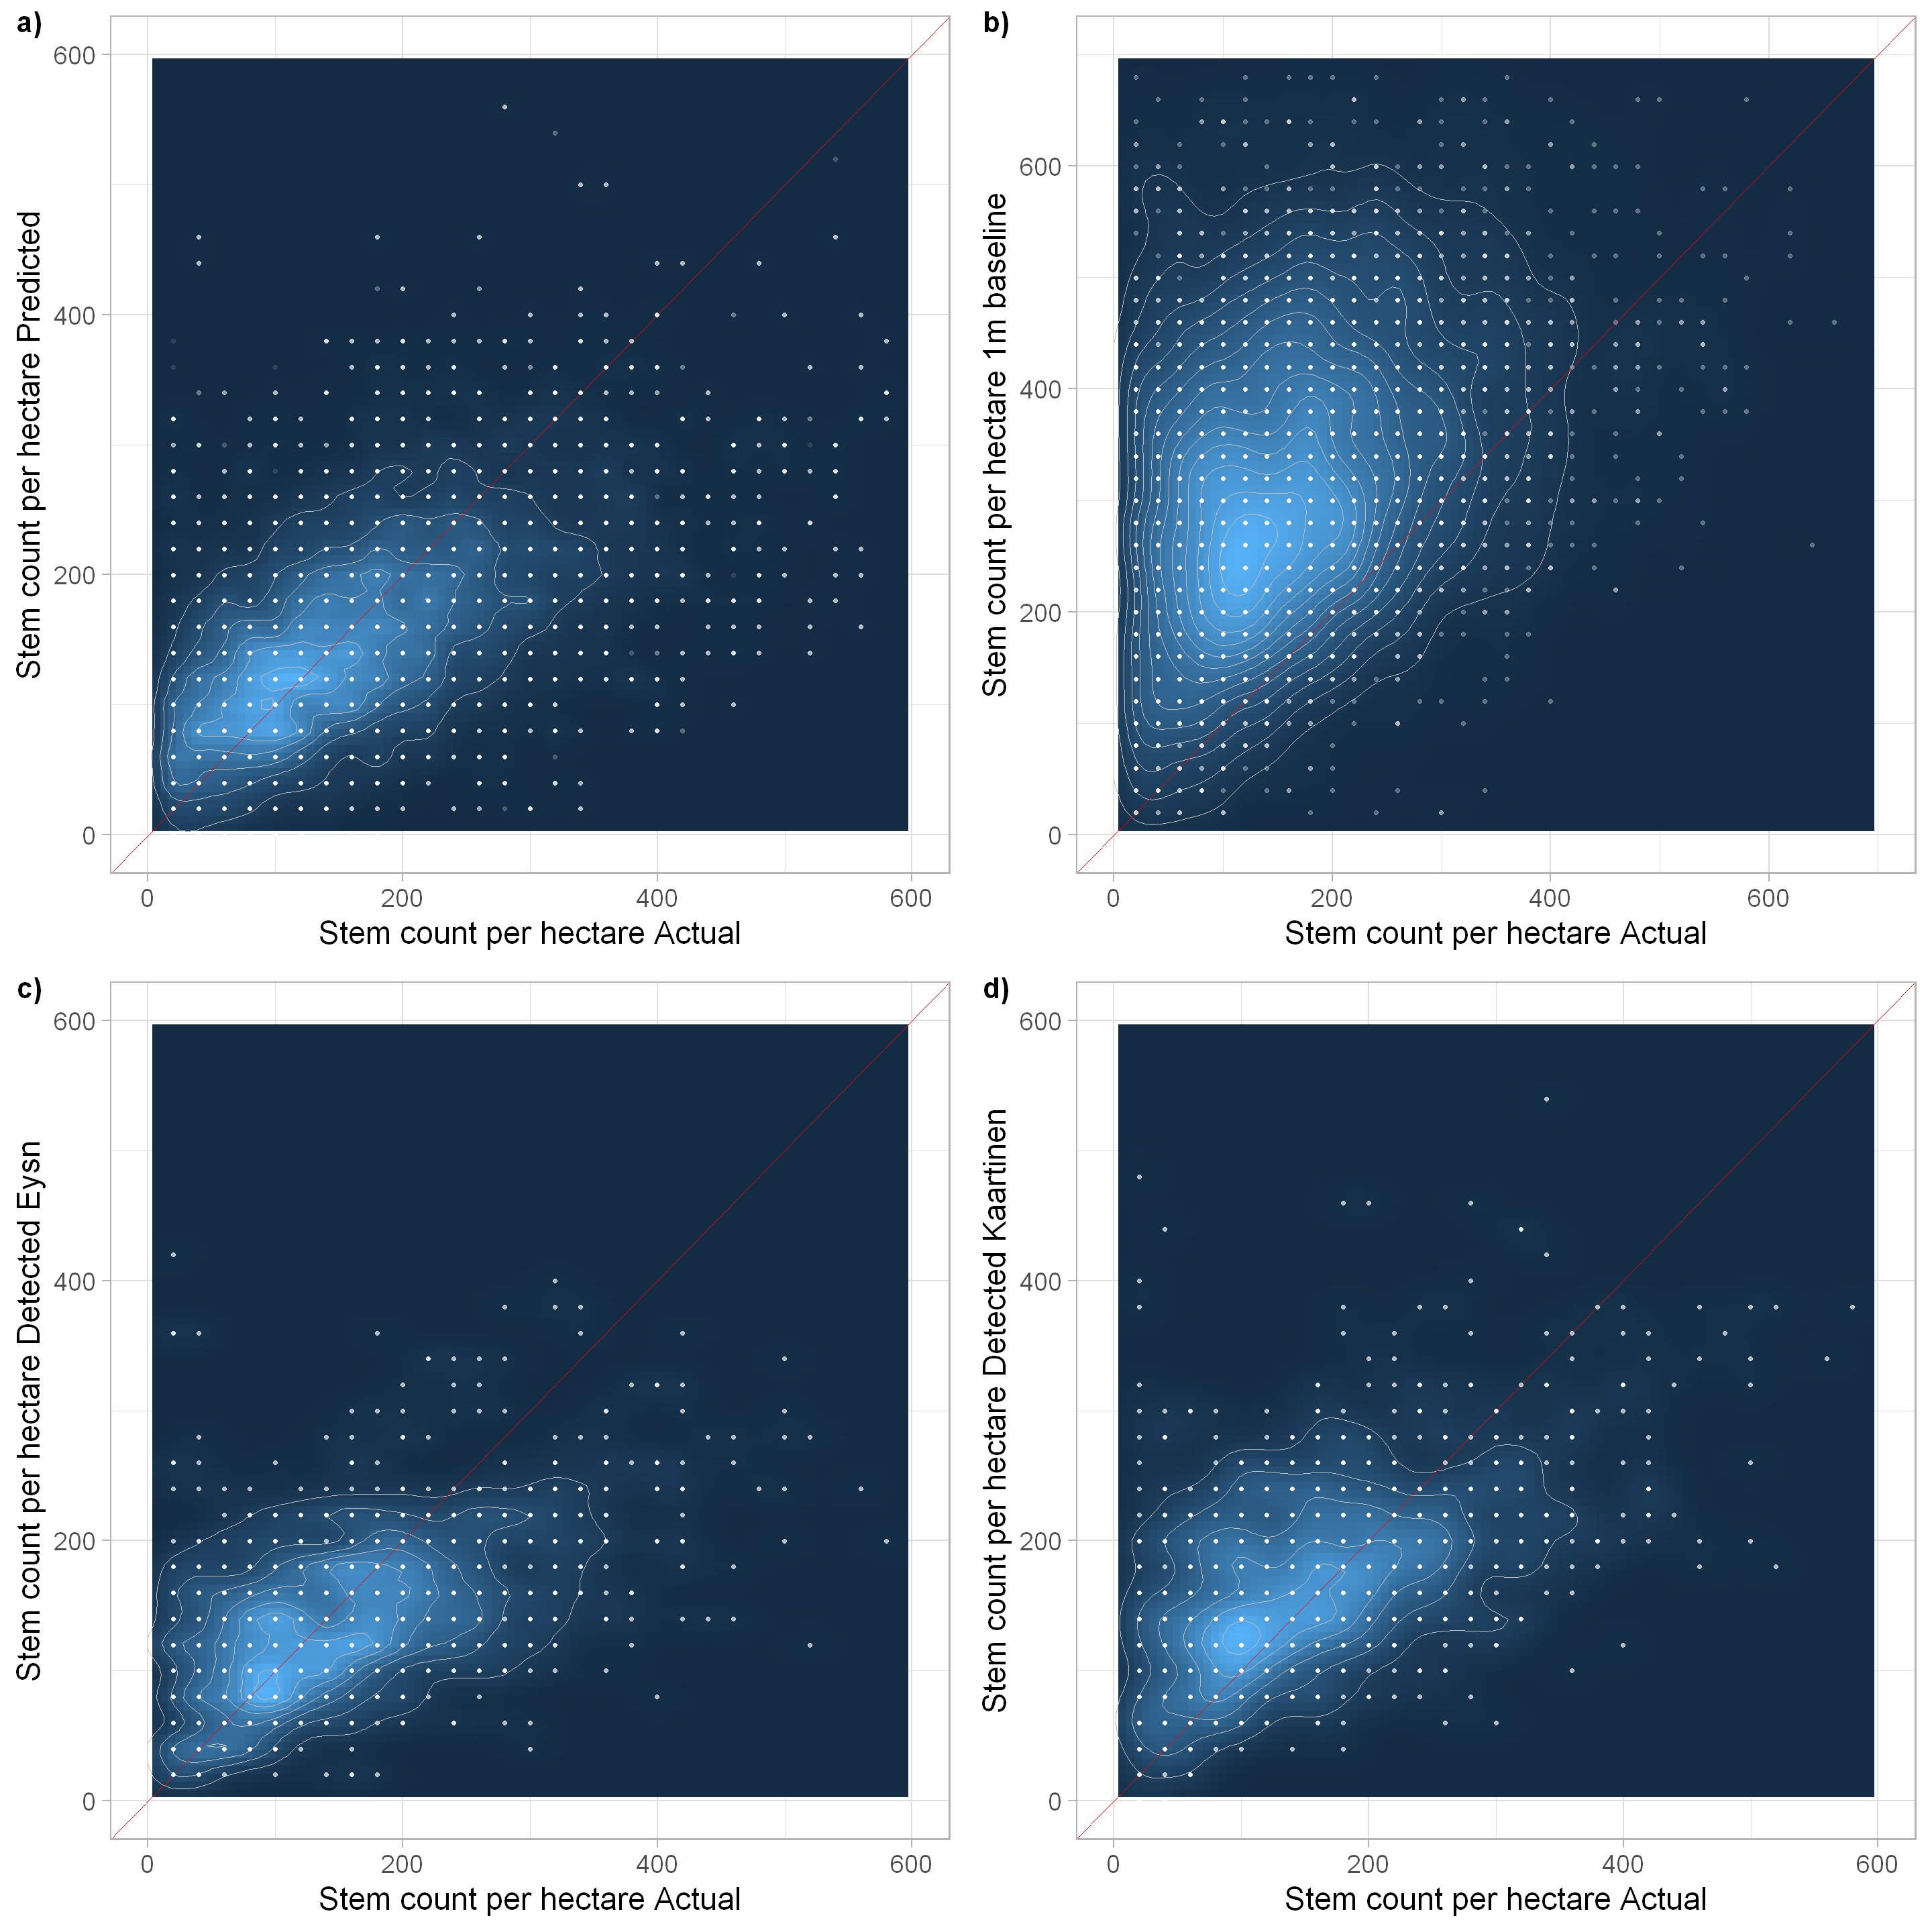

In [71]:
#Scatter plots validation and calibration
options(repr.plot.width=24, repr.plot.height=24)

ggarrange(sc1_tr,sc2_tr,sc1_ts_eysn, sc2_ts_kaartinen, 
          labels = c("a) ", "b) ", "c) ", "d) "),
          ncol = 2, nrow = 2, font.label = list(size = 26))


<a id="Error_Exploration"></a>
### Exploring high errors and model behaviour

In [72]:
# Get scoring data for all plots for the best model 
min_mae_index <- which.min(scores_all_all$scores$mae_density_model)
data <- scores_all_all$scoring_data[[min_mae_index]]

In [73]:
# fintch_composite_score <- function(model, scoring_in, detection_column_index = NA, y_column="parameterset_min") {
data_baseline <- scores_all_all_baseline$scoring_data[[min_mae_index]]
data_baseline <- data_baseline[,c('stems_per_ha_rs_model','dr_model','prediction_accurate_model','stems_in_plot_err_norm_model','stems_per_ha_model','stems_in_plot_abs_err_model','stems_per_ha_abs_err_model','stems_per_ha_abs_err_norm_model','stems_per_ha_err_model','stems_in_plot_err_model','stems_in_plot_model')]
colnames(data_baseline) <- c('stems_per_ha_rs_baseline','dr_baseline','prediction_accurate_baseline','stems_in_plot_err_norm_baseline','stems_per_ha_baseline','stems_in_plot_abs_err_baseline','stems_per_ha_abs_err_baseline','stems_per_ha_abs_err_norm_baseline','stems_per_ha_err_baseline','stems_in_plot_err_baseline','stems_in_plot_baseline')
data <- cbind(data,data_baseline)

In [74]:
summary(data$stems_per_ha_abs_err_norm_model)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.1667  0.3333  0.6365  0.6154 21.0000 

In [75]:
# Set 0/1 Flags for normed absolute errors >1, >2, >3 and >4
data$ae_norm_class_1 <-  as.factor(unlist(lapply(data$stems_per_ha_abs_err_norm_model, function(x) { if(x>1){return(1)}else{return(0)}})))
data$ae_norm_class_2 <-  as.factor(unlist(lapply(data$stems_per_ha_abs_err_norm_model, function(x) { if(x>2){return(1)}else{return(0)}})))
data$ae_norm_class_3 <-  as.factor(unlist(lapply(data$stems_per_ha_abs_err_norm_model, function(x) { if(x>3){return(1)}else{return(0)}})))
data$ae_norm_class_4 <-  as.factor(unlist(lapply(data$stems_per_ha_abs_err_norm_model, function(x) { if(x>4){return(1)}else{return(0)}})))

In [76]:
data$nh_bin <- as.factor(floor(data$nh/5)*5)
data$dg_bin <- as.factor(floor(data$dg/5)*5)
data$hdom_bin <- as.factor(floor(data$hdom/4)*4)


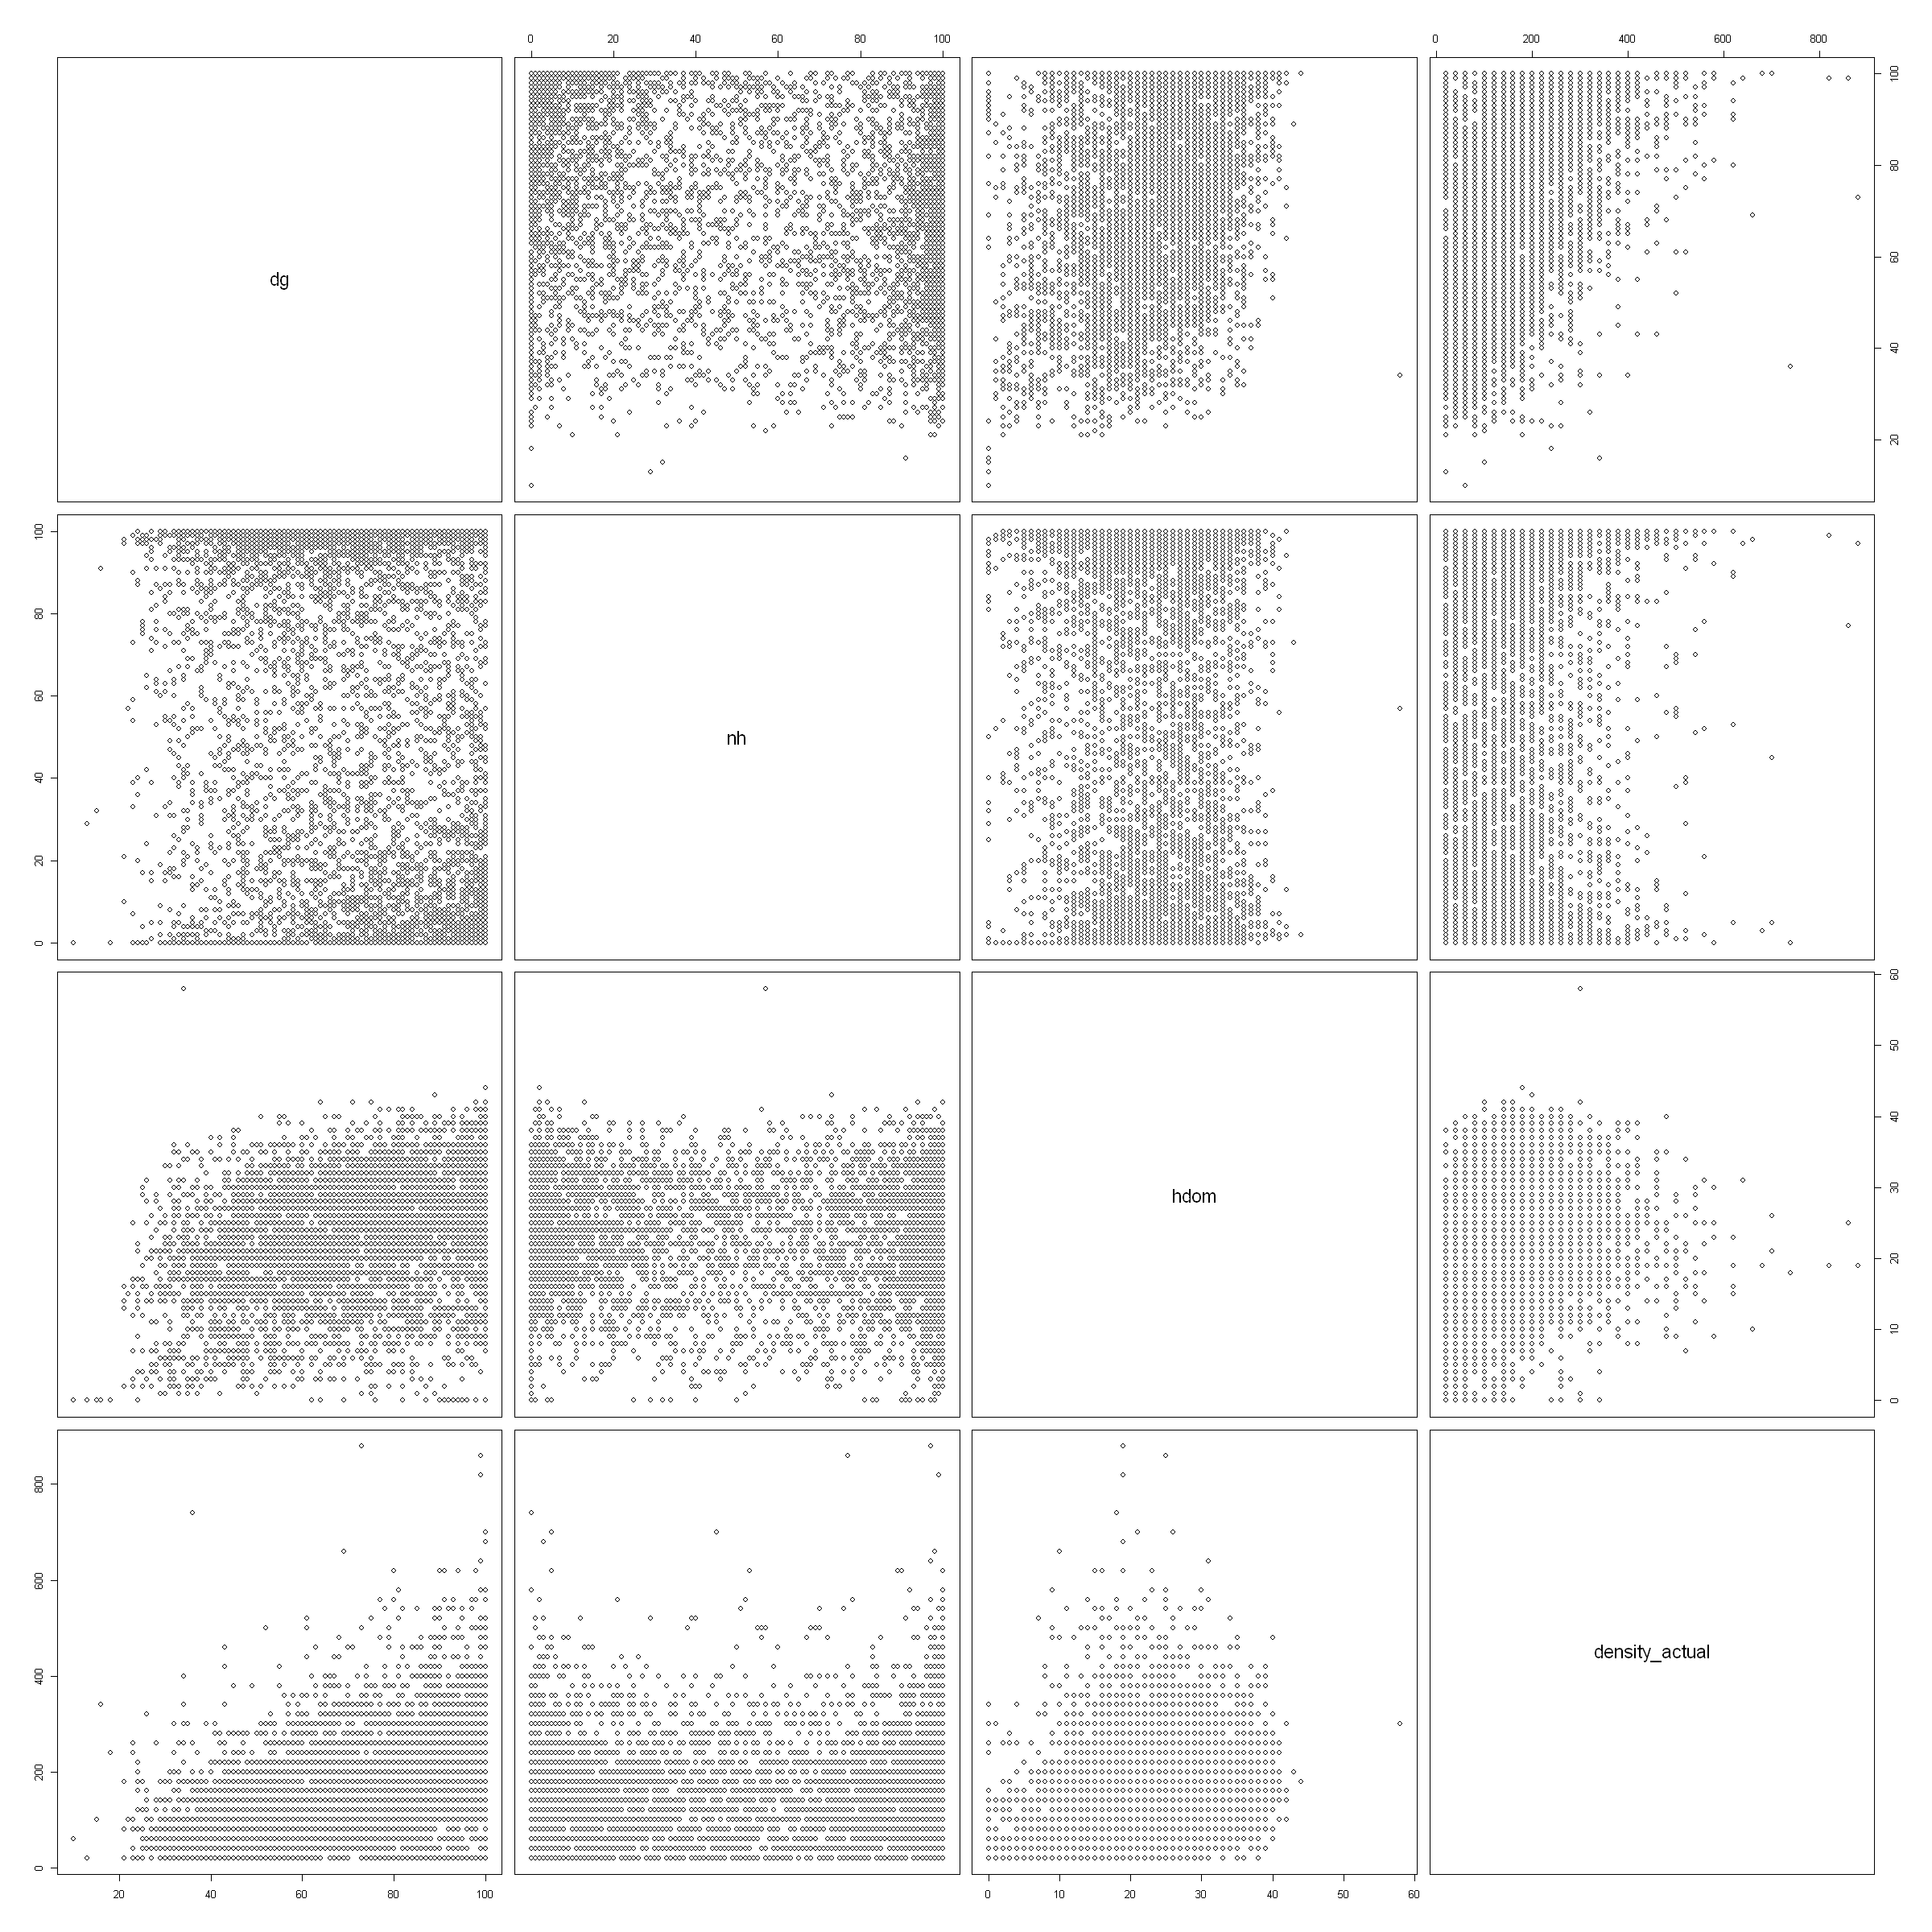

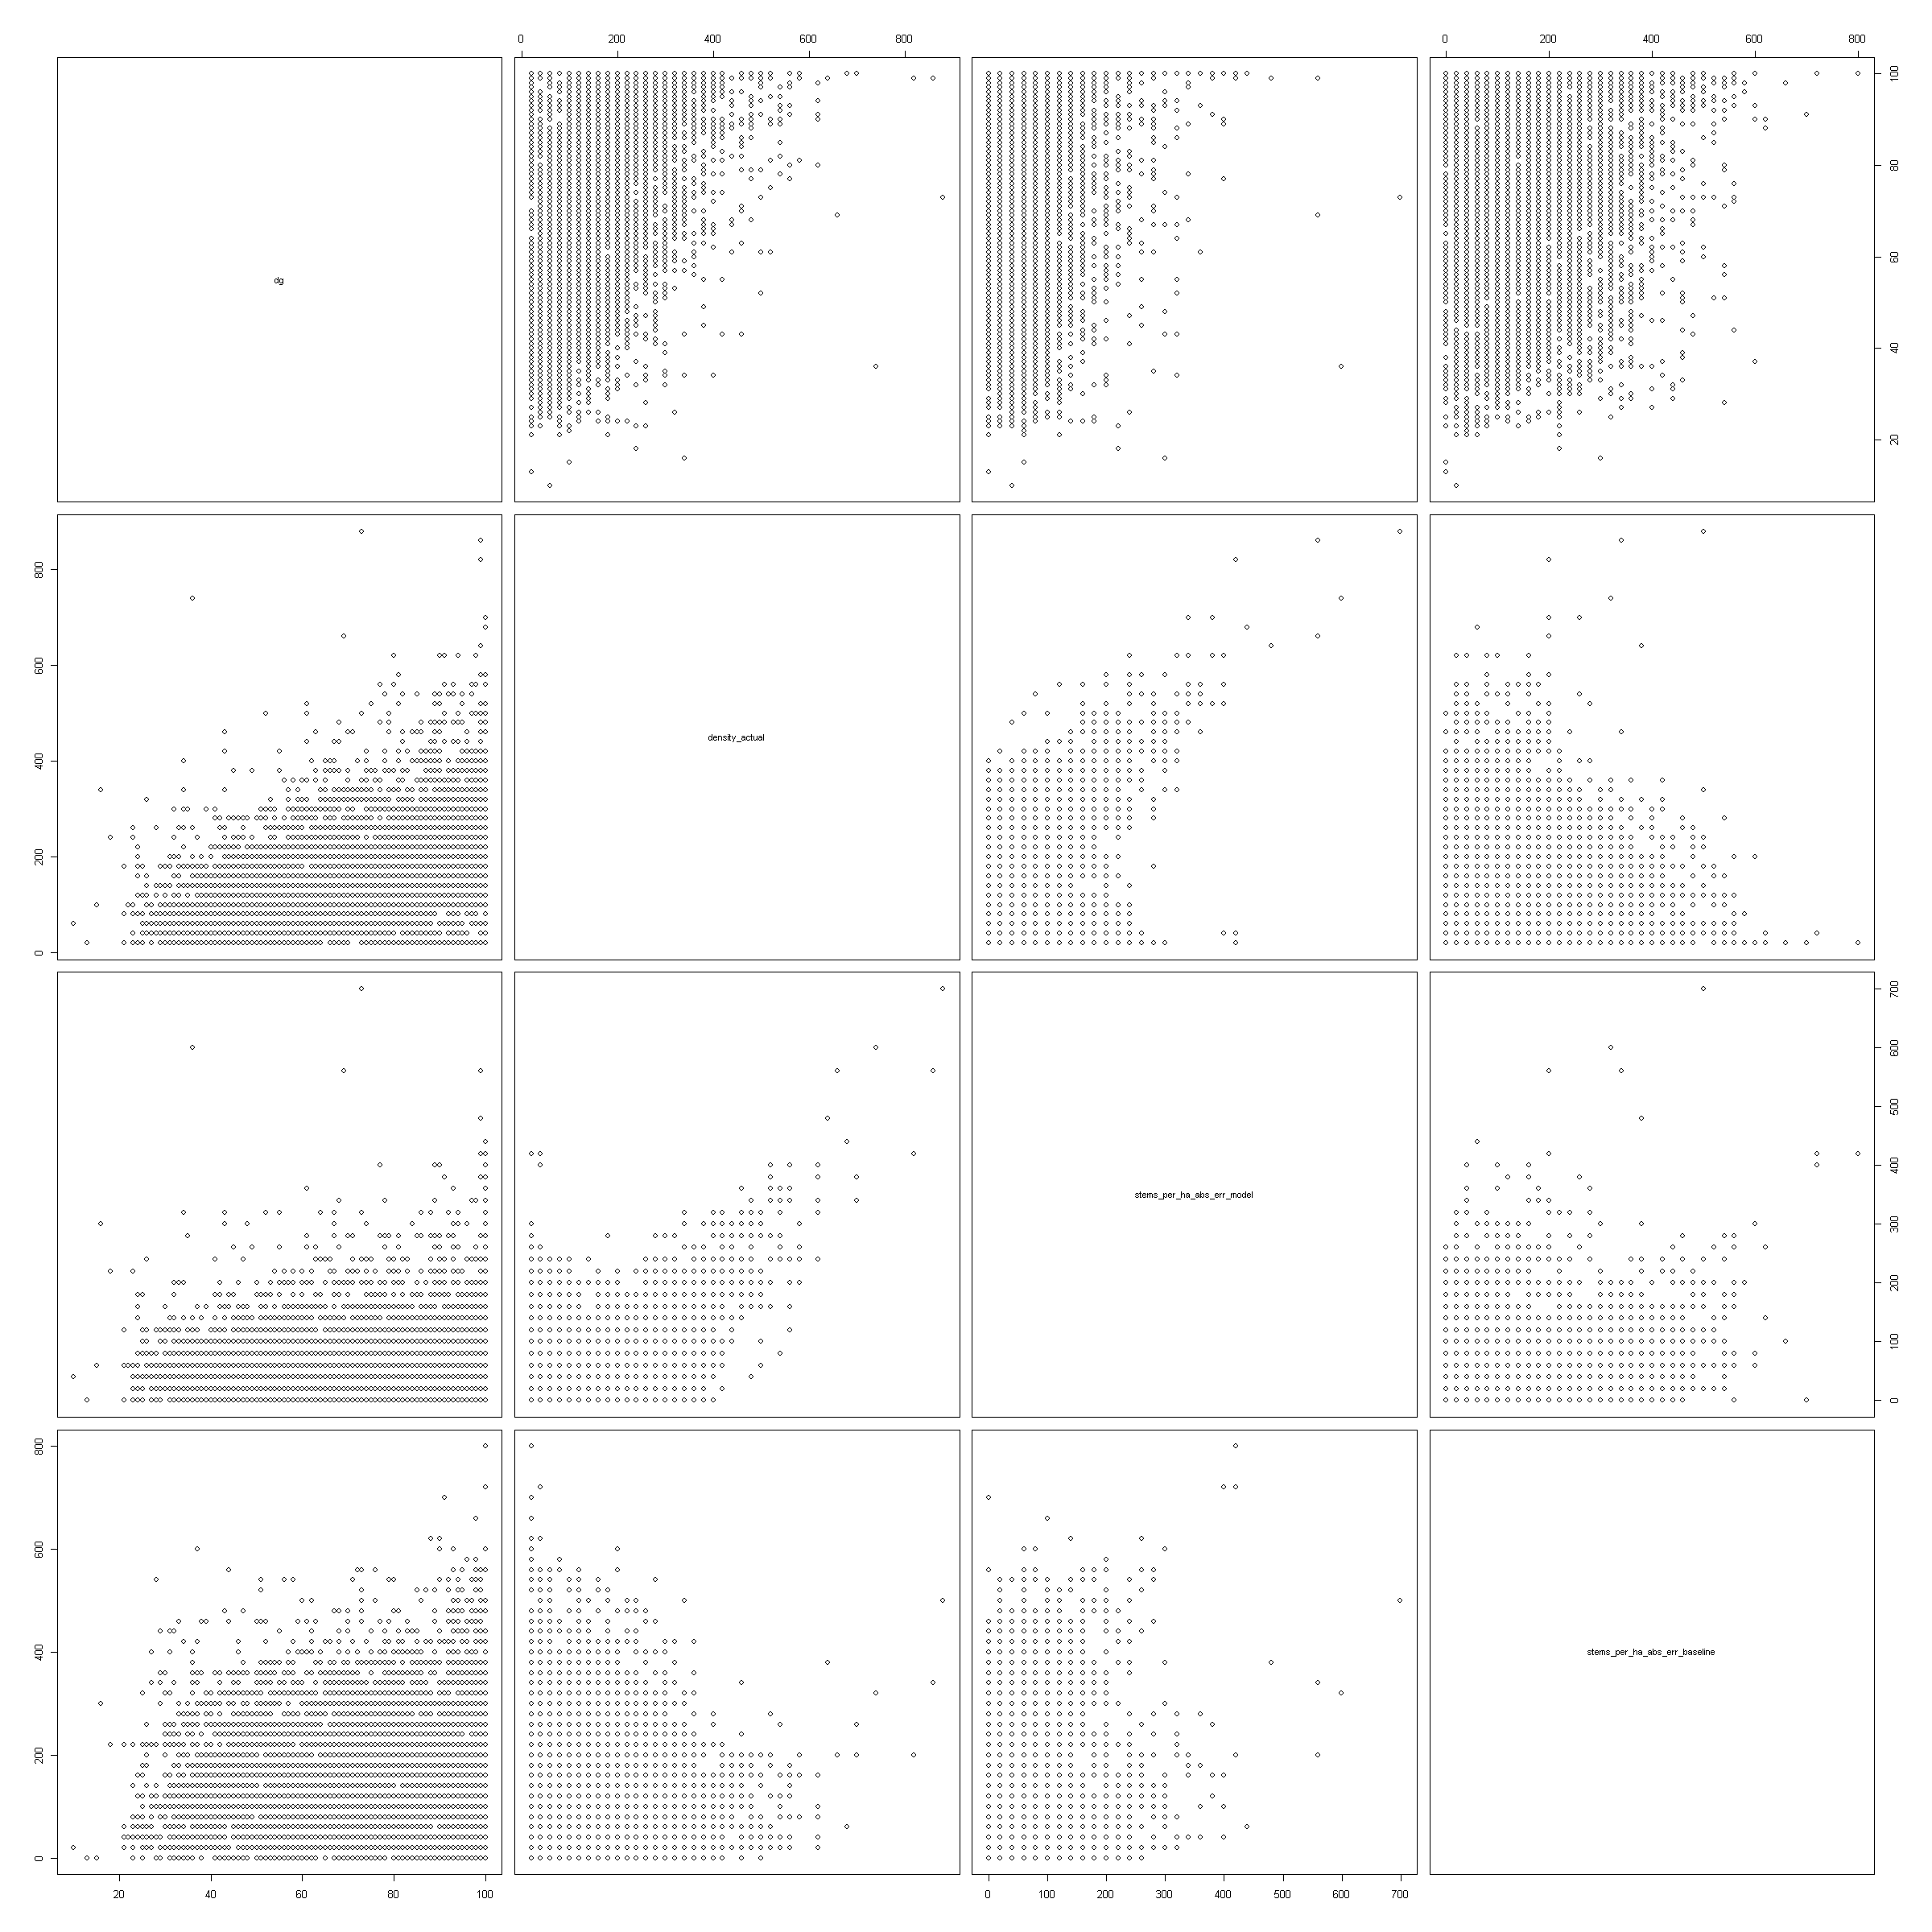

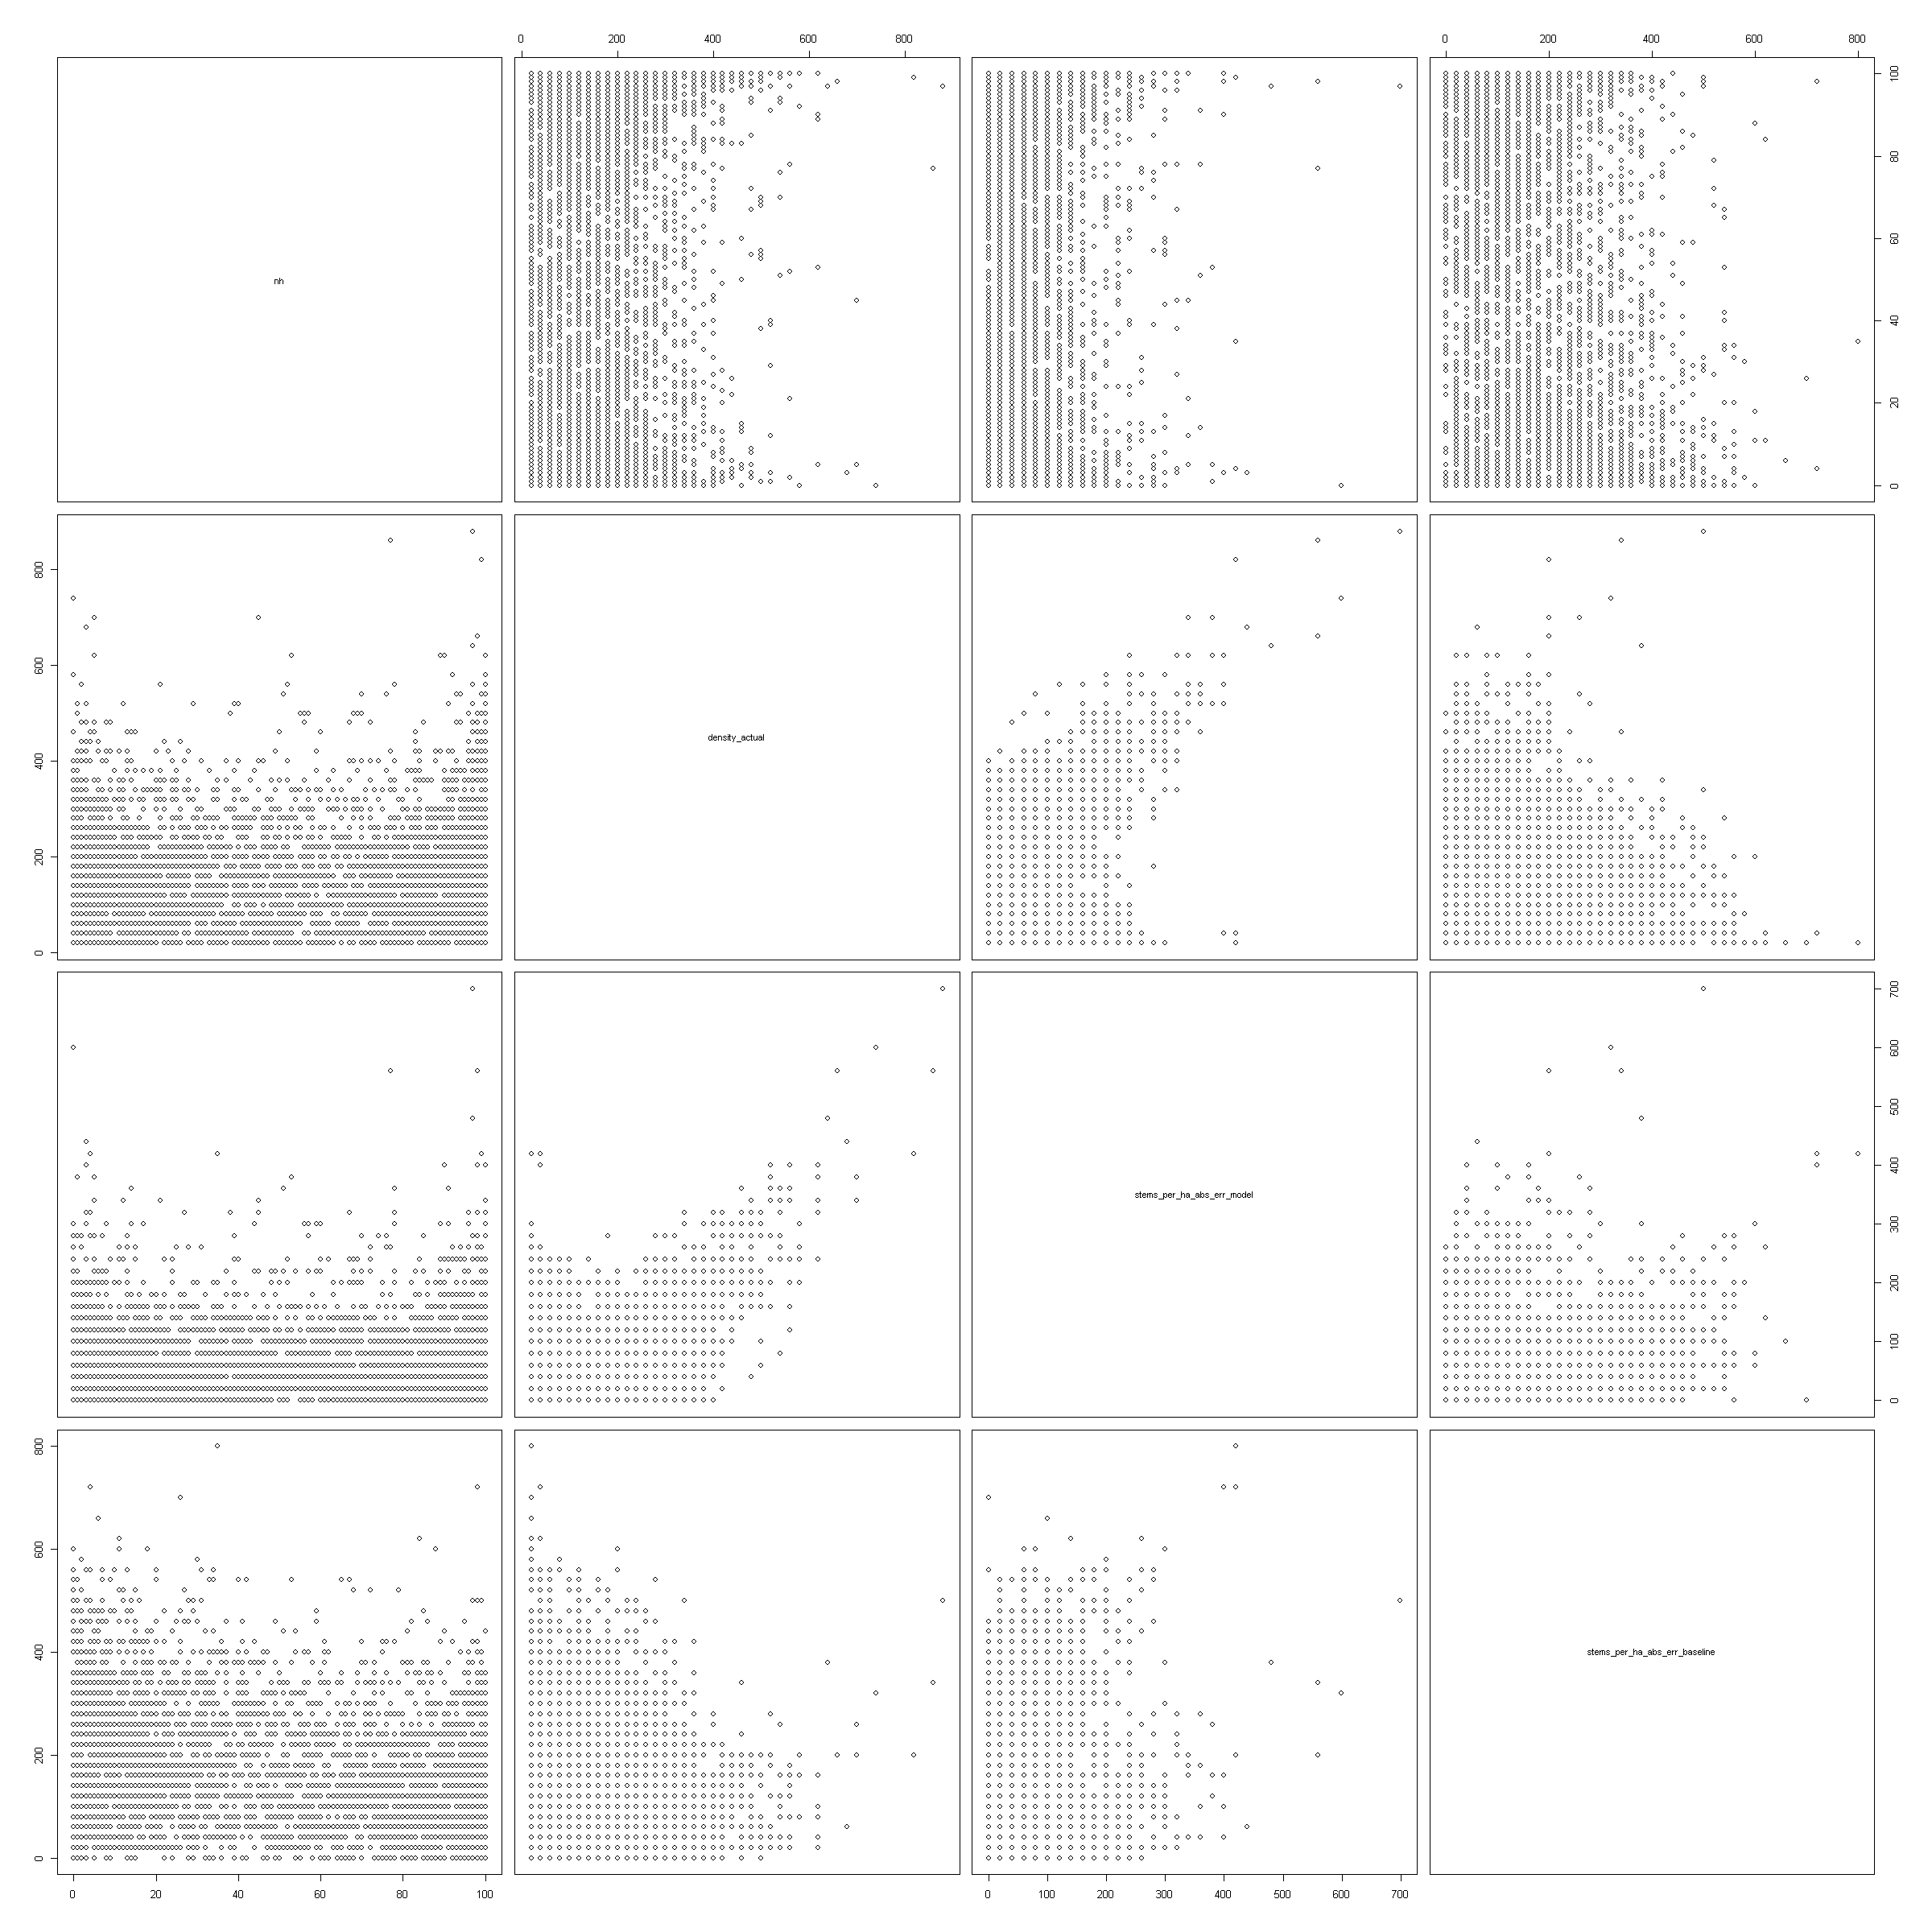

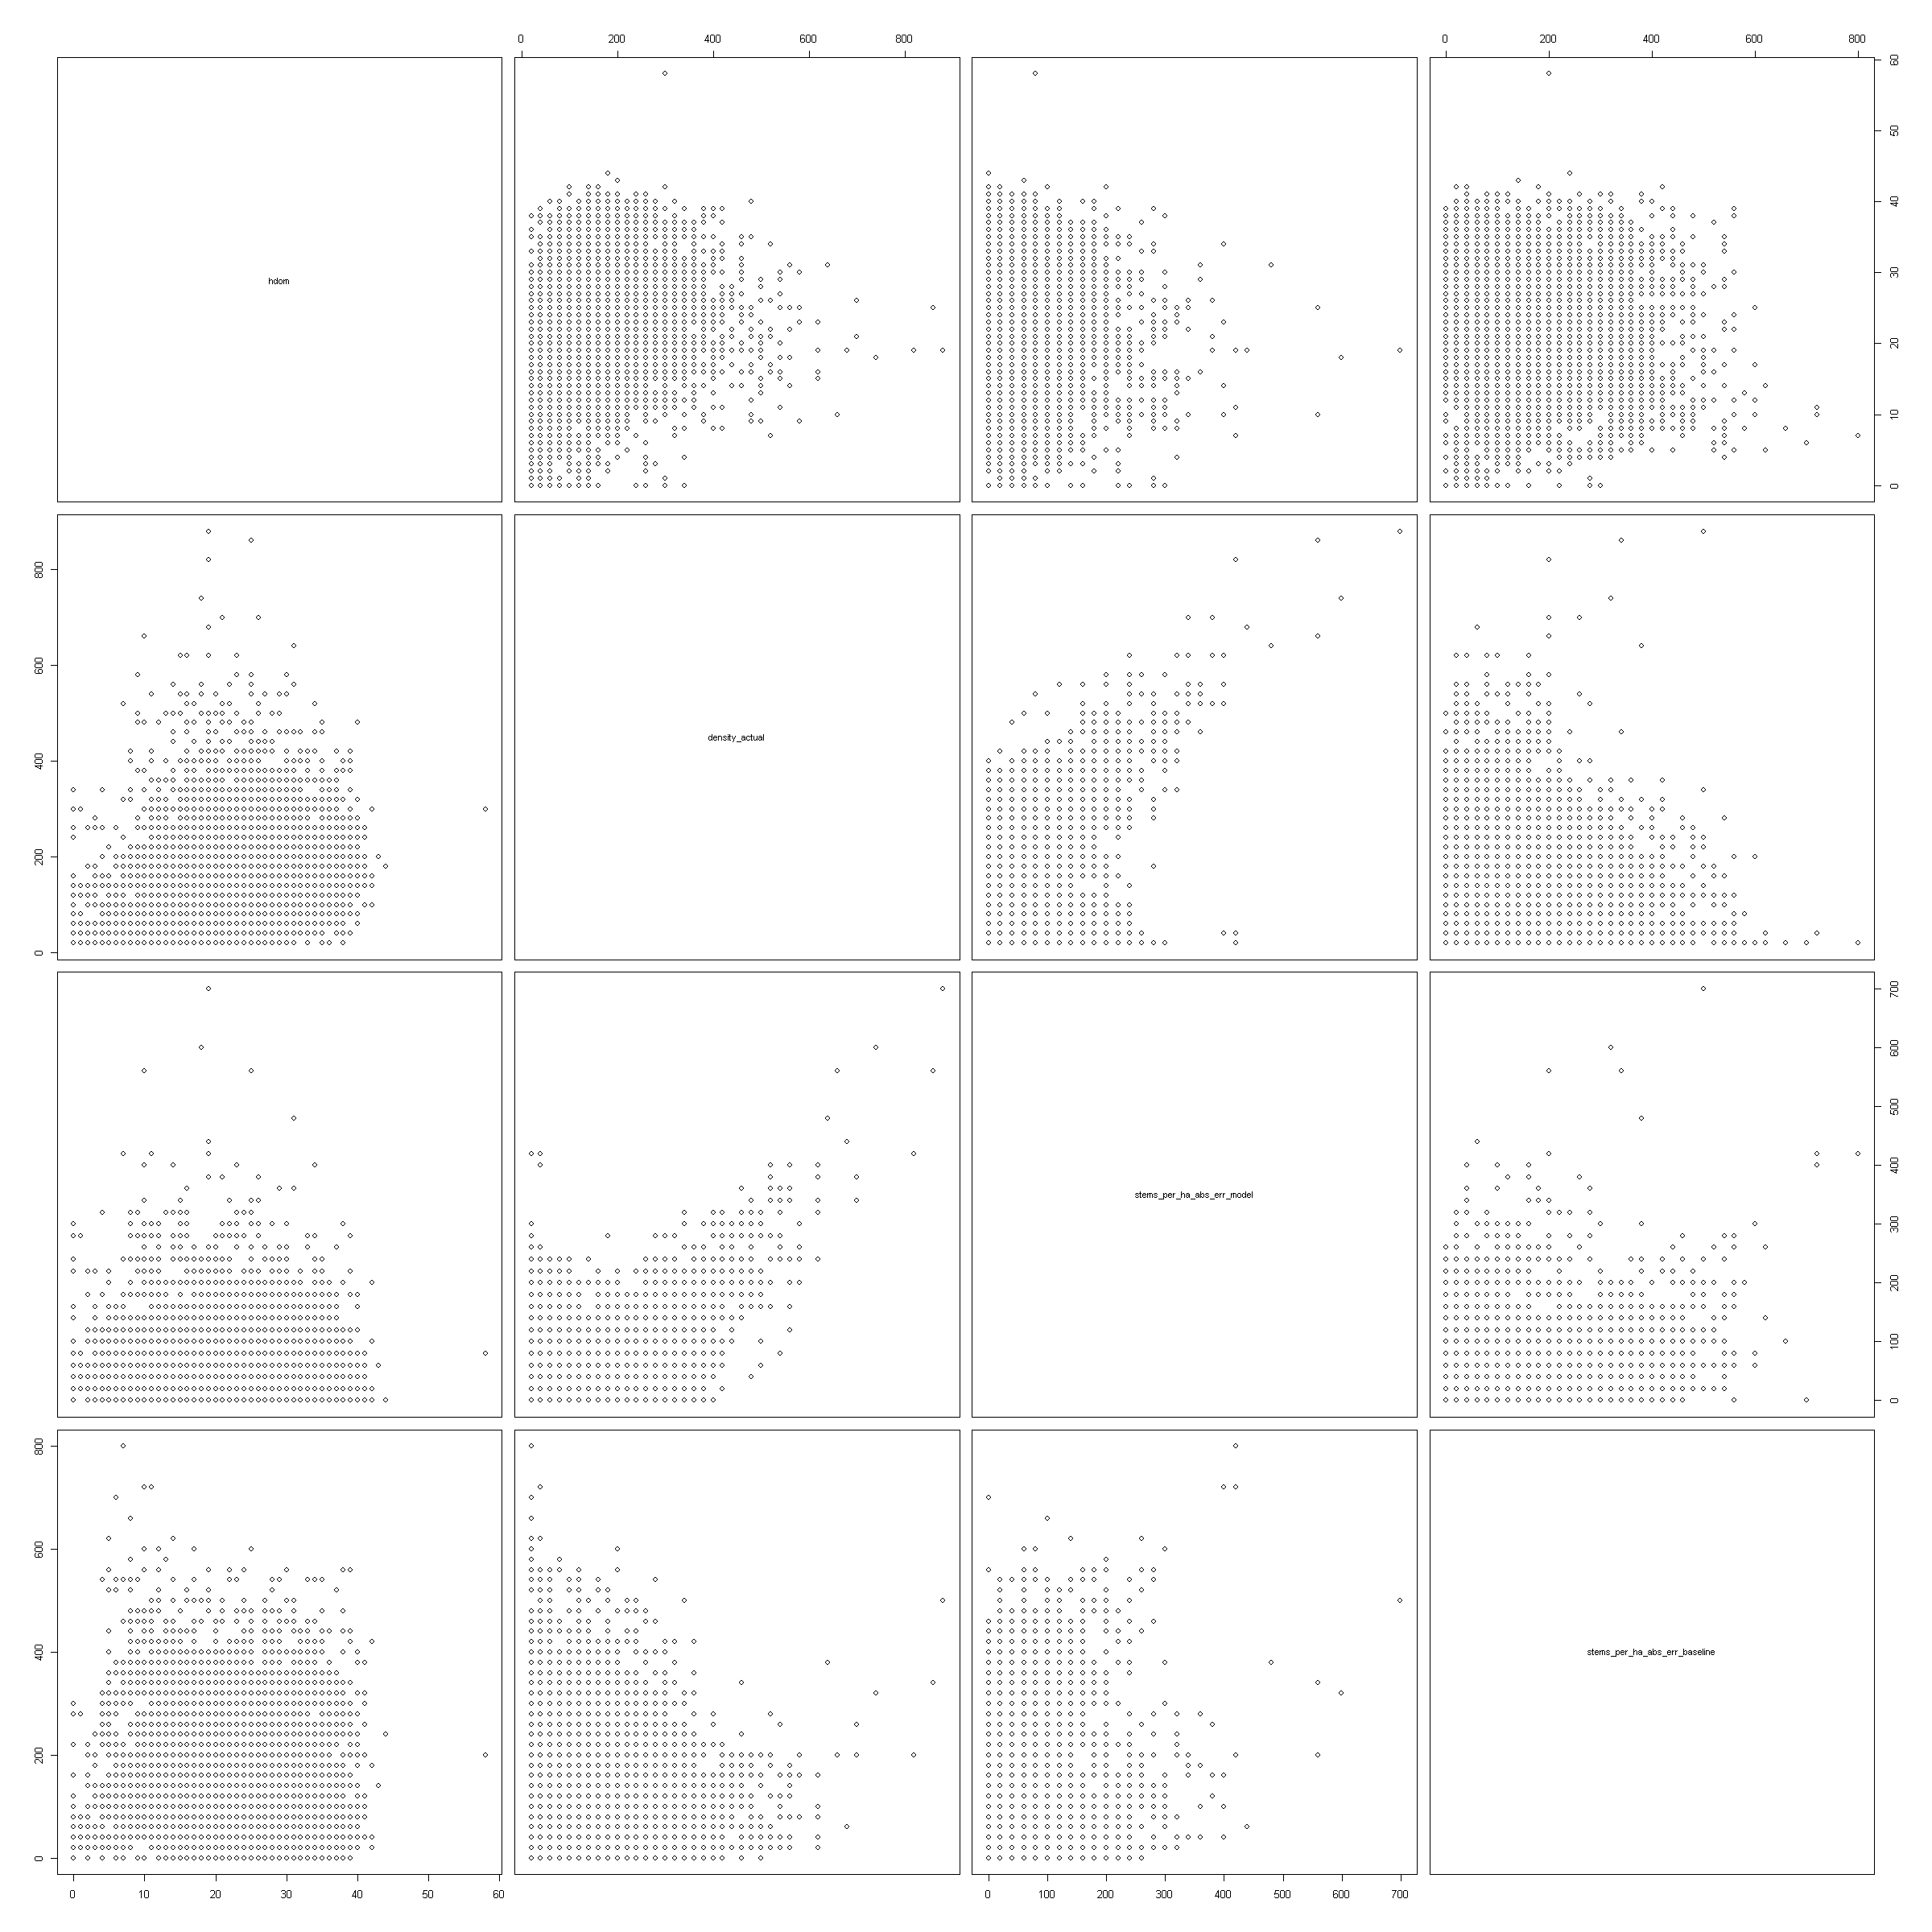

In [77]:
# Some pair plots
options(repr.plot.width=20, repr.plot.height=20)

pairs(data[,c( 'dg', 'nh', 'hdom', 'density_actual')])

pairs(data[,c( 'dg', 'density_actual', 'stems_per_ha_abs_err_model', 'stems_per_ha_abs_err_baseline')])
pairs(data[,c( 'nh', 'density_actual', 'stems_per_ha_abs_err_model', 'stems_per_ha_abs_err_baseline')])
pairs(data[,c( 'hdom', 'density_actual', 'stems_per_ha_abs_err_model', 'stems_per_ha_abs_err_baseline')])

In [78]:
# Number of Plots by NH Class
data %>%
group_by(fst_nh) %>%
summarise(n = n(), per = n()/nrow(data))

# Number of Plots by DC Class
data %>%
group_by(fst_dg) %>%
summarise(n = n(), per = n()/nrow(data))

# Number of Plots by HDOM Class
data %>%
group_by(fst_hdom) %>%
summarise(n = n(), per = n()/nrow(data))

fst_nh n    per      
1 1      1853 0.3526837
2 2       978 0.1861439
3 3      2423 0.4611724

fst_dg n    per      
1 1      3362 0.6398934
2 2      1892 0.3601066

fst_hdom n    per      
1 1        2383 0.4535592
2 2        2871 0.5464408

In [79]:
# Build a data frame for box plots
df <- do.call( "rbind",list(
    data.frame(fst_dg=data$fst_dg,fst_nh=data$fst_nh,fst_hdom=data$fst_hdom, variable="density_actual", value=data$density_actual ),
    data.frame(fst_dg=data$fst_dg,fst_nh=data$fst_nh,fst_hdom=data$fst_hdom, variable="stems_per_ha_err_baseline", value=data$stems_per_ha_err_baseline ),
    data.frame(fst_dg=data$fst_dg,fst_nh=data$fst_nh,fst_hdom=data$fst_hdom, variable="stems_per_ha_err_model", value=data$stems_per_ha_err_model ),
    data.frame(fst_dg=data$fst_dg,fst_nh=data$fst_nh,fst_hdom=data$fst_hdom, variable="stems_per_ha_abs_err_baseline", value=data$stems_per_ha_abs_err_baseline ),
    data.frame(fst_dg=data$fst_dg,fst_nh=data$fst_nh,fst_hdom=data$fst_hdom, variable="stems_per_ha_abs_err_model", value=data$stems_per_ha_abs_err_model )
    ))


In [80]:
df$nh_label <- unlist(lapply(df$fst_nh, function(x) nh_lookup_labels$val[x]))       
df$dg_label <- unlist(lapply(df$fst_dg, function(x) dg_lookup_labels$val[x]))
df$hdom_label <- unlist(lapply(df$fst_hdom, function(x) hdom_lookup_labels$val[x]))


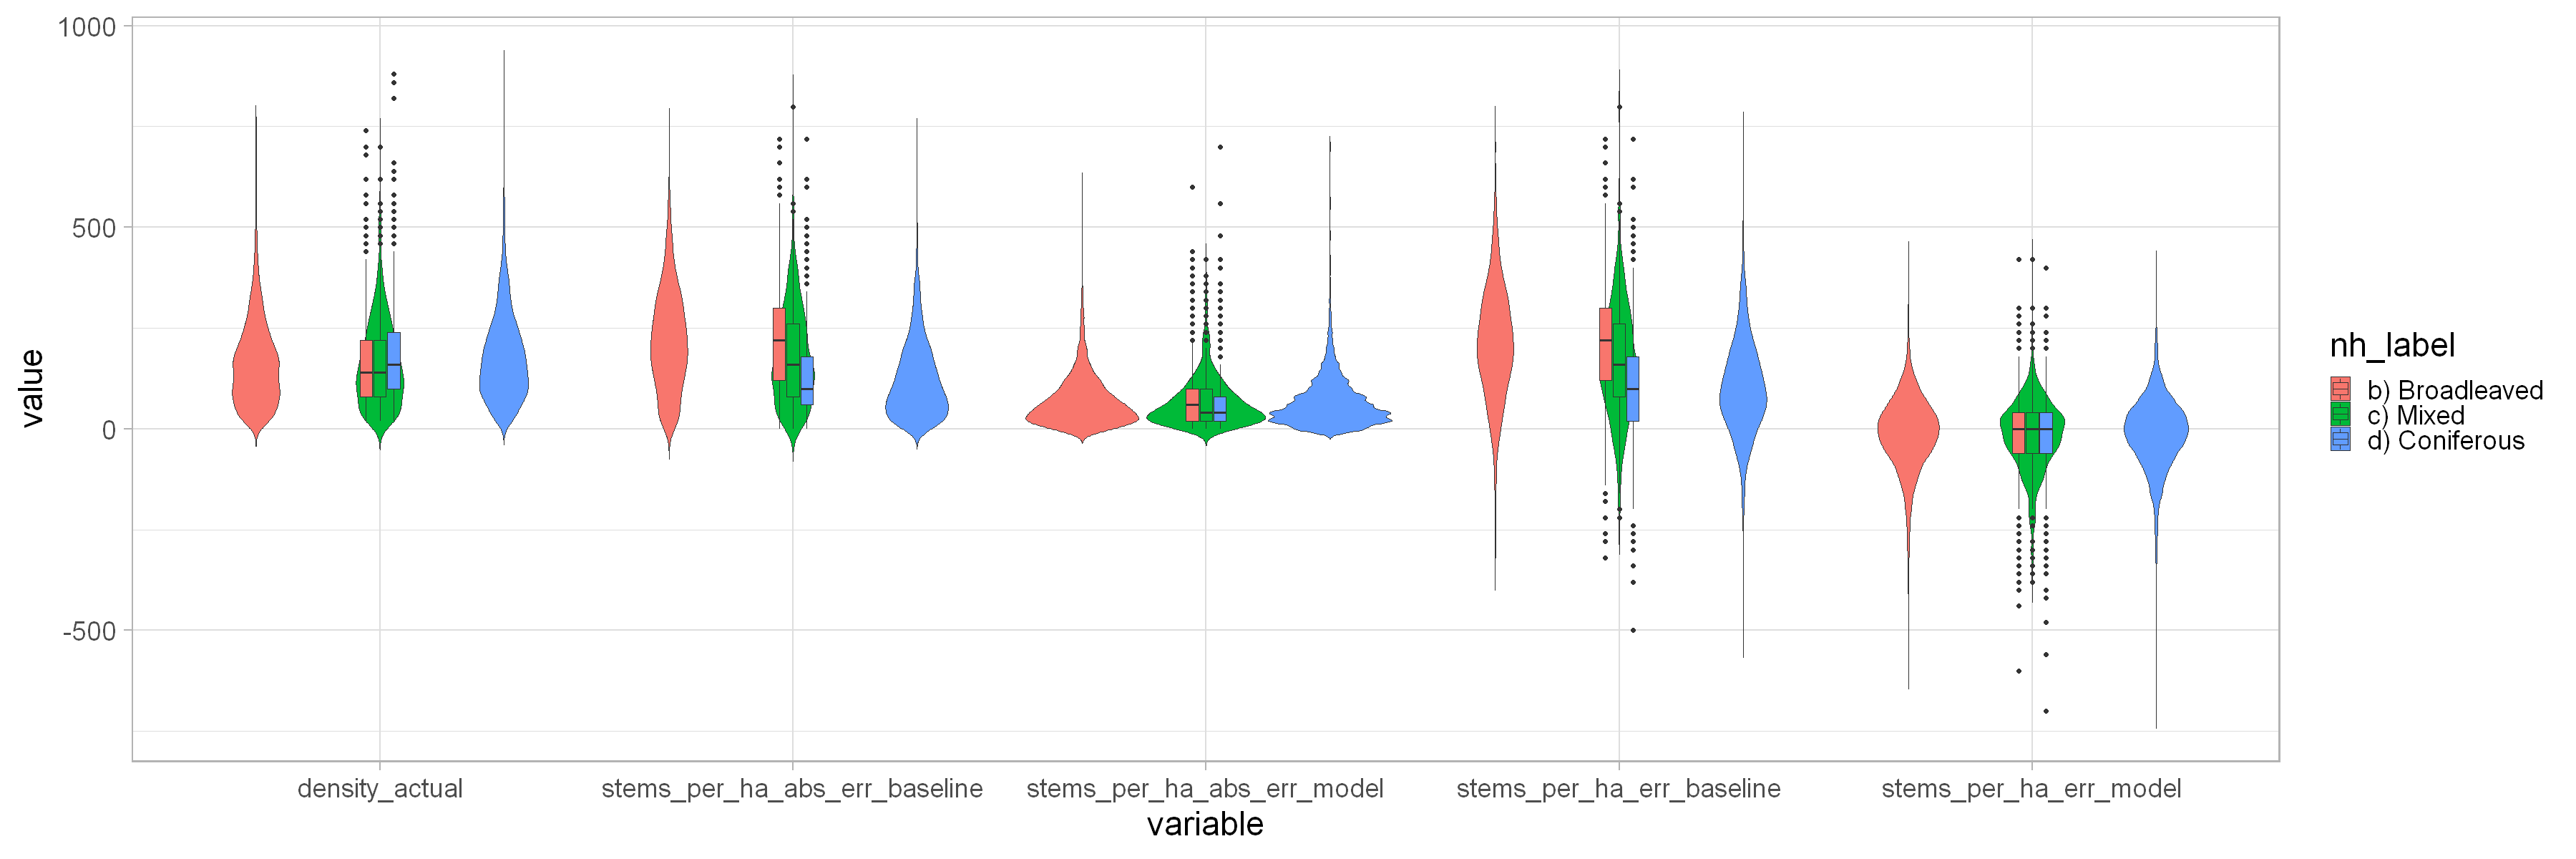

In [81]:
# Differentiated by mixing degree classes 1: nh<=30% ; 2: 30%<nh<=70% ; 3: nh>70%
options(repr.plot.width=30, repr.plot.height=10)

ggplot(df, aes(x=variable, y=value, fill=nh_label)) +
  geom_violin(trim=FALSE)+
  geom_boxplot(width=0.1)+
  theme_light(base_size = font_base_size) 


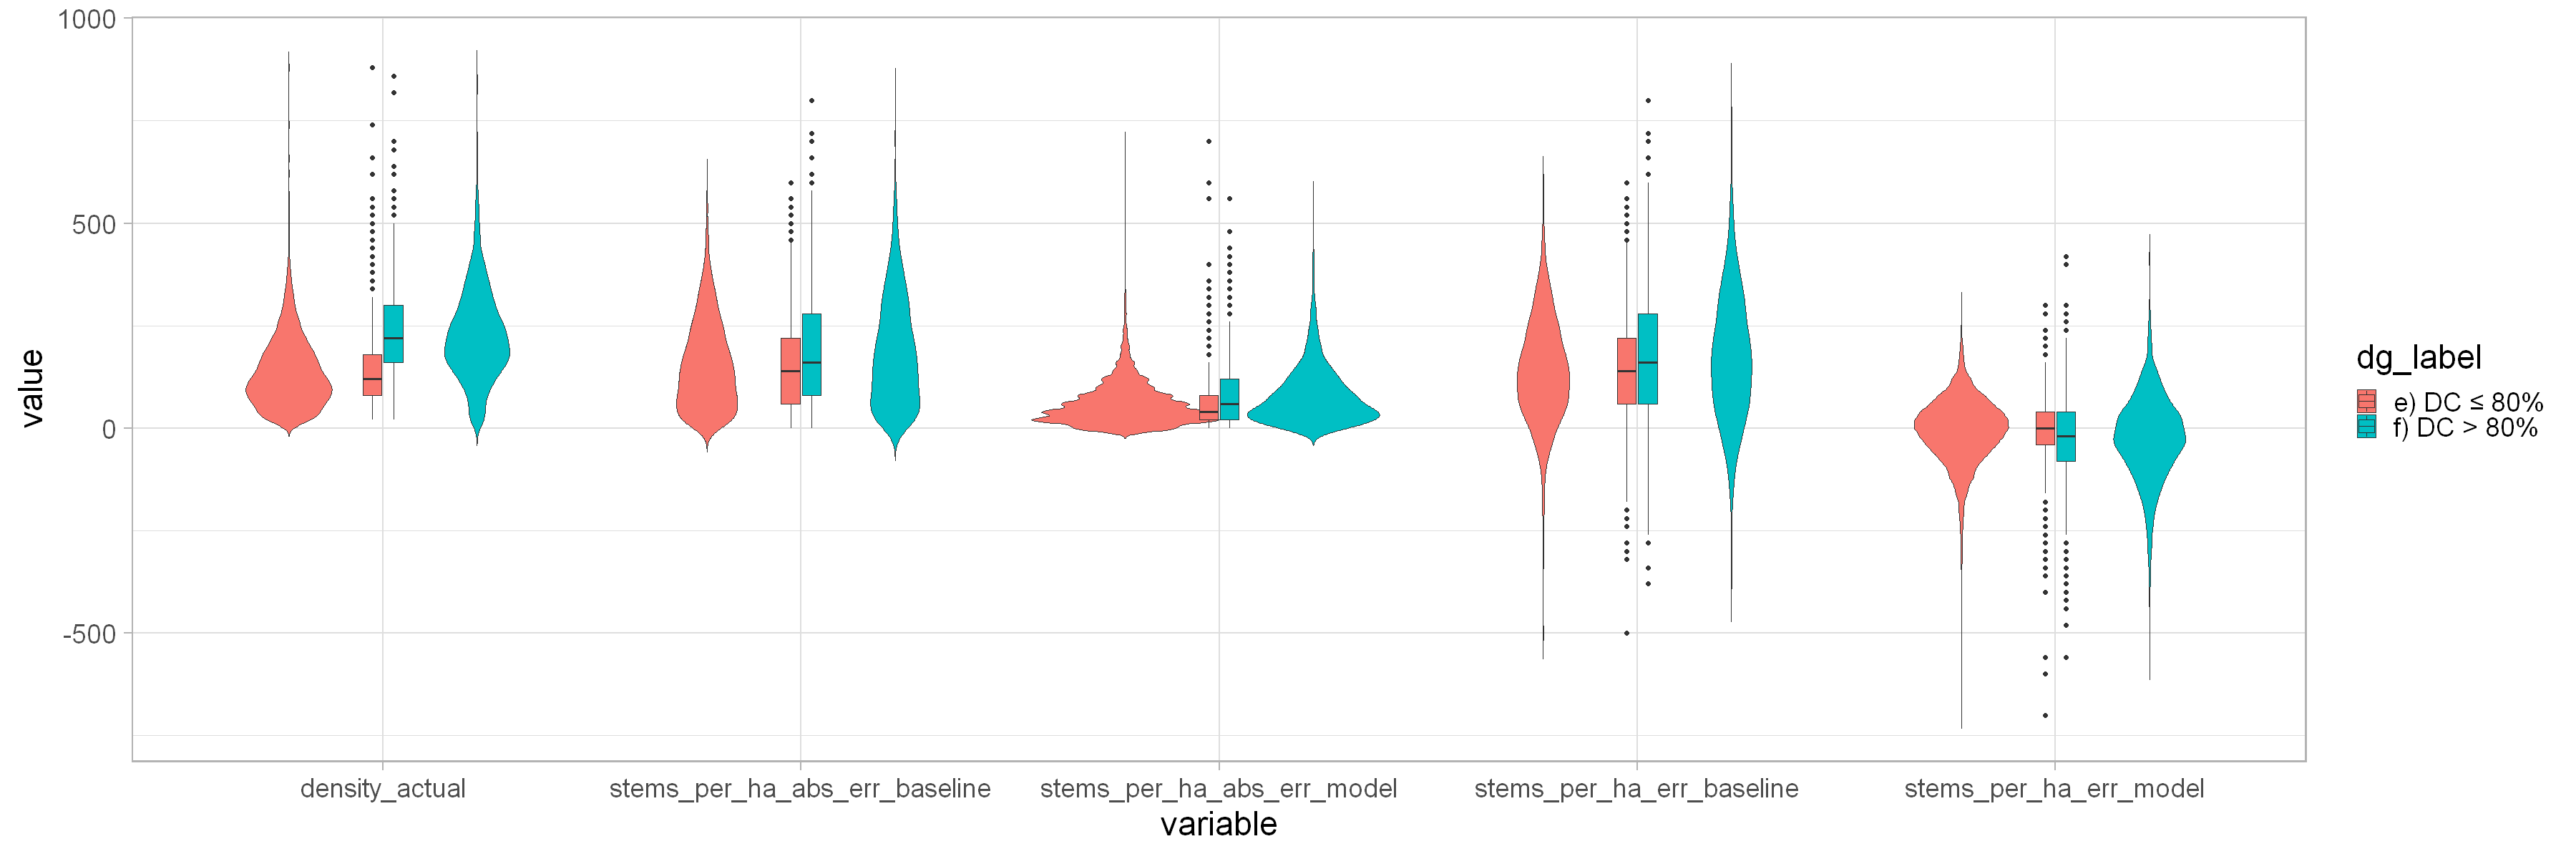

In [82]:
# Differentiated by degree of cover classes 1: dg <= 80% ; dg > 80%
options(repr.plot.width=30, repr.plot.height=10)

ggplot(df, aes(x=variable, y=value, fill=dg_label)) +
  geom_violin(trim=FALSE)+
  geom_boxplot(width=0.1)+
  theme_light(base_size = font_base_size) 

Warning message:
"Removed 7 rows containing non-finite values (stat_ydensity)."
Warning message:
"Removed 7 rows containing non-finite values (stat_boxplot)."
Warning message:
"Removed 110 rows containing missing values (geom_violin)."


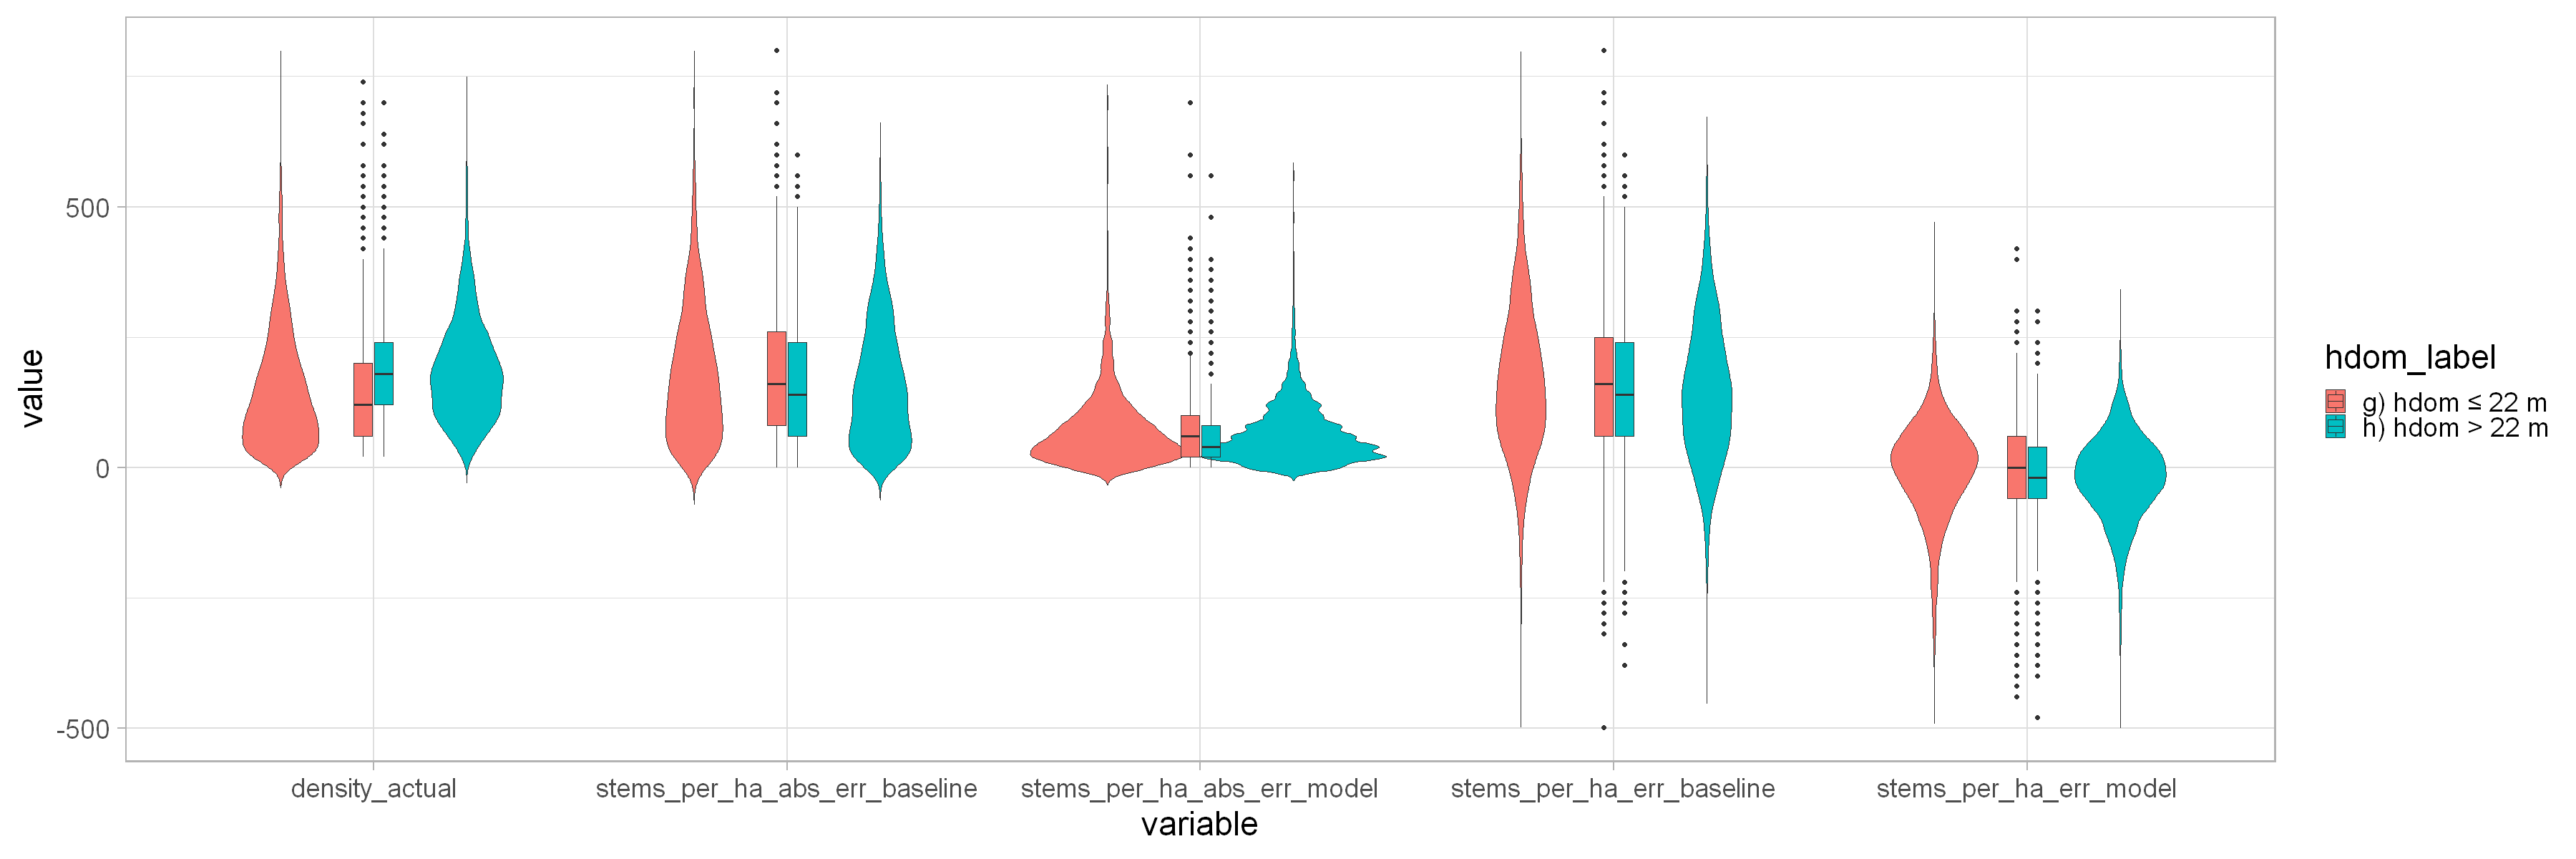

In [83]:
# Differentiated by dominant height classes 1: hdom <= 22 m ; hdom > 22 m
options(repr.plot.width=30, repr.plot.height=10)

ggplot(df, aes(x=variable, y=value, fill=hdom_label)) +
  geom_violin(trim=FALSE)+
  geom_boxplot(width=0.1)+
  ylim(-500,800) +
  theme_light(base_size = font_base_size) 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



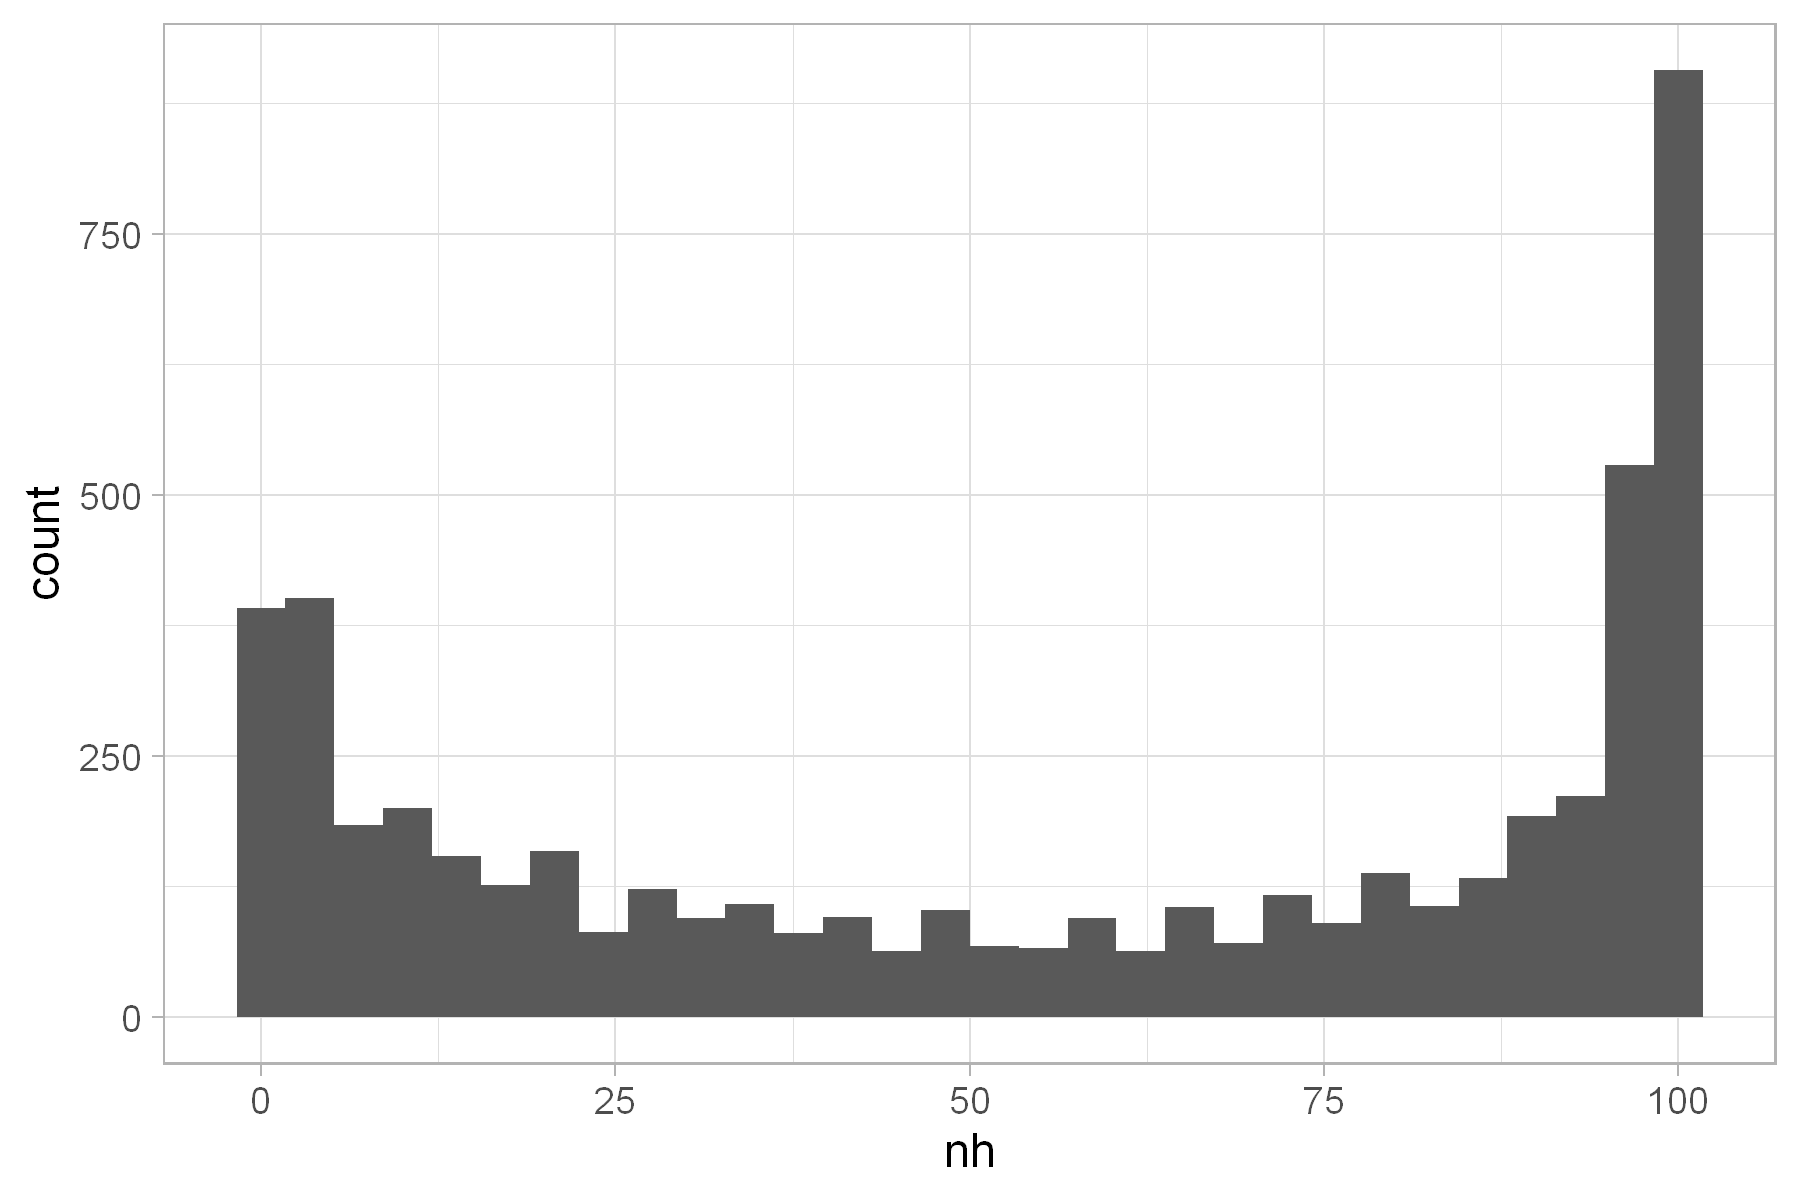

In [84]:
# Histogram of Coniferous Proportion
options(repr.plot.width=15, repr.plot.height=10)

ggplot(data, aes(x=nh)) +
  geom_histogram()+
  theme_light(base_size = font_base_size) 


Warning message:
"Removed 38 rows containing non-finite values (stat_density2d)."
Warning message:
"Removed 38 rows containing non-finite values (stat_density2d)."
Warning message:
"Removed 396 rows containing missing values (geom_raster)."
Warning message:
"Removed 38 rows containing missing values (geom_point)."
Warning message:
"Removed 50 rows containing non-finite values (stat_density2d)."
Warning message:
"Removed 50 rows containing non-finite values (stat_density2d)."
Warning message:
"Removed 396 rows containing missing values (geom_raster)."
Warning message:
"Removed 50 rows containing missing values (geom_point)."


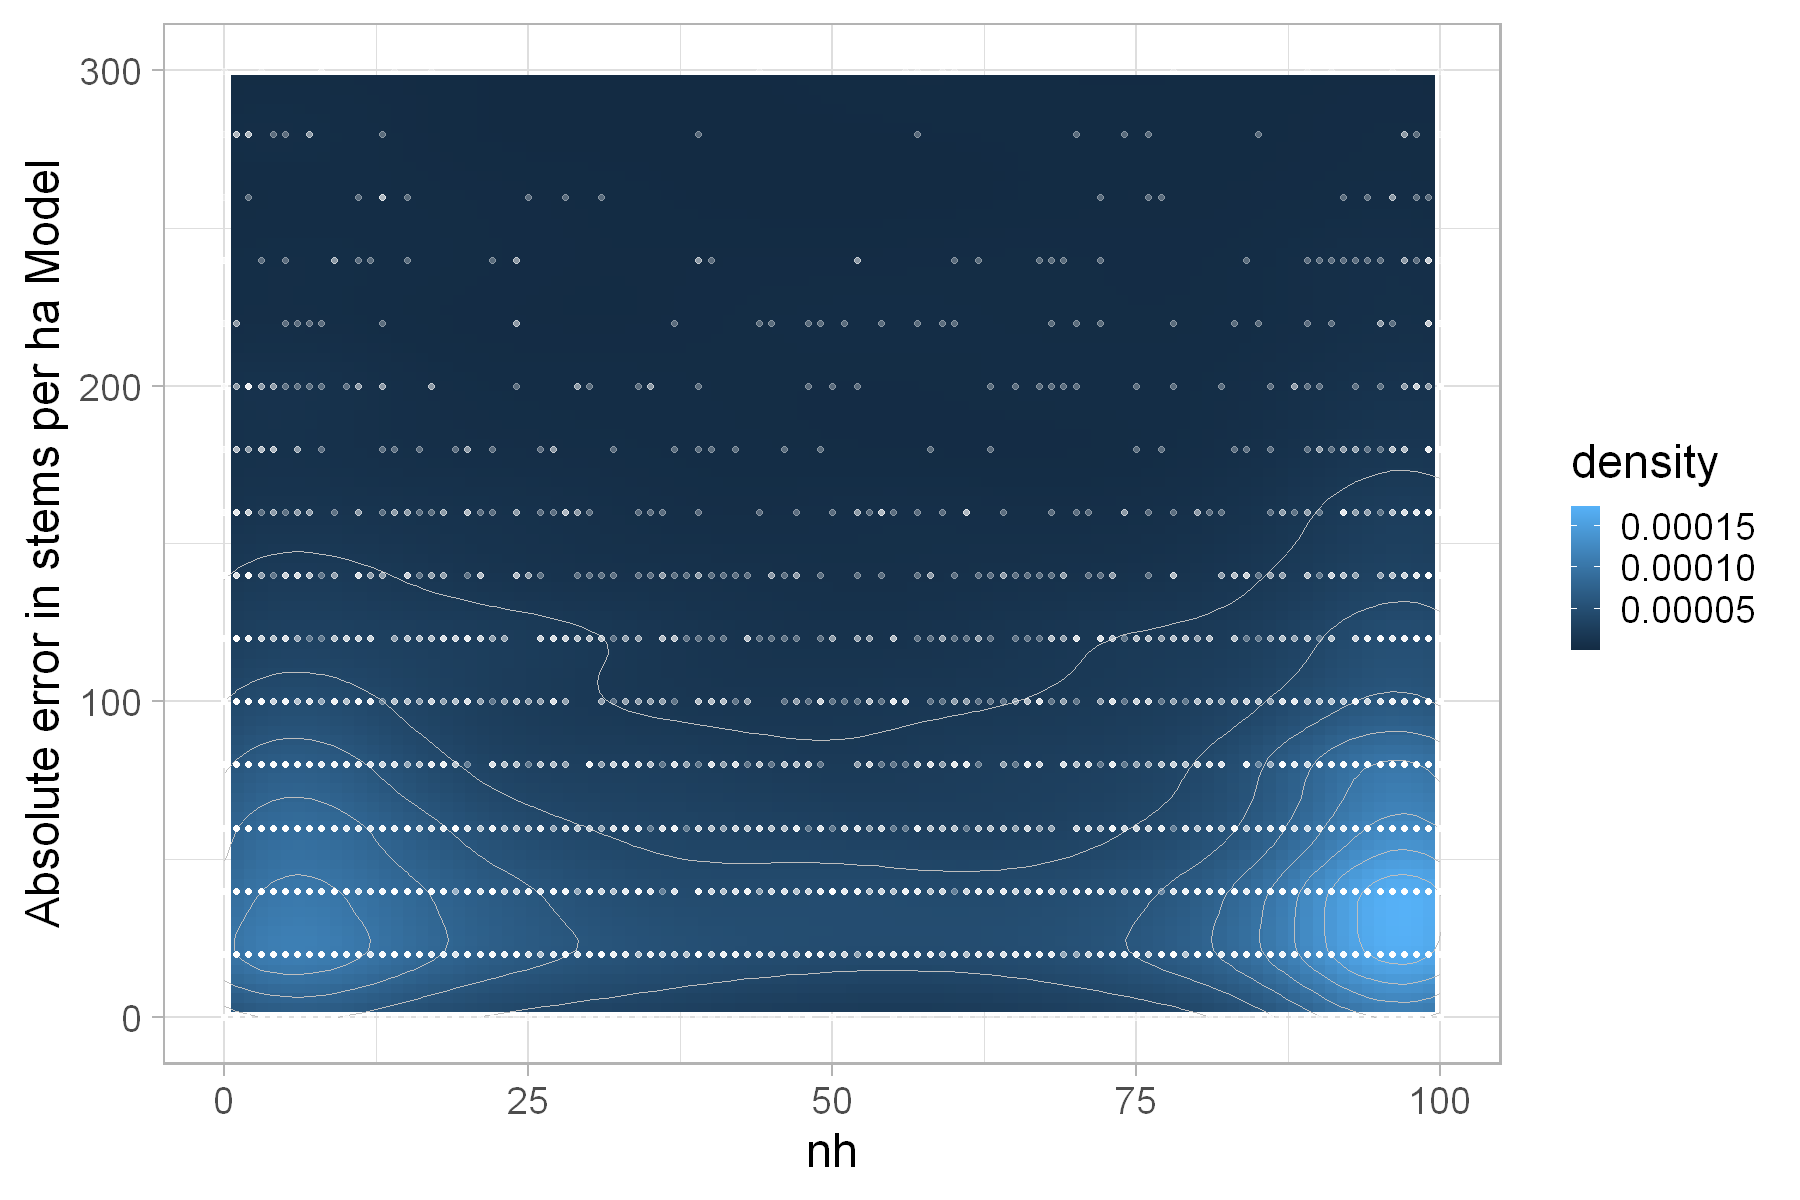

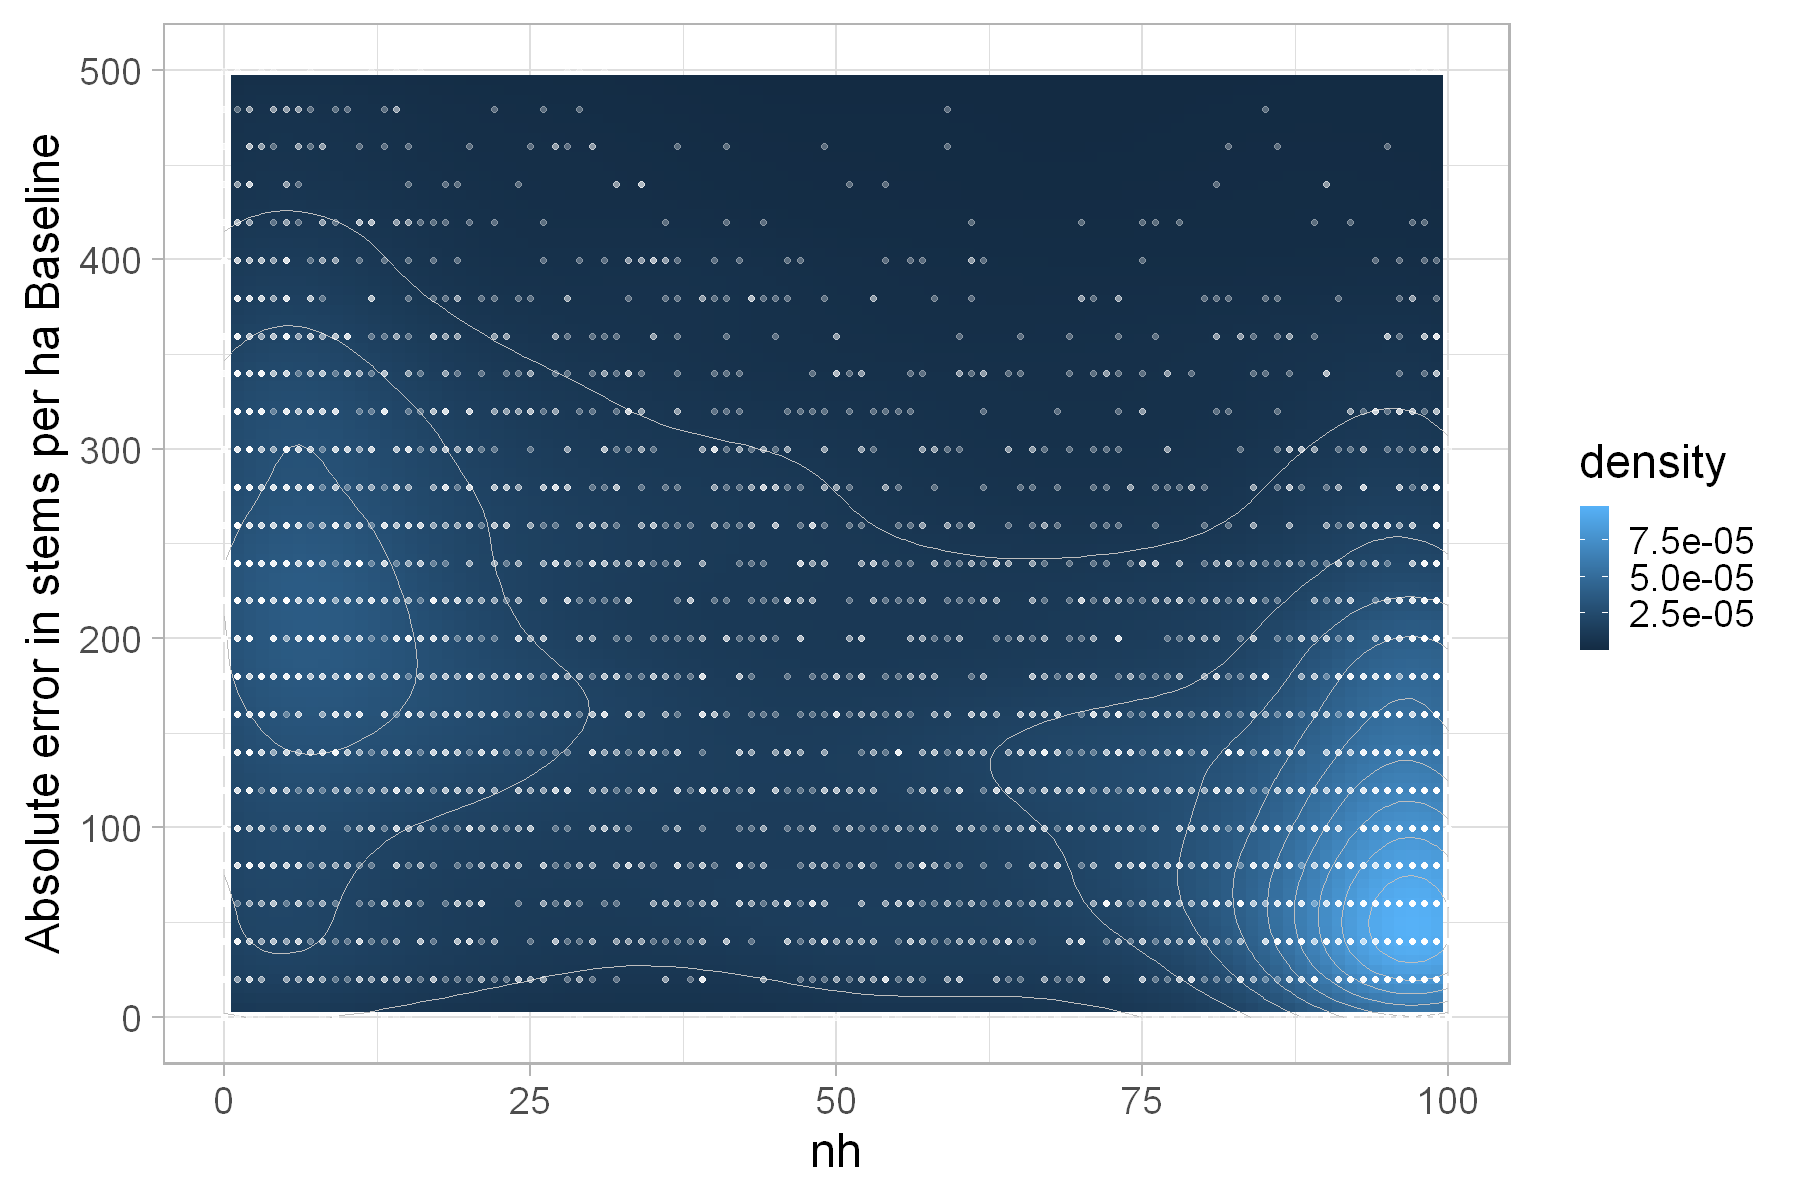

In [85]:
#Scatterplot Coniferous proportion vs Absolute Error Model
ggplot(data, aes(x=nh, y=stems_per_ha_abs_err_model)) +
  stat_density_2d(aes(fill = ..density..), geom = "raster", contour = FALSE)+
  geom_density_2d(color="gray")+
  geom_point(alpha=0.3, color="white") +
  xlim(0,100) +
  ylim(0,300) +
  # theme(text = element_text(size = 18)) +
  theme_light(base_size = font_base_size) +
  ylab("Absolute error in stems per ha Model") 

#Scatterplot Coniferous proportion vs Absolute Error Baseline
options(repr.plot.width=15, repr.plot.height=10)

ggplot(data, aes(x=nh, y=stems_per_ha_abs_err_baseline)) +
  stat_density_2d(aes(fill = ..density..), geom = "raster", contour = FALSE)+
  geom_density_2d(color="gray")+
  geom_point(alpha=0.3, color="white") +
  xlim(0,100) +
  ylim(0,500) +
  # theme(text = element_text(size = 18)) +
  theme_light(base_size = font_base_size) +
  ylab("Absolute error in stems per ha Baseline") 


Warning message:
"Removed 20 rows containing non-finite values (stat_boxplot)."
Warning message:
"Removed 5 rows containing non-finite values (stat_boxplot)."


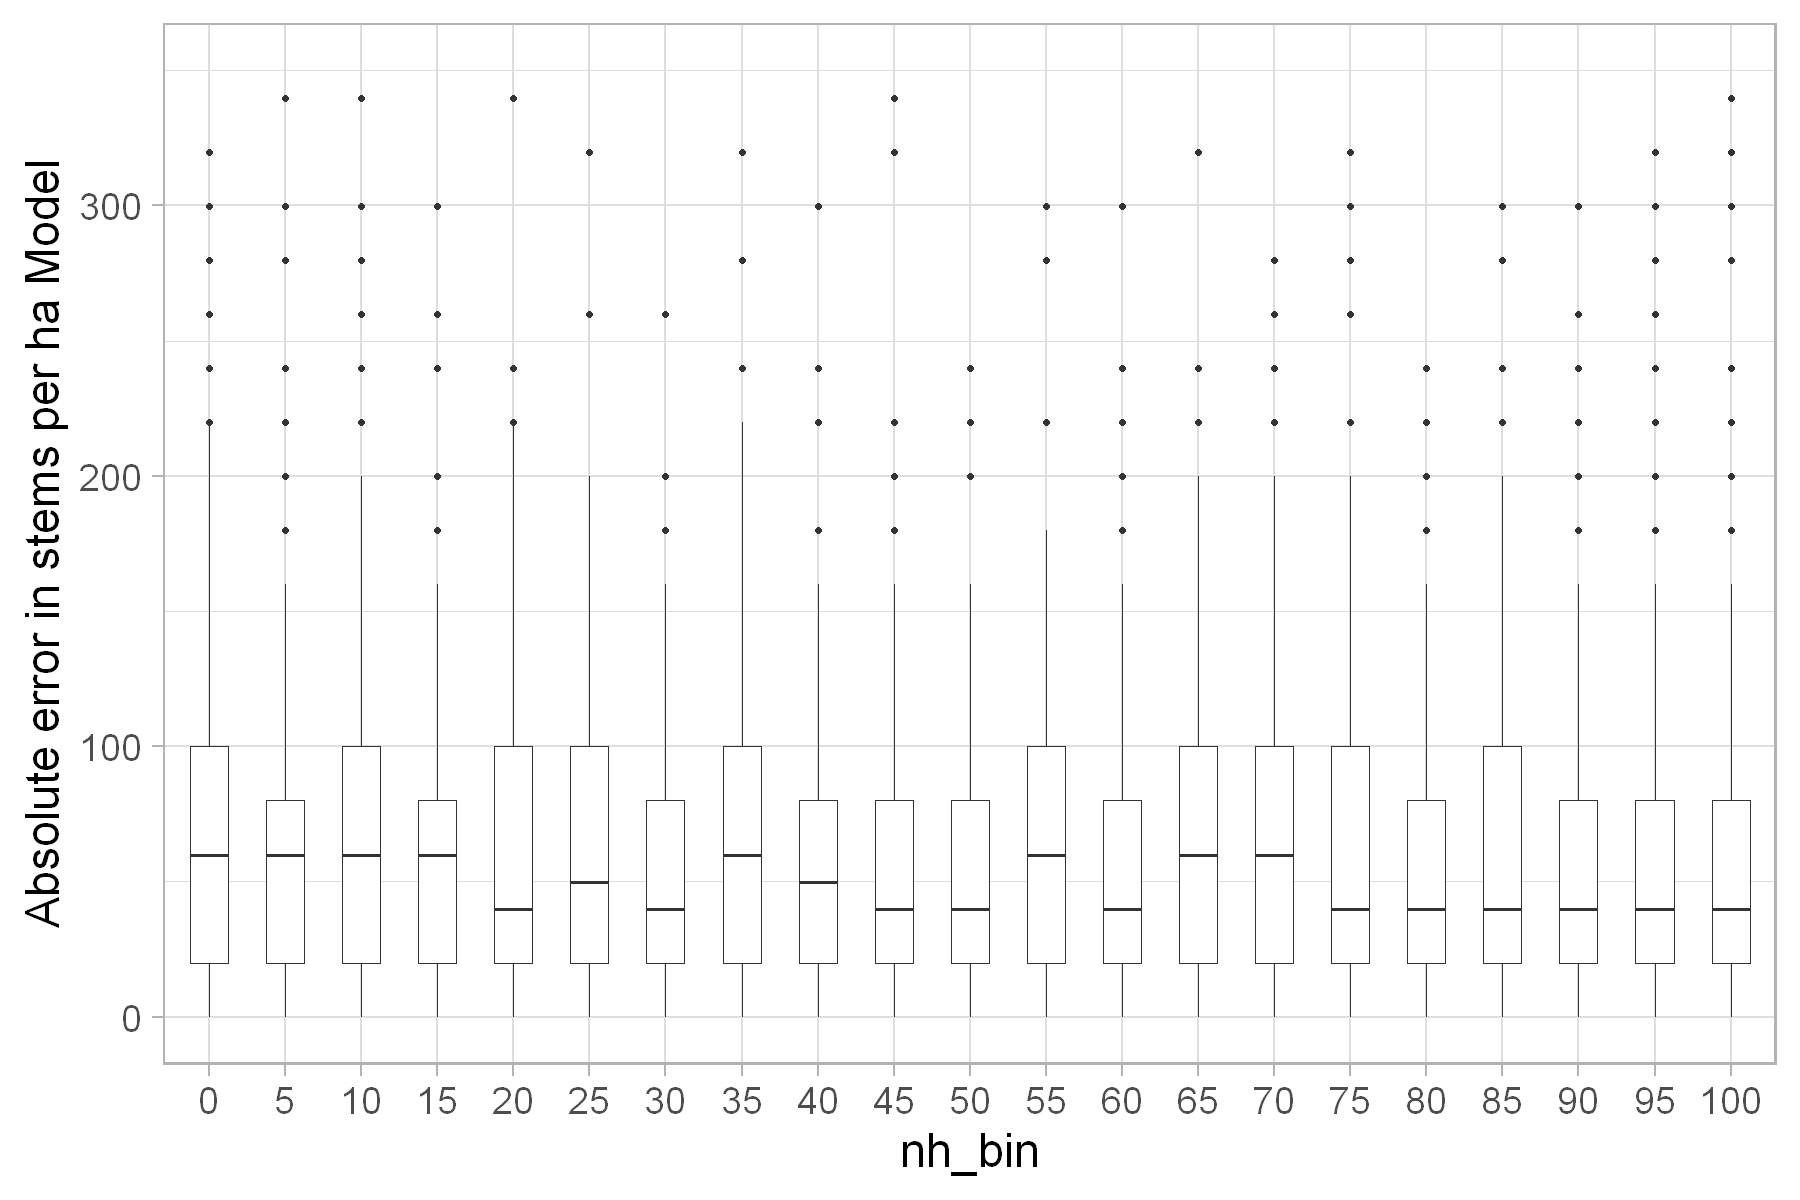

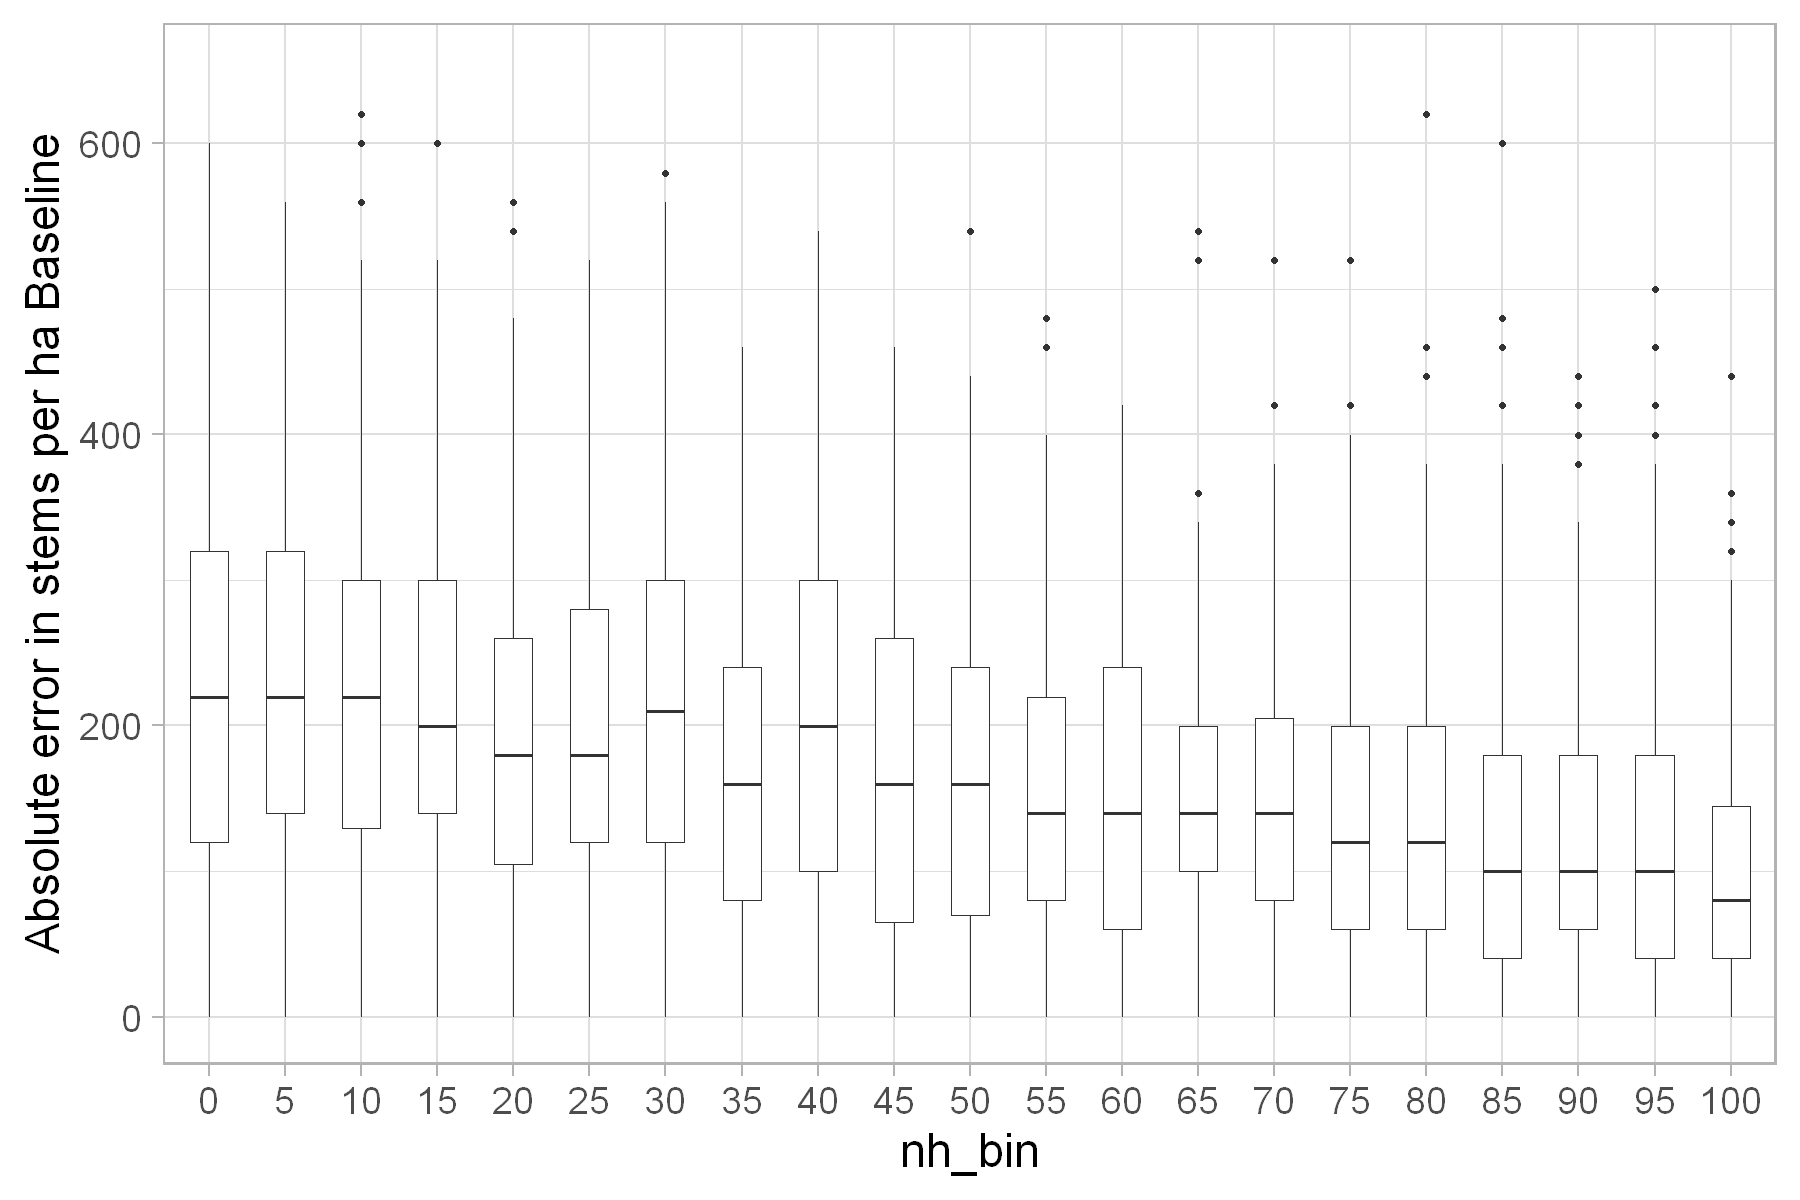

In [86]:
# Boxplots by binned coniferous proportion 0 = [0%,5%[, 5 = [5%,10%[ ...
options(repr.plot.width=15, repr.plot.height=10)

ggplot(data, aes(x=nh_bin, y=stems_per_ha_abs_err_model)) +
#   geom_violin(trim=FALSE)+
  geom_boxplot(width=0.5)+
  ylim(0,350) +
  theme_light(base_size = font_base_size) +
  ylab("Absolute error in stems per ha Model") 

# Boxplots by binned coniferous proportion 0 = [0%,5%[, 5 = [5%,10%[ ...
options(repr.plot.width=15, repr.plot.height=10)

ggplot(data, aes(x=nh_bin, y=stems_per_ha_abs_err_baseline)) +
#   geom_violin(trim=FALSE)+
  geom_boxplot(width=0.5)+
  ylim(0,650) +
  theme_light(base_size = font_base_size) +
  ylab("Absolute error in stems per ha Baseline") 



Warning message:
"Removed 557 rows containing non-finite values (stat_density2d)."
Warning message:
"Removed 557 rows containing non-finite values (stat_density2d)."
`geom_smooth()` using formula 'y ~ x'

Warning message:
"Removed 557 rows containing non-finite values (stat_smooth)."
Warning message:
"Removed 396 rows containing missing values (geom_raster)."
Warning message:
"Removed 557 rows containing missing values (geom_point)."
Warning message:
"Removed 1478 rows containing non-finite values (stat_density2d)."
Warning message:
"Removed 1478 rows containing non-finite values (stat_density2d)."
`geom_smooth()` using formula 'y ~ x'

Warning message:
"Removed 1478 rows containing non-finite values (stat_smooth)."
Warning message:
"Removed 396 rows containing missing values (geom_raster)."
Warning message:
"Removed 1478 rows containing missing values (geom_point)."


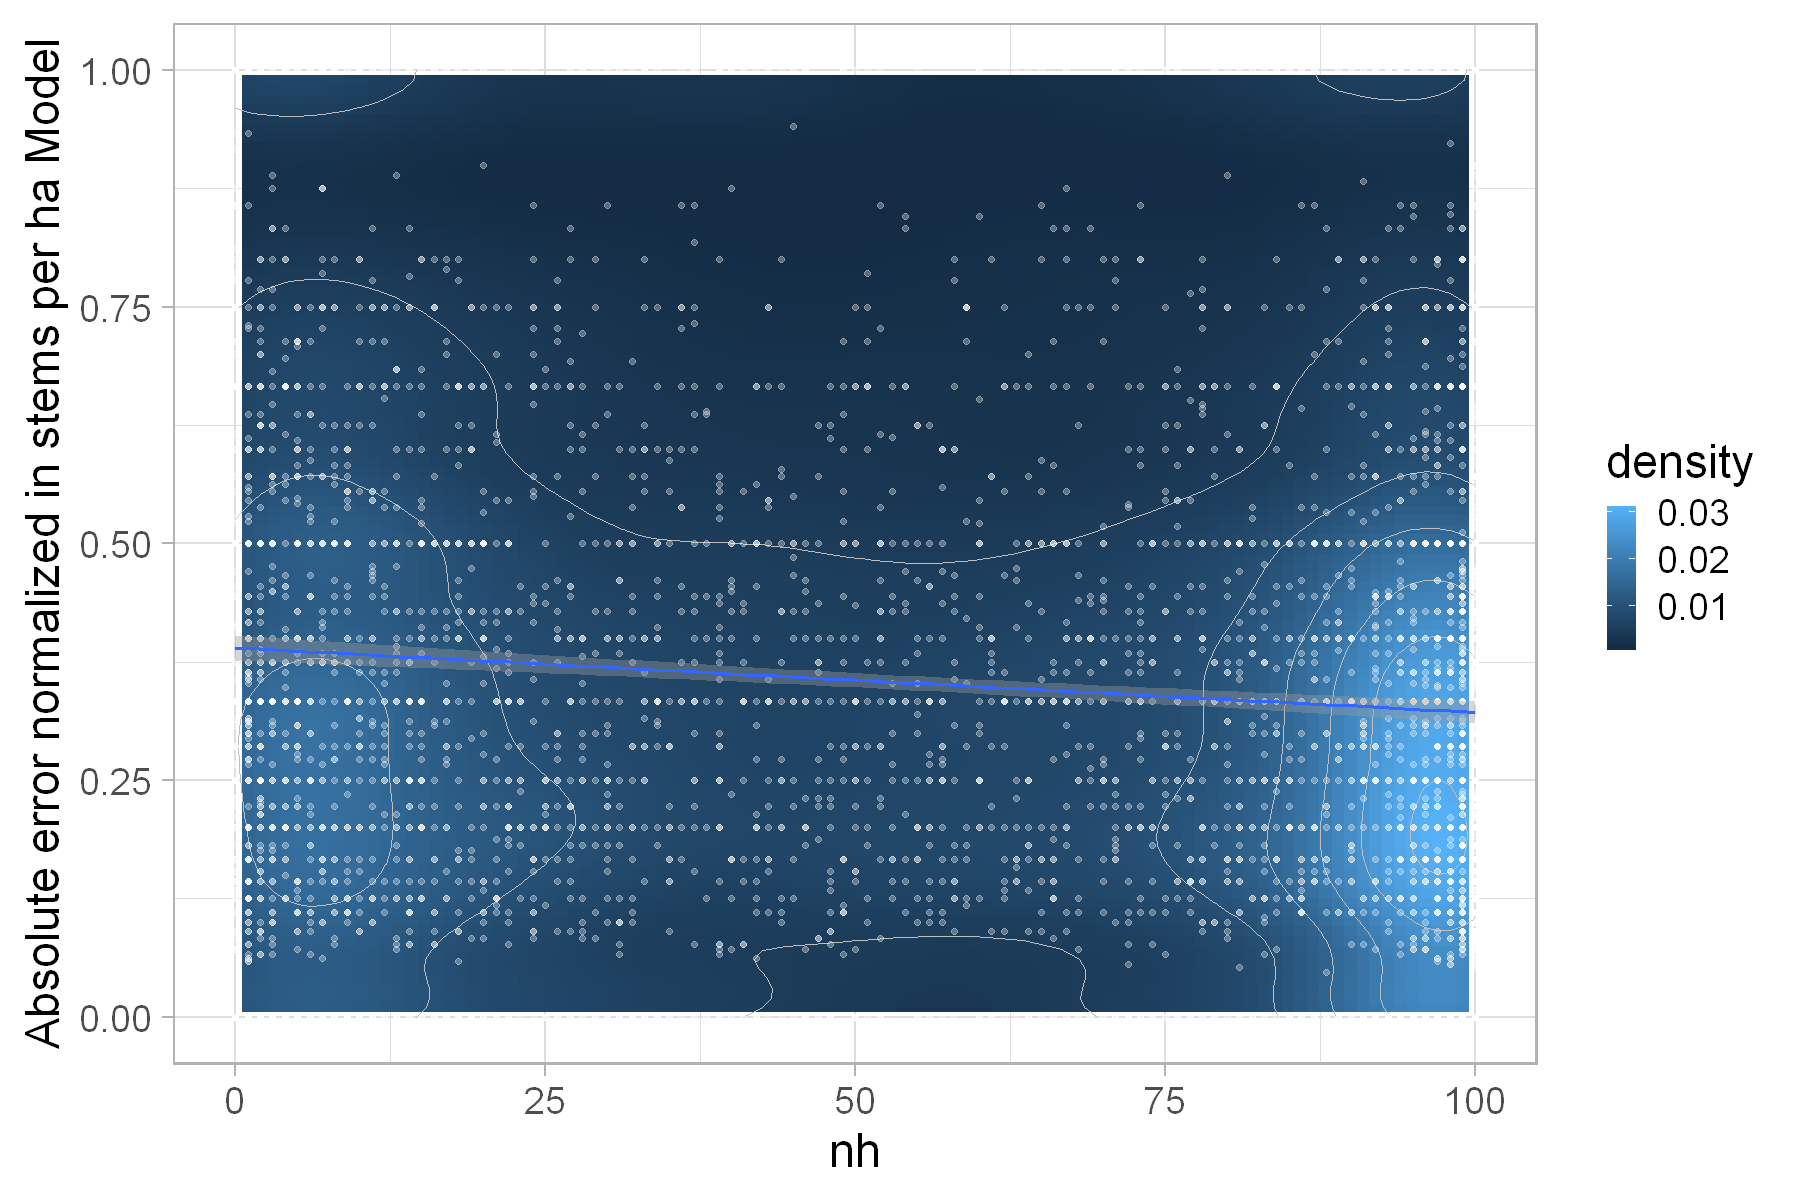

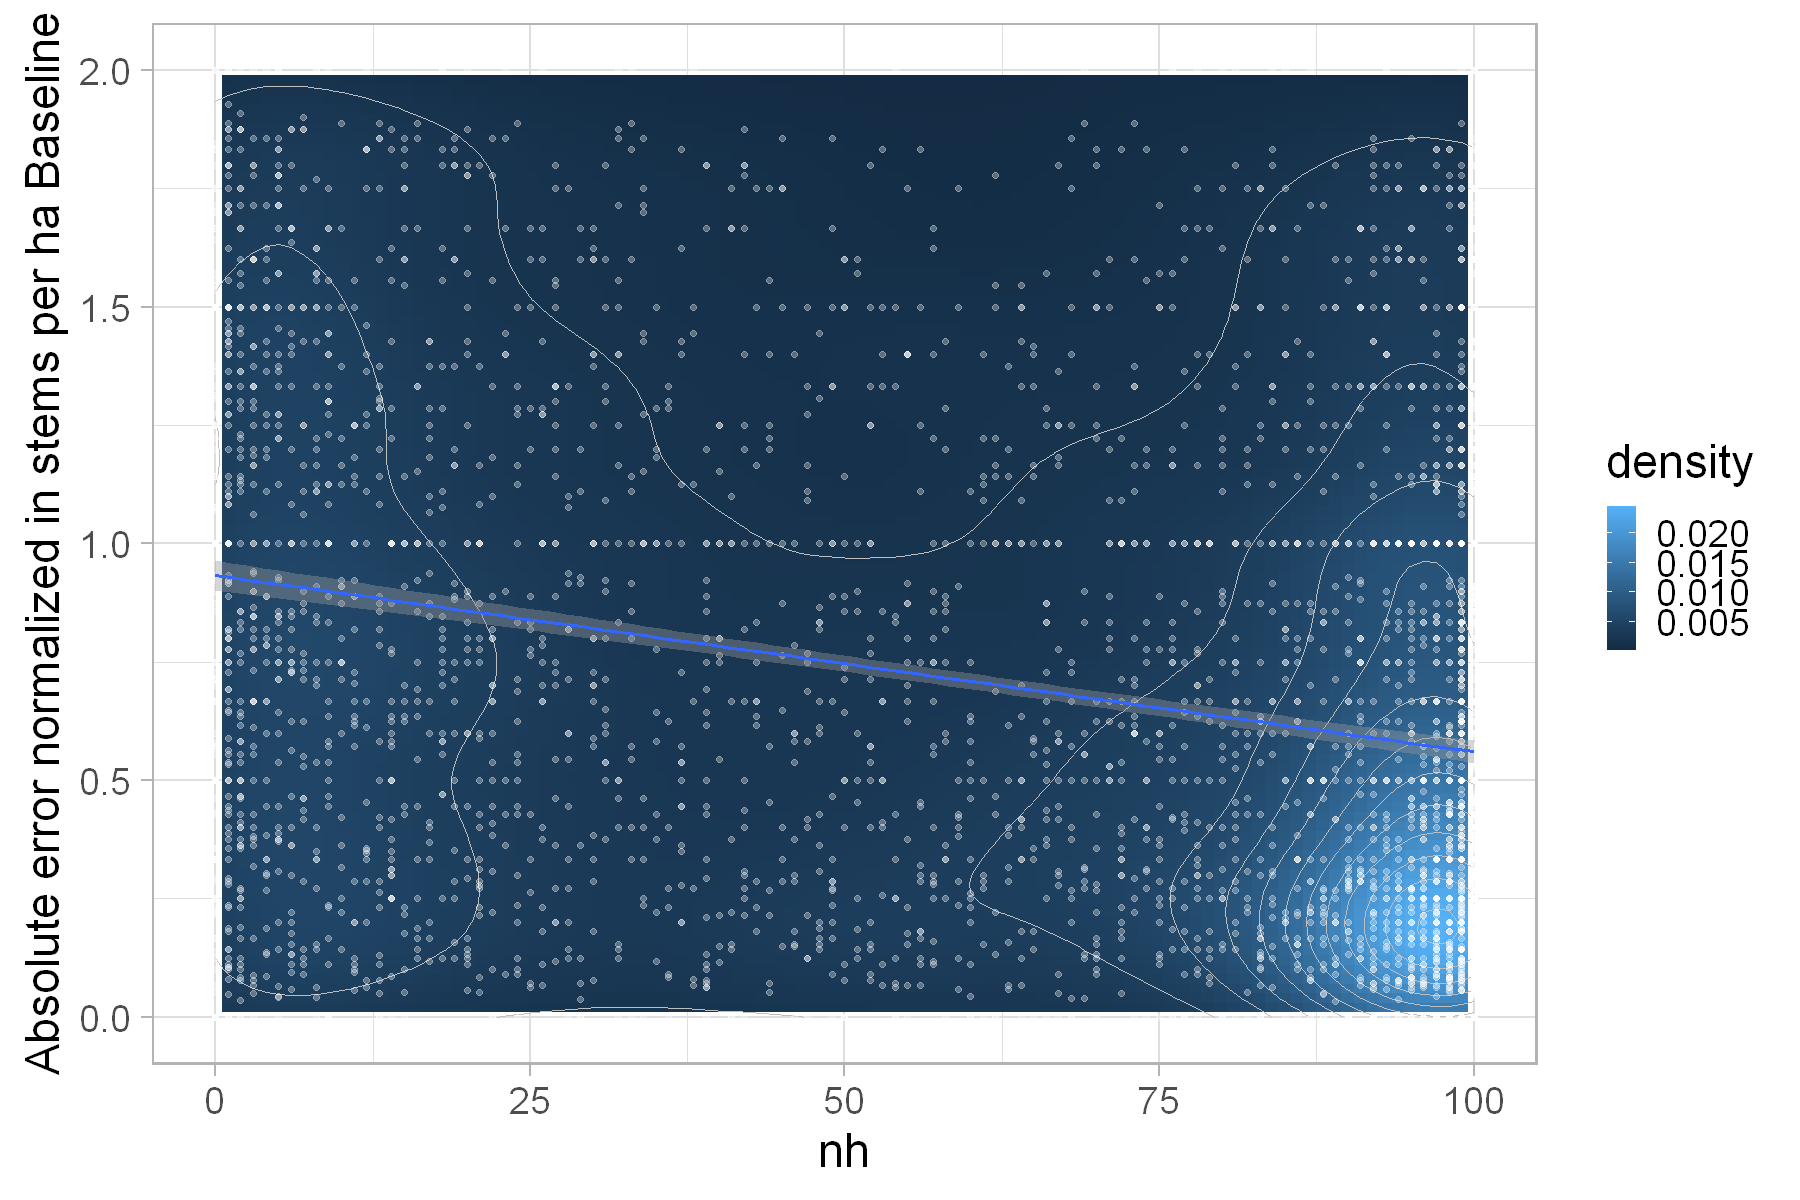

In [87]:
#Scatterplot Coniferous proportion vs Normalized Absolute Error Model
ggplot(data, aes(x=nh, y=stems_per_ha_abs_err_norm_model)) +
  stat_density_2d(aes(fill = ..density..), geom = "raster", contour = FALSE)+
  geom_density_2d(color="gray")+
  geom_point(alpha=0.3, color="white") +
  geom_smooth(method=lm) +
  xlim(0,100) +
  ylim(0,1) +
  # theme(text = element_text(size = 18)) +
  theme_light(base_size = font_base_size) +
  ylab("Absolute error normalized in stems per ha Model") 

#Scatterplot Coniferous proportion vs Normalized Absolute Error Baseline
options(repr.plot.width=15, repr.plot.height=10)

ggplot(data, aes(x=nh, y=stems_per_ha_abs_err_norm_baseline)) +
  stat_density_2d(aes(fill = ..density..), geom = "raster", contour = FALSE)+
  geom_density_2d(color="gray")+
  geom_point(alpha=0.3, color="white") +
  geom_smooth(method=lm) +
  xlim(0,100) +
  ylim(0,2) +
  # theme(text = element_text(size = 18)) +
  theme_light(base_size = font_base_size) +
  ylab("Absolute error normalized in stems per ha Baseline") 


In [88]:
# Simple linear regression of Normalized absolute error depanding on the coniferous proporion to take a look at the significance 
lm_model <- lm(stems_per_ha_abs_err_norm_model~nh, data = data)
summary(lm_model)

lm_baseline <- lm(stems_per_ha_abs_err_norm_baseline~nh, data = data)
summary(lm_baseline)


Call:
lm(formula = stems_per_ha_abs_err_norm_model ~ nh, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.7244 -0.4618 -0.2812 -0.0281 20.3309 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.7243505  0.0289447   25.02  < 2e-16 ***
nh          -0.0015772  0.0004286   -3.68 0.000235 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.188 on 5252 degrees of freedom
Multiple R-squared:  0.002572,	Adjusted R-squared:  0.002382 
F-statistic: 13.54 on 1 and 5252 DF,  p-value: 0.0002354



Call:
lm(formula = stems_per_ha_abs_err_norm_baseline ~ nh, data = data)

Residuals:
   Min     1Q Median     3Q    Max 
-3.000 -1.447 -0.946  0.123 37.593 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2.999928   0.082603   36.32   <2e-16 ***
nh          -0.016945   0.001223  -13.85   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 3.389 on 5252 degrees of freedom
Multiple R-squared:  0.03526,	Adjusted R-squared:  0.03507 
F-statistic: 191.9 on 1 and 5252 DF,  p-value: < 2.2e-16


Warning message:
"Removed 457 rows containing non-finite values (stat_boxplot)."
Warning message:
"Removed 478 rows containing non-finite values (stat_boxplot)."


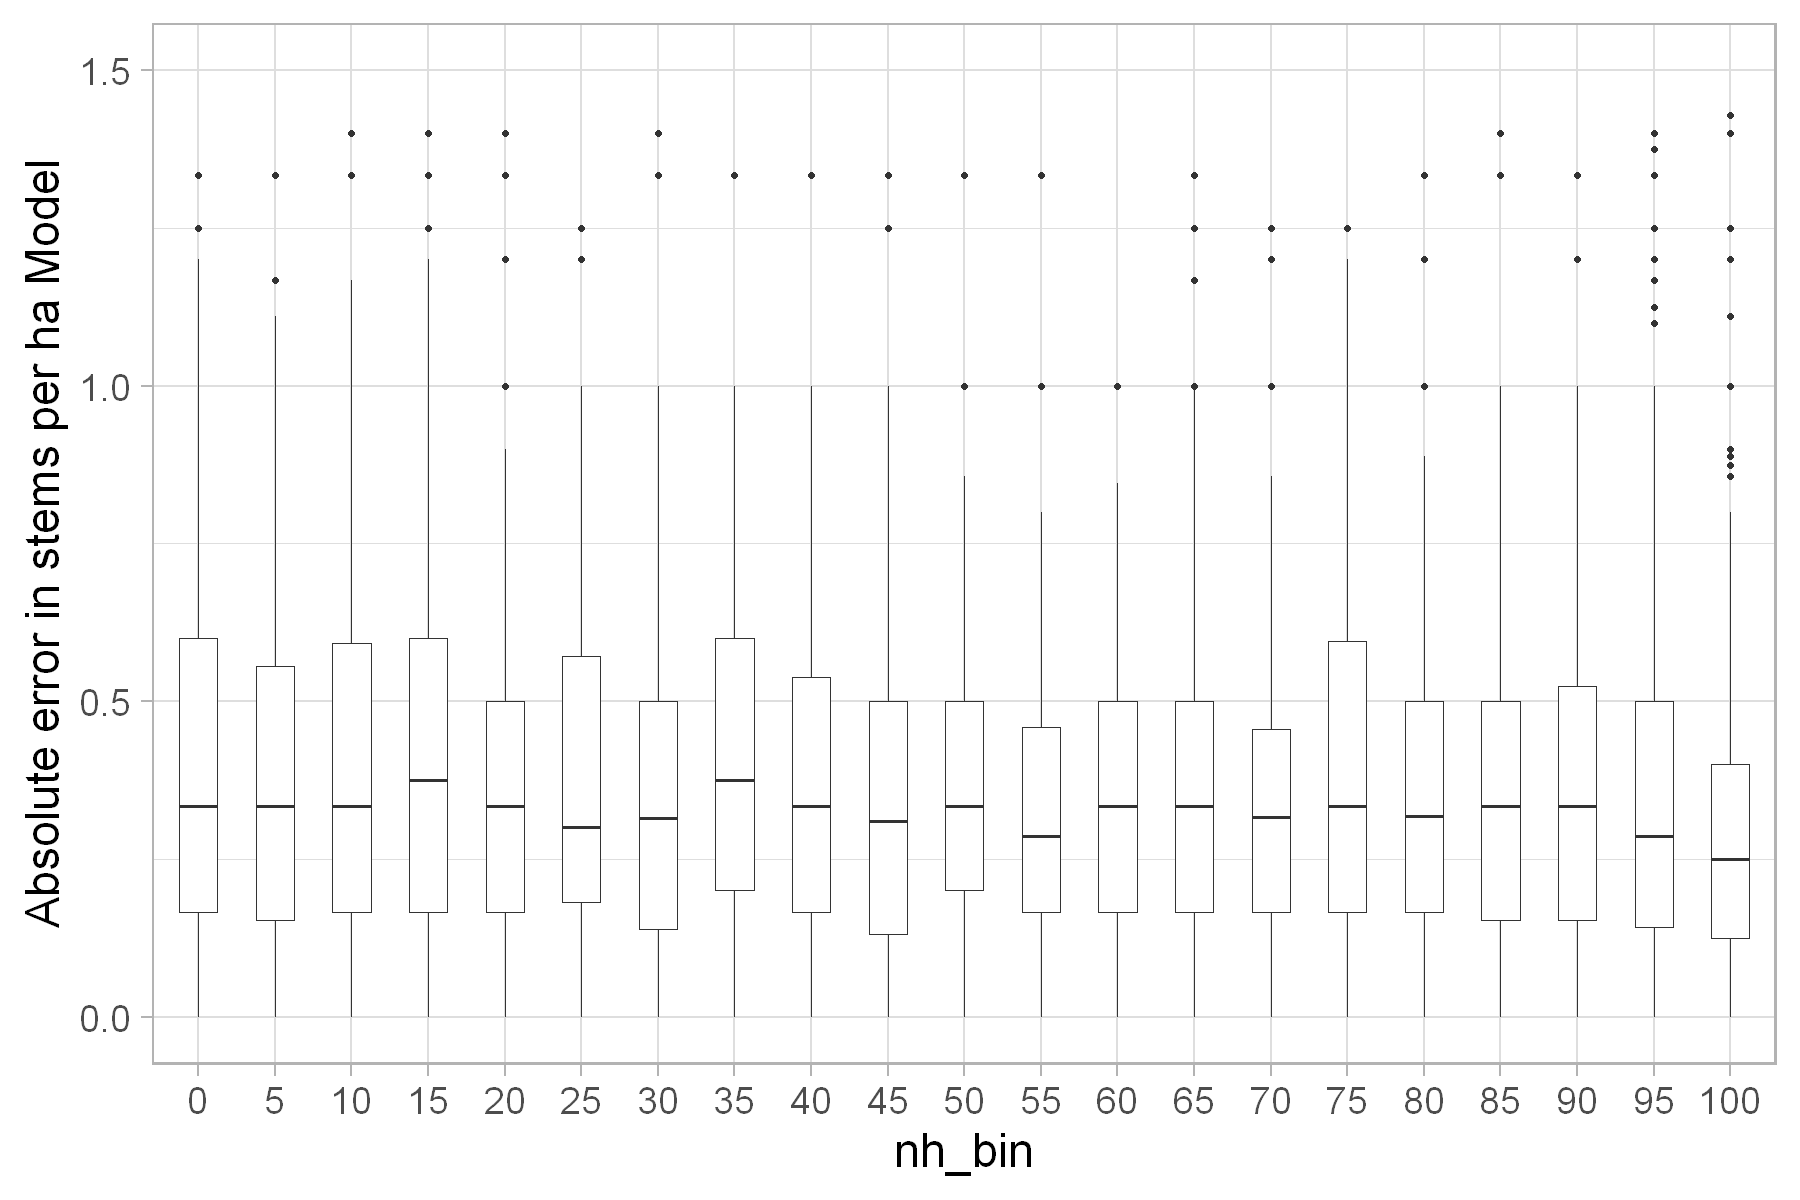

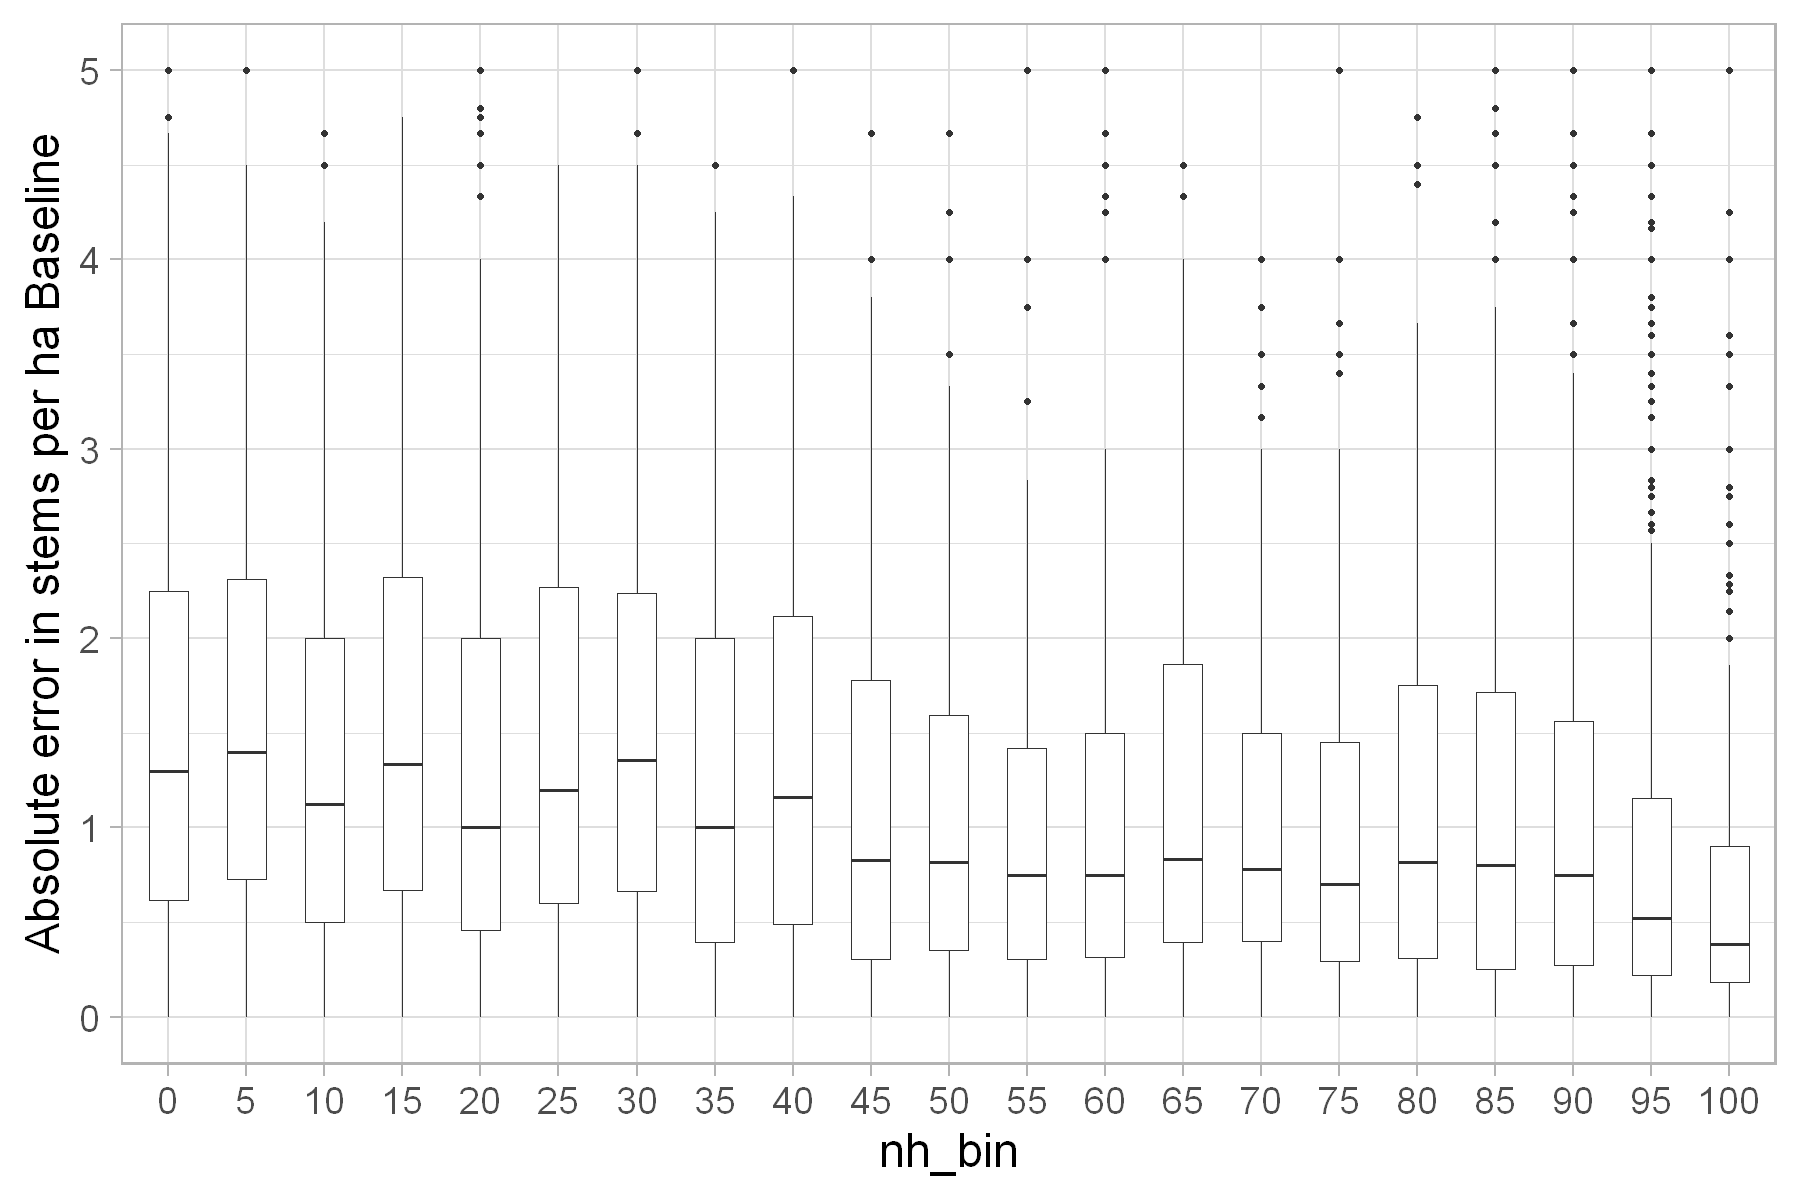

In [89]:
# Boxplots by binned coniferous proportion 0 = [0%,5%[, 5 = [5%,10%[ ...
options(repr.plot.width=15, repr.plot.height=10)

ggplot(data, aes(x=nh_bin, y=stems_per_ha_abs_err_norm_model)) +
#   geom_violin(trim=FALSE)+
  geom_boxplot(width=0.5)+
   ylim(0,1.5) +
  theme_light(base_size = font_base_size) +
  ylab("Absolute error in stems per ha Model") 

# Boxplots by binned coniferous proportion 0 = [0%,5%[, 5 = [5%,10%[ ...
options(repr.plot.width=15, repr.plot.height=10)

ggplot(data, aes(x=nh_bin, y=stems_per_ha_abs_err_norm_baseline)) +
#   geom_violin(trim=FALSE)+
  geom_boxplot(width=0.5)+
   ylim(0,5) +
  theme_light(base_size = font_base_size) +
  ylab("Absolute error in stems per ha Baseline") 



In [90]:
#Summary of Normalized Absolute Error by binned coniferous proportion
data %>%
  group_by(nh_bin) %>%
  summarise(mean = mean(stems_per_ha_abs_err_norm_model), median = median(stems_per_ha_abs_err_norm_model), n = n())

data %>%
  group_by(nh_bin) %>%
  summarise(mean = mean(stems_per_ha_abs_err_norm_baseline), median = median(stems_per_ha_abs_err_norm_baseline), n = n())

nh_bin mean      median    n  
1  0      0.7635957 0.3750000 691
2  5      0.5724300 0.3750000 348
3  10     0.7090687 0.3529412 239
4  15     0.6539329 0.4117647 217
5  20     0.5797409 0.3550420 178
6  25     0.5771303 0.3333333 146
7  30     0.7728444 0.3333333 158
8  35     0.8222562 0.4000000 125
9  40     0.7834452 0.3750000 116
10 45     0.5885976 0.3333333 118
11 50     0.7414143 0.4000000 115
12 55     0.6927278 0.3333333 114
13 60     0.6235487 0.3333333 114
14 65     0.6251283 0.3636364 125
15 70     0.7302868 0.3484848 144
16 75     0.7080774 0.4000000 155
17 80     0.5527647 0.3333333 179
18 85     0.7488706 0.3870968 217
19 90     0.5783602 0.3333333 319
20 95     0.6312457 0.3333333 864
21 100    0.3736726 0.2666667 572

nh_bin mean      median    n  
1  0      2.7566646 1.5000000 691
2  5      2.6456627 1.5634921 348
3  10     2.7786186 1.3076923 239
4  15     2.8364782 1.8000000 217
5  20     2.3656994 1.2613636 178
6  25     2.4362087 1.2928571 146
7  30     3.3606025 1.6000000 158
8  35     2.6905506 1.2000000 125
9  40     3.3069100 1.3250000 116
10 45     2.0834282 1.0000000 118
11 50     2.5169233 1.0000000 115
12 55     2.2191546 0.8660714 114
13 60     2.1094041 1.0000000 114
14 65     1.8295795 0.9000000 125
15 70     2.1673196 1.0000000 144
16 75     1.7937607 0.7777778 155
17 80     1.7153417 0.8750000 179
18 85     1.6856389 0.8333333 217
19 90     1.4841700 0.7500000 319
20 95     1.4135279 0.5968750 864
21 100    0.7986482 0.4000000 572

Warning message:
"Removed 89 rows containing non-finite values (stat_density2d)."
Warning message:
"Removed 89 rows containing non-finite values (stat_density2d)."
Warning message:
"Removed 396 rows containing missing values (geom_raster)."
Warning message:
"Removed 89 rows containing missing values (geom_point)."
Warning message:
"Removed 618 rows containing non-finite values (stat_density2d)."
Warning message:
"Removed 618 rows containing non-finite values (stat_density2d)."
Warning message:
"Removed 396 rows containing missing values (geom_raster)."
Warning message:
"Removed 618 rows containing missing values (geom_point)."


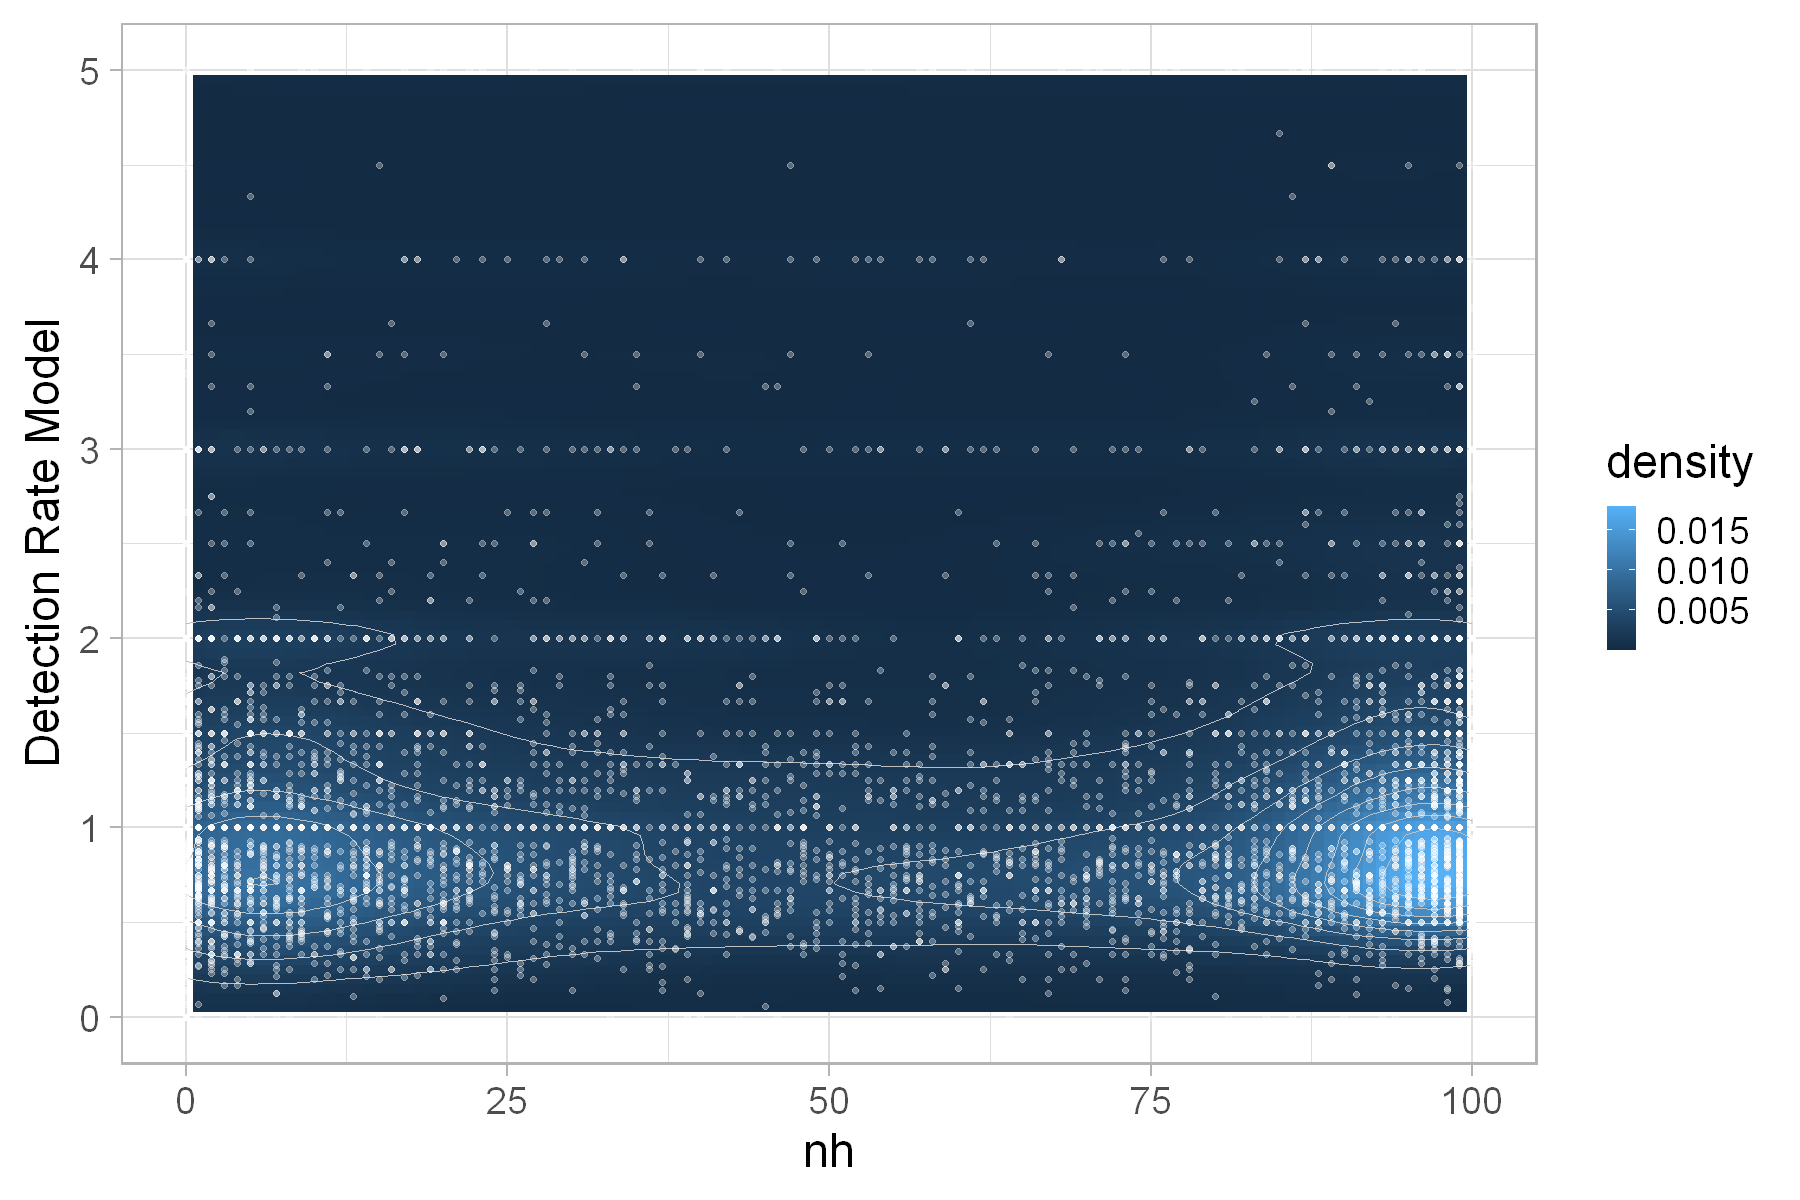

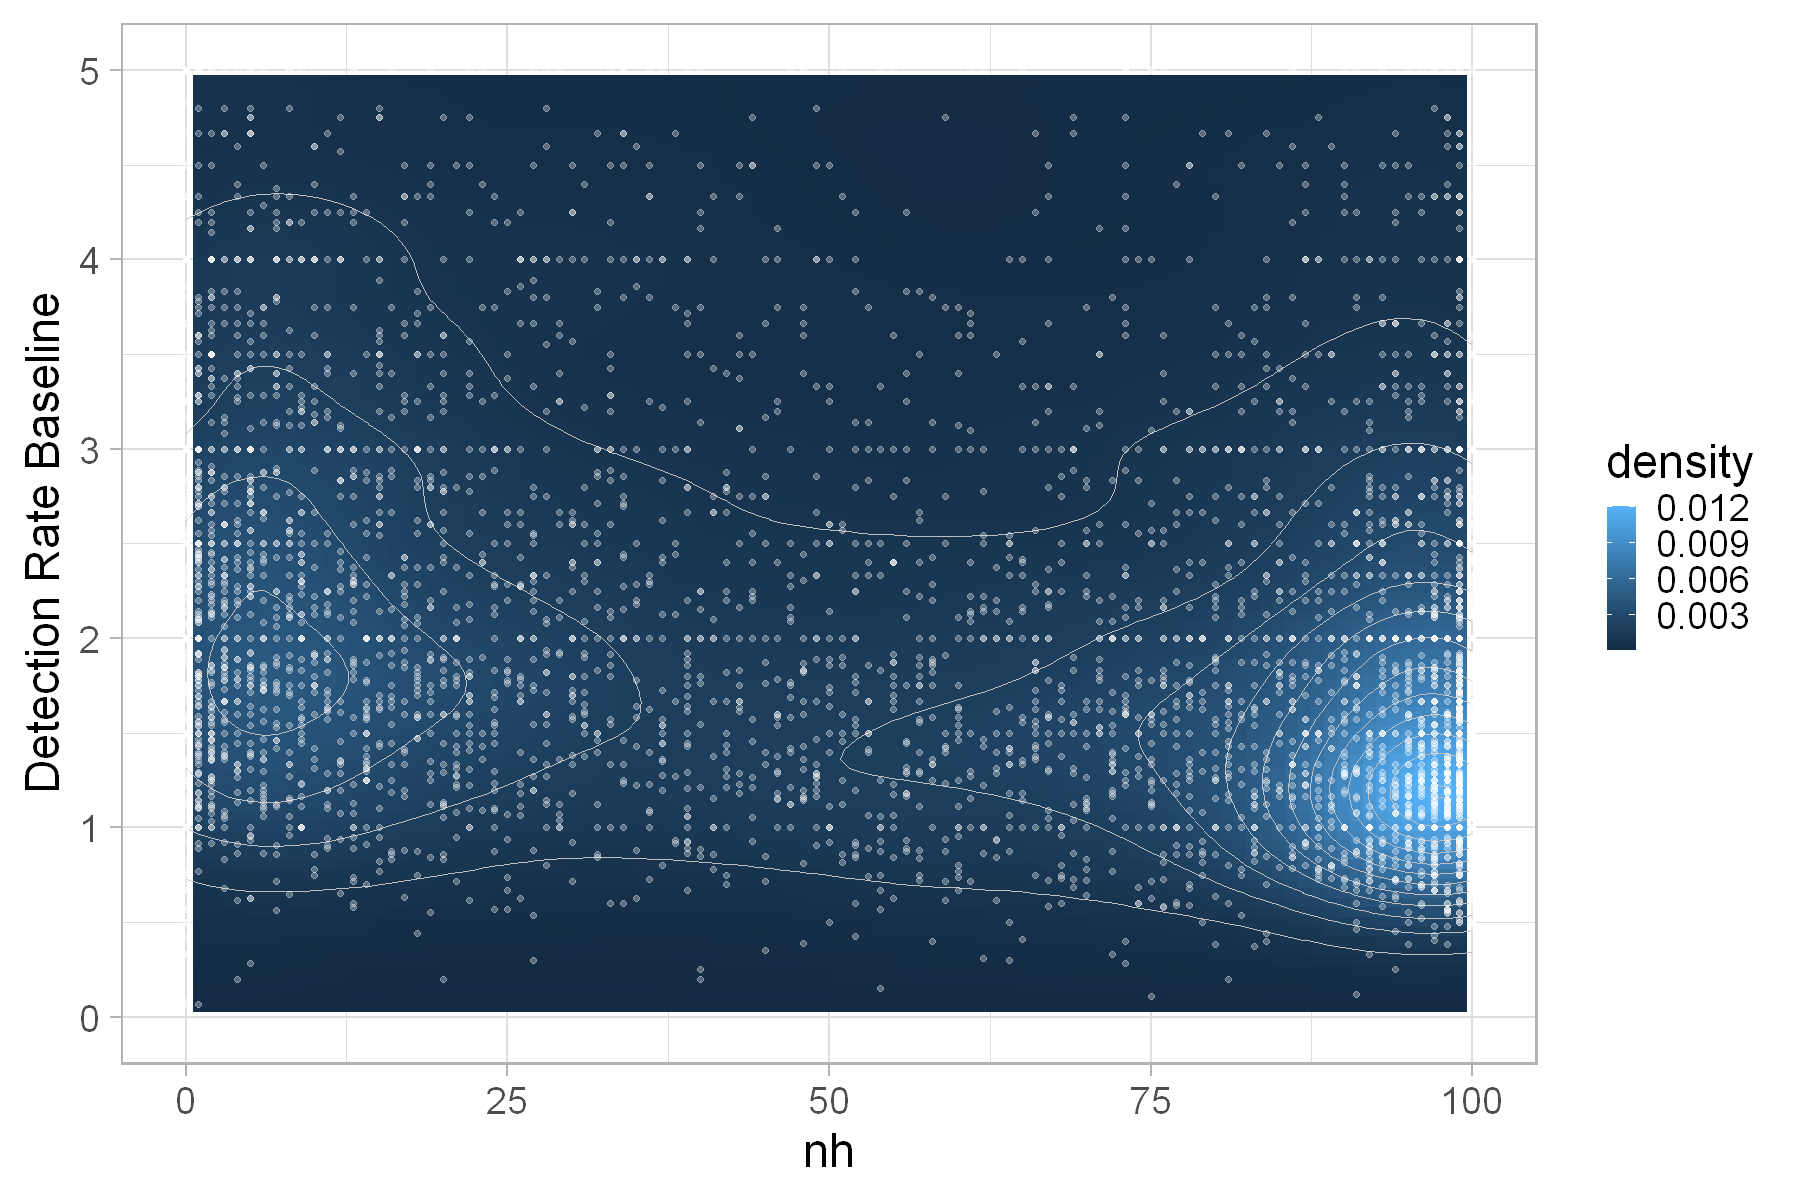

In [91]:
#Scatterplot Coniferous proportion vs  Detection Rate
options(repr.plot.width=15, repr.plot.height=10)


ggplot(data, aes(x=nh, y=dr_model)) +
  stat_density_2d(aes(fill = ..density..), geom = "raster", contour = FALSE)+
  geom_density_2d(color="gray")+
  geom_point(alpha=0.3, color="white") +
  xlim(0,100) +
  ylim(0,5) +
  # theme(text = element_text(size = 18)) +
  theme_light(base_size = font_base_size) +
  ylab("Detection Rate Model") 


#Scatterplot Coniferous proportion vs Detection Rate
options(repr.plot.width=15, repr.plot.height=10)

ggplot(data, aes(x=nh, y=dr_baseline)) +
  stat_density_2d(aes(fill = ..density..), geom = "raster", contour = FALSE)+
  geom_density_2d(color="gray")+
  geom_point(alpha=0.3, color="white") +
  xlim(0,100) +
  ylim(0,5) +
  # theme(text = element_text(size = 18)) +
  theme_light(base_size = font_base_size) +
  ylab("Detection Rate Baseline") 

Warning message:
"Removed 142 rows containing non-finite values (stat_boxplot)."
Warning message:
"Removed 291 rows containing non-finite values (stat_boxplot)."


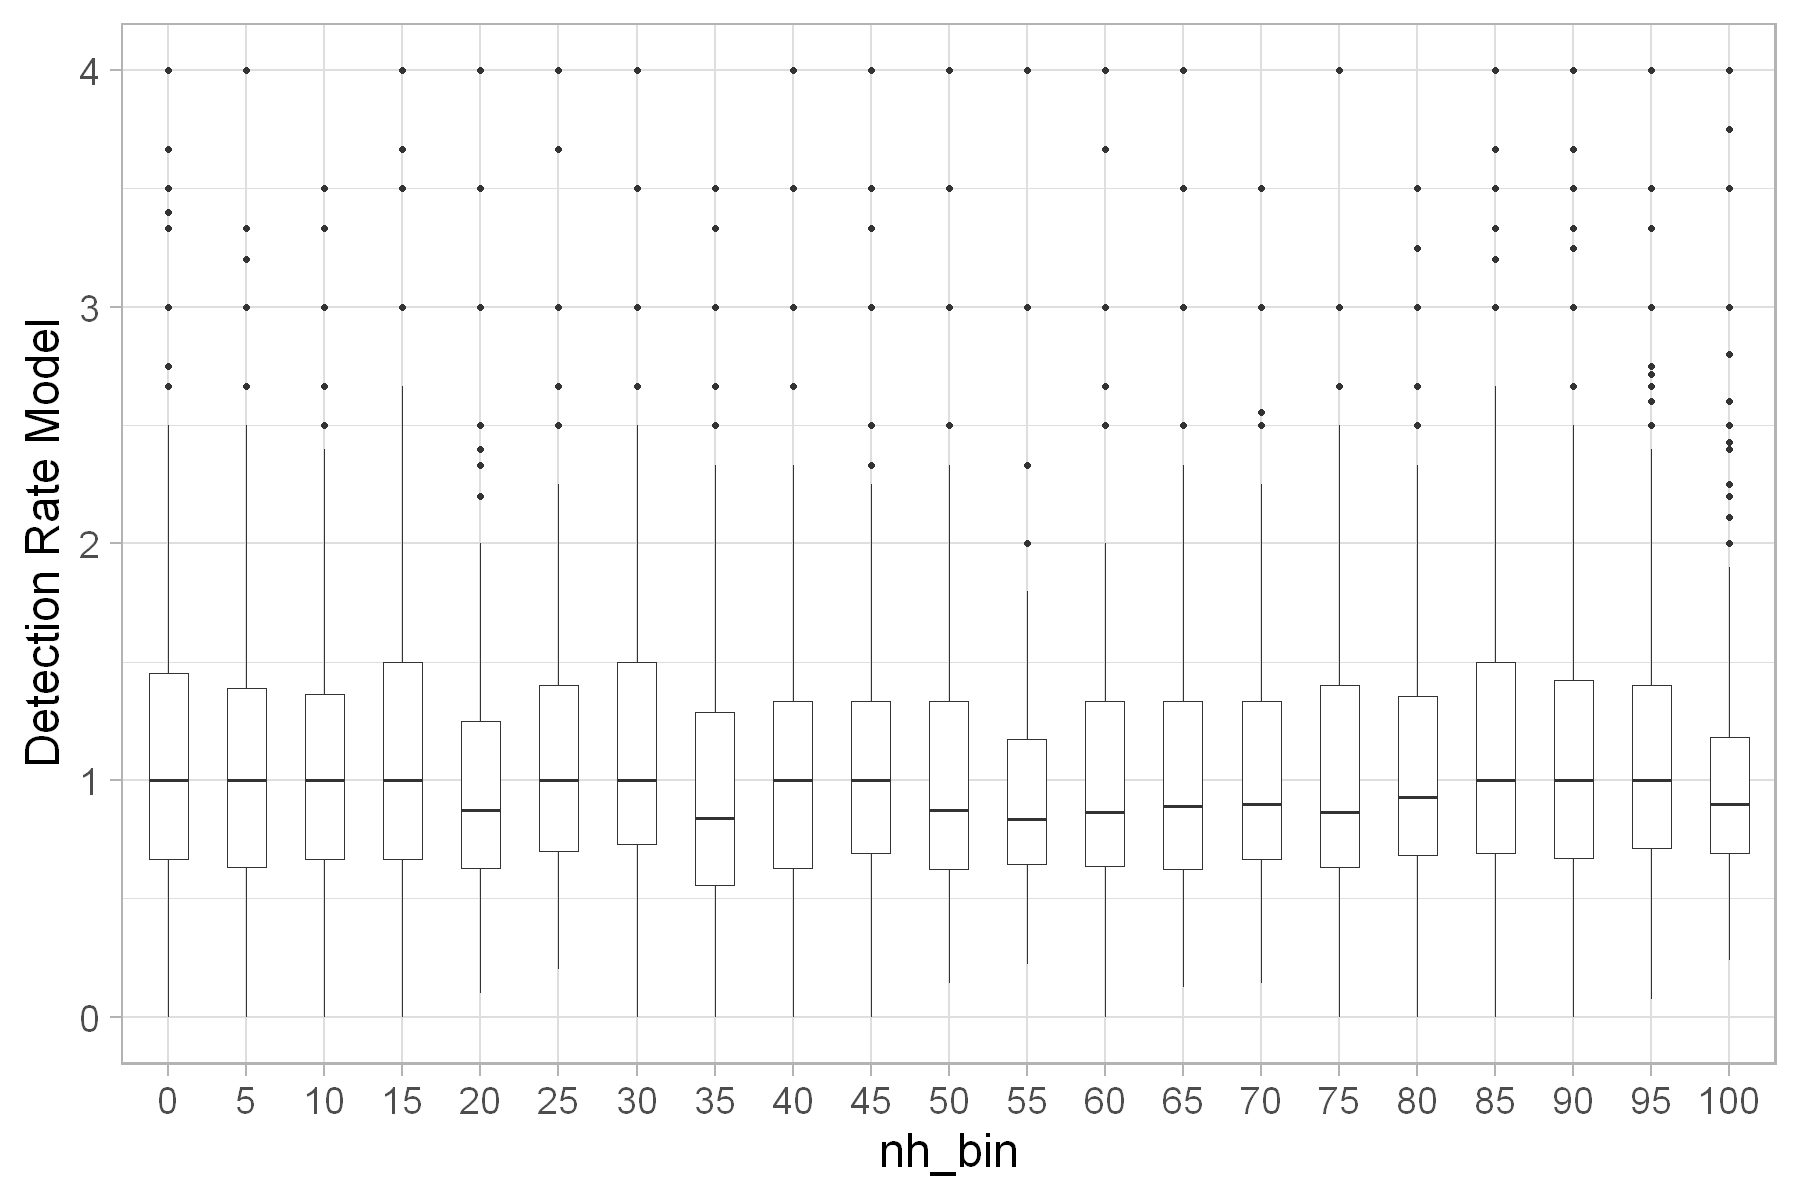

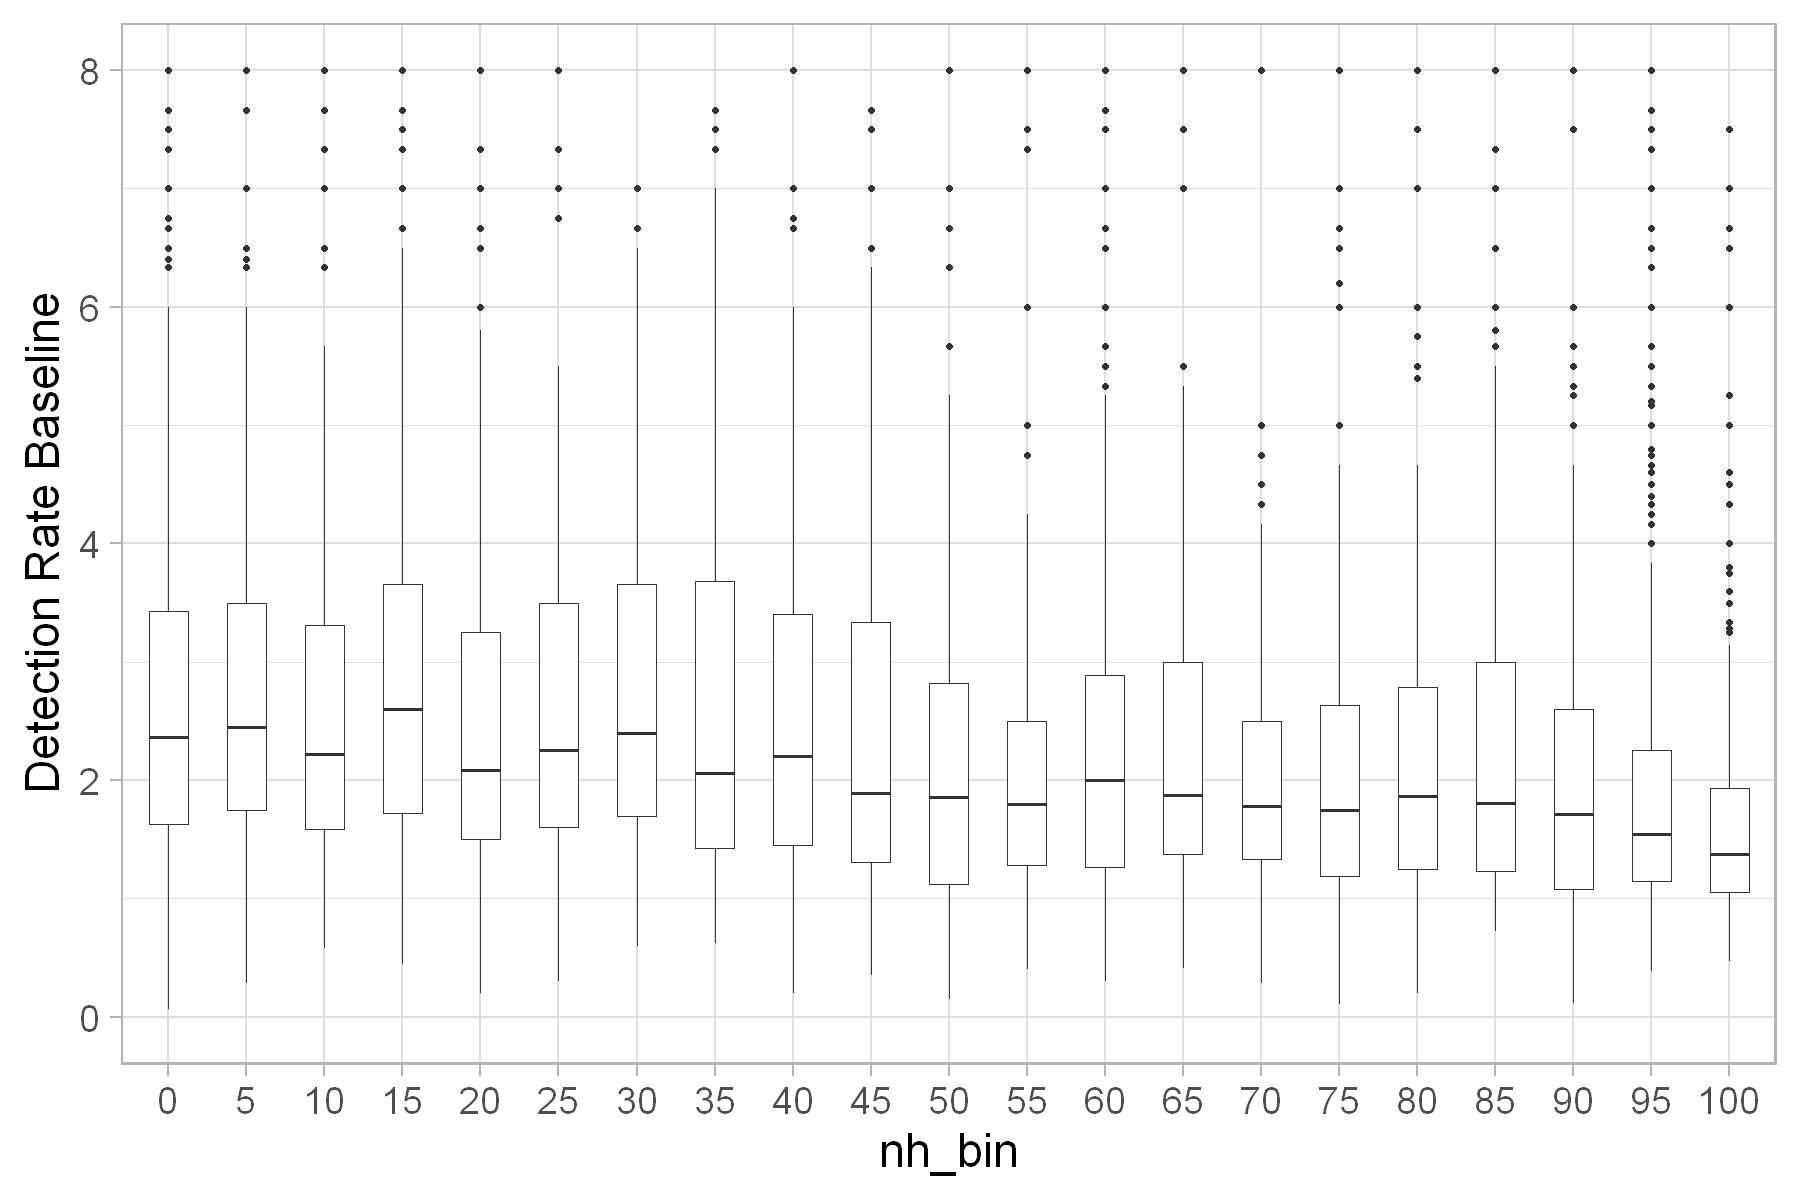

In [92]:
# Boxplots by binned coniferous proportion 0 = [0%,5%[, 5 = [5%,10%[ ...
options(repr.plot.width=15, repr.plot.height=10)

ggplot(data, aes(x=nh_bin, y=dr_model)) +
#   geom_violin(trim=FALSE)+
  geom_boxplot(width=0.5)+
  ylim(0,4) +
  theme_light(base_size = font_base_size) +
  ylab("Detection Rate Model") 

# Boxplots by binned coniferous proportion 0 = [0%,5%[, 5 = [5%,10%[ ...
options(repr.plot.width=15, repr.plot.height=10)

ggplot(data, aes(x=nh_bin, y=dr_baseline)) +
#   geom_violin(trim=FALSE)+
  geom_boxplot(width=0.5)+
  ylim(0,8) +
  theme_light(base_size = font_base_size) +
  ylab("Detection Rate Baseline") 



`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



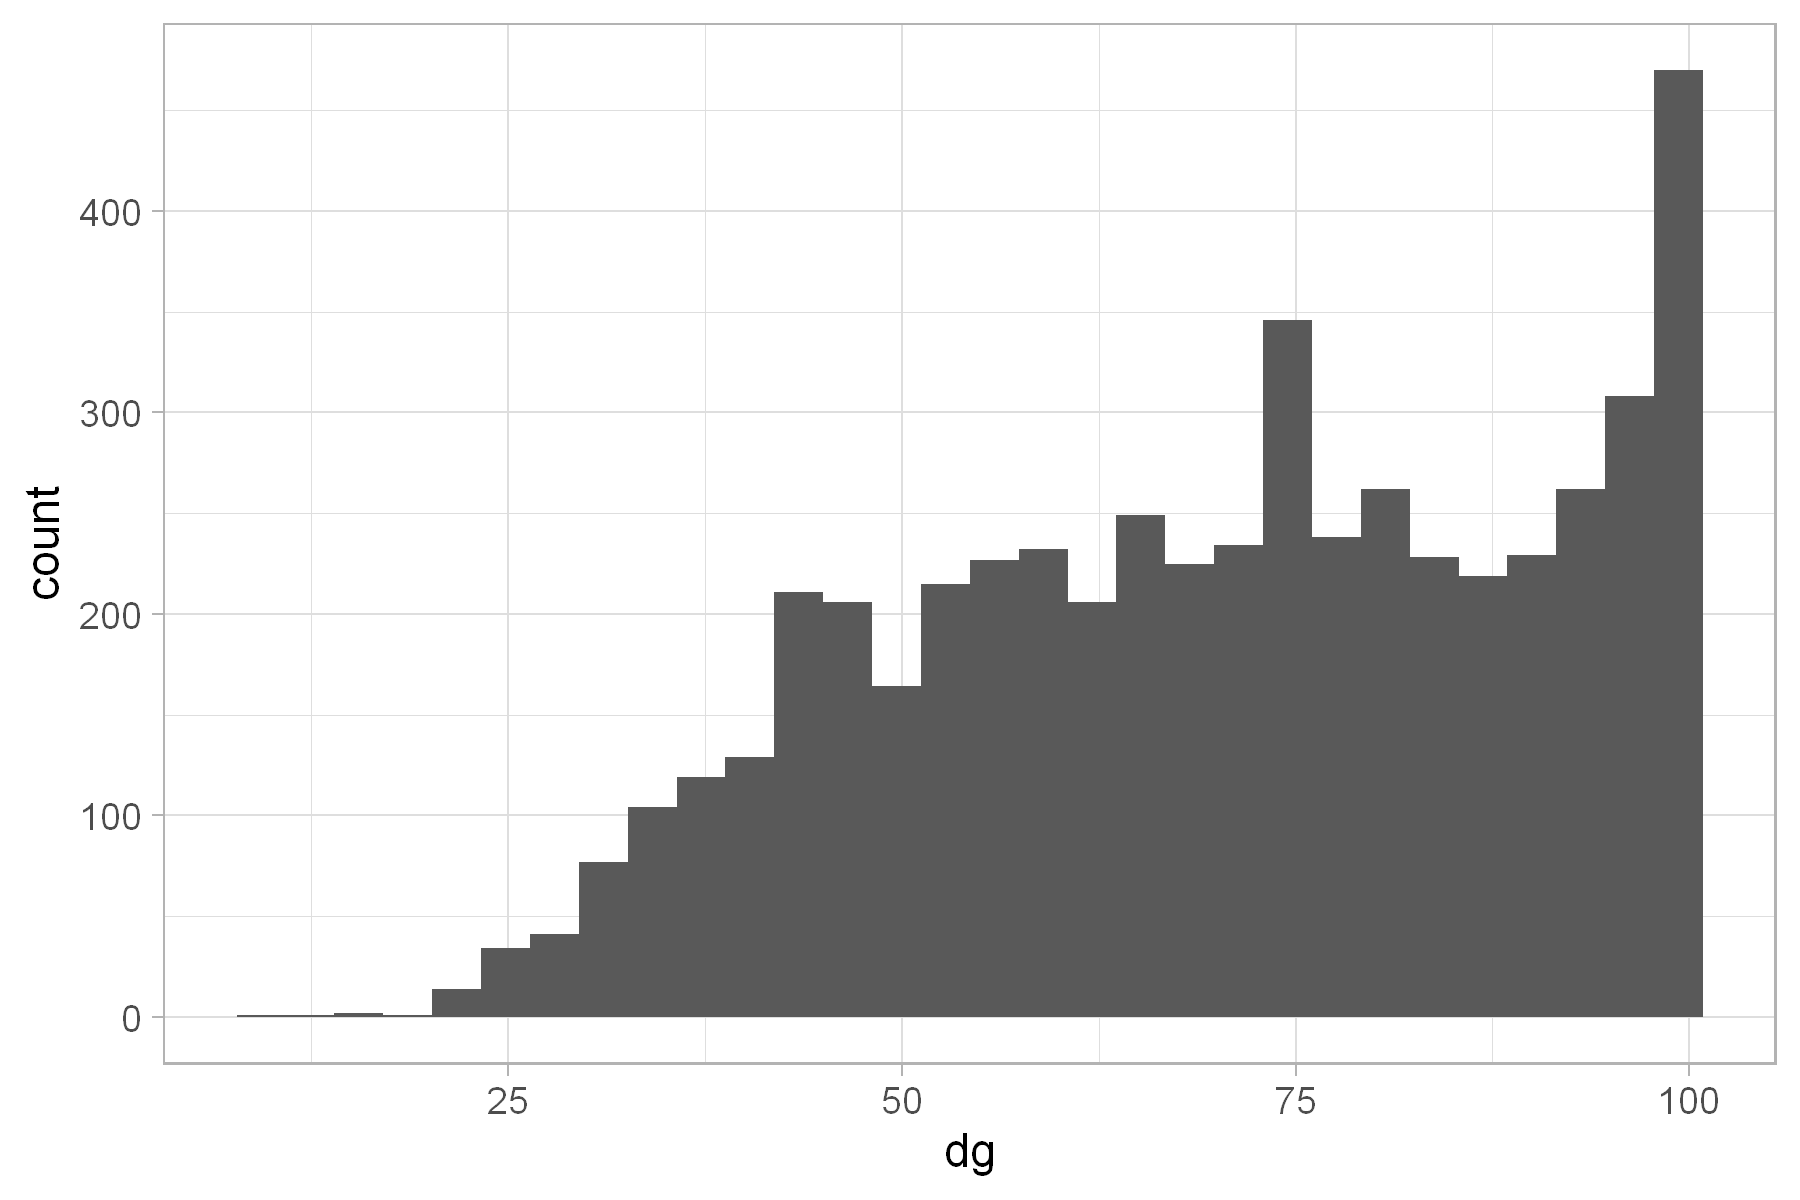

In [93]:
# Histogram of Degree of Cover
options(repr.plot.width=15, repr.plot.height=10)

ggplot(data, aes(x=dg)) +
  geom_histogram()+
  theme_light(base_size = font_base_size) 


Warning message:
"Removed 5 rows containing non-finite values (stat_density2d)."
Warning message:
"Removed 5 rows containing non-finite values (stat_density2d)."
Warning message:
"Removed 396 rows containing missing values (geom_raster)."
Warning message:
"Removed 5 rows containing missing values (geom_point)."
Warning message:
"Removed 7 rows containing non-finite values (stat_density2d)."
Warning message:
"Removed 7 rows containing non-finite values (stat_density2d)."
Warning message:
"Removed 396 rows containing missing values (geom_raster)."
Warning message:
"Removed 7 rows containing missing values (geom_point)."


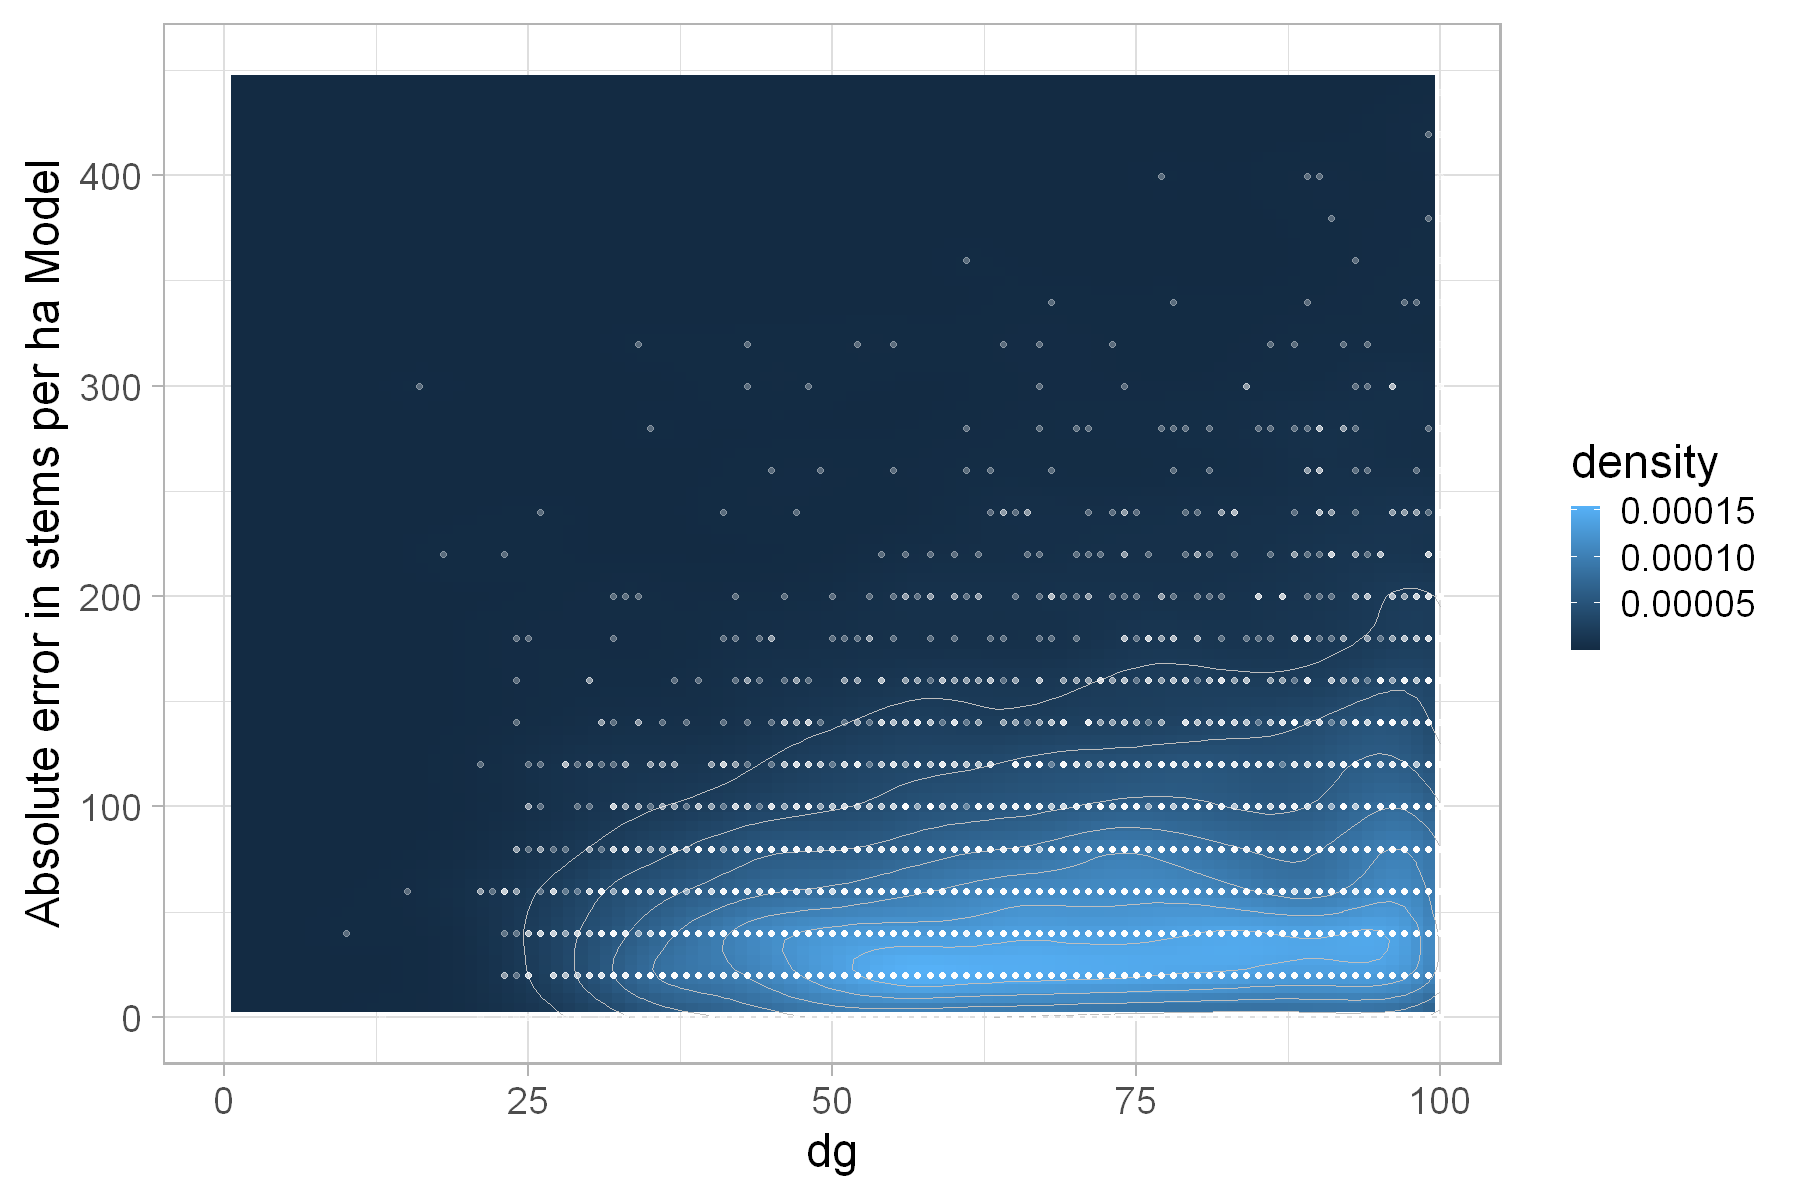

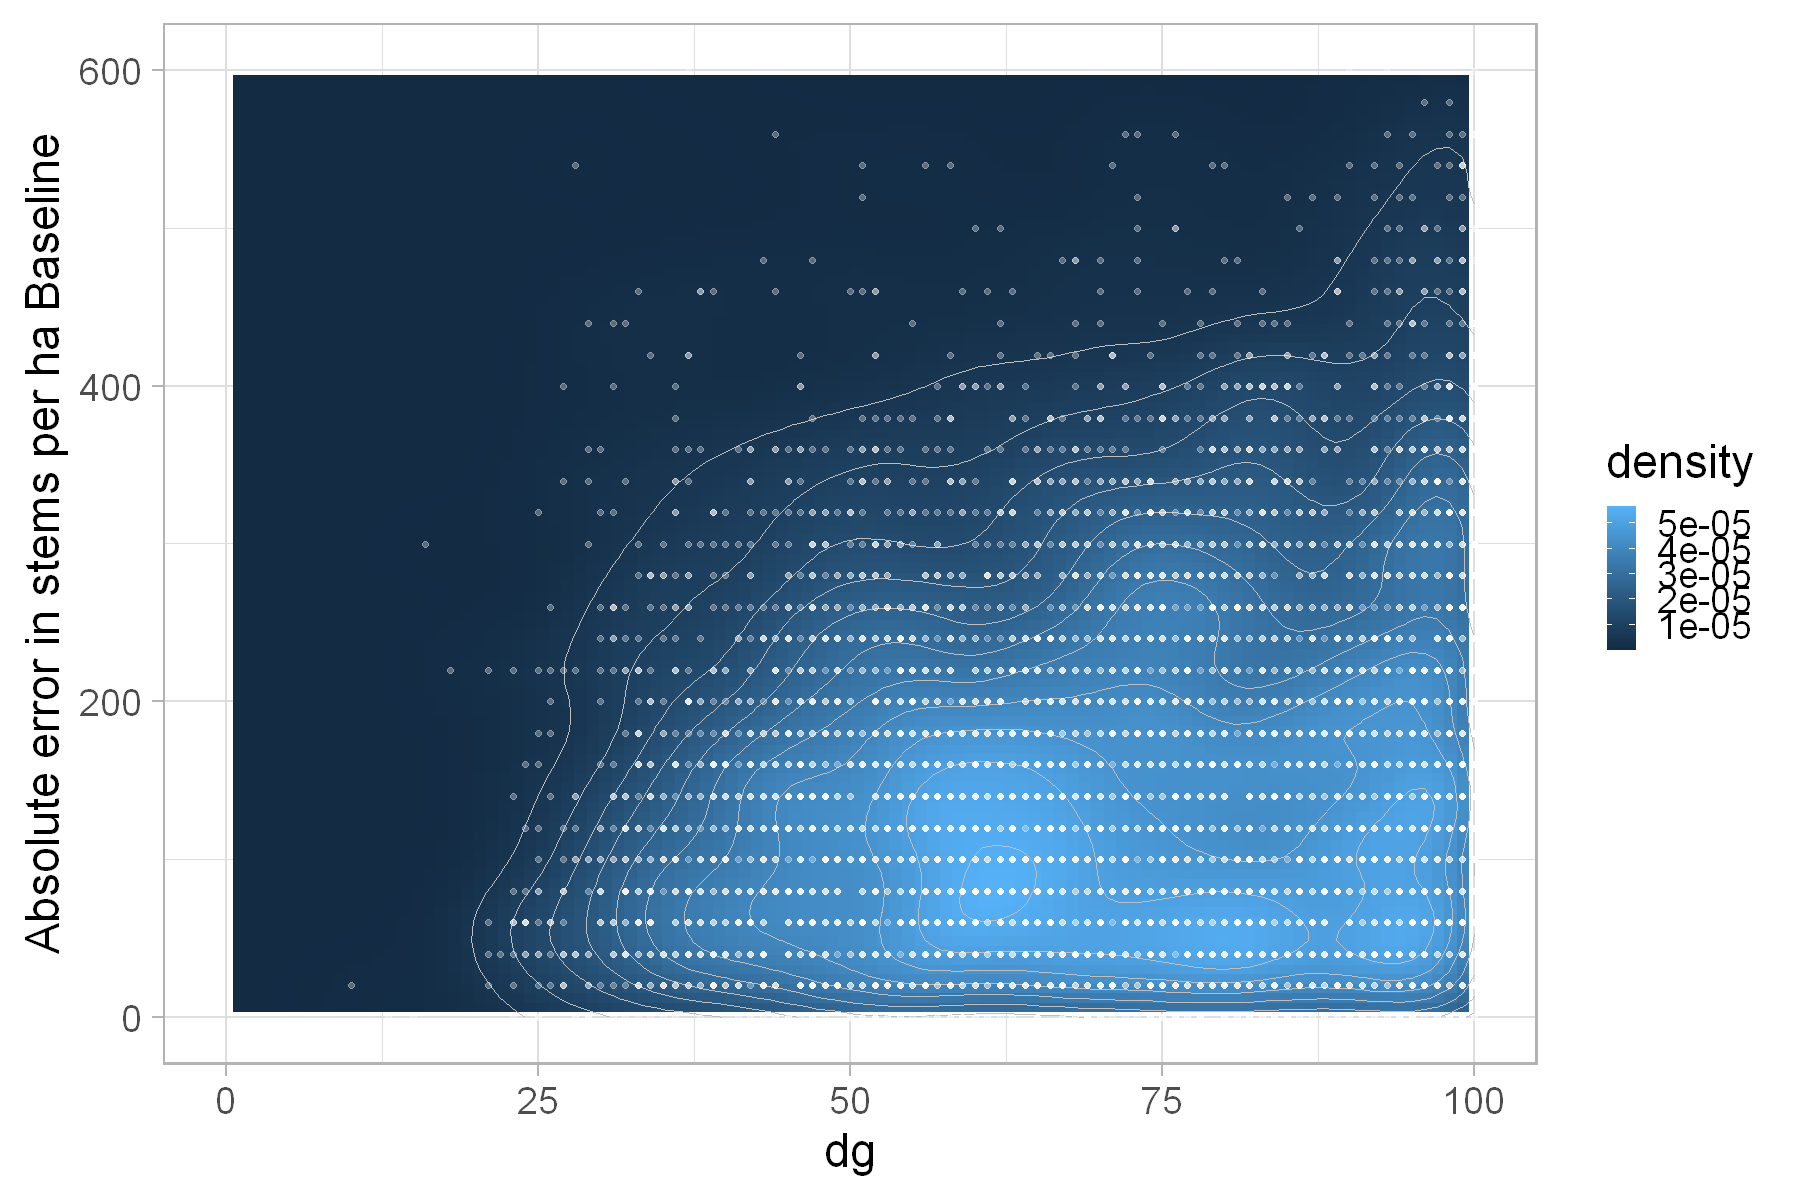

In [94]:
#Scatterplot Degree of cover vs Absolute Error Model
options(repr.plot.width=15, repr.plot.height=10)

ggplot(data, aes(x=dg, y=stems_per_ha_abs_err_model)) +
  stat_density_2d(aes(fill = ..density..), geom = "raster", contour = FALSE)+
  geom_density_2d(color="gray")+
  geom_point(alpha=0.3, color="white") +
  xlim(0,100) +
  ylim(0,450) +
  # theme(text = element_text(size = 18)) +
  theme_light(base_size = font_base_size) +
  ylab("Absolute error in stems per ha Model") 

#Scatterplot Coniferous proportion vs Absolute Error Baseline
options(repr.plot.width=15, repr.plot.height=10)

ggplot(data, aes(x=dg, y=stems_per_ha_abs_err_baseline)) +
  stat_density_2d(aes(fill = ..density..), geom = "raster", contour = FALSE)+
  geom_density_2d(color="gray")+
  geom_point(alpha=0.3, color="white") +
  xlim(0,100) +
  ylim(0,600) +
  # theme(text = element_text(size = 18)) +
  theme_light(base_size = font_base_size) +
  ylab("Absolute error in stems per ha Baseline") 


Warning message:
"Removed 20 rows containing non-finite values (stat_boxplot)."
Warning message:
"Removed 5 rows containing non-finite values (stat_boxplot)."


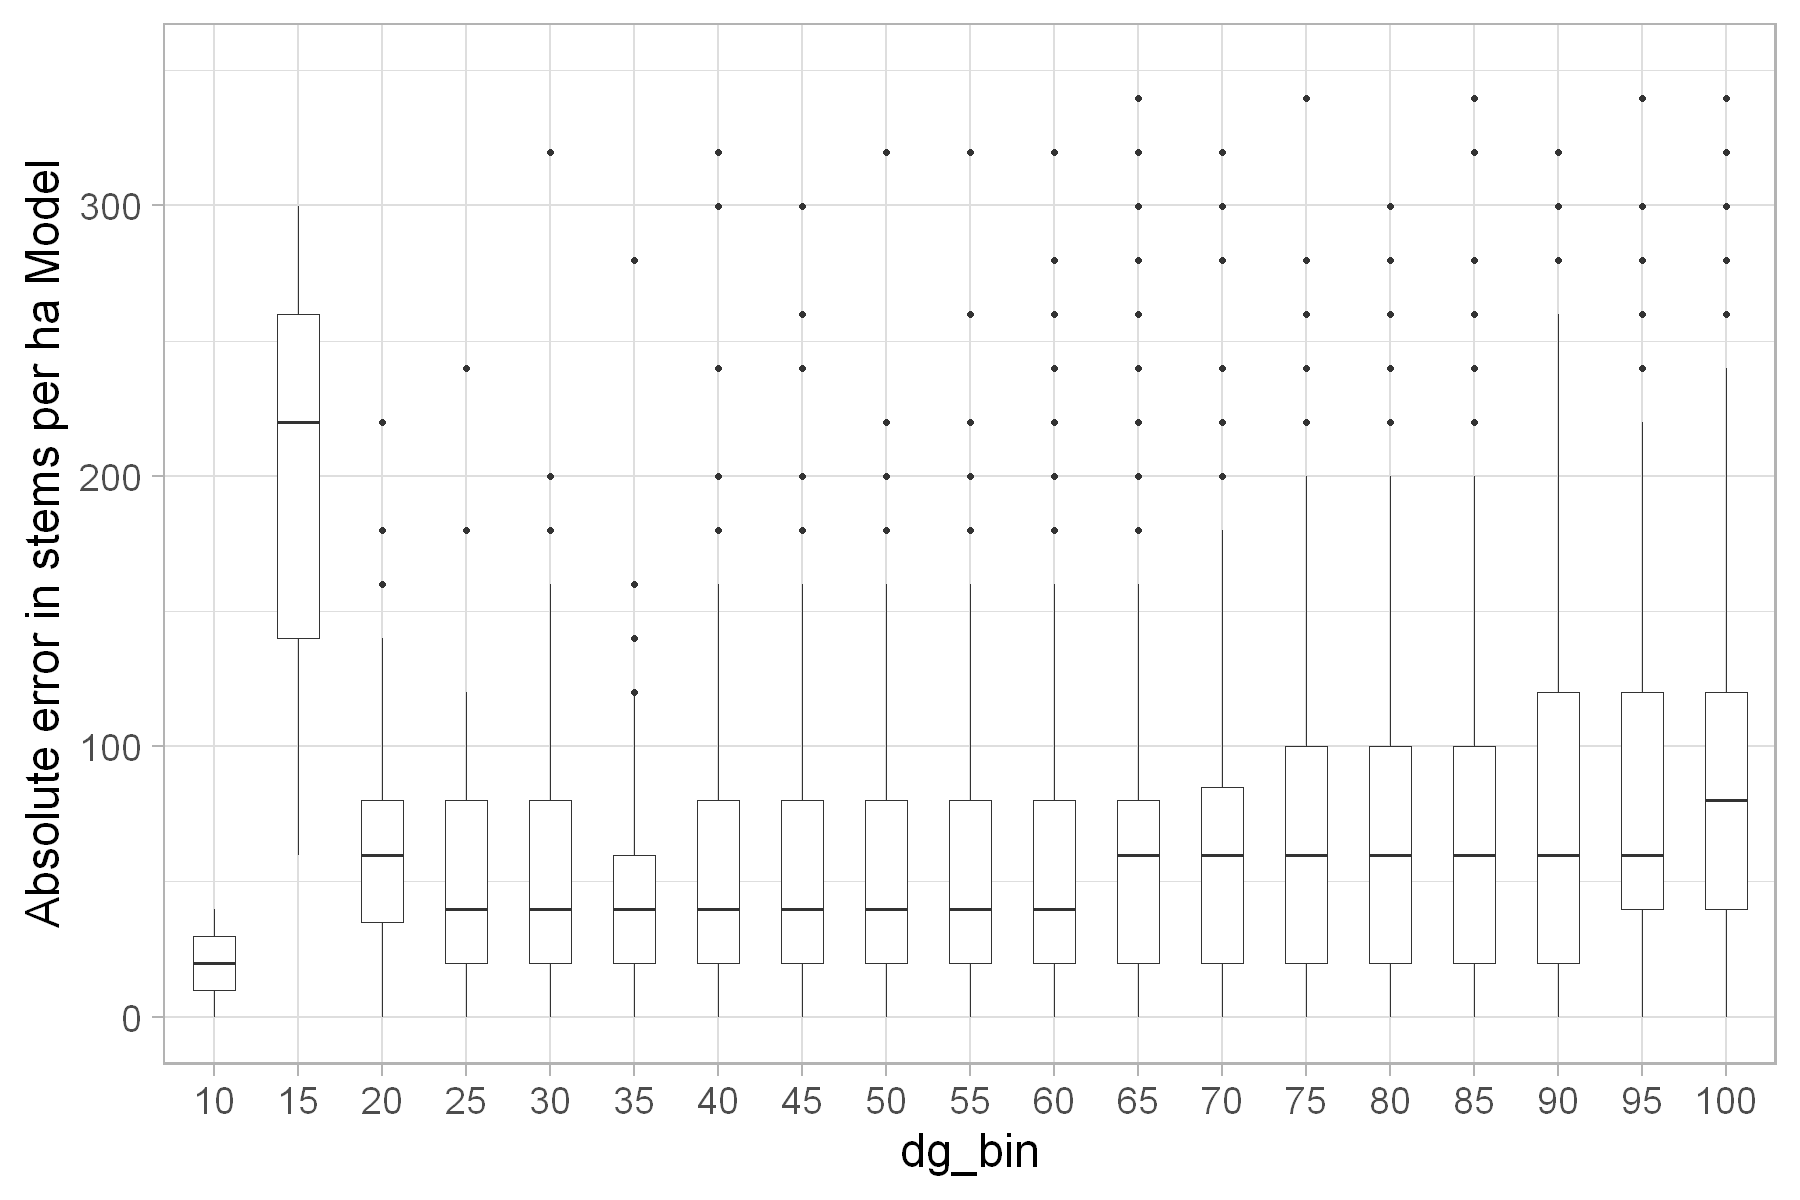

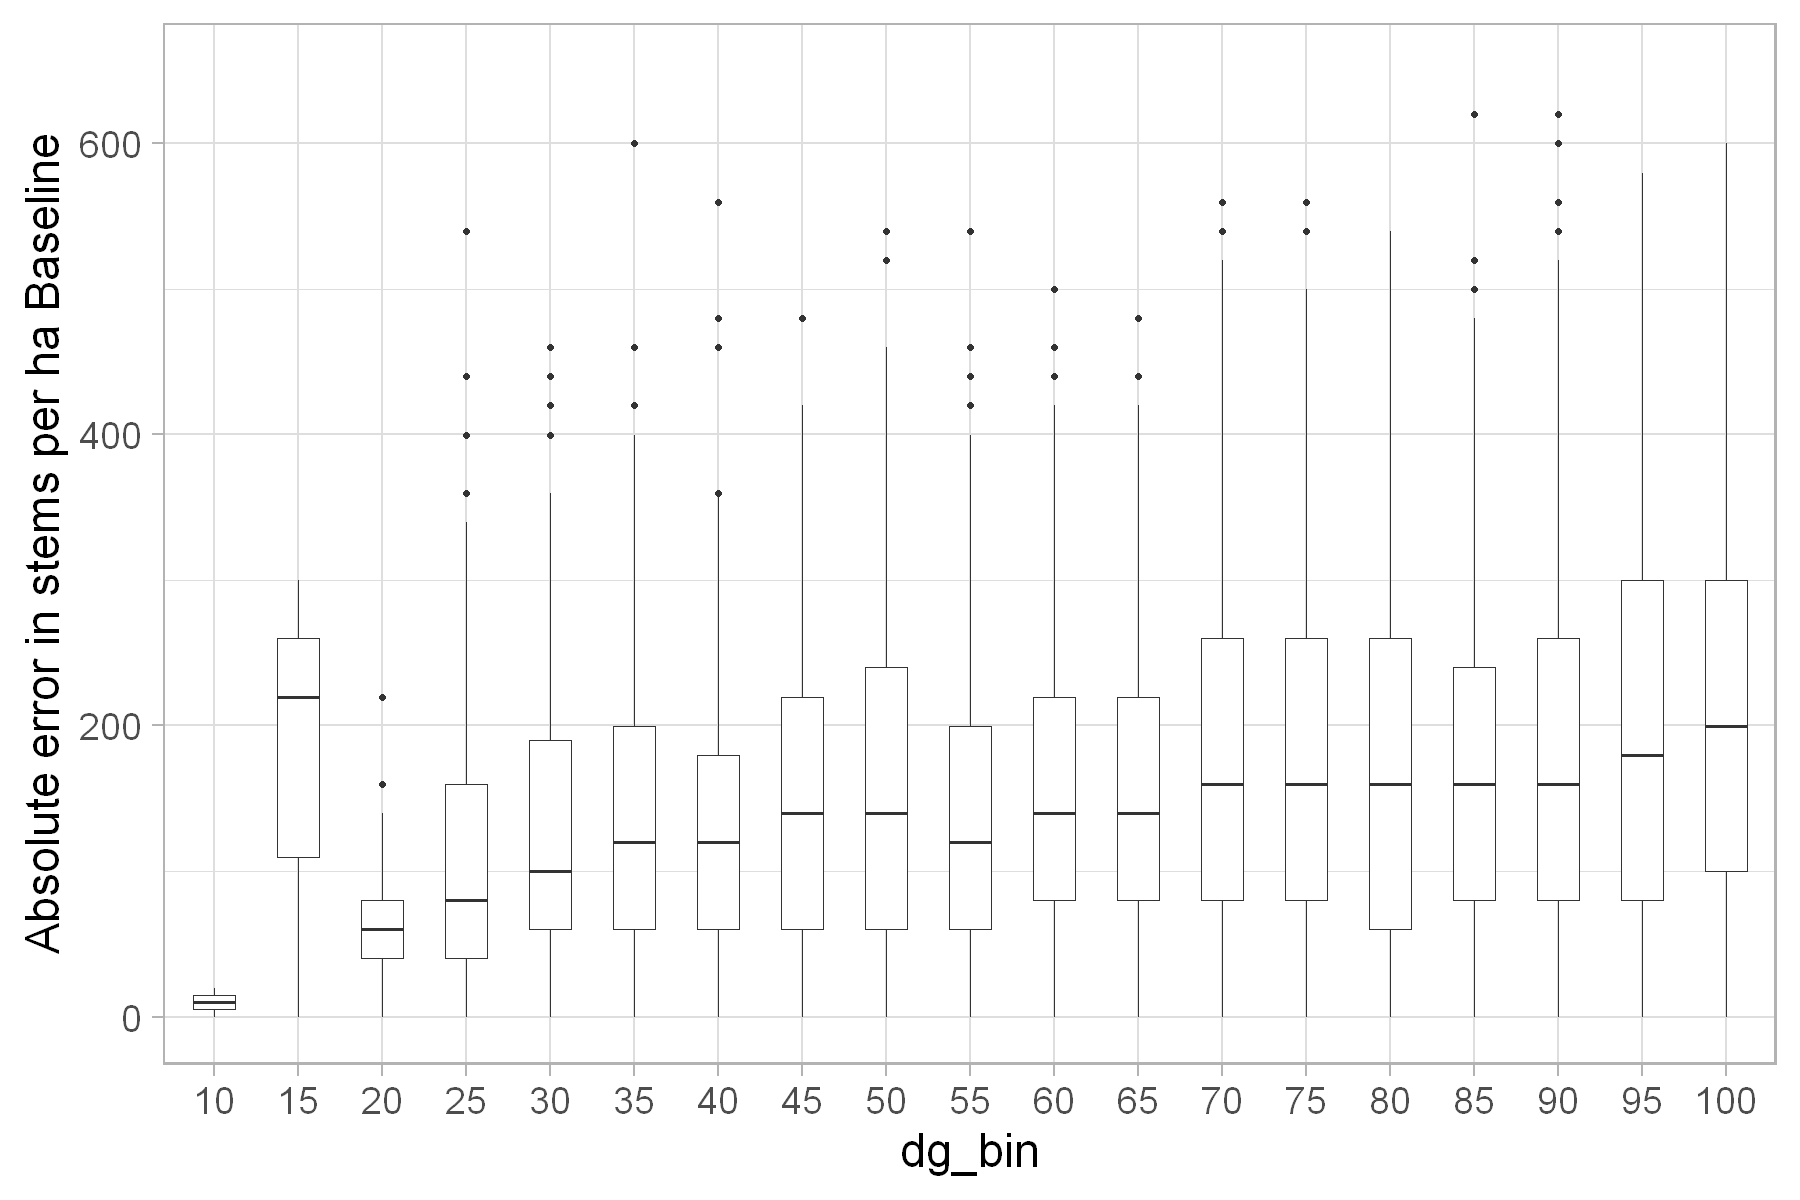

In [95]:
# Boxplots by binned degree of cover 0 = [0%,5%[, 5 = [5%,10%[ ...
options(repr.plot.width=15, repr.plot.height=10)

ggplot(data, aes(x=dg_bin, y=stems_per_ha_abs_err_model)) +
#   geom_violin(trim=FALSE)+
  geom_boxplot(width=0.5)+
  ylim(0,350) +
  theme_light(base_size = font_base_size) +
  ylab("Absolute error in stems per ha Model") 

# Boxplots by binned degree of cover 0 = [0%,5%[, 5 = [5%,10%[ ...
options(repr.plot.width=15, repr.plot.height=10)

ggplot(data, aes(x=dg_bin, y=stems_per_ha_abs_err_baseline)) +
#   geom_violin(trim=FALSE)+
  geom_boxplot(width=0.5)+
  ylim(0,650) +
  theme_light(base_size = font_base_size) +
  ylab("Absolute error in stems per ha Baseline") 



Warning message:
"Removed 89 rows containing non-finite values (stat_density2d)."
Warning message:
"Removed 89 rows containing non-finite values (stat_density2d)."
Warning message:
"Removed 396 rows containing missing values (geom_raster)."
Warning message:
"Removed 89 rows containing missing values (geom_point)."
Warning message:
"Removed 618 rows containing non-finite values (stat_density2d)."
Warning message:
"Removed 618 rows containing non-finite values (stat_density2d)."
Warning message:
"Removed 396 rows containing missing values (geom_raster)."
Warning message:
"Removed 618 rows containing missing values (geom_point)."


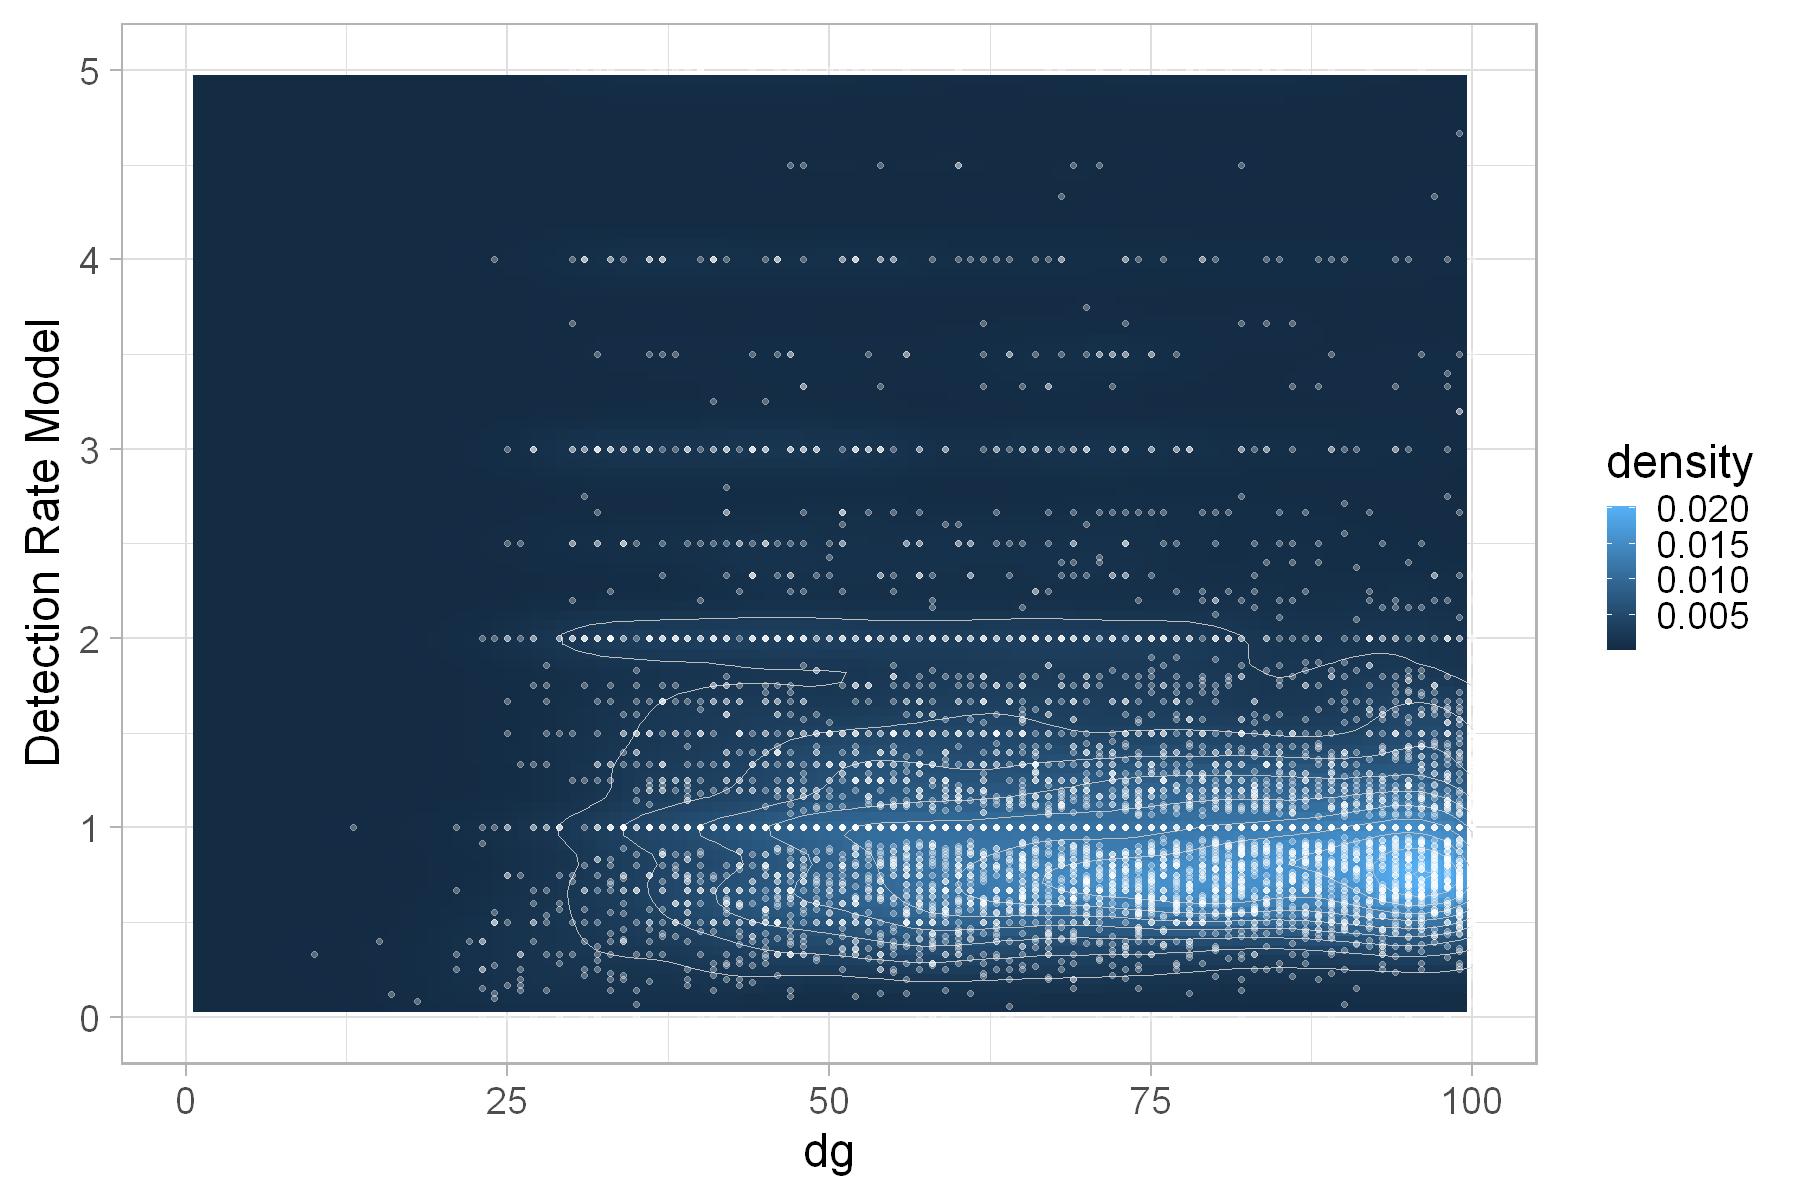

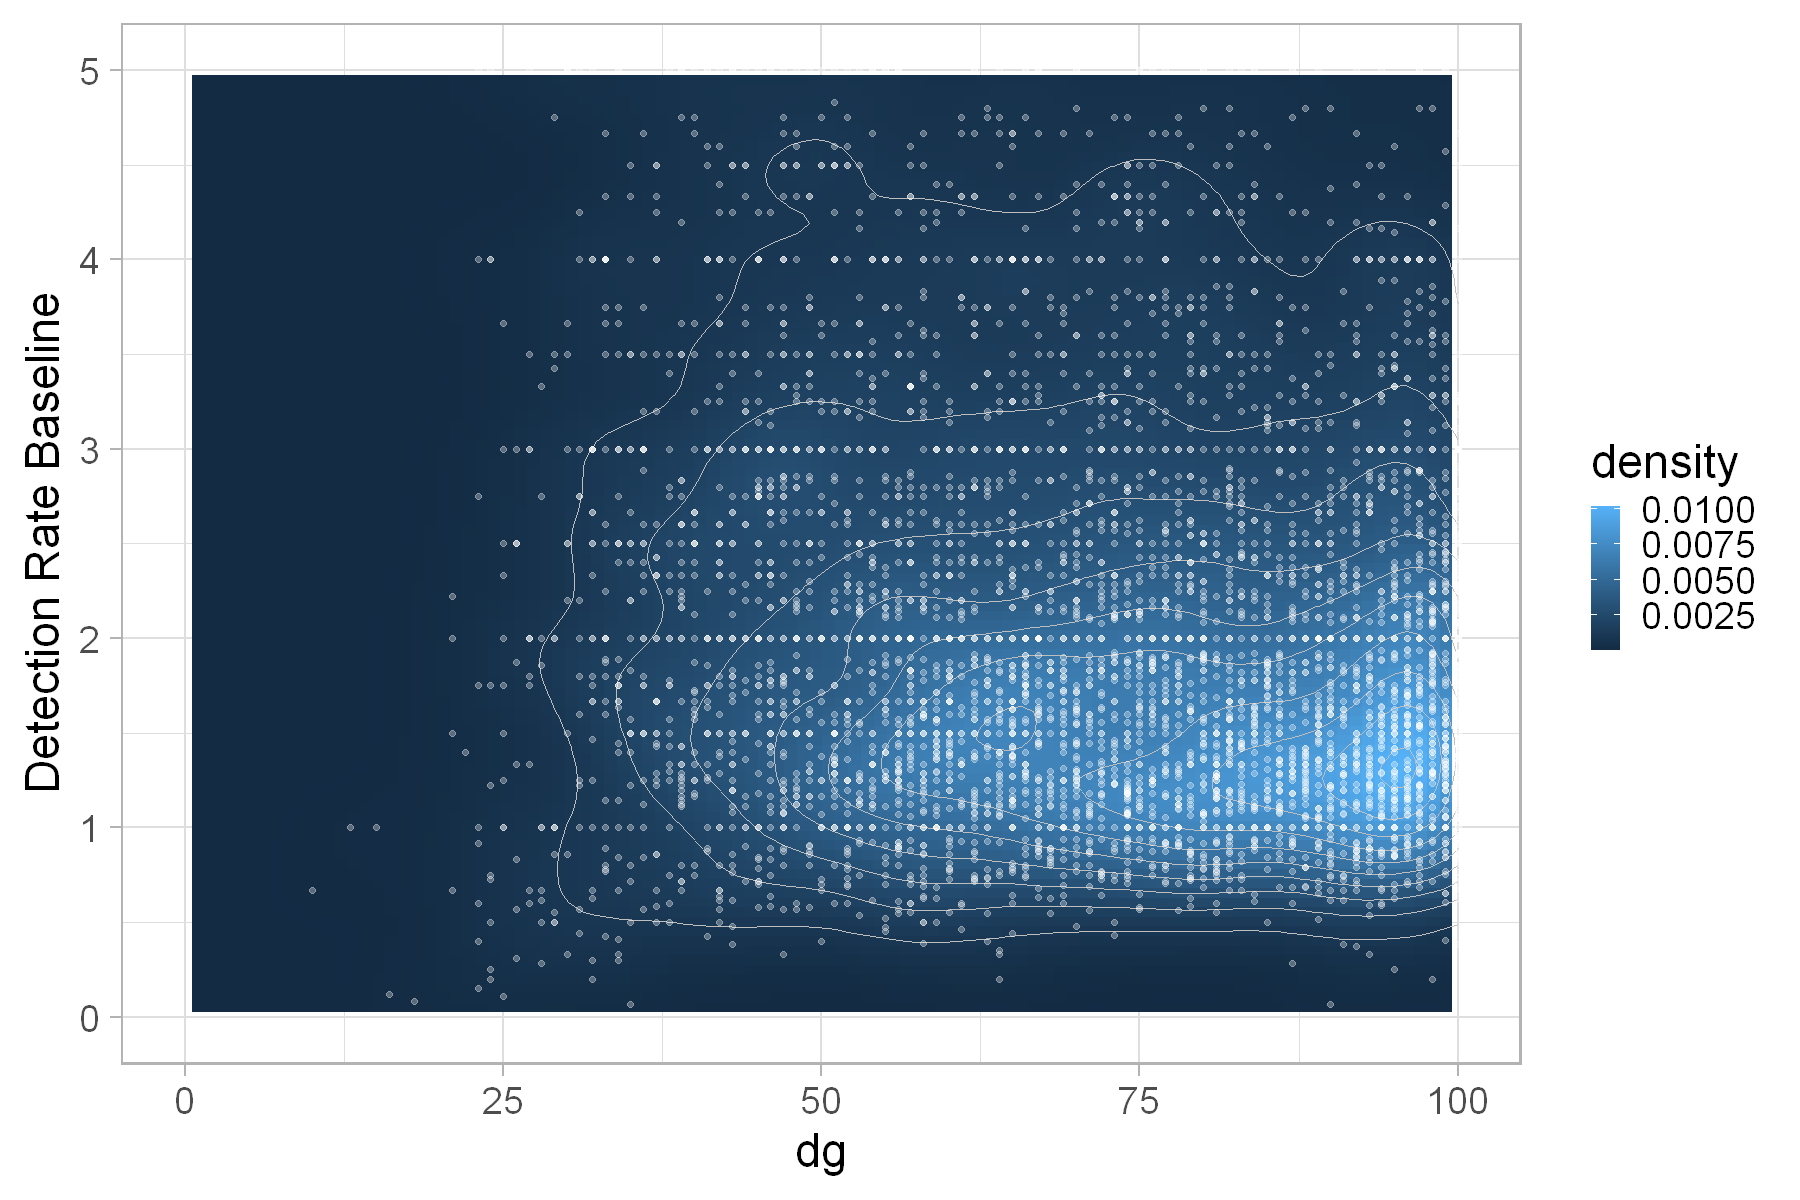

In [96]:
#Scatterplot Degree of cover vs Detection Rate
options(repr.plot.width=15, repr.plot.height=10)


ggplot(data, aes(x=dg, y=dr_model)) +
  stat_density_2d(aes(fill = ..density..), geom = "raster", contour = FALSE)+
  geom_density_2d(color="gray")+
  geom_point(alpha=0.3, color="white") +
  xlim(0,100) +
  ylim(0,5) +
  # theme(text = element_text(size = 18)) +
  theme_light(base_size = font_base_size) +
  ylab("Detection Rate Model") 


#Scatterplot Degree of cover vs  Detection Rate
options(repr.plot.width=15, repr.plot.height=10)


ggplot(data, aes(x=dg, y=dr_baseline)) +
  stat_density_2d(aes(fill = ..density..), geom = "raster", contour = FALSE)+
  geom_density_2d(color="gray")+
  geom_point(alpha=0.3, color="white") +
  xlim(0,100) +
  ylim(0,5) +
  # theme(text = element_text(size = 18)) +
  theme_light(base_size = font_base_size) +
  ylab("Detection Rate Baseline") 


Warning message:
"Removed 142 rows containing non-finite values (stat_boxplot)."
Warning message:
"Removed 291 rows containing non-finite values (stat_boxplot)."


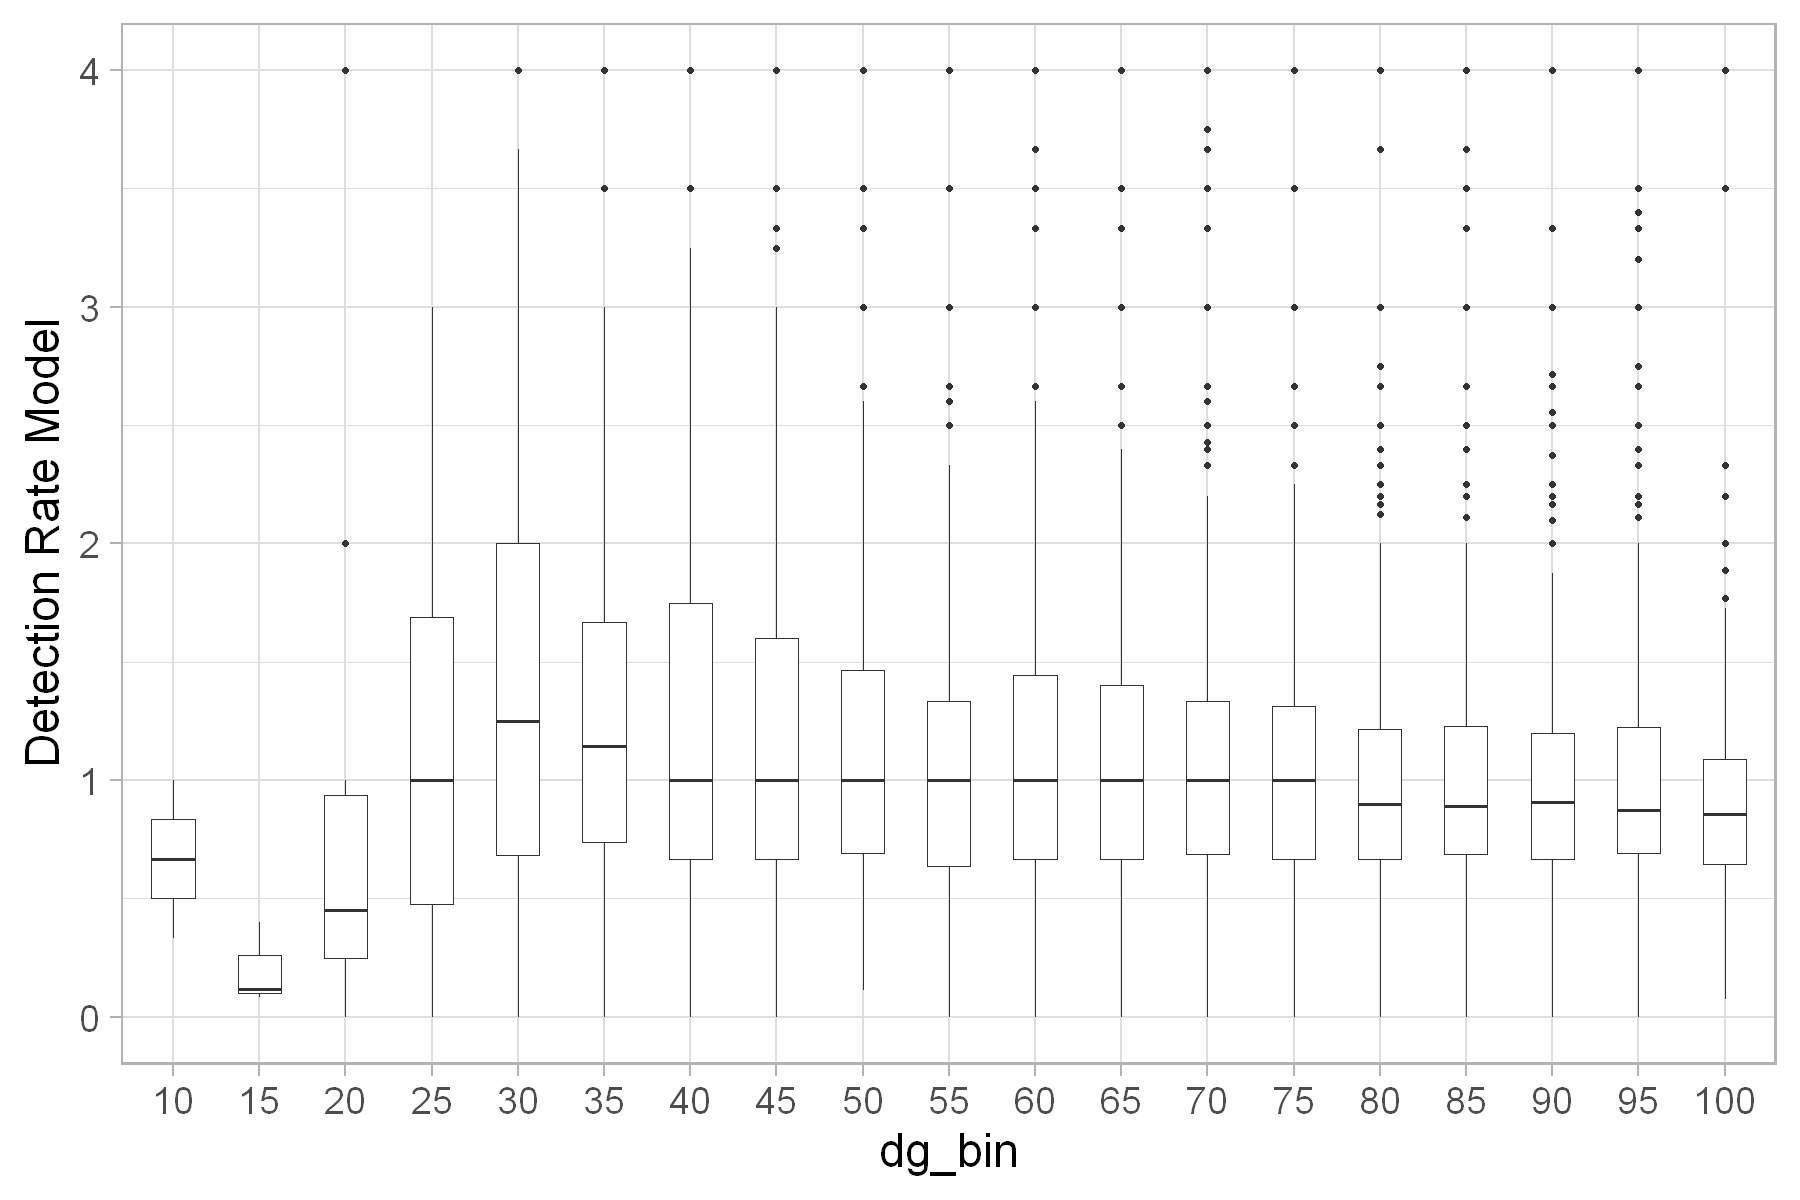

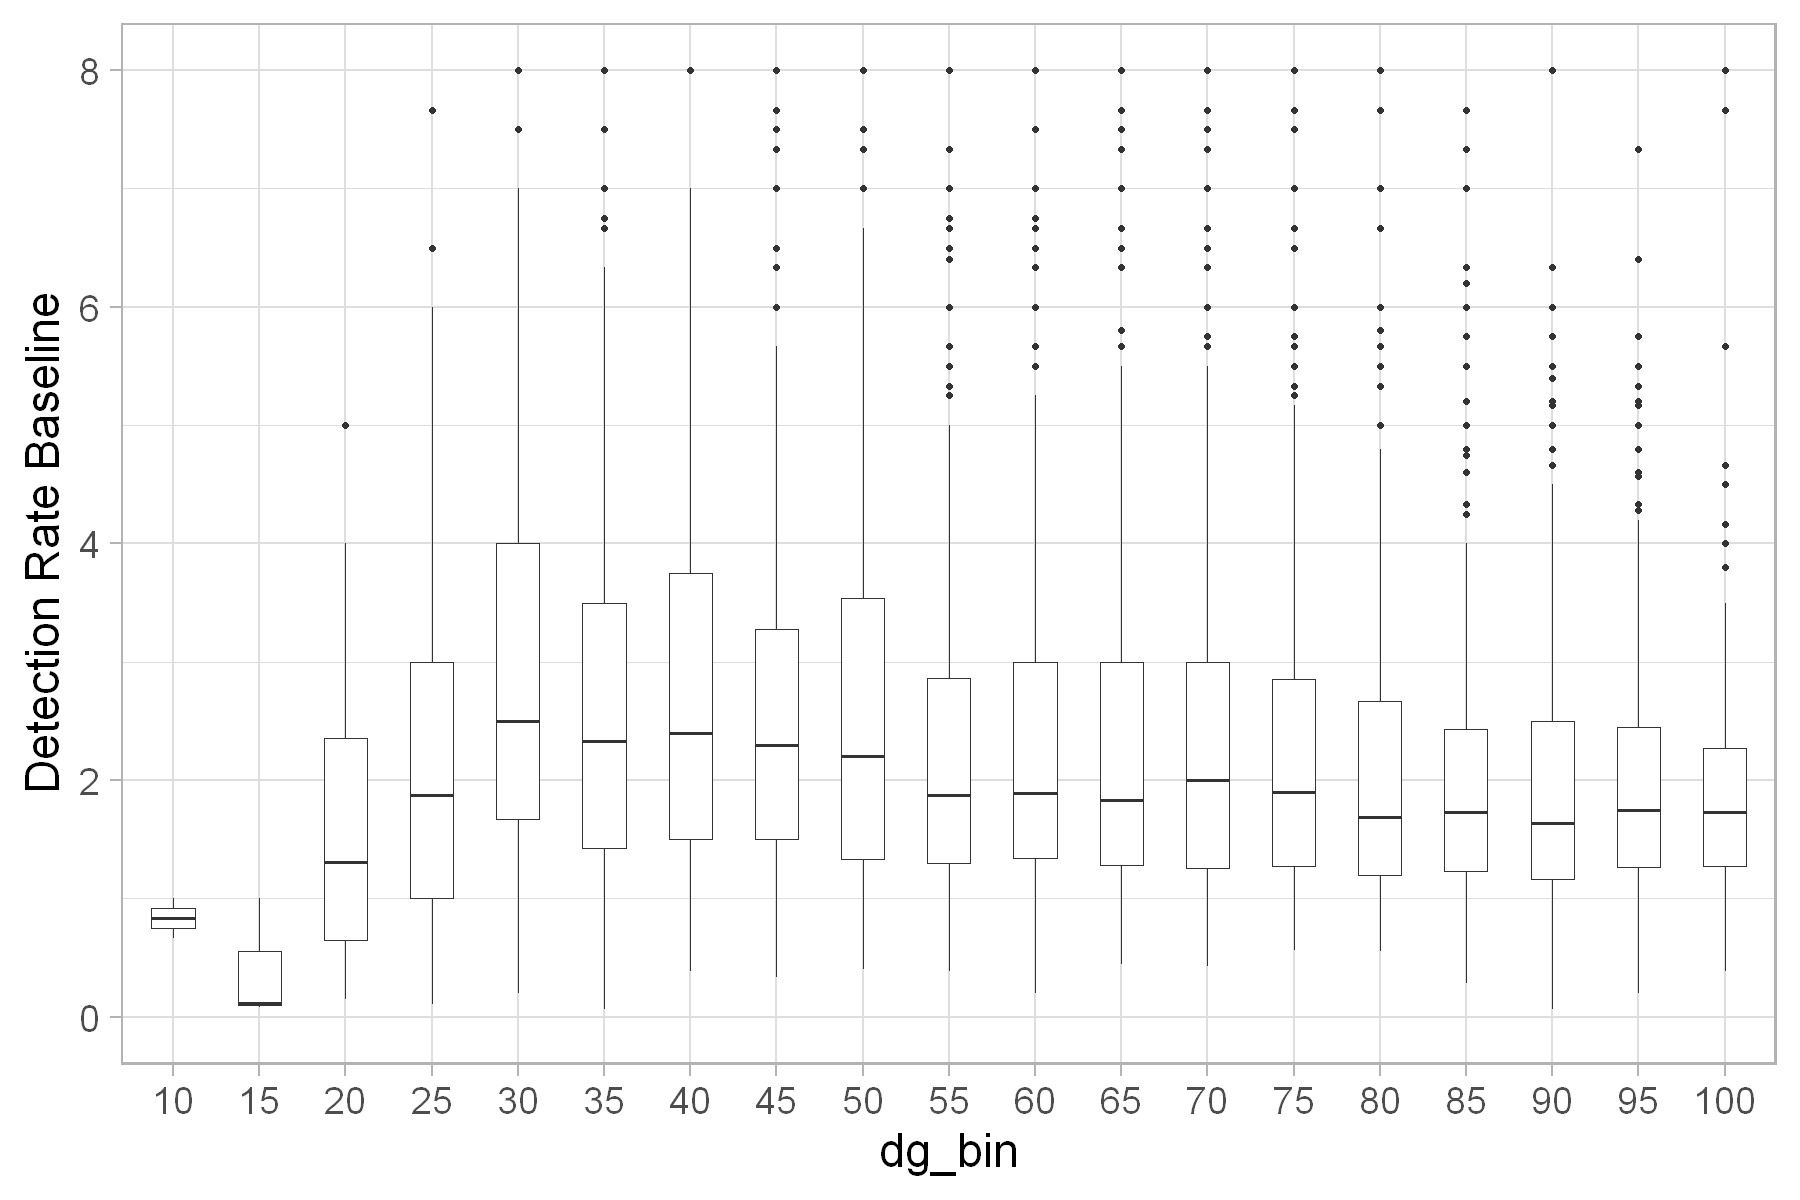

In [97]:
# Boxplots by binned degree of cover0 = [0%,5%[, 5 = [5%,10%[ ...
options(repr.plot.width=15, repr.plot.height=10)

ggplot(data, aes(x=dg_bin, y=dr_model)) +
#   geom_violin(trim=FALSE)+
  geom_boxplot(width=0.5)+
  ylim(0,4) +
  theme_light(base_size = font_base_size) +
  ylab("Detection Rate Model") 

# Boxplots by binned degree of cover 0 = [0%,5%[, 5 = [5%,10%[ ...
options(repr.plot.width=15, repr.plot.height=10)

ggplot(data, aes(x=dg_bin, y=dr_baseline)) +
#   geom_violin(trim=FALSE)+
  geom_boxplot(width=0.5)+
  ylim(0,8) +
  theme_light(base_size = font_base_size) +
  ylab("Detection Rate Baseline") 



`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



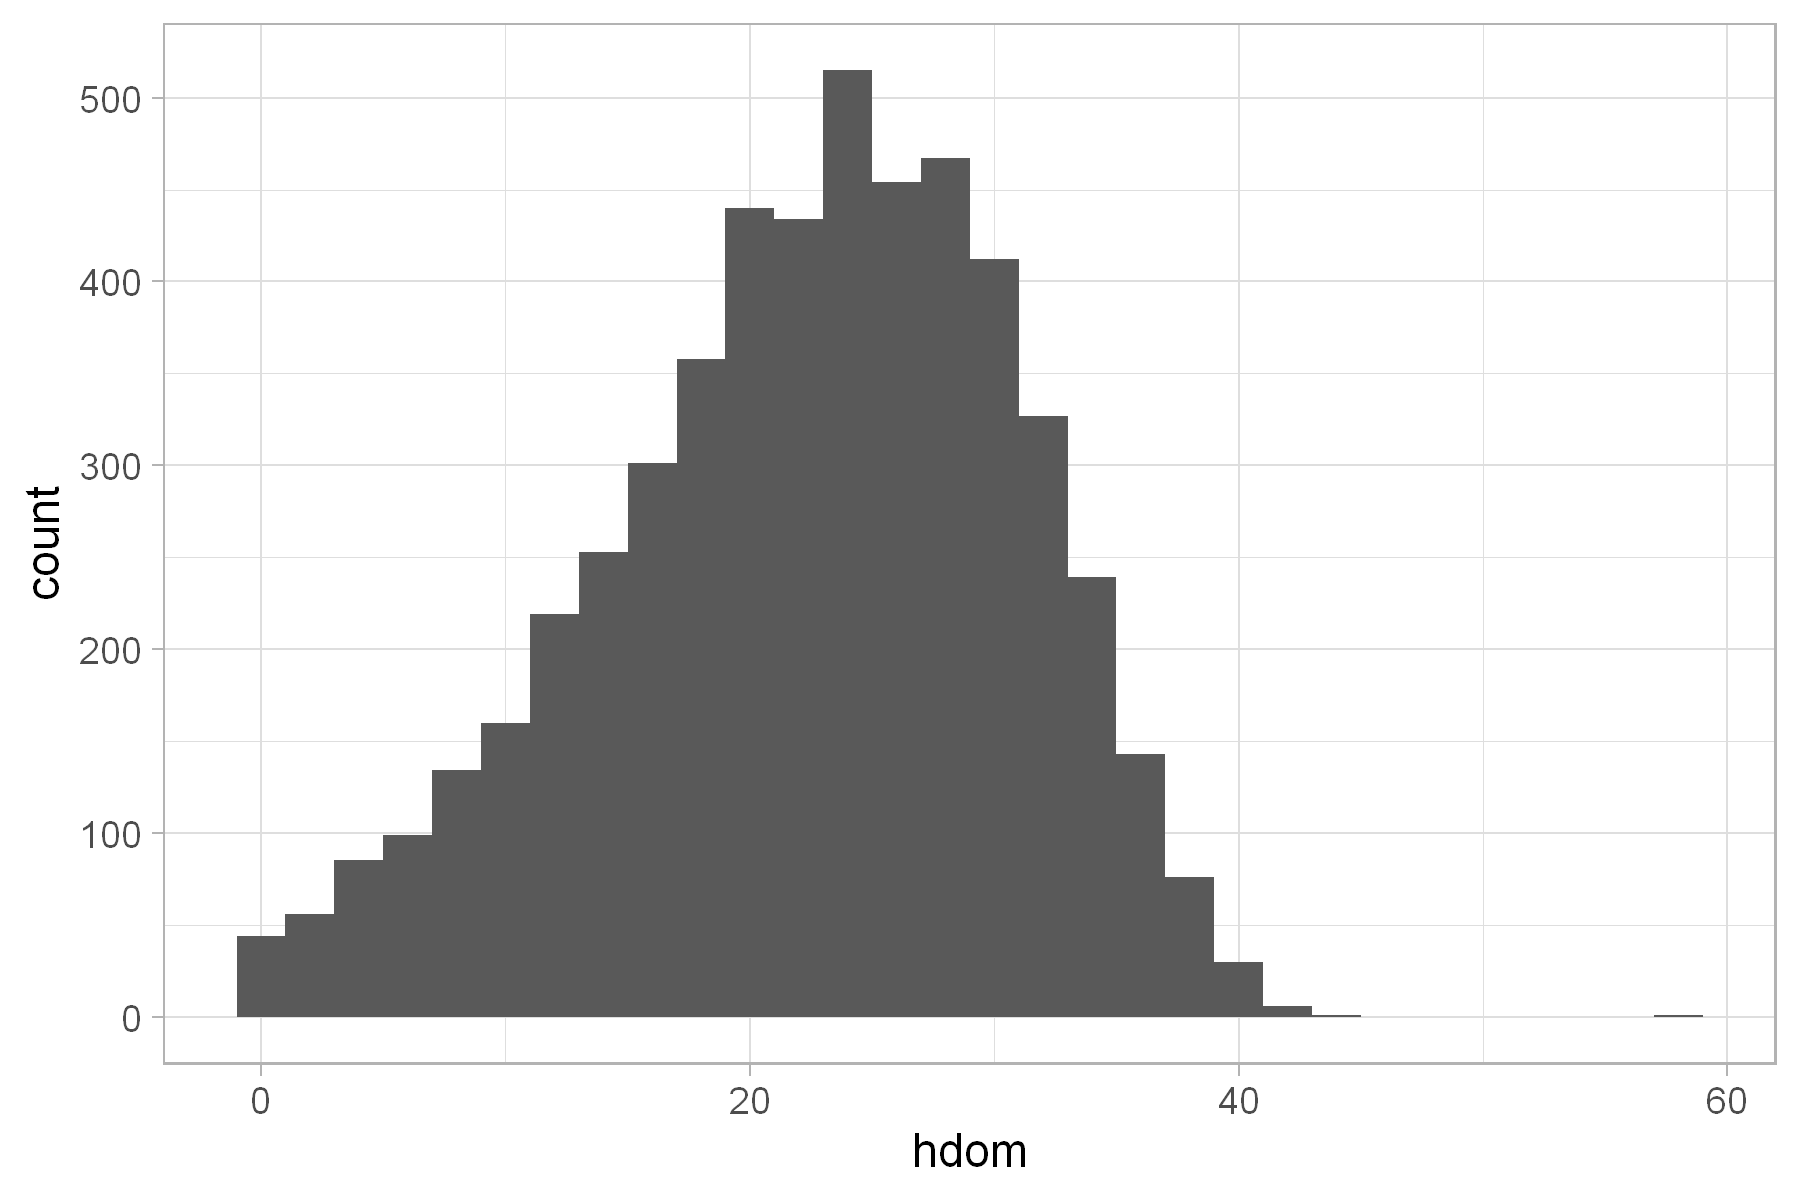

In [98]:
# Histogram of Dominant Height
options(repr.plot.width=15, repr.plot.height=10)

ggplot(data, aes(x=hdom)) +
  geom_histogram()+
  theme_light(base_size = font_base_size) 


Warning message:
"Removed 97 rows containing non-finite values (stat_density2d)."
Warning message:
"Removed 97 rows containing non-finite values (stat_density2d)."
Warning message:
"Removed 396 rows containing missing values (geom_raster)."
Warning message:
"Removed 97 rows containing missing values (geom_point)."
Warning message:
"Removed 51 rows containing non-finite values (stat_density2d)."
Warning message:
"Removed 51 rows containing non-finite values (stat_density2d)."
Warning message:
"Removed 396 rows containing missing values (geom_raster)."
Warning message:
"Removed 51 rows containing missing values (geom_point)."


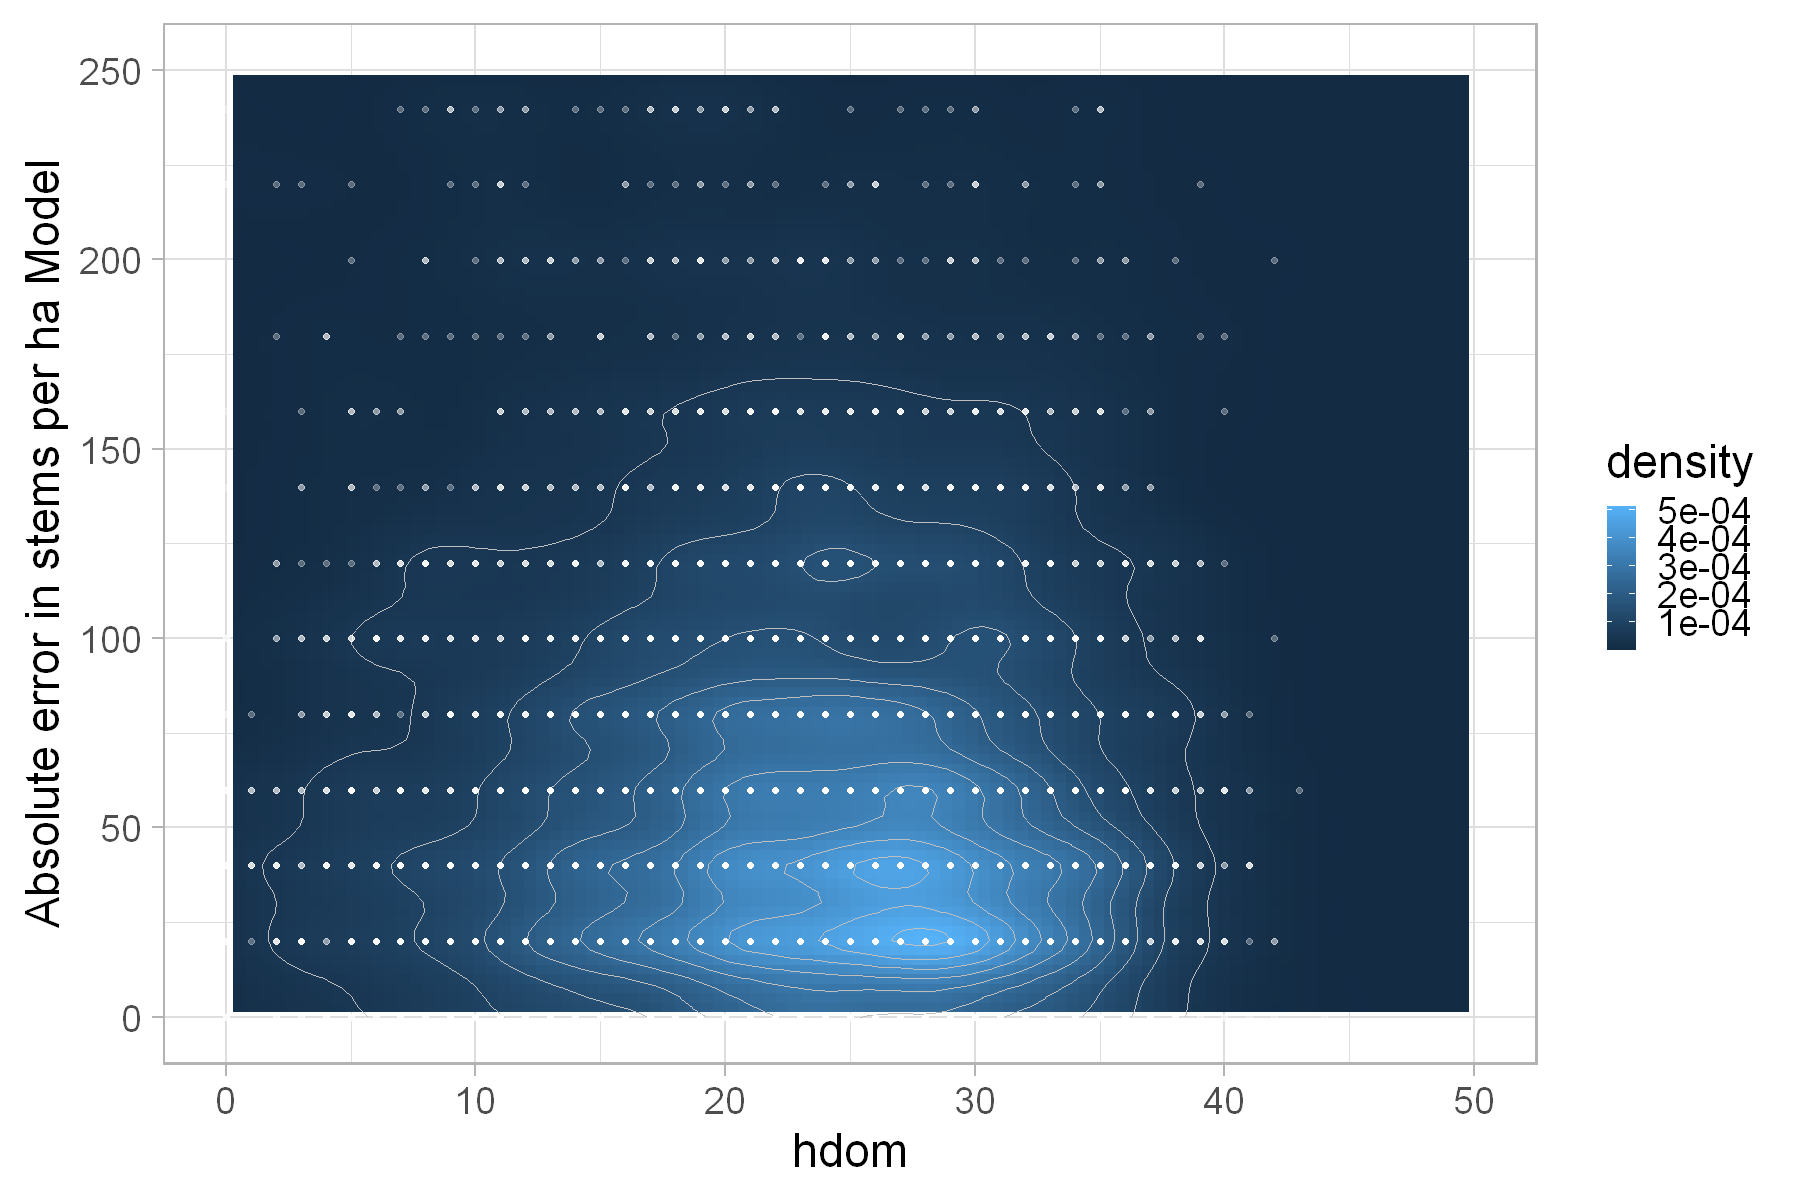

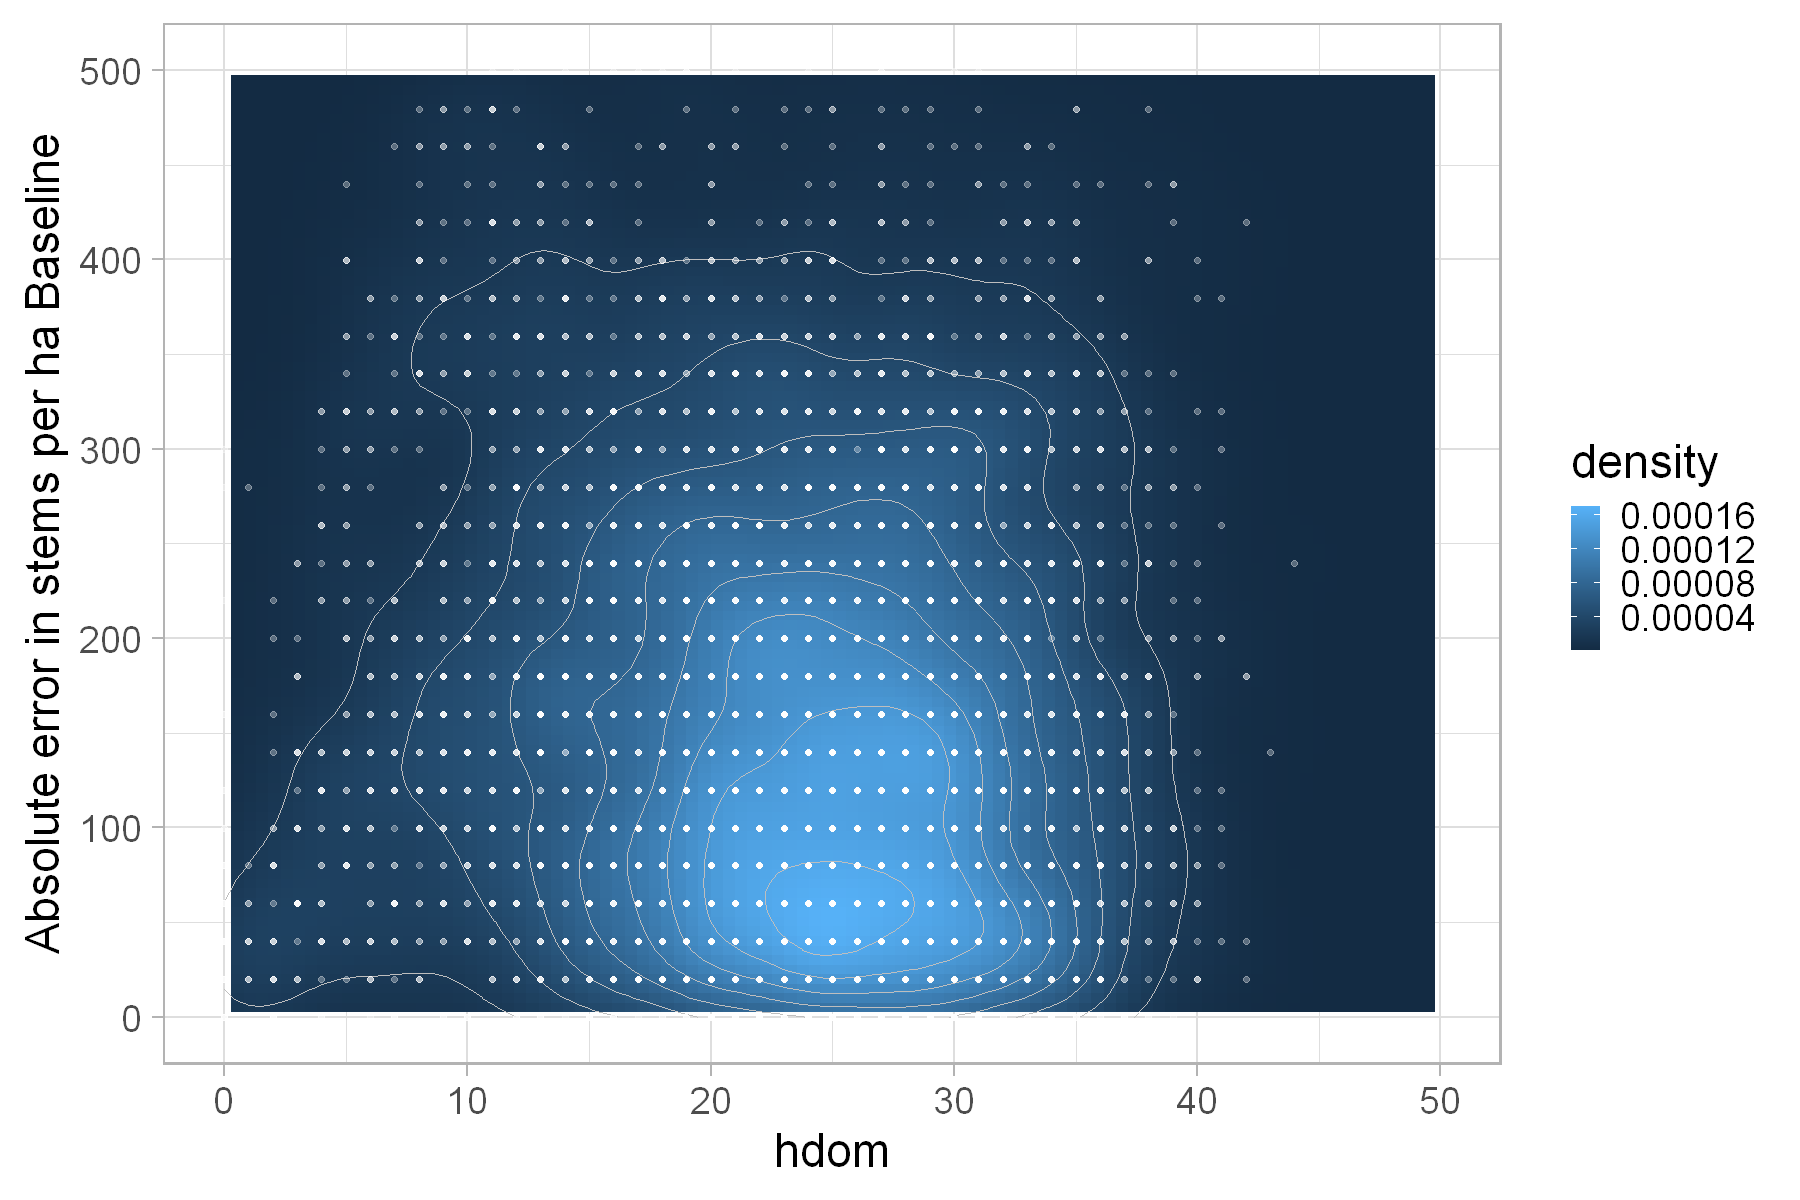

In [99]:
#Scatterplot Dominant height vs Absolute Error Model
options(repr.plot.width=15, repr.plot.height=10)


ggplot(data, aes(x=hdom, y=stems_per_ha_abs_err_model)) +
  stat_density_2d(aes(fill = ..density..), geom = "raster", contour = FALSE)+
  geom_density_2d(color="gray")+
  geom_point(alpha=0.3, color="white") +
  xlim(0,50) +
  ylim(0,250) +
  # theme(text = element_text(size = 18)) +
  theme_light(base_size = font_base_size) +
  ylab("Absolute error in stems per ha Model") 

#Scatterplot Dominant height vs Absolute Error Baseline
options(repr.plot.width=15, repr.plot.height=10)

ggplot(data, aes(x=hdom, y=stems_per_ha_abs_err_baseline)) +
  stat_density_2d(aes(fill = ..density..), geom = "raster", contour = FALSE)+
  geom_density_2d(color="gray")+
  geom_point(alpha=0.3, color="white") +
  xlim(0,50) +
  ylim(0,500) +
  # theme(text = element_text(size = 18)) +
  theme_light(base_size = font_base_size) +
  ylab("Absolute error in stems per ha Baseline") 



Warning message:
"Removed 20 rows containing non-finite values (stat_boxplot)."
Warning message:
"Removed 5 rows containing non-finite values (stat_boxplot)."


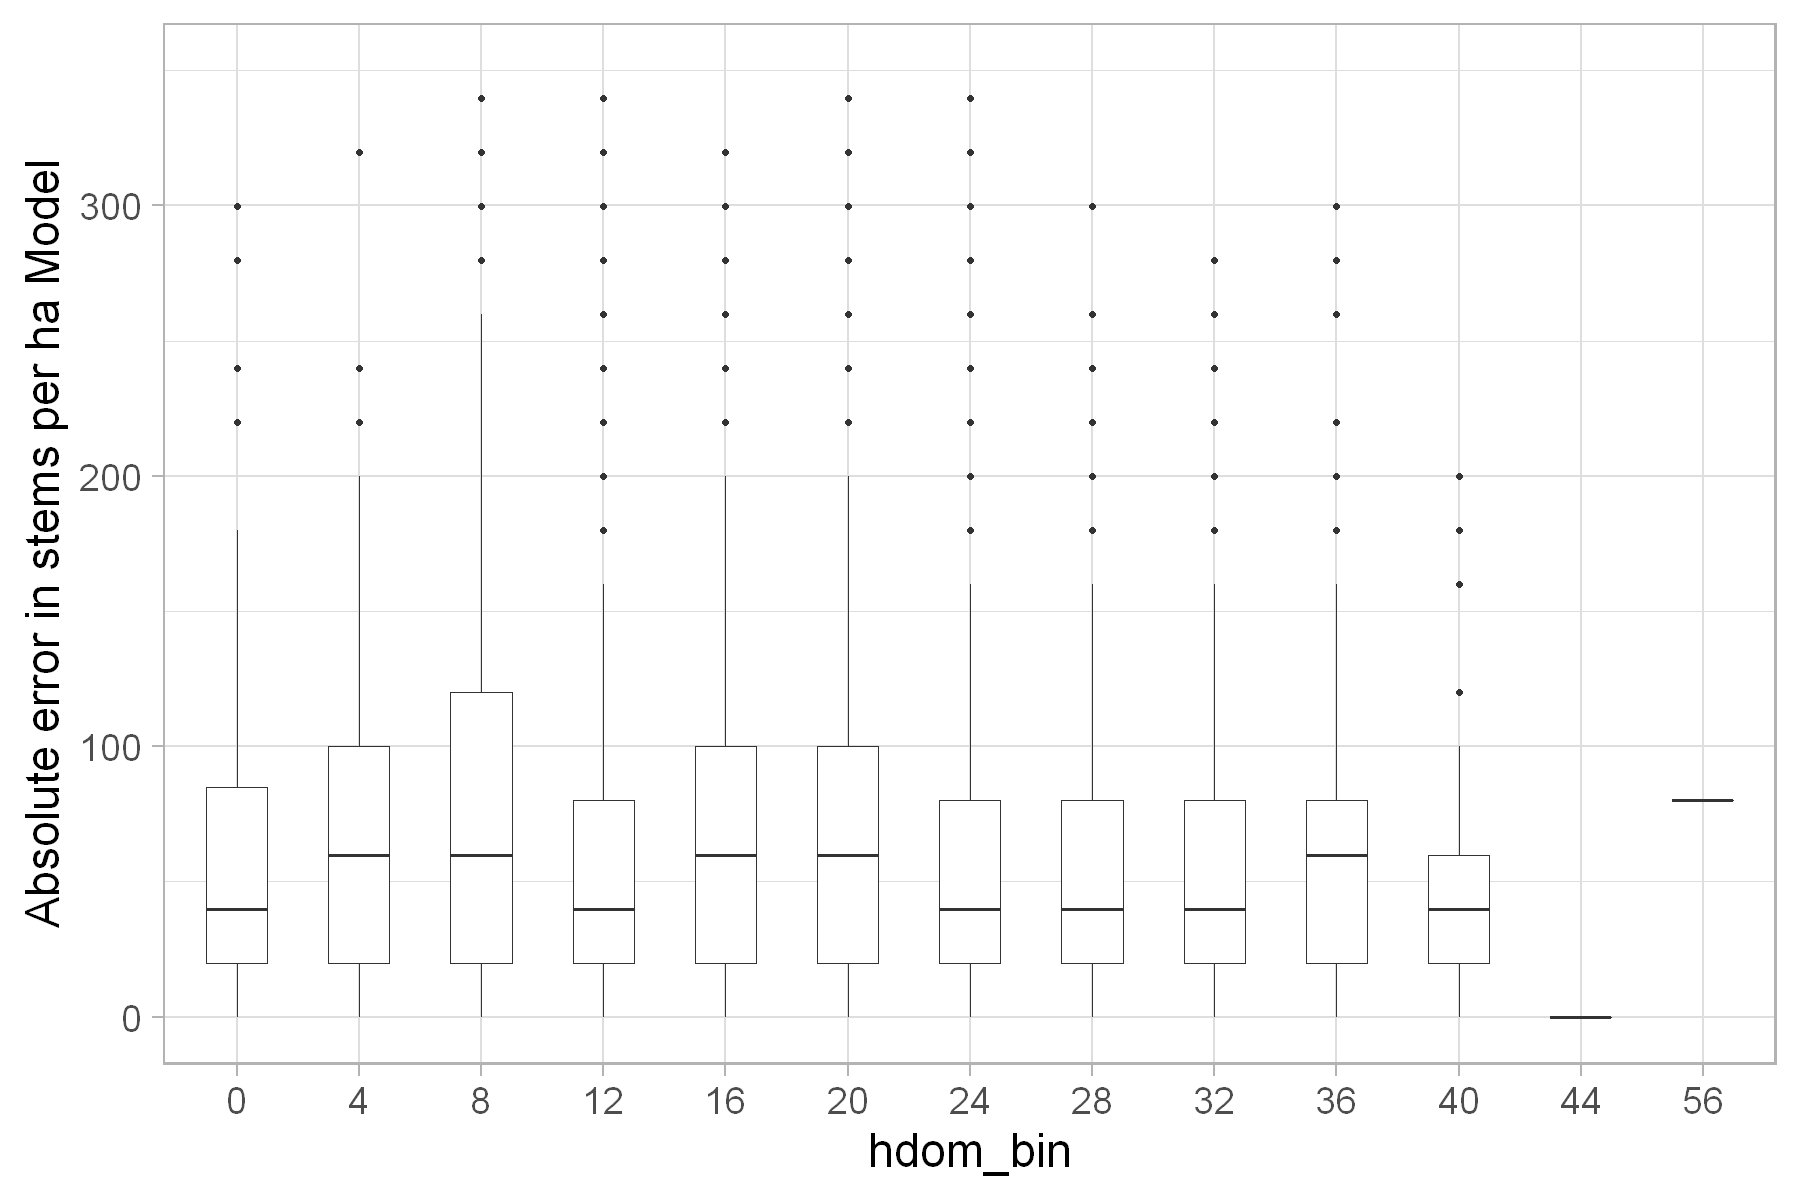

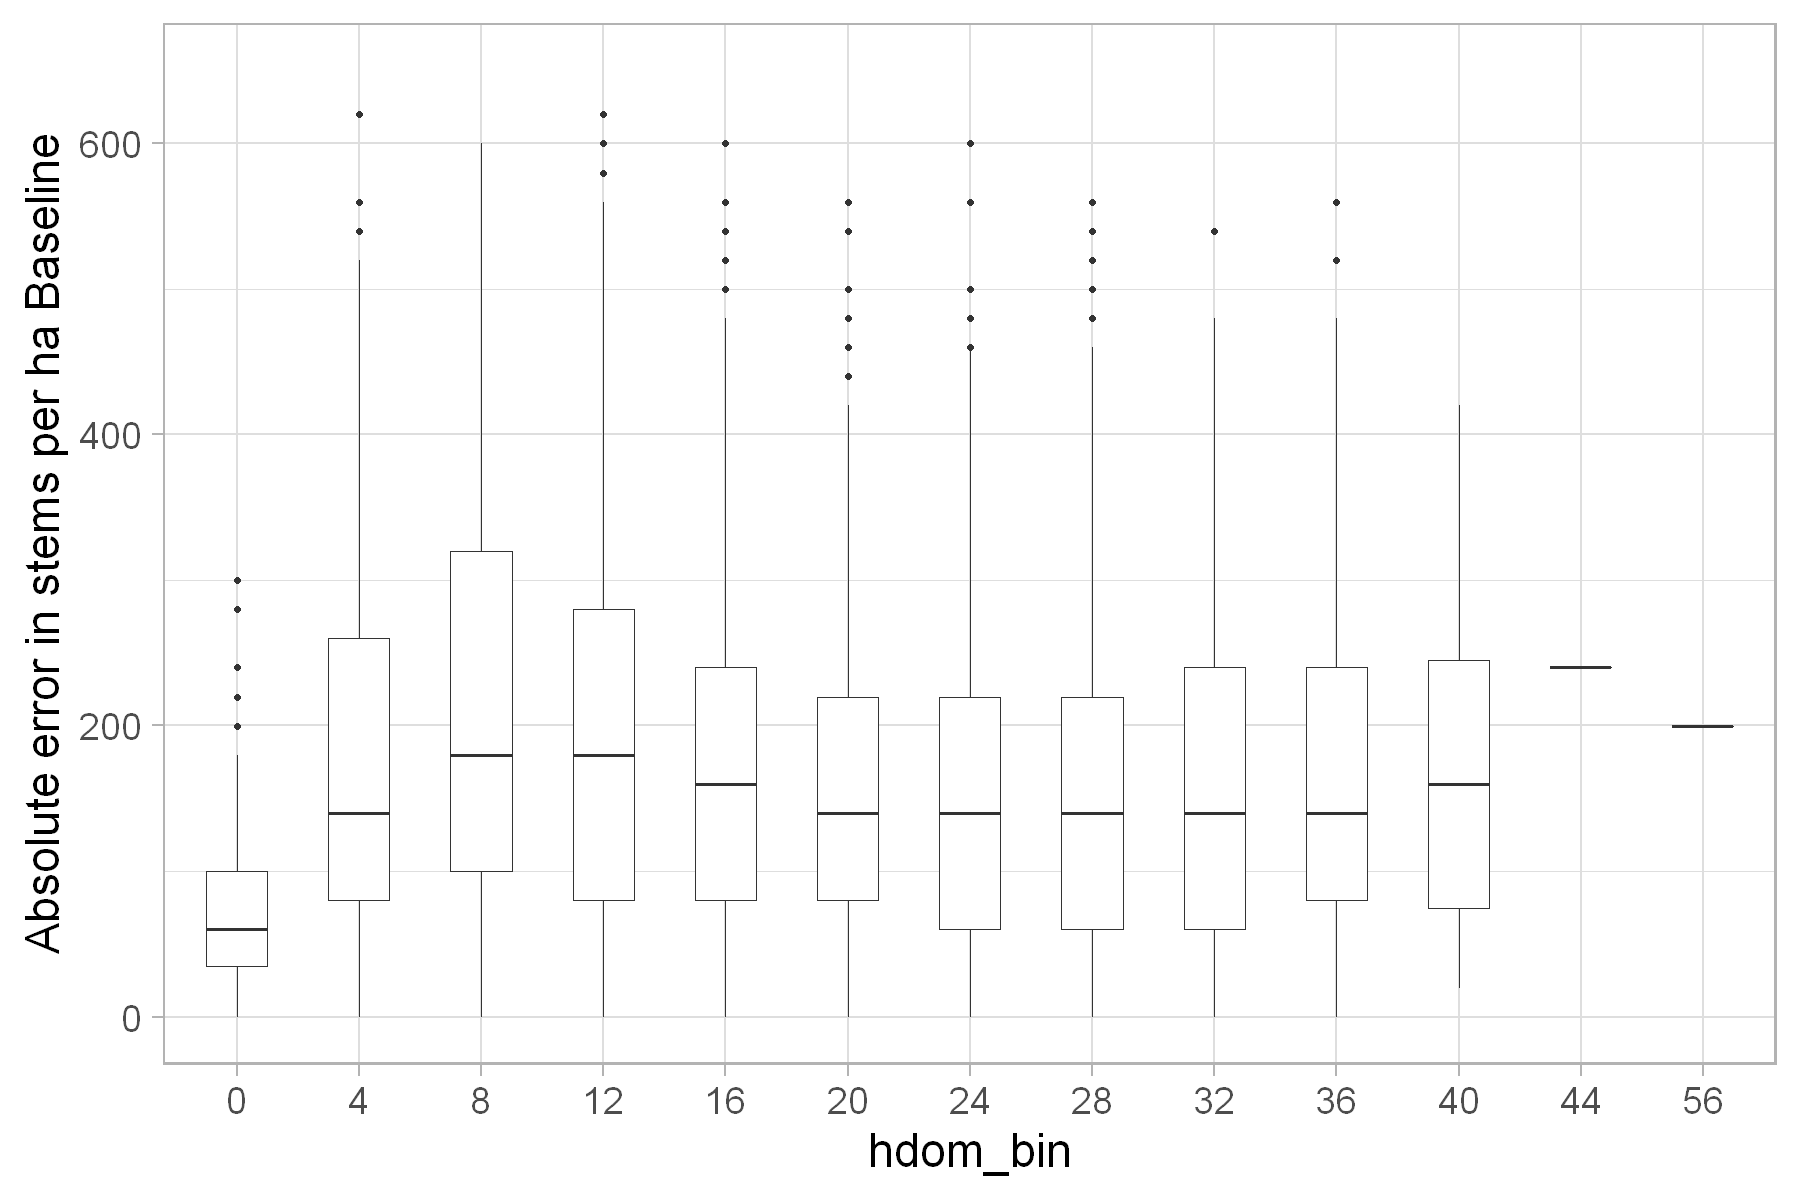

In [100]:
# Boxplots by binned dominant height  0 = [0m,4m[, 4 = [4m,8m[, 8 = [8m,12m[ ...
options(repr.plot.width=15, repr.plot.height=10)

ggplot(data, aes(x=hdom_bin, y=stems_per_ha_abs_err_model)) +
#   geom_violin(trim=FALSE)+
  geom_boxplot(width=0.5)+
  ylim(0,350) +
  theme_light(base_size = font_base_size) +
  ylab("Absolute error in stems per ha Model") 

# Boxplots by binned degree of cover 0 = [0m,4m[, 4 = [4m,8m[, 8 = [8m,12m[ ...
options(repr.plot.width=15, repr.plot.height=10)

ggplot(data, aes(x=hdom_bin, y=stems_per_ha_abs_err_baseline)) +
#   geom_violin(trim=FALSE)+
  geom_boxplot(width=0.5)+
  ylim(0,650) +
  theme_light(base_size = font_base_size) +
  ylab("Absolute error in stems per ha Baseline") 



Warning message:
"Removed 90 rows containing non-finite values (stat_density2d)."
Warning message:
"Removed 90 rows containing non-finite values (stat_density2d)."
Warning message:
"Removed 396 rows containing missing values (geom_raster)."
Warning message:
"Removed 90 rows containing missing values (geom_point)."
Warning message:
"Removed 619 rows containing non-finite values (stat_density2d)."
Warning message:
"Removed 619 rows containing non-finite values (stat_density2d)."
Warning message:
"Removed 396 rows containing missing values (geom_raster)."
Warning message:
"Removed 619 rows containing missing values (geom_point)."


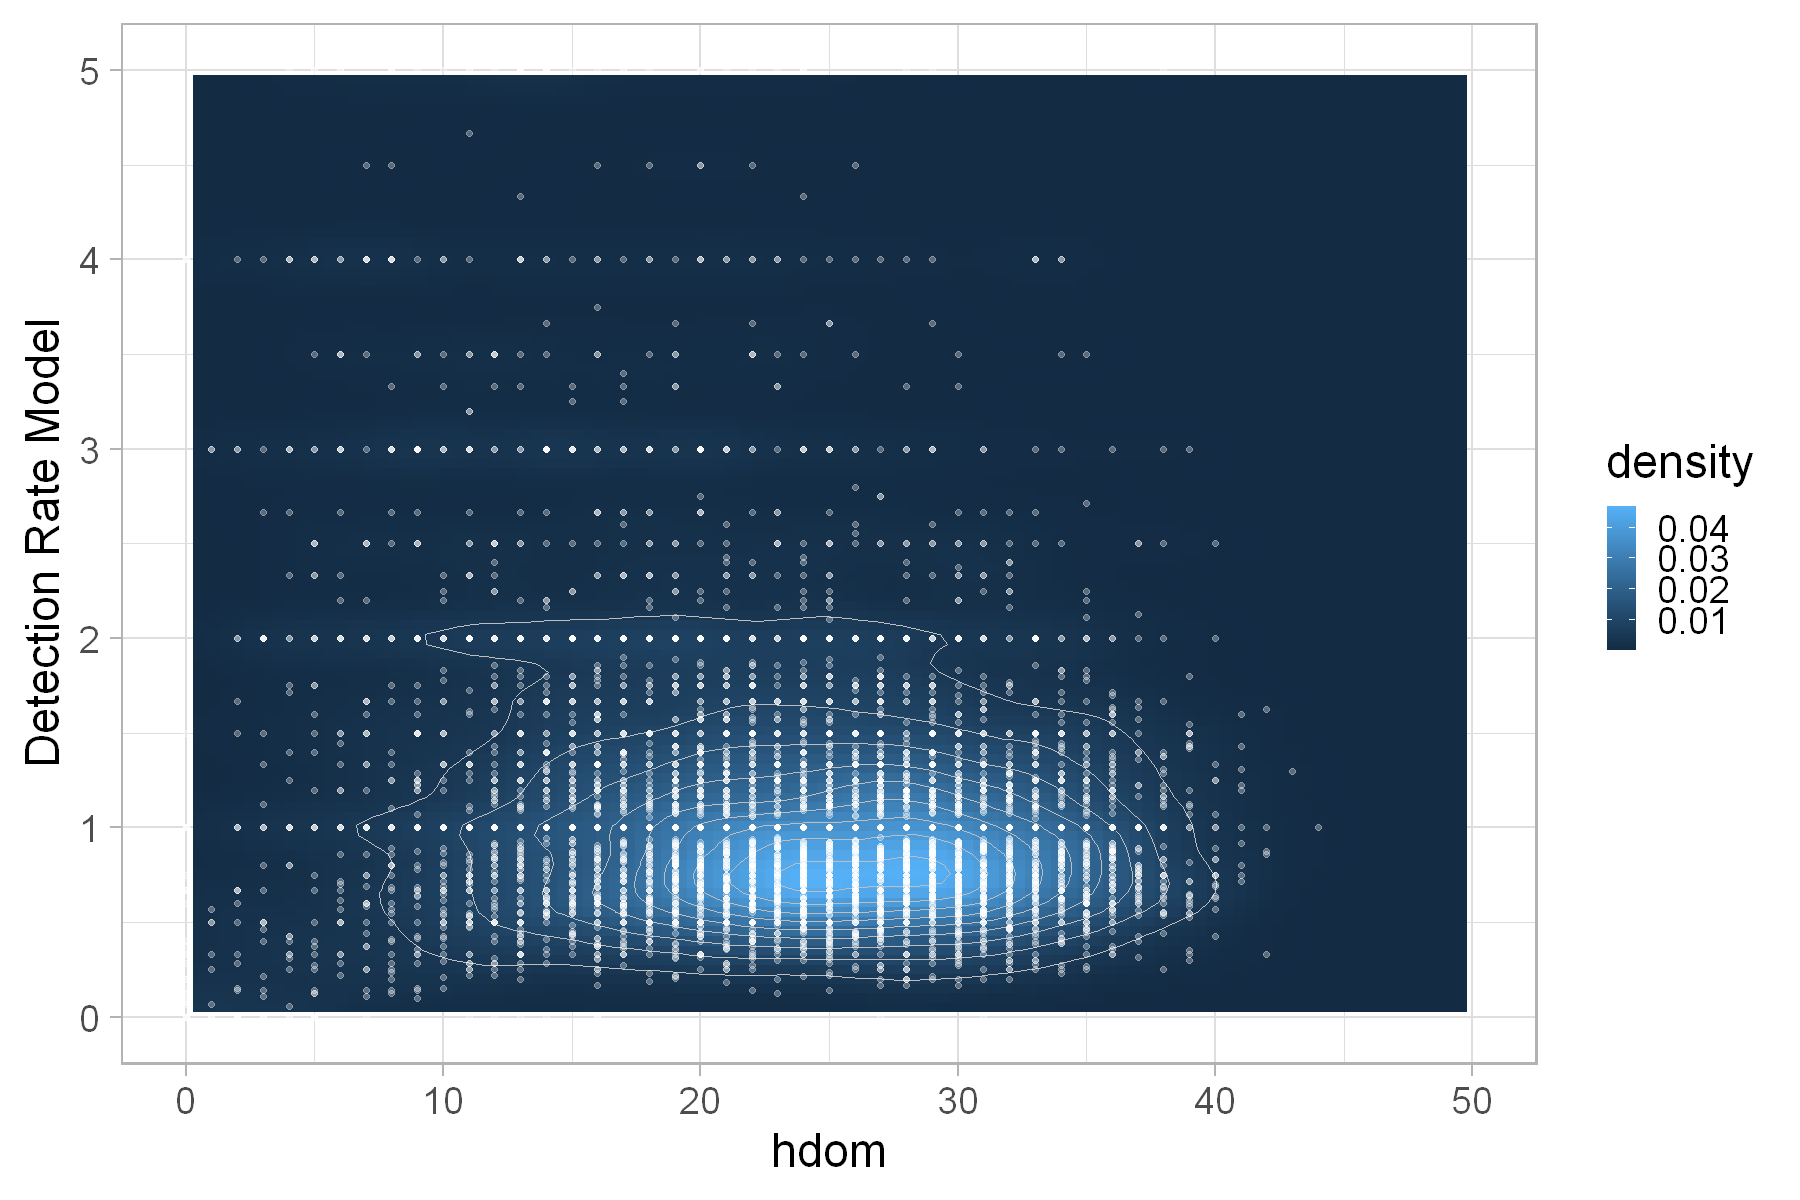

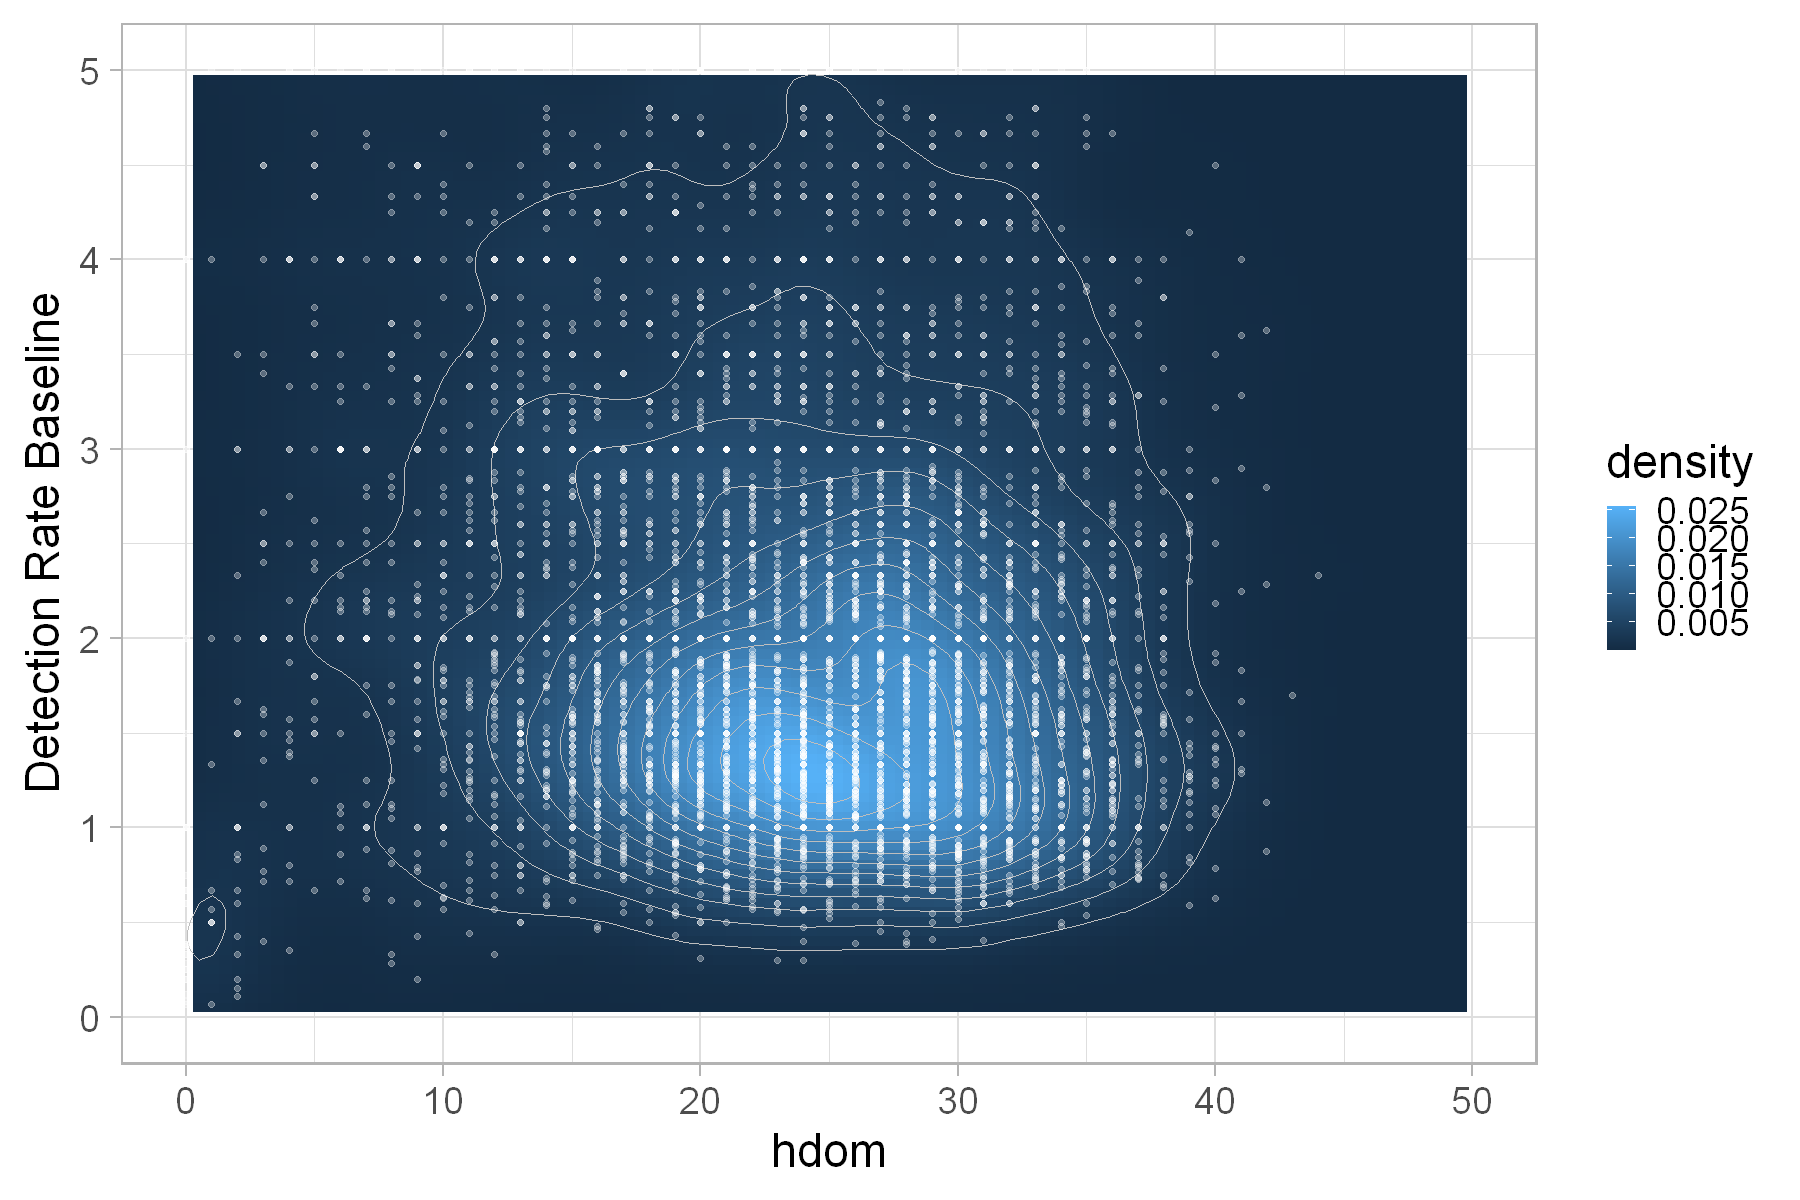

In [101]:
#Scatterplot Dominant Height vs Detection Rate
options(repr.plot.width=15, repr.plot.height=10)



ggplot(data, aes(x=hdom, y=dr_model)) +
  stat_density_2d(aes(fill = ..density..), geom = "raster", contour = FALSE)+
  geom_density_2d(color="gray")+
  geom_point(alpha=0.3, color="white") +
  xlim(0,50) +
  ylim(0,5) +
  # theme(text = element_text(size = 18)) +
  theme_light(base_size = font_base_size) +
  ylab("Detection Rate Model") 

#Scatterplot Dominant Height vs  Detection Rate
options(repr.plot.width=15, repr.plot.height=10)


ggplot(data, aes(x=hdom, y=dr_baseline)) +
  stat_density_2d(aes(fill = ..density..), geom = "raster", contour = FALSE)+
  geom_density_2d(color="gray")+
  geom_point(alpha=0.3, color="white") +
  xlim(0,50) +
  ylim(0,5) +
  # theme(text = element_text(size = 18)) +
  theme_light(base_size = font_base_size) +
  ylab("Detection Rate Baseline") 


Warning message:
"Removed 142 rows containing non-finite values (stat_boxplot)."
Warning message:
"Removed 291 rows containing non-finite values (stat_boxplot)."


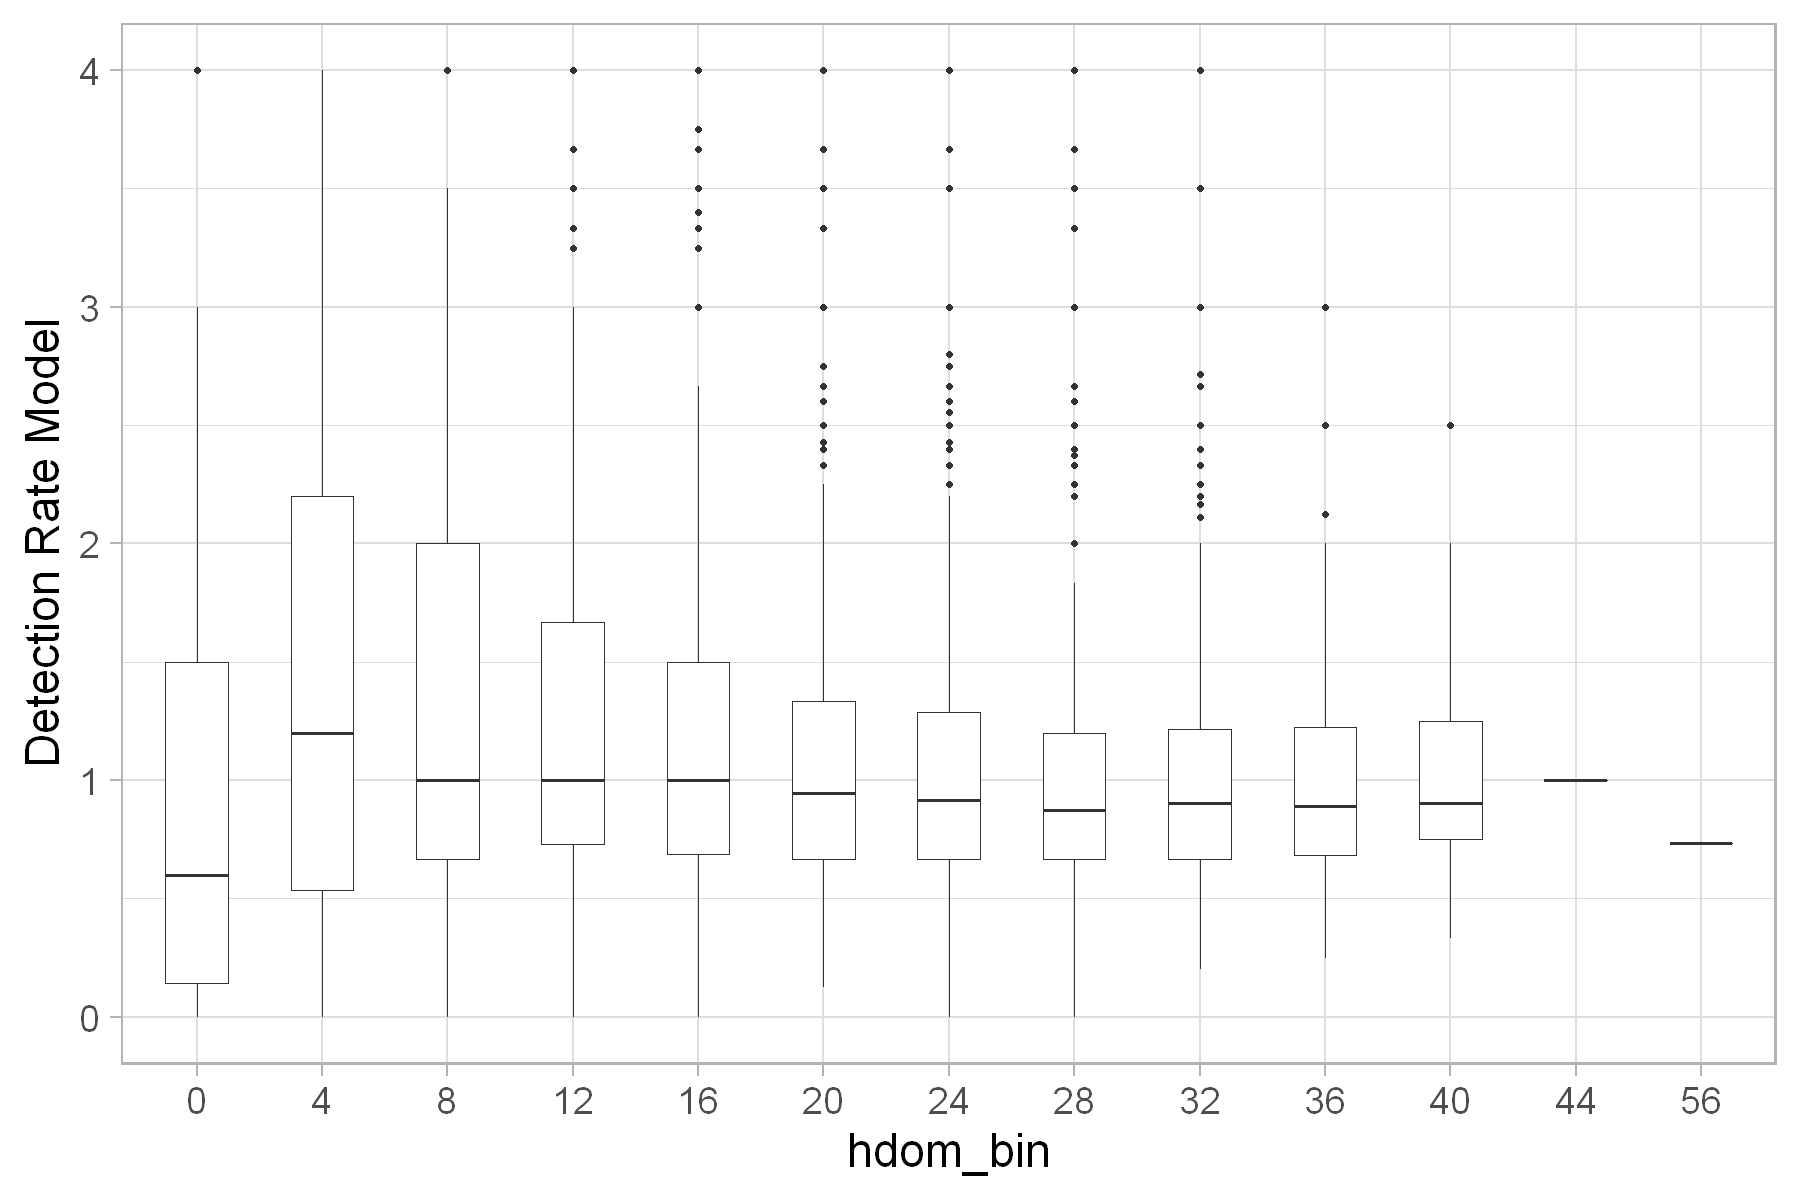

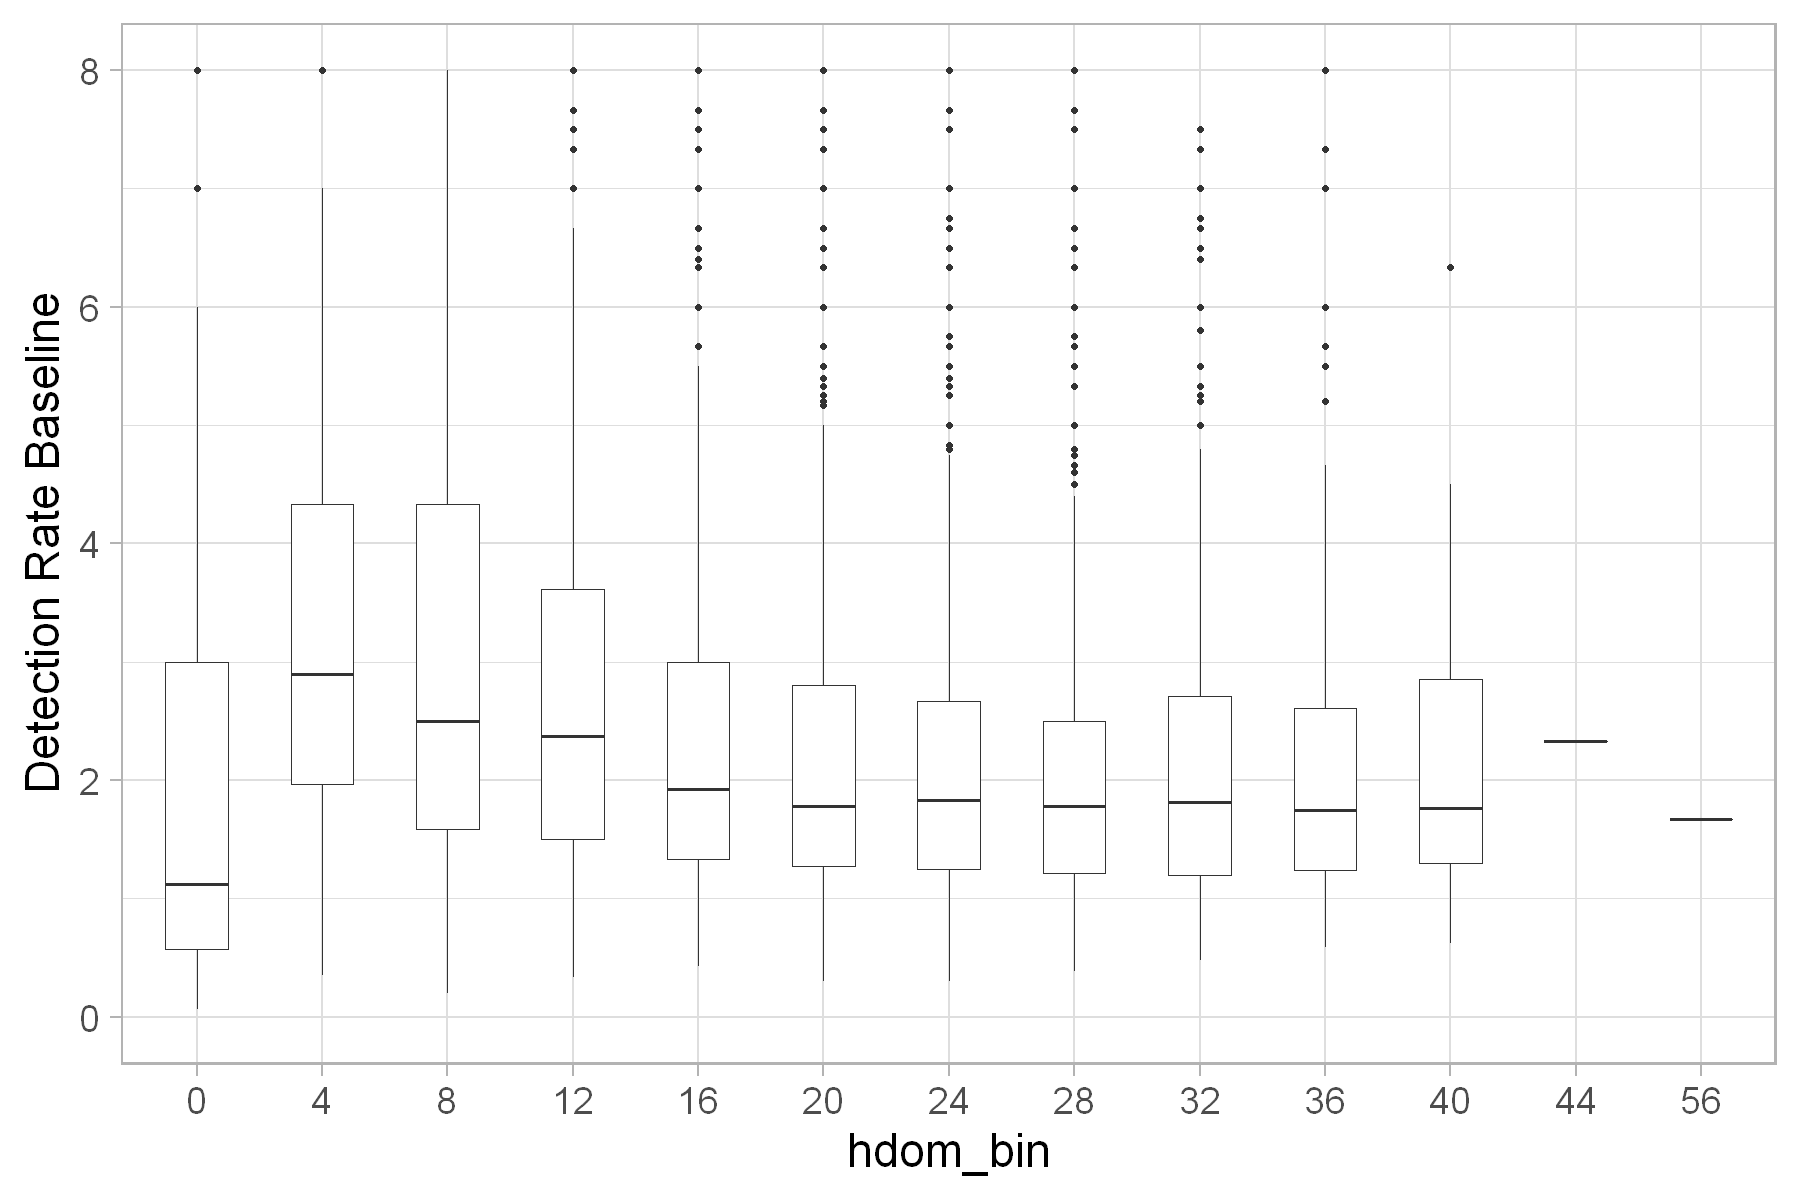

In [102]:
# Boxplots by binned  dominant height 0 = [0m,4m[, 4 = [4m,8m[, 8 = [8m,12m[ ...
options(repr.plot.width=15, repr.plot.height=10)

ggplot(data, aes(x=hdom_bin, y=dr_model)) +
#   geom_violin(trim=FALSE)+
  geom_boxplot(width=0.5)+
  ylim(0,4) +
  theme_light(base_size = font_base_size) +
  ylab("Detection Rate Model") 

# Boxplots by binned dominant height 0 = [0m,4m[, 4 = [4m,8m[, 8 = [8m,12m[ ...
options(repr.plot.width=15, repr.plot.height=10)

ggplot(data, aes(x=hdom_bin, y=dr_baseline)) +
#   geom_violin(trim=FALSE)+
  geom_boxplot(width=0.5)+
  ylim(0,8) +
  theme_light(base_size = font_base_size) +
  ylab("Detection Rate Baseline") 

